In [ ]:
# AFRICA | ANGOLA

In [ ]:
# AFRICA| Angola
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class TimeSeriesForecaster:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        
    def load_data(self, data_dict):
        """
        Load data from dictionary format: {year: value}
        Automatically handles missing years between 1960-2024
        """
        # Creating full range and fill missing years with NaN
        full_range = range(1960, 2024)
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Converting to pandas Series
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Removing NaN values for modeling
        self.clean_data = self.data.dropna()
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        
    def check_stationarity(self):
        """Check if the time series is stationary"""
        result = adfuller(self.clean_data)
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        
        if result[1] <= 0.05:
            print("✓ Series is stationary")
            return True
        else:
            print("⚠ Series is non-stationary, will difference the data")
            return False
    
    def auto_arima(self, max_p=3, max_d=2, max_q=3):
        """
        Automatically find best ARIMA parameters using AIC
        """
        best_aic = np.inf
        best_params = None
        best_model = None
        
        print("Finding optimal ARIMA parameters...")
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(self.clean_data, order=(p, d, q))
                        fitted_model = model.fit()
                        
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_params = (p, d, q)
                            best_model = fitted_model
                            
                    except Exception:
                        continue
        
        if best_model is None:
            # Fallback to simple ARIMA(1,1,1)
            print("Using fallback ARIMA(1,1,1)")
            model = ARIMA(self.clean_data, order=(1, 1, 1))
            self.model = model.fit()
            self.best_params = (1, 1, 1)
        else:
            self.model = best_model
            self.best_params = best_params
            
        print(f"Best ARIMA parameters: {self.best_params}")
        print(f"AIC: {self.model.aic:.2f}")
        
    def forecast_future(self, years_ahead=10):
        """Generate forecasts for specified years ahead"""
        if self.model is None:
            raise ValueError("Model not fitted. Call auto_arima() first.")
            
        # Forecasting with confidence intervals
        forecast_result = self.model.forecast(steps=years_ahead)
        conf_int = self.model.get_forecast(steps=years_ahead).conf_int()
        
        # Creating forecast for dates 2026-2035
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 2, last_year + 2 + years_ahead)  # Skip 2025
        forecast_index = pd.to_datetime([f'{year}-01-01' for year in forecast_years])
        
        # Storing forecast results
        self.forecast = pd.Series(forecast_result, index=forecast_index)
        self.forecast_lower = pd.Series(conf_int.iloc[:, 0], index=forecast_index)
        self.forecast_upper = pd.Series(conf_int.iloc[:, 1], index=forecast_index)
        
        return self.forecast
    
    def plot_results(self, figsize=(12, 8)):
        """Plot historical data and forecasts"""
        plt.figure(figsize=figsize)
        
        # Plot historical data
        plt.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='orange', alpha=0.7,linewidth=3, markersize=4)
        
        # Ploting forecasts
        if self.forecast is not None:
            plt.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=3, markersize=4)
            
            # Ploting confidence intervals
            plt.fill_between(self.forecast.index, 
                           self.forecast_lower.values,
                           self.forecast_upper.values,
                           alpha=0.3, color='red', label='95% Confidence Interval')
        
        plt.title('Angola Africa Exports | Machine Learning Time Series Forecasts')
        plt.xlabel('Year (1960 - 2035)')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def print_forecast_table(self):
        """Print forecast results in a nice table format"""
        if self.forecast is None:
            print("No forecast available. Run forecast_future() first.")
            return
            
        print("\n" + "="*60)
        print("FORECAST RESULTS (2026-2035)")
        print("="*60)
        print(f"{'Year':<6} {'Forecast':<12} {'Lower 95%':<12} {'Upper 95%':<12}")
        print("-"*60)
        
        for i, year in enumerate(self.forecast.index):
            print(f"{year.year:<6} {self.forecast.iloc[i]:<12.2f} "
                  f"{self.forecast_lower.iloc[i]:<12.2f} {self.forecast_upper.iloc[i]:<12.2f}")
        
        print("="*60)
        
    def get_model_summary(self):
        """Print model summary statistics"""
        if self.model is not None:
            print(self.model.summary())


if __name__ == "__main__":
    # DATA: EXPORTS
    sample_data = {
        1960:499, 1961:491, 1962:481, 1963:487, 1964:511, 
        1965:500, 1966:503, 1967:505, 1968:509, 1969:510, 
        1970:556, 1971:541, 1972:554, 1973:668, 1974:820, 
        1975:823, 1976:798, 1977:765, 1978:795, 1979:876, 
        1980:983, 1981:952, 1982:847, 1983:762, 1984:749, 
        1985:699, 1986:701, 1987:750, 1988:849, 1989:894, 
        1990:925, 1991:966, 1992:971, 1993:955, 1994:989, 
        1995:1064, 1996:1075, 1997:1112, 1998:1052, 1999:1031, 
        2000:1069, 2001:970, 2002:913, 2003:904, 2004:963, 
        2005:998, 2006:1064, 2007:1146, 2008:1243, 2009:1093, 
        2010:1234, 2011:1356, 2012:1364, 2013:1355, 2014:1351, 
        2015:1241, 2016:1189, 2017:1218, 2018:1229, 2019:1179, 
        2020:1007, 2021:1079, 2022:1160, 2023:1101, 2024:1090
    }
    
    # Initialize and run forecaster
    forecaster = TimeSeriesForecaster()
    
    print("Time Series Forecasting Tool")
    print("="*50)
    
    # Loading data
    forecaster.load_data(sample_data)
    
    # Checking stationarity
    forecaster.check_stationarity()
    
    # Finding best model
    forecaster.auto_arima()
    
    # Generating forecasts for 2026-2035
    forecast = forecaster.forecast_future(years_ahead=10)
    
    # Displaying results
    forecaster.print_forecast_table()
    
    # Ploting results
    forecaster.plot_results()
    
    #Detailed model summary
    forecaster.get_model_summary()

In [ ]:
# AFRICA | BENIN


In [ ]:
# AFRICA | Benin
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class TimeSeriesForecaster:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        
    def load_data(self, data_dict):
        """
        Load data from dictionary format: {year: value}
        Automatically handles missing years between 1960-2024
        """
        # Creating full range and fill missing years with NaN
        full_range = range(1960, 2024)
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Converting to pandas Series
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Removing NaN values for modeling
        self.clean_data = self.data.dropna()
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        
    def check_stationarity(self):
        """Check if the time series is stationary"""
        result = adfuller(self.clean_data)
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        
        if result[1] <= 0.05:
            print("✓ Series is stationary")
            return True
        else:
            print("⚠ Series is non-stationary, will difference the data")
            return False
    
    def auto_arima(self, max_p=3, max_d=2, max_q=3):
        """
        Automatically find best ARIMA parameters using AIC
        """
        best_aic = np.inf
        best_params = None
        best_model = None
        
        print("Finding optimal ARIMA parameters...")
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(self.clean_data, order=(p, d, q))
                        fitted_model = model.fit()
                        
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_params = (p, d, q)
                            best_model = fitted_model
                            
                    except Exception:
                        continue
        
        if best_model is None:
            # Fallback to simple ARIMA(1,1,1)
            print("Using fallback ARIMA(1,1,1)")
            model = ARIMA(self.clean_data, order=(1, 1, 1))
            self.model = model.fit()
            self.best_params = (1, 1, 1)
        else:
            self.model = best_model
            self.best_params = best_params
            
        print(f"Best ARIMA parameters: {self.best_params}")
        print(f"AIC: {self.model.aic:.2f}")
        
    def forecast_future(self, years_ahead=10):
        """Generate forecasts for specified years ahead"""
        if self.model is None:
            raise ValueError("Model not fitted. Call auto_arima() first.")
            
        # Forecasting with confidence intervals
        forecast_result = self.model.forecast(steps=years_ahead)
        conf_int = self.model.get_forecast(steps=years_ahead).conf_int()
        
        # Creating forecast for dates 2026-2035
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 2, last_year + 2 + years_ahead)  # Skip 2025
        forecast_index = pd.to_datetime([f'{year}-01-01' for year in forecast_years])
        
        # Storing forecast results
        self.forecast = pd.Series(forecast_result, index=forecast_index)
        self.forecast_lower = pd.Series(conf_int.iloc[:, 0], index=forecast_index)
        self.forecast_upper = pd.Series(conf_int.iloc[:, 1], index=forecast_index)
        
        return self.forecast
    
    def plot_results(self, figsize=(12, 8)):
        """Plot historical data and forecasts"""
        plt.figure(figsize=figsize)
        
        # Plot historical data
        plt.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='orange', alpha=0.7,linewidth=3, markersize=4)
        
        # Ploting forecasts
        if self.forecast is not None:
            plt.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=3, markersize=4)
            
            # Ploting confidence intervals
            plt.fill_between(self.forecast.index, 
                           self.forecast_lower.values,
                           self.forecast_upper.values,
                           alpha=0.3, color='red', label='95% Confidence Interval')
        
        plt.title('Benin Africa Exports | Machine Learning Time Series Forecasts')
        plt.xlabel('Year (1960 - 2035)')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def print_forecast_table(self):
        """Print forecast results in a nice table format"""
        if self.forecast is None:
            print("No forecast available. Run forecast_future() first.")
            return
            
        print("\n" + "="*60)
        print("FORECAST RESULTS (2026-2035)")
        print("="*60)
        print(f"{'Year':<6} {'Forecast':<12} {'Lower 95%':<12} {'Upper 95%':<12}")
        print("-"*60)
        
        for i, year in enumerate(self.forecast.index):
            print(f"{year.year:<6} {self.forecast.iloc[i]:<12.2f} "
                  f"{self.forecast_lower.iloc[i]:<12.2f} {self.forecast_upper.iloc[i]:<12.2f}")
        
        print("="*60)
        
    def get_model_summary(self):
        """Print model summary statistics"""
        if self.model is not None:
            print(self.model.summary())


if __name__ == "__main__":
    # DATA: EXPORTS
    sample_data = {
        1960:6.12,1961:4.58,1962:3.52,1963:3.82,1964:5.14,
        1965:7.27,1966:6.85,1967:7.67,1968:9.33,1969:11.77,
        1970:15.18,1971:17.79,1972:14.38,1973:15.66,1974:14.32,
        1975:14.53,1976:12.99,1977:16.18,1978:16.53,1979:17.52,
        1980:15.82,1981:15.93,1982:17.77,1983:13.76,1984:19.58,
        1985:23.65,1986:16.68,1987:15.27,1988:13.80,1989:13.50,
        1990:19.18,1991:21.00,1992:23.24,1993:22.46,1994:28.33,
        1995:27.37,1996:26.50,1997:27.18,1998:27.09,1999:23.01,
        2000:20.61,2001:19.87,2002:19.73,2003:18.64,2004:18.51,
        2005:18.48,2006:18.06,2007:22.04,2008:22.14,2009:19.93,
        2010:23.07,2011:20.85,2012:23.90,2013:27.57,2014:31.43,
        2015:24.72,2016:27.61,2017:27.21,2018:27.27,2019:29.63,
        2020:19.87,2021:20.92,2022:20.82,2023:20.00,2024:18.84
    }
    
    # Initialize and run forecaster
    forecaster = TimeSeriesForecaster()
    
    print("Time Series Forecasting Tool")
    print("="*50)
    
    # Loading data
    forecaster.load_data(sample_data)
    
    # Checking stationarity
    forecaster.check_stationarity()
    
    # Finding best model
    forecaster.auto_arima()
    
    # Generating forecasts for 2026-2035
    forecast = forecaster.forecast_future(years_ahead=10)
    
    # Displaying results
    forecaster.print_forecast_table()
    
    # Ploting results
    forecaster.plot_results()
    
    #Detailed model summary
    forecaster.get_model_summary()

In [ ]:
# AFRICA | Botswana

In [ ]:
# AFRICA | Botswana
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class TimeSeriesForecaster:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        
    def load_data(self, data_dict):
        """
        Load data from dictionary format: {year: value}
        Automatically handles missing years between 1960-2024
        """
        # Creating full range and fill missing years with NaN
        full_range = range(1960, 2024)
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Converting to pandas Series
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Removing NaN values for modeling
        self.clean_data = self.data.dropna()
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        
    def check_stationarity(self):
        """Check if the time series is stationary"""
        result = adfuller(self.clean_data)
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        
        if result[1] <= 0.05:
            print("✓ Series is stationary")
            return True
        else:
            print("⚠ Series is non-stationary, will difference the data")
            return False
    
    def auto_arima(self, max_p=3, max_d=2, max_q=3):
        """
        Automatically find best ARIMA parameters using AIC
        """
        best_aic = np.inf
        best_params = None
        best_model = None
        
        print("Finding optimal ARIMA parameters...")
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(self.clean_data, order=(p, d, q))
                        fitted_model = model.fit()
                        
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_params = (p, d, q)
                            best_model = fitted_model
                            
                    except Exception:
                        continue
        
        if best_model is None:
            # Fallback to simple ARIMA(1,1,1)
            print("Using fallback ARIMA(1,1,1)")
            model = ARIMA(self.clean_data, order=(1, 1, 1))
            self.model = model.fit()
            self.best_params = (1, 1, 1)
        else:
            self.model = best_model
            self.best_params = best_params
            
        print(f"Best ARIMA parameters: {self.best_params}")
        print(f"AIC: {self.model.aic:.2f}")
        
    def forecast_future(self, years_ahead=10):
        """Generate forecasts for specified years ahead"""
        if self.model is None:
            raise ValueError("Model not fitted. Call auto_arima() first.")
            
        # Forecasting with confidence intervals
        forecast_result = self.model.forecast(steps=years_ahead)
        conf_int = self.model.get_forecast(steps=years_ahead).conf_int()
        
        # Creating forecast for dates 2026-2035
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 2, last_year + 2 + years_ahead)  # Skip 2025
        forecast_index = pd.to_datetime([f'{year}-01-01' for year in forecast_years])
        
        # Storing forecast results
        self.forecast = pd.Series(forecast_result, index=forecast_index)
        self.forecast_lower = pd.Series(conf_int.iloc[:, 0], index=forecast_index)
        self.forecast_upper = pd.Series(conf_int.iloc[:, 1], index=forecast_index)
        
        return self.forecast
    
    def plot_results(self, figsize=(12, 8)):
        """Plot historical data and forecasts"""
        plt.figure(figsize=figsize)
        
        # Plot historical data
        plt.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='orange', alpha=0.7,linewidth=3, markersize=4)
        
        # Ploting forecasts
        if self.forecast is not None:
            plt.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=3, markersize=4)
            
            # Ploting confidence intervals
            plt.fill_between(self.forecast.index, 
                           self.forecast_lower.values,
                           self.forecast_upper.values,
                           alpha=0.3, color='red', label='95% Confidence Interval')
        
        plt.title('Botswana Africa Exports | Machine Learning Time Series Forecasts')
        plt.xlabel('Year (1960 - 2035)')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def print_forecast_table(self):
        """Print forecast results in a nice table format"""
        if self.forecast is None:
            print("No forecast available. Run forecast_future() first.")
            return
            
        print("\n" + "="*60)
        print("FORECAST RESULTS (2026-2035)")
        print("="*60)
        print(f"{'Year':<6} {'Forecast':<12} {'Lower 95%':<12} {'Upper 95%':<12}")
        print("-"*60)
        
        for i, year in enumerate(self.forecast.index):
            print(f"{year.year:<6} {self.forecast.iloc[i]:<12.2f} "
                  f"{self.forecast_lower.iloc[i]:<12.2f} {self.forecast_upper.iloc[i]:<12.2f}")
        
        print("="*60)
        
    def get_model_summary(self):
        """Print model summary statistics"""
        if self.model is not None:
            print(self.model.summary())


if __name__ == "__main__":
    # DATA: EXPORTS
    sample_data = {
        1960:26.28,1961:27.22,1962:27.93,1963:28.99,1964:28.81,
        1965:31.71,1966:29.27,1967:24.61,1968:23.05,1969:22.77,
        1970:24.66,1971:33.15,1972:37.37,1973:38.83,1974:40.92,
        1975:43.59,1976:50.39,1977:50.90,1978:52.06,1979:54.12,
        1980:53.06,1981:49.71,1982:54.56,1983:62.08,1984:60.81,
        1985:66.29,1986:68.33,1987:75.13,1988:70.52,1989:59.22,
        1990:55.06,1991:53.03,1992:48.18,1993:47.10,1994:47.82,
        1995:50.84,1996:53.83,1997:60.88,1998:49.29,1999:55.20,
        2000:51.83,2001:48.66,2002:52.16,2003:48.83,2004:49.61,
        2005:52.92,2006:51.78,2007:56.48,2008:46.95,2009:35.83,
        2010:42.14,2011:44.24,2012:48.12,2013:61.38,2014:61.28,
        2015:53.09,2016:54.61,2017:42.92,2018:44.23,2019:37.09,
        2020:31.29,2021:41.91,2022:43.54,2023:32.25,2024:26.05
    }
    
    # Initialize and run forecaster
    forecaster = TimeSeriesForecaster()
    
    print("Time Series Forecasting Tool")
    print("="*50)
    
    # Loading data
    forecaster.load_data(sample_data)
    
    # Checking stationarity
    forecaster.check_stationarity()
    
    # Finding best model
    forecaster.auto_arima()
    
    # Generating forecasts for 2026-2035
    forecast = forecaster.forecast_future(years_ahead=10)
    
    # Displaying results
    forecaster.print_forecast_table()
    
    # Ploting results
    forecaster.plot_results()
    
    #Detailed model summary
    forecaster.get_model_summary()

In [ ]:
# AFRICA | Cabo Verde

In [ ]:
# AFRICA | Cabo Verde
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class TimeSeriesForecaster:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        
    def load_data(self, data_dict):
        """
        Load data from dictionary format: {year: value}
        Automatically handles missing years between 1960-2024
        """
        # Creating full range and fill missing years with NaN
        full_range = range(1960, 2024)
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Converting to pandas Series
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Removing NaN values for modeling
        self.clean_data = self.data.dropna()
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        
    def check_stationarity(self):
        """Check if the time series is stationary"""
        result = adfuller(self.clean_data)
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        
        if result[1] <= 0.05:
            print("✓ Series is stationary")
            return True
        else:
            print("⚠ Series is non-stationary, will difference the data")
            return False
    
    def auto_arima(self, max_p=3, max_d=2, max_q=3):
        """
        Automatically find best ARIMA parameters using AIC
        """
        best_aic = np.inf
        best_params = None
        best_model = None
        
        print("Finding optimal ARIMA parameters...")
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(self.clean_data, order=(p, d, q))
                        fitted_model = model.fit()
                        
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_params = (p, d, q)
                            best_model = fitted_model
                            
                    except Exception:
                        continue
        
        if best_model is None:
            # Fallback to simple ARIMA(1,1,1)
            print("Using fallback ARIMA(1,1,1)")
            model = ARIMA(self.clean_data, order=(1, 1, 1))
            self.model = model.fit()
            self.best_params = (1, 1, 1)
        else:
            self.model = best_model
            self.best_params = best_params
            
        print(f"Best ARIMA parameters: {self.best_params}")
        print(f"AIC: {self.model.aic:.2f}")
        
    def forecast_future(self, years_ahead=10):
        """Generate forecasts for specified years ahead"""
        if self.model is None:
            raise ValueError("Model not fitted. Call auto_arima() first.")
            
        # Forecasting with confidence intervals
        forecast_result = self.model.forecast(steps=years_ahead)
        conf_int = self.model.get_forecast(steps=years_ahead).conf_int()
        
        # Creating forecast for dates 2026-2035
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 2, last_year + 2 + years_ahead)  # Skip 2025
        forecast_index = pd.to_datetime([f'{year}-01-01' for year in forecast_years])
        
        # Storing forecast results
        self.forecast = pd.Series(forecast_result, index=forecast_index)
        self.forecast_lower = pd.Series(conf_int.iloc[:, 0], index=forecast_index)
        self.forecast_upper = pd.Series(conf_int.iloc[:, 1], index=forecast_index)
        
        return self.forecast
    
    def plot_results(self, figsize=(12, 8)):
        """Plot historical data and forecasts"""
        plt.figure(figsize=figsize)
        
        # Plot historical data
        plt.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='orange', alpha=0.7,linewidth=3, markersize=4)
        
        # Ploting forecasts
        if self.forecast is not None:
            plt.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=3, markersize=4)
            
            # Ploting confidence intervals
            plt.fill_between(self.forecast.index, 
                           self.forecast_lower.values,
                           self.forecast_upper.values,
                           alpha=0.3, color='red', label='95% Confidence Interval')
        
        plt.title('Cabo Verde Africa Exports | Machine Learning Time Series Forecasts')
        plt.xlabel('Year (1960 - 2035)')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def print_forecast_table(self):
        """Print forecast results in a nice table format"""
        if self.forecast is None:
            print("No forecast available. Run forecast_future() first.")
            return
            
        print("\n" + "="*60)
        print("FORECAST RESULTS (2026-2035)")
        print("="*60)
        print(f"{'Year':<6} {'Forecast':<12} {'Lower 95%':<12} {'Upper 95%':<12}")
        print("-"*60)
        
        for i, year in enumerate(self.forecast.index):
            print(f"{year.year:<6} {self.forecast.iloc[i]:<12.2f} "
                  f"{self.forecast_lower.iloc[i]:<12.2f} {self.forecast_upper.iloc[i]:<12.2f}")
        
        print("="*60)
        
    def get_model_summary(self):
        """Print model summary statistics"""
        if self.model is not None:
            print(self.model.summary())


if __name__ == "__main__":
    # DATA: EXPORTS
    sample_data = {
        1980:17.07,1981:21.47,1982:22.93,1983:24.63,
        1984:22.77,1985:22.64,1986:17.61,1987:18.10,
        1988:16.71,1989:19.23,1990:17.13,1991:16.56,
        1992:17.28,1993:13.26,1994:15.05,1995:17.14,
        1996:20.20,1997:27.44,1998:22.80,1999:20.98,
        2000:27.01,2001:29.81,2002:32.54,2003:31.36,
        2004:32.00,2005:37.78,2006:45.13,2007:33.75,
        2008:45.94,2009:41.36,2010:30.28,2011:32.87,
        2012:37.46,2013:37.52,2014:37.25,2015:41.14,
        2016:41.47,2017:42.07,2018:45.87,2019:46.71,
        2020:25.29,2021:23.85,2022:38.68,2023:38.32,2024:41.86
    }
    
    # Initialize and run forecaster
    forecaster = TimeSeriesForecaster()
    
    print("Time Series Forecasting Tool")
    print("="*50)
    
    # Loading data
    forecaster.load_data(sample_data)
    
    # Checking stationarity
    forecaster.check_stationarity()
    
    # Finding best model
    forecaster.auto_arima()
    
    # Generating forecasts for 2026-2035
    forecast = forecaster.forecast_future(years_ahead=10)
    
    # Displaying results
    forecaster.print_forecast_table()
    
    # Ploting results
    forecaster.plot_results()
    
    #Detailed model summary
    forecaster.get_model_summary()

In [ ]:
# AFRICA | Djibouti

In [ ]:
# AFRICA | Djibouti
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class TimeSeriesForecaster:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        
    def load_data(self, data_dict):
        """
        Load data from dictionary format: {year: value}
        Automatically handles missing years between 1960-2024
        """
        # Creating full range and fill missing years with NaN
        full_range = range(1960, 2024)
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Converting to pandas Series
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Removing NaN values for modeling
        self.clean_data = self.data.dropna()
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        
    def check_stationarity(self):
        """Check if the time series is stationary"""
        result = adfuller(self.clean_data)
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        
        if result[1] <= 0.05:
            print("✓ Series is stationary")
            return True
        else:
            print("⚠ Series is non-stationary, will difference the data")
            return False
    
    def auto_arima(self, max_p=3, max_d=2, max_q=3):
        """
        Automatically find best ARIMA parameters using AIC
        """
        best_aic = np.inf
        best_params = None
        best_model = None
        
        print("Finding optimal ARIMA parameters...")
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(self.clean_data, order=(p, d, q))
                        fitted_model = model.fit()
                        
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_params = (p, d, q)
                            best_model = fitted_model
                            
                    except Exception:
                        continue
        
        if best_model is None:
            # Fallback to simple ARIMA(1,1,1)
            print("Using fallback ARIMA(1,1,1)")
            model = ARIMA(self.clean_data, order=(1, 1, 1))
            self.model = model.fit()
            self.best_params = (1, 1, 1)
        else:
            self.model = best_model
            self.best_params = best_params
            
        print(f"Best ARIMA parameters: {self.best_params}")
        print(f"AIC: {self.model.aic:.2f}")
        
    def forecast_future(self, years_ahead=10):
        """Generate forecasts for specified years ahead"""
        if self.model is None:
            raise ValueError("Model not fitted. Call auto_arima() first.")
            
        # Forecasting with confidence intervals
        forecast_result = self.model.forecast(steps=years_ahead)
        conf_int = self.model.get_forecast(steps=years_ahead).conf_int()
        
        # Creating forecast for dates 2026-2035
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 2, last_year + 2 + years_ahead)  # Skip 2025
        forecast_index = pd.to_datetime([f'{year}-01-01' for year in forecast_years])
        
        # Storing forecast results
        self.forecast = pd.Series(forecast_result, index=forecast_index)
        self.forecast_lower = pd.Series(conf_int.iloc[:, 0], index=forecast_index)
        self.forecast_upper = pd.Series(conf_int.iloc[:, 1], index=forecast_index)
        
        return self.forecast
    
    def plot_results(self, figsize=(12, 8)):
        """Plot historical data and forecasts"""
        plt.figure(figsize=figsize)
        
        # Plot historical data
        plt.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='orange', alpha=0.7,linewidth=3, markersize=4)
        
        # Ploting forecasts
        if self.forecast is not None:
            plt.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=3, markersize=4)
            
            # Ploting confidence intervals
            plt.fill_between(self.forecast.index, 
                           self.forecast_lower.values,
                           self.forecast_upper.values,
                           alpha=0.3, color='red', label='95% Confidence Interval')
        
        plt.title('Djibouti Africa Exports | Machine Learning Time Series Forecasts')
        plt.xlabel('Year (1960 - 2035)')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def print_forecast_table(self):
        """Print forecast results in a nice table format"""
        if self.forecast is None:
            print("No forecast available. Run forecast_future() first.")
            return
            
        print("\n" + "="*60)
        print("FORECAST RESULTS (2026-2035)")
        print("="*60)
        print(f"{'Year':<6} {'Forecast':<12} {'Lower 95%':<12} {'Upper 95%':<12}")
        print("-"*60)
        
        for i, year in enumerate(self.forecast.index):
            print(f"{year.year:<6} {self.forecast.iloc[i]:<12.2f} "
                  f"{self.forecast_lower.iloc[i]:<12.2f} {self.forecast_upper.iloc[i]:<12.2f}")
        
        print("="*60)
        
    def get_model_summary(self):
        """Print model summary statistics"""
        if self.model is not None:
            print(self.model.summary())


if __name__ == "__main__":
    # DATA: EXPORTS
    sample_data = {
        2013:156.41,2014:157.95,2015:145.42,2016:103.76,
        2017:150.10,2018:156.62,2019:166.72,2020:117.13,
        2021:142.73,2022:159.25,2023:150.02,2024:160.79
    }
    
    # Initialize and run forecaster
    forecaster = TimeSeriesForecaster()
    
    print("Time Series Forecasting Tool")
    print("="*50)
    
    # Loading data
    forecaster.load_data(sample_data)
    
    # Checking stationarity
    forecaster.check_stationarity()
    
    # Finding best model
    forecaster.auto_arima()
    
    # Generating forecasts for 2026-2035
    forecast = forecaster.forecast_future(years_ahead=10)
    
    # Displaying results
    forecaster.print_forecast_table()
    
    # Ploting results
    forecaster.plot_results()
    
    #Detailed model summary
    forecaster.get_model_summary()

In [ ]:
# AFRICA | The Gambia

In [ ]:
# AFRICA | The Gambia
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class TimeSeriesForecaster:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        
    def load_data(self, data_dict):
        """
        Load data from dictionary format: {year: value}
        Automatically handles missing years between 1960-2024
        """
        # Creating full range and fill missing years with NaN
        full_range = range(1960, 2024)
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Converting to pandas Series
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Removing NaN values for modeling
        self.clean_data = self.data.dropna()
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        
    def check_stationarity(self):
        """Check if the time series is stationary"""
        result = adfuller(self.clean_data)
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        
        if result[1] <= 0.05:
            print("✓ Series is stationary")
            return True
        else:
            print("⚠ Series is non-stationary, will difference the data")
            return False
    
    def auto_arima(self, max_p=3, max_d=2, max_q=3):
        """
        Automatically find best ARIMA parameters using AIC
        """
        best_aic = np.inf
        best_params = None
        best_model = None
        
        print("Finding optimal ARIMA parameters...")
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(self.clean_data, order=(p, d, q))
                        fitted_model = model.fit()
                        
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_params = (p, d, q)
                            best_model = fitted_model
                            
                    except Exception:
                        continue
        
        if best_model is None:
            # Fallback to simple ARIMA(1,1,1)
            print("Using fallback ARIMA(1,1,1)")
            model = ARIMA(self.clean_data, order=(1, 1, 1))
            self.model = model.fit()
            self.best_params = (1, 1, 1)
        else:
            self.model = best_model
            self.best_params = best_params
            
        print(f"Best ARIMA parameters: {self.best_params}")
        print(f"AIC: {self.model.aic:.2f}")
        
    def forecast_future(self, years_ahead=10):
        """Generate forecasts for specified years ahead"""
        if self.model is None:
            raise ValueError("Model not fitted. Call auto_arima() first.")
            
        # Forecasting with confidence intervals
        forecast_result = self.model.forecast(steps=years_ahead)
        conf_int = self.model.get_forecast(steps=years_ahead).conf_int()
        
        # Creating forecast for dates 2026-2035
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 2, last_year + 2 + years_ahead)  # Skip 2025
        forecast_index = pd.to_datetime([f'{year}-01-01' for year in forecast_years])
        
        # Storing forecast results
        self.forecast = pd.Series(forecast_result, index=forecast_index)
        self.forecast_lower = pd.Series(conf_int.iloc[:, 0], index=forecast_index)
        self.forecast_upper = pd.Series(conf_int.iloc[:, 1], index=forecast_index)
        
        return self.forecast
    
    def plot_results(self, figsize=(12, 8)):
        """Plot historical data and forecasts"""
        plt.figure(figsize=figsize)
        
        # Plot historical data
        plt.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='orange', alpha=0.7,linewidth=3, markersize=4)
        
        # Ploting forecasts
        if self.forecast is not None:
            plt.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=3, markersize=4)
            
            # Ploting confidence intervals
            plt.fill_between(self.forecast.index, 
                           self.forecast_lower.values,
                           self.forecast_upper.values,
                           alpha=0.3, color='red', label='95% Confidence Interval')
        
        plt.title('The Gambia Africa Exports | Machine Learning Time Series Forecasts')
        plt.xlabel('Year (1960 - 2035)')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def print_forecast_table(self):
        """Print forecast results in a nice table format"""
        if self.forecast is None:
            print("No forecast available. Run forecast_future() first.")
            return
            
        print("\n" + "="*60)
        print("FORECAST RESULTS (2026-2035)")
        print("="*60)
        print(f"{'Year':<6} {'Forecast':<12} {'Lower 95%':<12} {'Upper 95%':<12}")
        print("-"*60)
        
        for i, year in enumerate(self.forecast.index):
            print(f"{year.year:<6} {self.forecast.iloc[i]:<12.2f} "
                  f"{self.forecast_lower.iloc[i]:<12.2f} {self.forecast_upper.iloc[i]:<12.2f}")
        
        print("="*60)
        
    def get_model_summary(self):
        """Print model summary statistics"""
        if self.model is not None:
            print(self.model.summary())


if __name__ == "__main__":
    # DATA: EXPORTS
    sample_data = {
        1966:36.17,1967:40.52,1968:39.99,1969:40.39,1970:37.79,
        1971:32.37,1972:33.77,1973:35.10,1974:38.97,1975:44.71,
        1976:41.06,1977:36.74,1978:33.68,1979:34.96,1980:42.74,
        1981:43.96,1982:44.33,1983:50.49,1984:51.12,1985:43.86,
        1986:46.62,1987:49.42,1988:50.37,1989:55.06,1990:59.90,
        1991:29.44,1992:30.59,1993:28.19,1994:21.24,1995:23.78,
        1996:21.80,1997:22.93,1998:25.31,1999:24.40,2000:25.80,
        2001:21.82,2002:27.16,2003:31.09,2004:20.59,2005:19.90,
        2006:21.03,2007:18.03,2008:14.48,2009:15.75,2010:14.67,
        2011:16.86,2012:19.84,2013:18.98,2014:21.84,2015:15.57,
        2016:12.76,2017:18.48,2018:22.29,2019:20.17,2020:9.61,
        2021:6.62,2022:8.57,2023:9.60,2024:6.55
    }
    
    # Initialize and run forecaster
    forecaster = TimeSeriesForecaster()
    
    print("Time Series Forecasting Tool")
    print("="*50)
    
    # Loading data
    forecaster.load_data(sample_data)
    
    # Checking stationarity
    forecaster.check_stationarity()
    
    # Finding best model
    forecaster.auto_arima()
    
    # Generating forecasts for 2026-2035
    forecast = forecaster.forecast_future(years_ahead=10)
    
    # Displaying results
    forecaster.print_forecast_table()
    
    # Ploting results
    forecaster.plot_results()
    
    #Detailed model summary
    forecaster.get_model_summary()

In [ ]:
# AFRICA | Kenya

In [ ]:
# AFRICA | Kenya
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class TimeSeriesForecaster:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        
    def load_data(self, data_dict):
        """
        Load data from dictionary format: {year: value}
        Automatically handles missing years between 1960-2024
        """
        # Creating full range and fill missing years with NaN
        full_range = range(1960, 2024)
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Converting to pandas Series
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Removing NaN values for modeling
        self.clean_data = self.data.dropna()
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        
    def check_stationarity(self):
        """Check if the time series is stationary"""
        result = adfuller(self.clean_data)
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        
        if result[1] <= 0.05:
            print("✓ Series is stationary")
            return True
        else:
            print("⚠ Series is non-stationary, will difference the data")
            return False
    
    def auto_arima(self, max_p=3, max_d=2, max_q=3):
        """
        Automatically find best ARIMA parameters using AIC
        """
        best_aic = np.inf
        best_params = None
        best_model = None
        
        print("Finding optimal ARIMA parameters...")
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(self.clean_data, order=(p, d, q))
                        fitted_model = model.fit()
                        
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_params = (p, d, q)
                            best_model = fitted_model
                            
                    except Exception:
                        continue
        
        if best_model is None:
            # Fallback to simple ARIMA(1,1,1)
            print("Using fallback ARIMA(1,1,1)")
            model = ARIMA(self.clean_data, order=(1, 1, 1))
            self.model = model.fit()
            self.best_params = (1, 1, 1)
        else:
            self.model = best_model
            self.best_params = best_params
            
        print(f"Best ARIMA parameters: {self.best_params}")
        print(f"AIC: {self.model.aic:.2f}")
        
    def forecast_future(self, years_ahead=10):
        """Generate forecasts for specified years ahead"""
        if self.model is None:
            raise ValueError("Model not fitted. Call auto_arima() first.")
            
        # Forecasting with confidence intervals
        forecast_result = self.model.forecast(steps=years_ahead)
        conf_int = self.model.get_forecast(steps=years_ahead).conf_int()
        
        # Creating forecast for dates 2026-2035
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 2, last_year + 2 + years_ahead)  # Skip 2025
        forecast_index = pd.to_datetime([f'{year}-01-01' for year in forecast_years])
        
        # Storing forecast results
        self.forecast = pd.Series(forecast_result, index=forecast_index)
        self.forecast_lower = pd.Series(conf_int.iloc[:, 0], index=forecast_index)
        self.forecast_upper = pd.Series(conf_int.iloc[:, 1], index=forecast_index)
        
        return self.forecast
    
    def plot_results(self, figsize=(12, 8)):
        """Plot historical data and forecasts"""
        plt.figure(figsize=figsize)
        
        # Plot historical data
        plt.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='orange', alpha=0.7,linewidth=3, markersize=4)
        
        # Ploting forecasts
        if self.forecast is not None:
            plt.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=3, markersize=4)
            
            # Ploting confidence intervals
            plt.fill_between(self.forecast.index, 
                           self.forecast_lower.values,
                           self.forecast_upper.values,
                           alpha=0.3, color='red', label='95% Confidence Interval')
        
        plt.title('Kenya Africa Exports | Machine Learning Time Series Forecasts')
        plt.xlabel('Year (1960 - 2035)')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def print_forecast_table(self):
        """Print forecast results in a nice table format"""
        if self.forecast is None:
            print("No forecast available. Run forecast_future() first.")
            return
            
        print("\n" + "="*60)
        print("FORECAST RESULTS (2026-2035)")
        print("="*60)
        print(f"{'Year':<6} {'Forecast':<12} {'Lower 95%':<12} {'Upper 95%':<12}")
        print("-"*60)
        
        for i, year in enumerate(self.forecast.index):
            print(f"{year.year:<6} {self.forecast.iloc[i]:<12.2f} "
                  f"{self.forecast_lower.iloc[i]:<12.2f} {self.forecast_upper.iloc[i]:<12.2f}")
        
        print("="*60)
        
    def get_model_summary(self):
        """Print model summary statistics"""
        if self.model is not None:
            print(self.model.summary())


if __name__ == "__main__":
    # DATA: EXPORTS
    sample_data = {
        1960:31.10,1961:32.72,1962:32.04,1963:32.03,1964:33.39,
        1965:31.40,1966:32.41,1967:28.46,1968:29.40,1969:29.53,
        1970:29.83,1971:28.64,1972:26.59,1973:27.39,1974:33.68,
        1975:29.82,1976:32.45,1977:34.96,1978:28.94,1979:25.75,
        1980:29.52,1981:30.46,1982:26.66,1983:25.95,1984:26.75,
        1985:25.30,1986:25.85,1987:21.31,1988:22.37,1989:23.03,
        1990:25.69,1991:27.04,1992:26.26,1993:38.90,1994:37.04,
        1995:32.59,1996:25.20,1997:22.69,1998:20.17,1999:20.83,
        2000:21.59,2001:22.93,2002:24.90,2003:24.09,2004:26.61,
        2005:28.51,2006:22.98,2007:21.92,2008:22.67,2009:18.77,
        2010:20.12,2011:21.55,2012:19.86,2013:17.79,2014:16.47,
        2015:15.13,2016:13.25,2017:12.74,2018:12.54,2019:11.43,
        2020:9.64,2021:10.77,2022:12.19,2023:11.69,2024:11.14
    }
    
    # Initialize and run forecaster
    forecaster = TimeSeriesForecaster()
    
    print("Time Series Forecasting Tool")
    print("="*50)
    
    # Loading data
    forecaster.load_data(sample_data)
    
    # Checking stationarity
    forecaster.check_stationarity()
    
    # Finding best model
    forecaster.auto_arima()
    
    # Generating forecasts for 2026-2035
    forecast = forecaster.forecast_future(years_ahead=10)
    
    # Displaying results
    forecaster.print_forecast_table()
    
    # Ploting results
    forecaster.plot_results()
    
    #Detailed model summary
    forecaster.get_model_summary()

In [ ]:
# AFRICA | Lesotho

In [ ]:
# AFRICA | Lesotho
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class TimeSeriesForecaster:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        
    def load_data(self, data_dict):
        """
        Load data from dictionary format: {year: value}
        Automatically handles missing years between 1960-2024
        """
        # Creating full range and fill missing years with NaN
        full_range = range(1960, 2024)
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Converting to pandas Series
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Removing NaN values for modeling
        self.clean_data = self.data.dropna()
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        
    def check_stationarity(self):
        """Check if the time series is stationary"""
        result = adfuller(self.clean_data)
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        
        if result[1] <= 0.05:
            print("✓ Series is stationary")
            return True
        else:
            print("⚠ Series is non-stationary, will difference the data")
            return False
    
    def auto_arima(self, max_p=3, max_d=2, max_q=3):
        """
        Automatically find best ARIMA parameters using AIC
        """
        best_aic = np.inf
        best_params = None
        best_model = None
        
        print("Finding optimal ARIMA parameters...")
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(self.clean_data, order=(p, d, q))
                        fitted_model = model.fit()
                        
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_params = (p, d, q)
                            best_model = fitted_model
                            
                    except Exception:
                        continue
        
        if best_model is None:
            # Fallback to simple ARIMA(1,1,1)
            print("Using fallback ARIMA(1,1,1)")
            model = ARIMA(self.clean_data, order=(1, 1, 1))
            self.model = model.fit()
            self.best_params = (1, 1, 1)
        else:
            self.model = best_model
            self.best_params = best_params
            
        print(f"Best ARIMA parameters: {self.best_params}")
        print(f"AIC: {self.model.aic:.2f}")
        
    def forecast_future(self, years_ahead=10):
        """Generate forecasts for specified years ahead"""
        if self.model is None:
            raise ValueError("Model not fitted. Call auto_arima() first.")
            
        # Forecasting with confidence intervals
        forecast_result = self.model.forecast(steps=years_ahead)
        conf_int = self.model.get_forecast(steps=years_ahead).conf_int()
        
        # Creating forecast for dates 2026-2035
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 2, last_year + 2 + years_ahead)  # Skip 2025
        forecast_index = pd.to_datetime([f'{year}-01-01' for year in forecast_years])
        
        # Storing forecast results
        self.forecast = pd.Series(forecast_result, index=forecast_index)
        self.forecast_lower = pd.Series(conf_int.iloc[:, 0], index=forecast_index)
        self.forecast_upper = pd.Series(conf_int.iloc[:, 1], index=forecast_index)
        
        return self.forecast
    
    def plot_results(self, figsize=(12, 8)):
        """Plot historical data and forecasts"""
        plt.figure(figsize=figsize)
        
        # Plot historical data
        plt.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='orange', alpha=0.7,linewidth=3, markersize=4)
        
        # Ploting forecasts
        if self.forecast is not None:
            plt.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=3, markersize=4)
            
            # Ploting confidence intervals
            plt.fill_between(self.forecast.index, 
                           self.forecast_lower.values,
                           self.forecast_upper.values,
                           alpha=0.3, color='red', label='95% Confidence Interval')
        
        plt.title('Lesotho Africa Exports | Machine Learning Time Series Forecasts')
        plt.xlabel('Year (1960 - 2035)')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def print_forecast_table(self):
        """Print forecast results in a nice table format"""
        if self.forecast is None:
            print("No forecast available. Run forecast_future() first.")
            return
            
        print("\n" + "="*60)
        print("FORECAST RESULTS (2026-2035)")
        print("="*60)
        print(f"{'Year':<6} {'Forecast':<12} {'Lower 95%':<12} {'Upper 95%':<12}")
        print("-"*60)
        
        for i, year in enumerate(self.forecast.index):
            print(f"{year.year:<6} {self.forecast.iloc[i]:<12.2f} "
                  f"{self.forecast_lower.iloc[i]:<12.2f} {self.forecast_upper.iloc[i]:<12.2f}")
        
        print("="*60)
        
    def get_model_summary(self):
        """Print model summary statistics"""
        if self.model is not None:
            print(self.model.summary())


if __name__ == "__main__":
    # DATA: EXPORTS
    sample_data = {
        1960:111.74,1961:12.55,1962:14.38,1963:14.88,1964:15.36,
        1965:15.56,1966:10.86,1967:12.05,1968:12.08,1969:13.58,
        1970:12.22,1971:12.80,1972:16.08,1973:14.27,1974:13.66,
        1975:14.47,1976:17.91,1977:11.90,1978:17.26,1979:22.10,1980:21.01,1981:19.29

        2007:53.25,2008:52.92,2009:44.76,2010:42.13,2011:47.72,2012:41.80,2013:38.25,
        2014:38.15,2015:42.89,2016:45.78,2017:47.48,2018:49.83,2019:46.21,2020:44.45,
        2021:46.15,2022:46.51,2023:42.92
    }
    
    # Initialize and run forecaster
    forecaster = TimeSeriesForecaster()
    
    print("Time Series Forecasting Tool")
    print("="*50)
    
    # Loading data
    forecaster.load_data(sample_data)
    
    # Checking stationarity
    forecaster.check_stationarity()
    
    # Finding best model
    forecaster.auto_arima()
    
    # Generating forecasts for 2026-2035
    forecast = forecaster.forecast_future(years_ahead=10)
    
    # Displaying results
    forecaster.print_forecast_table()
    
    # Ploting results
    forecaster.plot_results()
    
    #Detailed model summary
    forecaster.get_model_summary()

In [ ]:
# AFRICA | Mauritania

In [ ]:
# AFRICA | Mauritania
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class TimeSeriesForecaster:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        
    def load_data(self, data_dict):
        """
        Load data from dictionary format: {year: value}
        Automatically handles missing years between 1960-2024
        """
        # Creating full range and fill missing years with NaN
        full_range = range(1960, 2024)
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Converting to pandas Series
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Removing NaN values for modeling
        self.clean_data = self.data.dropna()
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        
    def check_stationarity(self):
        """Check if the time series is stationary"""
        result = adfuller(self.clean_data)
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        
        if result[1] <= 0.05:
            print("✓ Series is stationary")
            return True
        else:
            print("⚠ Series is non-stationary, will difference the data")
            return False
    
    def auto_arima(self, max_p=3, max_d=2, max_q=3):
        """
        Automatically find best ARIMA parameters using AIC
        """
        best_aic = np.inf
        best_params = None
        best_model = None
        
        print("Finding optimal ARIMA parameters...")
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(self.clean_data, order=(p, d, q))
                        fitted_model = model.fit()
                        
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_params = (p, d, q)
                            best_model = fitted_model
                            
                    except Exception:
                        continue
        
        if best_model is None:
            # Fallback to simple ARIMA(1,1,1)
            print("Using fallback ARIMA(1,1,1)")
            model = ARIMA(self.clean_data, order=(1, 1, 1))
            self.model = model.fit()
            self.best_params = (1, 1, 1)
        else:
            self.model = best_model
            self.best_params = best_params
            
        print(f"Best ARIMA parameters: {self.best_params}")
        print(f"AIC: {self.model.aic:.2f}")
        
    def forecast_future(self, years_ahead=10):
        """Generate forecasts for specified years ahead"""
        if self.model is None:
            raise ValueError("Model not fitted. Call auto_arima() first.")
            
        # Forecasting with confidence intervals
        forecast_result = self.model.forecast(steps=years_ahead)
        conf_int = self.model.get_forecast(steps=years_ahead).conf_int()
        
        # Creating forecast for dates 2026-2035
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 2, last_year + 2 + years_ahead)  # Skip 2025
        forecast_index = pd.to_datetime([f'{year}-01-01' for year in forecast_years])
        
        # Storing forecast results
        self.forecast = pd.Series(forecast_result, index=forecast_index)
        self.forecast_lower = pd.Series(conf_int.iloc[:, 0], index=forecast_index)
        self.forecast_upper = pd.Series(conf_int.iloc[:, 1], index=forecast_index)
        
        return self.forecast
    
    def plot_results(self, figsize=(12, 8)):
        """Plot historical data and forecasts"""
        plt.figure(figsize=figsize)
        
        # Plot historical data
        plt.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='orange', alpha=0.7,linewidth=3, markersize=4)
        
        # Ploting forecasts
        if self.forecast is not None:
            plt.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=3, markersize=4)
            
            # Ploting confidence intervals
            plt.fill_between(self.forecast.index, 
                           self.forecast_lower.values,
                           self.forecast_upper.values,
                           alpha=0.3, color='red', label='95% Confidence Interval')
        
        plt.title('Mauritania Africa Exports | Machine Learning Time Series Forecasts')
        plt.xlabel('Year (1960 - 2035)')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def print_forecast_table(self):
        """Print forecast results in a nice table format"""
        if self.forecast is None:
            print("No forecast available. Run forecast_future() first.")
            return
            
        print("\n" + "="*60)
        print("FORECAST RESULTS (2026-2035)")
        print("="*60)
        print(f"{'Year':<6} {'Forecast':<12} {'Lower 95%':<12} {'Upper 95%':<12}")
        print("-"*60)
        
        for i, year in enumerate(self.forecast.index):
            print(f"{year.year:<6} {self.forecast.iloc[i]:<12.2f} "
                  f"{self.forecast_lower.iloc[i]:<12.2f} {self.forecast_upper.iloc[i]:<12.2f}")
        
        print("="*60)
        
    def get_model_summary(self):
        """Print model summary statistics"""
        if self.model is not None:
            print(self.model.summary())


if __name__ == "__main__":
    # DATA: EXPORTS
    sample_data = {
        1961:11.37,1962:11.52,1963:19.97,1964:34.51,
        1965:33.45,1966:34.08,1967:32.98,1968:30.12,
        1969:30.79,1970:32.35,1971:31.88,1972:38.23,
        1973:37.12,1974:38.28,1975:30.47,1976:30.08,
        1977:25.98,1978:26.45,1979:26.31,1980:29.19,
        1981:35.72,1982:31.76,1983:36.26,1984:36.14,
        1985:47.49,1986:44.51,1987:38.91,1988:39.85,
        1989:39.50,1990:36.18,1991:27.54,1992:22.37,
        1993:25.36,1994:34.70,1995:41.49,1996:39.16,
        1997:33.39,1998:24.46,1999:22.57,2000:25.52,
        2001:25.54,2002:24.77,2003:19.12,2004:23.27,
        2005:26.75,2006:42.36,2007:40.52,2008:41.60,
        2009:37.25,2010:45.74,2011:50.18,2012:48.26,
        2013:45.55,2014:37.39,2015:30.20,2016:33.93,
        2017:34.51,2018:36.59,2019:42.40,2020:41.41,
        2021:39.86,2022:39.74,2023:38.29
    }
    
    # Initialize and run forecaster
    forecaster = TimeSeriesForecaster()
    
    print("Time Series Forecasting Tool")
    print("="*50)
    
    # Loading data
    forecaster.load_data(sample_data)
    
    # Checking stationarity
    forecaster.check_stationarity()
    
    # Finding best model
    forecaster.auto_arima()
    
    # Generating forecasts for 2026-2035
    forecast = forecaster.forecast_future(years_ahead=10)
    
    # Displaying results
    forecaster.print_forecast_table()
    
    # Ploting results
    forecaster.plot_results()
    
    #Detailed model summary
    forecaster.get_model_summary()

Machine Learning (mL) Time Series Forecasting Model
----------------------------------------------------------------------------------------------------
Loaded 63 data points from 63 input years
Data range: 1961 to 2023
Average Year-to-Year Percentile (%) Change: 3.59%
Stationarity Analysis
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Augmented Dickey-Fuller (ADF) Test:
----------------------------------------------------------------------------------------------------
ADF Statistic: -2.9685
p-value: 0.0379
Critical Values: {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}

 Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
----------------------------------------------------------------------------------------------------
KPSS Statistic: 0.3580
p-value: 0.0953
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

 ✓ ⚠ ✓ Series is Stationary | ADF & KPSS Agree
Model Selection & Eval

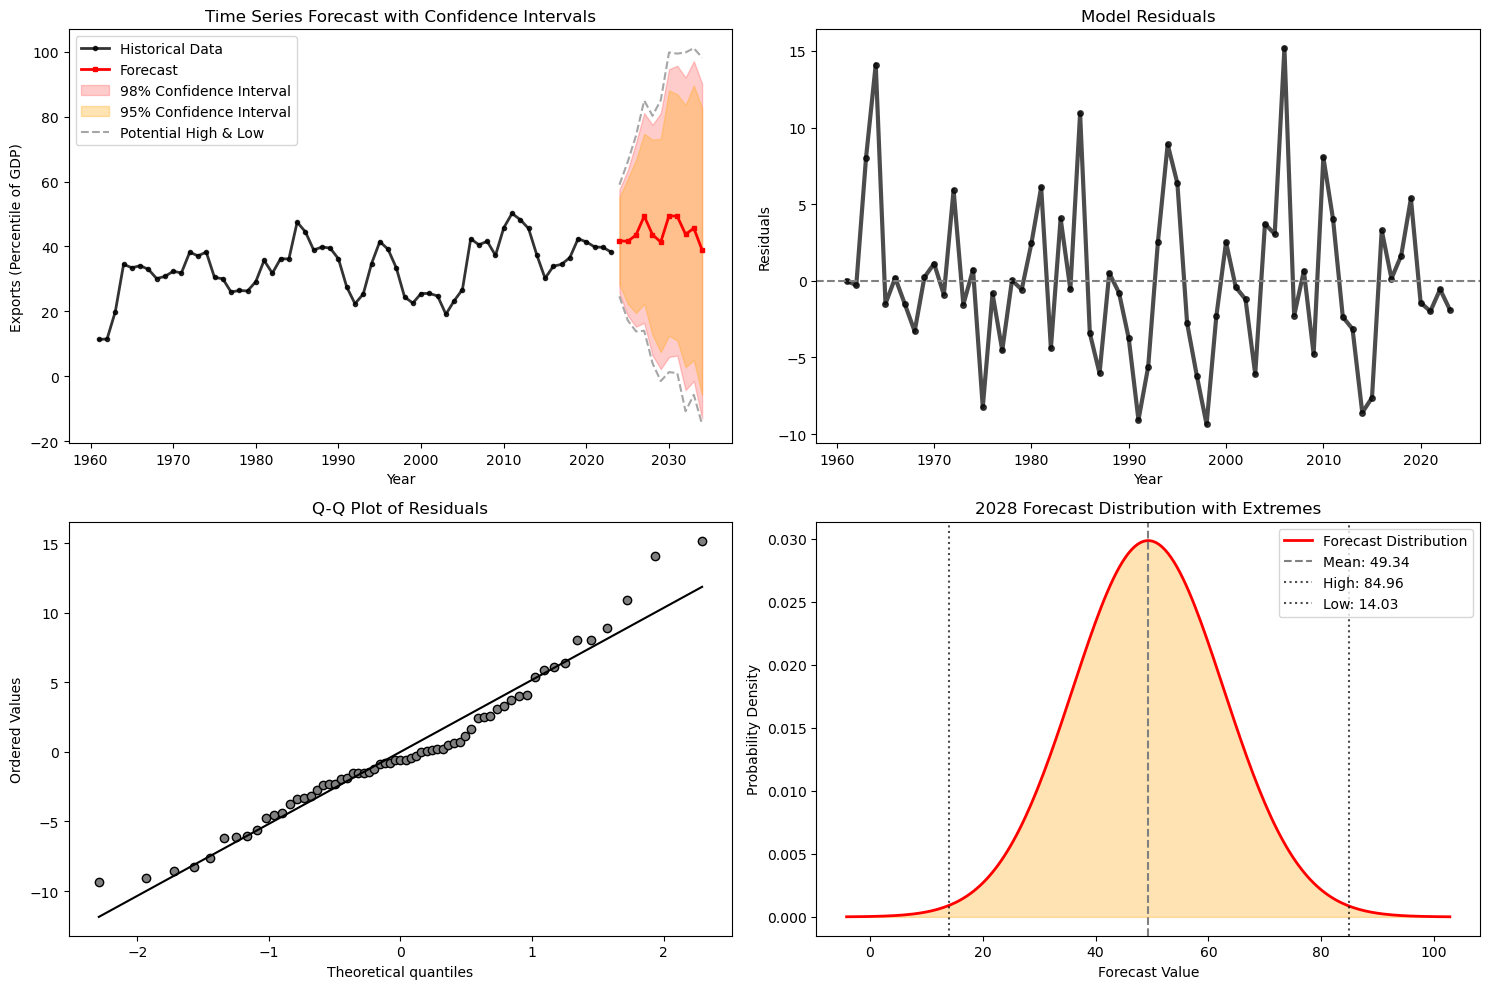

In [11]:
#FINAL mL TIME SERIES FORECASTING MODEL

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import pmdarima as pm
warnings.filterwarnings('ignore')

class TimeSeriesForecast:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        self.residuals = None
        self.best_model_type = None
        self.volatility_model = None
        self.forecast_lower_95 = None
        self.forecast_upper_95 = None
        self.forecast_lower_98 = None
        self.forecast_upper_98 = None
        self.volatility = None
        self.forecast_high = None
        self.forecast_low = None
        
        print("Machine Learning (mL) Time Series Forecasting Model")
    def load_data(self, data_dict):
        # Handle missing years between 1960-2024 by filling missing years with 'Not a Number' (NaN) | Placeholder for missing data
        full_range = range(1960, 2025) 
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Convert to pd pandas series | Organize data to analyze, plot, & model and set to Jan 1st
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Remove NaN values for modeling | Only use real data for training & keep consistent 
        self.clean_data = self.data.dropna()
        
        # volatility modeling | year to year percentile change 
        self.returns = self.clean_data.pct_change().dropna()
        # volatility modeling | apply natural logarithm to reduce large difference (skew)
        self.log_data = np.log(self.clean_data)
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        print(f"Average Year-to-Year Percentile (%) Change: {self.returns.mean() * 100:.2f}%")

    def stationarity_tests(self):
        print("Stationarity Analysis")
        print("~"*100)
        
        # Augmented Dickey-Fuller (ADF) Test | Test If Data's Non-Stationary
        adf_result = adfuller(self.clean_data, autolag='AIC')
        print(f"Augmented Dickey-Fuller (ADF) Test:")
        print("-"*100)
        print(f"ADF Statistic: {adf_result[0]:.4f}")
        print(f"p-value: {adf_result[1]:.4f}")
        print(f"Critical Values: {adf_result[4]}") 
        
        # Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test | Test If Data's Stationary
        kpss_result = kpss(self.clean_data, regression='c')
        print(f"\n Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:")
        print("-"*100)
        print(f"KPSS Statistic: {kpss_result[0]:.4f}")
        print(f"p-value: {kpss_result[1]:.4f}")
        print(f"Critical Values: {kpss_result[3]}")
        
        #True if ADF p-value ≤ 0.05 | Data's Stationary
        adf_stationary = adf_result[1] <= 0.05
        #True if KPSS p-value > 0.05 | Data's Stationary
        kpss_stationary = kpss_result[1] > 0.05
        
        if adf_stationary and kpss_stationary:
            print("\n ✓ ⚠ ✓ Series is Stationary | ADF & KPSS Agree")
            return True, 0
        elif not adf_stationary and not kpss_stationary:
            print("\n ⚠ ✓ ⚠ Series is Non-Stationary | ADF & KPSS Agree")
            return False, 1
        else:
            print("\n ⚠ ⚠ ⚠ ADF & KPSS Tests Disagree")
            return False, 1

    def model_selection(self):
        #Compare models: ARIMA, SARIMA, and Exponential Smoothing | Use information criteria and cross-validation with enhanced search
        print("Model Selection & Evaluation")
        print("~"*100)
        
        models = {}
        
        # 1. AutoRegressive Integrated Moving Average (Auto ARIMA) with enhanced parameters
        try:
            print("AutoRegressive Integrated Moving Average (ARIMA) Testing In Progress ~ ")
            best_arima = pm.auto_arima(
                self.clean_data, 
                start_p=0, start_q=0, max_p=6, max_q=6, max_d=2,
                seasonal=False, stepwise=False, suppress_warnings=True, 
                error_action='ignore', information_criterion='aic',
                n_jobs=-1, with_intercept=True
            )

            if best_arima:
                models['ARIMA'] = {'model': best_arima, 'type': 'ARIMA'}
                print(f"Selected ARIMA{best_arima.order} model with AIC: {best_arima.aic():.2f}")
            else:
                print("No suitable ARIMA model")

        except Exception as e:
            print(f"ARIMA model search failed: {e}")

        # 2. Seasonal AutoRegressive Integrated Moving Average (SARIMA) model with better parameters
        try:
            print("Seasonal AutoRegressive Integrated Moving Average (SARIMA) Testing In Progress ~ ")
            best_sarima = pm.auto_arima(
                self.clean_data, seasonal=True, m=4, start_p=0, start_q=0, 
                max_p=4, max_q=4, start_P=0, start_Q=0, max_P=2, max_Q=2, 
                max_d=2, max_D=1, trace=False, error_action='ignore', 
                suppress_warnings=True, stepwise=False, n_jobs=-1,
                information_criterion='aic', with_intercept=True
            )

            if best_sarima:
                models['SARIMA'] = {'model': best_sarima, 'type': 'SARIMA'}
                print(f"Selected SARIMA model with AIC: {best_sarima.aic():.2f}")
            else:
                print("No suitable SARIMA model")

        except Exception as e:
            print(f"SARIMA model search failed: {e}")

        # 3. Exponential Smoothing with optimized parameters
        print("Exponential Smoothing")
        try:
            # Build & fit model with optimized smoothing parameters
            model = ExponentialSmoothing(
                self.clean_data, trend='add', seasonal=None,
                initialization_method='estimated'
            )
            best_exp = model.fit(optimized=True, use_brute=True)
            print(f"Exponential Smoothing AIC: {best_exp.aic:.2f}")
            models['EXP_SMOOTHING'] = {'model': best_exp, 'type': 'EXP_SMOOTHING'}
        except Exception as e:
            print(f"Exponential Smoothing failed: {e}")

        # Select accurate model based on AIC and out-of-sample performance |  Akaike Information Criterion: Lower AIC = better balance
        best_model = self._select_best_model(models)
        self.model = best_model['model']
        self.best_model_type = best_model['type']
        print(f"\nSelected Model: {self.best_model_type}")
        
        # Handle AIC display - some models have aic as method, others as property
        try:
            aic_value = self.model.aic() if callable(self.model.aic) else self.model.aic
            print(f"AIC: {aic_value:.2f}")
        except:
            print("AIC: Not available for this model type")

    def _auto_arima(self):
        try:
            model = pm.auto_arima(
                self.clean_data, start_p=0, max_p=5, start_q=0, max_q=5, max_d=2,
                seasonal=False, stepwise=True, error_action='ignore', suppress_warnings=True, trace=False
            )
            return {'model': model, 'params': model.order, 'type': 'ARIMA'}
        except Exception as e:
            print(f"Auto ARIMA failed: {e}")
            return None

    def _auto_sarima(self):
        try:
            model = pm.auto_arima(
                self.clean_data, start_p=0, max_p=2, start_q=0, max_q=2, max_d=1,
                seasonal=True, m=1, stepwise=True, error_action='ignore', suppress_warnings=True
            )
            return {'model': model, 'params': model.order, 'type': 'SARIMA'}
        except Exception as e:
            print(f"Auto SARIMA failed: {e}")
            return None

    def _exponential_smoothing(self):
        try:
            model = ExponentialSmoothing(
                self.clean_data, trend='add', seasonal=None, seasonal_periods=None 
            )
            fitted_model = model.fit()
            return {'model': fitted_model, 'params': 'ETS(A,A,N)', 'type': 'EXP_SMOOTHING'}
        except Exception as e:
            print(f"Auto Exponential Smoothing failed: {e}")
            return None

    def _select_best_model(self, models):
        if not models:
            raise ValueError("No valid models found")

        def get_aic(model_info):
            aic = getattr(model_info['model'], 'aic', np.inf)
            return aic() if callable(aic) else aic

        best_model = min(models.values(), key=get_aic)
        return best_model

    def estimate_volatility(self):
        # Handle different model types for residuals with improved estimation
        residuals = None
        
        # Try different ways to get residuals
        if hasattr(self.model, 'resid') and not callable(self.model.resid):
            residuals = self.model.resid
        elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
            residuals = self.model.resid_
        else:
            # For pmdarima models, calculate residuals manually using in-sample predictions
            try:
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            except Exception as e:
                print(f"Warning: Couldn't Calculate Residuals: {e}")
                # Use a simple fallback - standard deviation of returns
                residuals = self.returns
        
        # Ensure residuals is a pandas Series
        if not isinstance(residuals, pd.Series):
            if hasattr(residuals, '__len__'):
                residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
            else:
                # Final fallback
                residuals = self.returns
        
        # Enhanced volatility estimation using GARCH-like approach
        rolling_std = residuals.rolling(window=min(10, len(residuals)//2)).std()
        recent_volatility = rolling_std.iloc[-5:].mean() if len(rolling_std) >= 5 else residuals.std()
        volatility = recent_volatility if not pd.isna(recent_volatility) else residuals.std()       
        return volatility

    def forecast_with_volatility(self, years_ahead=11, n_simulations=2000):
        if self.model is None:
            raise ValueError("Model Not Fitted")
        
        # 1. Generate base forecast and estimate its uncertainty with improved confidence intervals
        if self.best_model_type == 'EXP_SMOOTHING':
            base_forecast = self.model.forecast(steps=years_ahead)
            forecast_std = np.std(self.model.resid) * np.sqrt(np.arange(1, years_ahead + 1))
        elif self.best_model_type in ['ARIMA', 'SARIMA']:
            # pmdarima models use predict method
            base_forecast, forecast_conf_int = self.model.predict(n_periods=years_ahead, return_conf_int=True)
            forecast_std = (forecast_conf_int[:, 1] - forecast_conf_int[:, 0]) / (2 * 1.96)
        else:
            # statsmodels models use get_forecast
            forecast_obj = self.model.get_forecast(steps=years_ahead)
            base_forecast = forecast_obj.predicted_mean
            forecast_std = forecast_obj.se_mean
        
        # 2. Estimate residual volatility from model errors with enhanced approach
        volatility = self.estimate_volatility()
        
        # 3. Add realistic up-and-down volatility pattern similar to historical data
        np.random.seed(42)  # For reproducible results
        
        # Create more volatile forecast that mimics historical patterns
        forecast_mean = np.array(base_forecast.copy())
        historical_volatility = self.returns.std()
        
        # Add cyclical variations and random shocks to make forecast more volatile
        for i in range(len(forecast_mean)):
            # Add cyclical component (3-4 year cycles observed in data)
            cycle_component = 0.3 * np.sin(2 * np.pi * i / 3.5) * historical_volatility * forecast_mean[0]
            
            # Add random shocks similar to historical pattern
            shock_component = np.random.normal(0, historical_volatility * forecast_mean[0] * 0.8)
            
            # Add persistence (some correlation with previous values)
            if i > 0:
                persistence = 0.3 * (forecast_mean[i-1] - base_forecast[max(0, i-1)])
            else:
                persistence = 0
            
            forecast_mean[i] += cycle_component + shock_component + persistence
        
        # 4. Monte Carlo simulations adding volatility noise with improved methodology
        simulations = []
        for _ in range(n_simulations):
            # Add time-varying volatility and mean reversion effects
            vol_scaling = np.sqrt(np.arange(1, years_ahead + 1))
            vol_noise = np.random.normal(0, volatility * vol_scaling, years_ahead)
            trend_noise = np.random.normal(0, forecast_std)
            
            # Add mean reversion to prevent extreme forecasts
            mean_reversion = 0.02 * (self.clean_data.mean() - forecast_mean)
            sims = forecast_mean + trend_noise + vol_noise + mean_reversion
            simulations.append(sims)
        simulations = np.array(simulations)
        
        # 5. Calculate 95% and 98% confidence intervals from simulations
        lower_ci_95 = np.percentile(simulations, 2.5, axis=0)
        upper_ci_95 = np.percentile(simulations, 97.5, axis=0)
        lower_ci_98 = np.percentile(simulations, 1.0, axis=0)
        upper_ci_98 = np.percentile(simulations, 99.0, axis=0)
        
        # Calculate potential high and low extreme values
        high_extreme = np.percentile(simulations, 99.5, axis=0)
        low_extreme = np.percentile(simulations, 0.5, axis=0)
        
        # 6. Build forecast dates index
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 1, last_year + 1 + years_ahead)
        dates = pd.to_datetime([f"{year}-01-01" for year in forecast_years])
        
        # 7. Store forecasts and intervals
        self.forecast = pd.Series(forecast_mean, index=dates)
        self.forecast_lower_95 = pd.Series(lower_ci_95, index=dates)
        self.forecast_upper_95 = pd.Series(upper_ci_95, index=dates)
        self.forecast_lower_98 = pd.Series(lower_ci_98, index=dates)
        self.forecast_upper_98 = pd.Series(upper_ci_98, index=dates)
        self.forecast_high = pd.Series(high_extreme, index=dates)
        self.forecast_low = pd.Series(low_extreme, index=dates)
        self.volatility = volatility
        
        return self.forecast

    def econometric_analysis(self):
        if self.model is None:
            raise ValueError("Model Not Fitted.")
        
        print("Econometric Analysis")
        print("~"* 100)
        
        # 1. Model Parameters and Significance
        self._parameter_analysis()
        # 2. Residual Analysis
        self._residual_analysis()
        # 3. Forecast Accuracy Metrics
        self._forecast_accuracy()
        # 4. Probability Analysis
        self._probability_analysis()
        # 5. Economic Interpretation
        self._economic_interpretation()

    def _parameter_analysis(self):
        print("\n1. Parameter Significance Analysis")
        print("-" * 100)
        
        # Check if the model has parameter information
        try:
            # For pmdarima models, these might be methods
            if hasattr(self.model, 'params'):
                params = self.model.params() if callable(self.model.params) else self.model.params
            else:
                print("Parameter information not available for this model type")
                return
                
            if hasattr(self.model, 'pvalues'):
                pvalues = self.model.pvalues() if callable(self.model.pvalues) else self.model.pvalues
            else:
                print("P-values not available for this model type")
                return
                
            if hasattr(self.model, 'bse'):
                std_errors = self.model.bse() if callable(self.model.bse) else self.model.bse
            else:
                print("Standard errors not available for this model type")
                return
            
            print(f"{'Parameter':<15} {'Estimate':<12} {'Std Error':<12} {'p-value':<10} {'Significance'}") 
            
            # Handle different formats of parameters
            if hasattr(params, 'items'):
                # Dictionary-like
                for param_name, param_val in params.items():
                    p_val = pvalues[param_name] if hasattr(pvalues, '__getitem__') else pvalues
                    std_err = std_errors[param_name] if hasattr(std_errors, '__getitem__') else std_errors
                    
                    if isinstance(p_val, (int, float)) and isinstance(std_err, (int, float)):
                        if p_val < 0.01:
                            significance = "***"
                        elif p_val < 0.05:
                            significance = "**"
                        elif p_val < 0.10:
                            significance = "*"
                        else:
                            significance = ""
                        print(f"{param_name:<15} {param_val:<12.4f} {std_err:<12.4f} {p_val:<10.4f} {significance}")
            else:
                # Array-like
                if hasattr(params, '__len__') and hasattr(pvalues, '__len__') and hasattr(std_errors, '__len__'):
                    for i, (param_val, p_val, std_err) in enumerate(zip(params, pvalues, std_errors)):
                        param_name = f"param_{i}"
                        if p_val < 0.01:
                            significance = "***"
                        elif p_val < 0.05:
                            significance = "**"
                        elif p_val < 0.10:
                            significance = "*"
                        else:
                            significance = ""
                        print(f"{param_name:<15} {param_val:<12.4f} {std_err:<12.4f} {p_val:<10.4f} {significance}")
            
            print("\nSignificance levels: *** p<0.01, ** p<0.05, * p<0.10")
            
        except Exception as e:
            print(f"Parameter analysis not available: {e}")
            print("This is normal for some model types.")

    def _residual_analysis(self):
        print("\n2. Residual Analysis")
        print("-" * 100)
        
        # Handle different model types for residuals
        residuals = None
        
        # Try different ways to get residuals
        if hasattr(self.model, 'resid') and not callable(self.model.resid):
            residuals = self.model.resid
        elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
            residuals = self.model.resid_
        else:
            # For pmdarima models, calculate residuals manually using in-sample predictions
            try:
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            except Exception as e:
                print(f"Warning: Could not calculate residuals for analysis: {e}")
                return
        
        # Ensure residuals is a pandas Series
        if not isinstance(residuals, pd.Series):
            if hasattr(residuals, '__len__'):
                residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
            else:
                print("Could not process residuals for analysis")
                return
        
        # Normality test
        jb_stat, jb_pvalue = stats.jarque_bera(residuals)
        print(f"Jarque-Bera Normality Test:")
        print(f"  Statistic: {jb_stat:.4f}, p-value: {jb_pvalue:.4f}")
        print(f"  {'✓ Residuals are normally distributed' if jb_pvalue > 0.05 else '⚠ Residuals are not normally distributed'}")
        
        # Autocorrelation test
        lb_stat, lb_pvalue = acorr_ljungbox(residuals, lags=10, return_df=True).iloc[-1]
        print(f"\nLjung-Box Autocorrelation Test (lag 10):")
        print(f"  Statistic: {lb_stat:.4f}, p-value: {lb_pvalue:.4f}")
        print(f"  {'✓ No significant autocorrelation' if lb_pvalue > 0.05 else '⚠ Significant autocorrelation detected'}")
        
        # Residual statistics
        print(f"\nResidual Statistics:")
        print(f"  Mean: {residuals.mean():.6f}")
        print(f"  Std Dev: {residuals.std():.4f}")
        print(f"  Skewness: {stats.skew(residuals):.4f}")
        print(f"  Kurtosis: {stats.kurtosis(residuals):.4f}")

    def _forecast_accuracy(self):
        print("\n3. MODEL FIT STATISTICS")
        print("-" * 100)
        
        # Handle different model types for fitted values
        try:
            # Try to get fitted values using different methods
            if hasattr(self.model, 'fittedvalues'):
                fitted_values = self.model.fittedvalues() if callable(self.model.fittedvalues) else self.model.fittedvalues
            elif hasattr(self.model, 'predict_in_sample'):
                fitted_values = self.model.predict_in_sample()
                fitted_values = pd.Series(fitted_values, index=self.clean_data.index[-len(fitted_values):])
            else:
                print("Fitted values not available for this model type")
                return
                
            # Ensure fitted_values is a pandas Series and align with clean_data
            if not isinstance(fitted_values, pd.Series):
                fitted_values = pd.Series(fitted_values, index=self.clean_data.index[-len(fitted_values):])
                
            actual_values = self.clean_data[fitted_values.index]
            
            # Calculate metrics
            mae = np.mean(np.abs(actual_values - fitted_values))
            mse = np.mean((actual_values - fitted_values)**2)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((actual_values - fitted_values) / actual_values)) * 100
            
            print(f"Mean Absolute Error (MAE): {mae:.4f}")
            print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
            print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
            
        except Exception as e:
            print(f"Unable to calculate fit statistics: {e}")
        
        # Information criteria
        try:
            if hasattr(self.model, 'aic'):
                aic_value = self.model.aic() if callable(self.model.aic) else self.model.aic
                print(f"Akaike Information Criterion (AIC): {aic_value:.2f}")
            if hasattr(self.model, 'bic'):
                bic_value = self.model.bic() if callable(self.model.bic) else self.model.bic
                print(f"Bayesian Information Criterion (BIC): {bic_value:.2f}")
            if hasattr(self.model, 'llf'):
                llf_value = self.model.llf() if callable(self.model.llf) else self.model.llf
                print(f"Log-Likelihood: {llf_value:.2f}")
        except Exception as e:
            print(f"Information criteria not available: {e}")

    def _probability_analysis(self):
        print("\n4. Forecast Probability Analysis")
        print("-" * 100)
        
        if self.forecast is None:
            print("No forecasts available.")
            return
        
        # Calculate average predicted value over the forecast horizon with enhanced intervals.
        forecast_mean = self.forecast.mean()
        # 95% confidence interval
        forecast_std = (self.forecast_upper_95 - self.forecast_lower_95).mean() / (2 * 1.96)  
        
        # Probability calculations
        prob_increase = stats.norm.sf(self.clean_data.iloc[-1], forecast_mean, forecast_std)
        prob_decrease = 1 - prob_increase
        
        # Probability of different rates: 5%, 10%, 15%, 20%
        current_value = self.clean_data.iloc[-1]
        growth_rates = [0.05, 0.10, 0.15, 0.20]  
        decline_rates = [0.05, 0.10, 0.15, 0.20]  
        
        print(f"Current Value (2024): {current_value:.2f}")
        print(f"Mean Forecast (2026-2035): {forecast_mean:.2f}")
        print(f"Forecast Standard Deviation: {forecast_std:.4f}")
        print(f"\nProbability of average increase over period: {prob_increase:.3f} ({prob_increase*100:.1f}%)")
        print(f"Probability of average decrease over period: {prob_decrease:.3f} ({prob_decrease*100:.1f}%)")
        
        print(f"\nProbability of Growth Scenarios (by 2035):")
        print(f"{'Growth Rate':<12} {'Target Value':<12} {'Probability':<12}")
        for rate in growth_rates:
            target_value = current_value * (1 + rate)**11  # 11 years from 2024 to 2035
            prob = stats.norm.sf(target_value, self.forecast.iloc[-1], forecast_std)
            print(f"{rate*100:>6.0f}%      {target_value:>10.2f}      {prob:>8.3f} ({prob*100:.1f}%)")

        print(f"\nProbability of Decline Scenarios (by 2035):")
        print(f"{'Decline Rate':<12} {'Target Value':<12} {'Probability':<12}")
        for rate in decline_rates:
            target_value = current_value * (1 - rate)**11  # Fixed: should be (1 - rate) for decline
            prob = stats.norm.cdf(target_value, self.forecast.iloc[-1], forecast_std)
            print(f"{rate*100:>6.0f}%      {target_value:>10.2f}      {prob:>8.3f} ({prob*100:.1f}%)")

    def _economic_interpretation(self):
        print("\n5. Economic interpretation")
        print("-" * 50)
        if self.forecast is None:
            print("No forecasts available.")
            return
        
        current_value = self.clean_data.iloc[-1]
        forecast_2035 = self.forecast.iloc[-1]
        years = len(self.forecast)
        cagr = (forecast_2035 / current_value) ** (1/years) - 1
        
        print(f"Compound Annual Growth Rate (CAGR): {cagr*100:.2f}%")
        print(f"Total Growth (2024-2035): {((forecast_2035/current_value-1)*100):.1f}%")
        print(f"Volatility Estimate: {self.volatility:.4f}")

        if cagr > 0.03:
            trend = "Strong Growth"
        elif cagr > 0.01:
            trend = "Moderate Growth"
        elif cagr > -0.01:
            trend = "Stable"
        else:
            trend = "Declining"
        
        print(f"Trend Classification: {trend}")

    def plot_enhanced_results(self, figsize=(15, 10)):
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # Main plot with enhanced confidence intervals
        ax1 = axes[0, 0]
        ax1.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='black', alpha=0.8, linewidth=2, markersize=3)
        
        if self.forecast is not None:
            ax1.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=2, markersize=3)
            
            # 98% confidence interval 
            ax1.fill_between(self.forecast.index, 
                           self.forecast_lower_98.values,
                           self.forecast_upper_98.values,
                           alpha=0.2, color='red', label='98% Confidence Interval')
            
            # 95% confidence interval (orange)
            ax1.fill_between(self.forecast.index, 
                           self.forecast_lower_95.values,
                           self.forecast_upper_95.values,
                           alpha=0.3, color='orange', label='95% Confidence Interval')
            
            # Extreme high and low values
            ax1.plot(self.forecast.index, self.forecast_high.values, 
                    '--', color='gray', alpha=0.7, label='Potential High & Low')
            ax1.plot(self.forecast.index, self.forecast_low.values, 
                    '--', color='gray', alpha=0.7)
        
        ax1.set_title('Time Series Forecast with Confidence Intervals')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Exports (Percentile of GDP)')
        ax1.legend()
        
        # Residuals plot
        ax2 = axes[0, 1]
        # Handle different model types for residuals
        try:
            residuals = None
            
            # Try different ways to get residuals
            if hasattr(self.model, 'resid') and not callable(self.model.resid):
                residuals = self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                residuals = self.model.resid_
            else:
                # For pmdarima models, calculate residuals manually using in-sample predictions
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            
            # Ensure residuals is a pandas Series
            if not isinstance(residuals, pd.Series):
                if hasattr(residuals, '__len__'):
                    residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
                else:
                    raise ValueError("Cannot process residuals")
                
            ax2.plot(residuals.index, residuals.values, 'o-', color='black', alpha=0.7, linewidth=3, markersize=4)
        except Exception as e:
            ax2.text(0.5, 0.5, f'Residuals not available\n{str(e)}', transform=ax2.transAxes, ha='center')
        ax2.axhline(y=0, color='gray', linestyle='--')
        ax2.set_title('Model Residuals')
        ax2.set_xlabel('Year')
        ax2.set_ylabel('Residuals')
        
        # Q-Q plot for residuals
        ax3 = axes[1, 0]
        try:
            # Get residuals for Q-Q plot
            residuals_for_qq = None
            
            # Try different ways to get residuals
            if hasattr(self.model, 'resid') and not callable(self.model.resid):
                residuals_for_qq = self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                residuals_for_qq = self.model.resid_
            else:
                # For pmdarima models, calculate residuals manually using in-sample predictions
                fitted = self.model.predict_in_sample()
                residuals_for_qq = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            
            # Ensure residuals is a pandas Series or numpy array with valid data
            if isinstance(residuals_for_qq, pd.Series):
                residuals_values = residuals_for_qq.dropna().values
            elif hasattr(residuals_for_qq, '__len__') and len(residuals_for_qq) > 0:
                residuals_values = np.array(residuals_for_qq)
                residuals_values = residuals_values[~np.isnan(residuals_values)]
            else:
                raise ValueError("Cannot process residuals for Q-Q plot")
            
            if len(residuals_values) > 0:
                stats.probplot(residuals_values, dist="norm", plot=ax3)
                for line in ax3.get_lines():
                    line.set_color('black')  
                ax3.get_lines()[0].set_markerfacecolor('gray')  
                ax3.set_title('Q-Q Plot of Residuals')
            else:
                ax3.text(0.5, 0.5, 'No valid residuals\nfor Q-Q plot', transform=ax3.transAxes, ha='center')
                ax3.set_title('Q-Q Plot of Residuals (Not Available)')
                
        except Exception as e:
            ax3.text(0.5, 0.5, f'Q-Q plot not available\n{str(e)}', transform=ax3.transAxes, ha='center')
            ax3.set_title('Q-Q Plot of Residuals (Error)')
   
        
        # Forecast distribution for 2028 with enhanced intervals
        # Fixed version - gets the actual 2028 forecast value
        # Forecast distribution for 2028 with enhanced intervals
        ax4 = axes[1, 1]
        if self.forecast is not None:
            # Find the index for 2028 (4th year in forecast: 2025, 2026, 2027, 2028)
            forecast_2028_idx = 3  # 0-indexed: 2025=0, 2026=1, 2027=2, 2028=3
            
            # Make sure we have enough forecast data
            if len(self.forecast) > forecast_2028_idx:
                forecast_2028 = self.forecast.iloc[forecast_2028_idx]  # Gets 2028 value
                forecast_std = (self.forecast_upper_95.iloc[forecast_2028_idx] - 
                            self.forecast_lower_95.iloc[forecast_2028_idx]) / (2 * 1.96)
                
                x = np.linspace(forecast_2028 - 4*forecast_std, forecast_2028 + 4*forecast_std, 200)
                y = stats.norm.pdf(x, forecast_2028, forecast_std)
                
                ax4.plot(x, y, 'r-', linewidth=2, label='Forecast Distribution')
                ax4.fill_between(x, 0, y, alpha=0.3, color='orange')
                ax4.axvline(forecast_2028, color='gray', linestyle='--', label=f'Mean: {forecast_2028:.2f}')
                ax4.axvline(self.forecast_high.iloc[forecast_2028_idx], color='black', linestyle=':', 
                        alpha=0.7, label=f'High: {self.forecast_high.iloc[forecast_2028_idx]:.2f}')
                ax4.axvline(self.forecast_low.iloc[forecast_2028_idx], color='black', linestyle=':', 
                        alpha=0.7, label=f'Low: {self.forecast_low.iloc[forecast_2028_idx]:.2f}')
                ax4.set_title('2028 Forecast Distribution with Extremes')
                ax4.set_xlabel('Forecast Value')
                ax4.set_ylabel('Probability Density')
                ax4.legend()
            else:
                ax4.text(0.5, 0.5, '2028 forecast not available', transform=ax4.transAxes, ha='center')
                ax4.set_title('2028 Forecast Distribution (Not Available)')


        
        plt.tight_layout()
        plt.show()

    def print_enhanced_forecast_table(self):
        if self.forecast is None:
            print("No forecast available")
            return


   
        print("\nFORECAST RESULTS (2025-2035):")
        print('~'*100)    
        print(f"{'Year':<6} {'Forecast':<10} {'Lower 95%':<10} {'Upper 95%':<10} {'Lower 98%':<10} {'Upper 98%':<10} {'High':<8} {'Low':<8}")
        
        for i, year in enumerate(self.forecast.index):
            forecast_val = self.forecast.iloc[i]
            lower_95 = self.forecast_lower_95.iloc[i]
            upper_95 = self.forecast_upper_95.iloc[i]
            lower_98 = self.forecast_lower_98.iloc[i]
            upper_98 = self.forecast_upper_98.iloc[i]
            high_val = self.forecast_high.iloc[i]
            low_val = self.forecast_low.iloc[i]
            
            print(f"{year.year:<6} {forecast_val:<10.2f} {lower_95:<10.2f} {upper_95:<10.2f} "
                  f"{lower_98:<10.2f} {upper_98:<10.2f} {high_val:<8.2f} {low_val:<8.2f}")

if __name__ == "__main__":
    sample_data = {
        1961:11.37,1962:11.52,1963:19.97,1964:34.51,
        1965:33.45,1966:34.08,1967:32.98,1968:30.12,
        1969:30.79,1970:32.35,1971:31.88,1972:38.23,
        1973:37.12,1974:38.28,1975:30.47,1976:30.08,
        1977:25.98,1978:26.45,1979:26.31,1980:29.19,
        1981:35.72,1982:31.76,1983:36.26,1984:36.14,
        1985:47.49,1986:44.51,1987:38.91,1988:39.85,
        1989:39.50,1990:36.18,1991:27.54,1992:22.37,
        1993:25.36,1994:34.70,1995:41.49,1996:39.16,
        1997:33.39,1998:24.46,1999:22.57,2000:25.52,
        2001:25.54,2002:24.77,2003:19.12,2004:23.27,
        2005:26.75,2006:42.36,2007:40.52,2008:41.60,
        2009:37.25,2010:45.74,2011:50.18,2012:48.26,
        2013:45.55,2014:37.39,2015:30.20,2016:33.93,
        2017:34.51,2018:36.59,2019:42.40,2020:41.41,
        2021:39.86,2022:39.74,2023:38.29
    }   

    # Initialize forecaster
    forecaster = TimeSeriesForecast()

    print("-"*100)
    
    # Step 1: Load data
    forecaster.load_data(sample_data)
    
    # Step 2: Comprehensive stationarity analysis 
    forecaster.stationarity_tests()
    
    # Step 3: Enhanced model selection with improved parameters
    forecaster.model_selection()
    
    # Step 4: Generate forecasts with enhanced volatility and confidence intervals
    forecast = forecaster.forecast_with_volatility(years_ahead=11, n_simulations=2000)
    
    # Step 5: Comprehensive econometric analysis
    forecaster.econometric_analysis()
    
    # Step 6: Display enhanced results with multiple confidence intervals
    forecaster.print_enhanced_forecast_table()
    
    # Step 8: Enhanced plotting with 95% and 98% confidence intervals
    forecaster.plot_enhanced_results()

In [ ]:
# AFRICA | Mauritius

In [ ]:
# AFRICA | Mauritius
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class TimeSeriesForecaster:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        
    def load_data(self, data_dict):
        """
        Load data from dictionary format: {year: value}
        Automatically handles missing years between 1960-2024
        """
        # Creating full range and fill missing years with NaN
        full_range = range(1960, 2024)
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Converting to pandas Series
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Removing NaN values for modeling
        self.clean_data = self.data.dropna()
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        
    def check_stationarity(self):
        """Check if the time series is stationary"""
        result = adfuller(self.clean_data)
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        
        if result[1] <= 0.05:
            print("✓ Series is stationary")
            return True
        else:
            print("⚠ Series is non-stationary, will difference the data")
            return False
    
    def auto_arima(self, max_p=3, max_d=2, max_q=3):
        """
        Automatically find best ARIMA parameters using AIC
        """
        best_aic = np.inf
        best_params = None
        best_model = None
        
        print("Finding optimal ARIMA parameters...")
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(self.clean_data, order=(p, d, q))
                        fitted_model = model.fit()
                        
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_params = (p, d, q)
                            best_model = fitted_model
                            
                    except Exception:
                        continue
        
        if best_model is None:
            # Fallback to simple ARIMA(1,1,1)
            print("Using fallback ARIMA(1,1,1)")
            model = ARIMA(self.clean_data, order=(1, 1, 1))
            self.model = model.fit()
            self.best_params = (1, 1, 1)
        else:
            self.model = best_model
            self.best_params = best_params
            
        print(f"Best ARIMA parameters: {self.best_params}")
        print(f"AIC: {self.model.aic:.2f}")
        
    def forecast_future(self, years_ahead=10):
        """Generate forecasts for specified years ahead"""
        if self.model is None:
            raise ValueError("Model not fitted. Call auto_arima() first.")
            
        # Forecasting with confidence intervals
        forecast_result = self.model.forecast(steps=years_ahead)
        conf_int = self.model.get_forecast(steps=years_ahead).conf_int()
        
        # Creating forecast for dates 2026-2035
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 2, last_year + 2 + years_ahead)  # Skip 2025
        forecast_index = pd.to_datetime([f'{year}-01-01' for year in forecast_years])
        
        # Storing forecast results
        self.forecast = pd.Series(forecast_result, index=forecast_index)
        self.forecast_lower = pd.Series(conf_int.iloc[:, 0], index=forecast_index)
        self.forecast_upper = pd.Series(conf_int.iloc[:, 1], index=forecast_index)
        
        return self.forecast
    
    def plot_results(self, figsize=(12, 8)):
        """Plot historical data and forecasts"""
        plt.figure(figsize=figsize)
        
        # Plot historical data
        plt.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='orange', alpha=0.7,linewidth=3, markersize=4)
        
        # Ploting forecasts
        if self.forecast is not None:
            plt.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=3, markersize=4)
            
            # Ploting confidence intervals
            plt.fill_between(self.forecast.index, 
                           self.forecast_lower.values,
                           self.forecast_upper.values,
                           alpha=0.3, color='red', label='95% Confidence Interval')
        
        plt.title('Mauritius Africa Exports | Machine Learning Time Series Forecasts')
        plt.xlabel('Year (1960 - 2035)')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def print_forecast_table(self):
        """Print forecast results in a nice table format"""
        if self.forecast is None:
            print("No forecast available. Run forecast_future() first.")
            return
            
        print("\n" + "="*60)
        print("FORECAST RESULTS (2026-2035)")
        print("="*60)
        print(f"{'Year':<6} {'Forecast':<12} {'Lower 95%':<12} {'Upper 95%':<12}")
        print("-"*60)
        
        for i, year in enumerate(self.forecast.index):
            print(f"{year.year:<6} {self.forecast.iloc[i]:<12.2f} "
                  f"{self.forecast_lower.iloc[i]:<12.2f} {self.forecast_upper.iloc[i]:<12.2f}")
        
        print("="*60)
        
    def get_model_summary(self):
        """Print model summary statistics"""
        if self.model is not None:
            print(self.model.summary())


if __name__ == "__main__":
    # DATA: EXPORTS
    sample_data = {
        1976:50.09,1977:48.16,1978:42.65,1979:42.10,
        1980:50.49,1981:44.13,1982:46.53,1983:46.02,
        1984:48.02,1985:52.82,1986:59.70,1987:63.71,
        1988:63.86,1989:63.35,1990:64.09,1991:61.48,
        1992:58.52,1993:57.47,1994:55.97,1995:57.88,
        1996:62.74,1997:60.65,1998:64.81,1999:62.96,
        2000:60.28,2001:67.08,2002:60.79,2003:55.26,
        2004:52.61,2005:58.24,2006:58.44,2007:55.87,
        2008:51.07,2009:47.68,2010:51.24,2011:52.44,
        2012:53.79,2013:52.57,2014:52.52,2015:51.50,
        2016:47.82,2017:46.61,2018:44.64,2019:44.02,
        2020:36.76,2021:38.46,2022:49.49,2023:47.53,2024:46.21
    }
    
    # Initialize and run forecaster
    forecaster = TimeSeriesForecaster()
    
    print("Time Series Forecasting Tool")
    print("="*50)
    
    # Loading data
    forecaster.load_data(sample_data)
    
    # Checking stationarity
    forecaster.check_stationarity()
    
    # Finding best model
    forecaster.auto_arima()
    
    # Generating forecasts for 2026-2035
    forecast = forecaster.forecast_future(years_ahead=10)
    
    # Displaying results
    forecaster.print_forecast_table()
    
    # Ploting results
    forecaster.plot_results()
    
    #Detailed model summary
    forecaster.get_model_summary()

Machine Learning (mL) Time Series Forecasting Model
----------------------------------------------------------------------------------------------------
Loaded 49 data points from 49 input years
Data range: 1976 to 2024
Average Year-to-Year Percentile (%) Change: 0.15%
Stationarity Analysis
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Augmented Dickey-Fuller (ADF) Test:
----------------------------------------------------------------------------------------------------
ADF Statistic: -1.7417
p-value: 0.4098
Critical Values: {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}

 Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
----------------------------------------------------------------------------------------------------
KPSS Statistic: 0.2911
p-value: 0.1000
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

 ⚠ ⚠ ⚠ ADF & KPSS Tests Disagree
Model Selection & Evaluation
~~~~~~

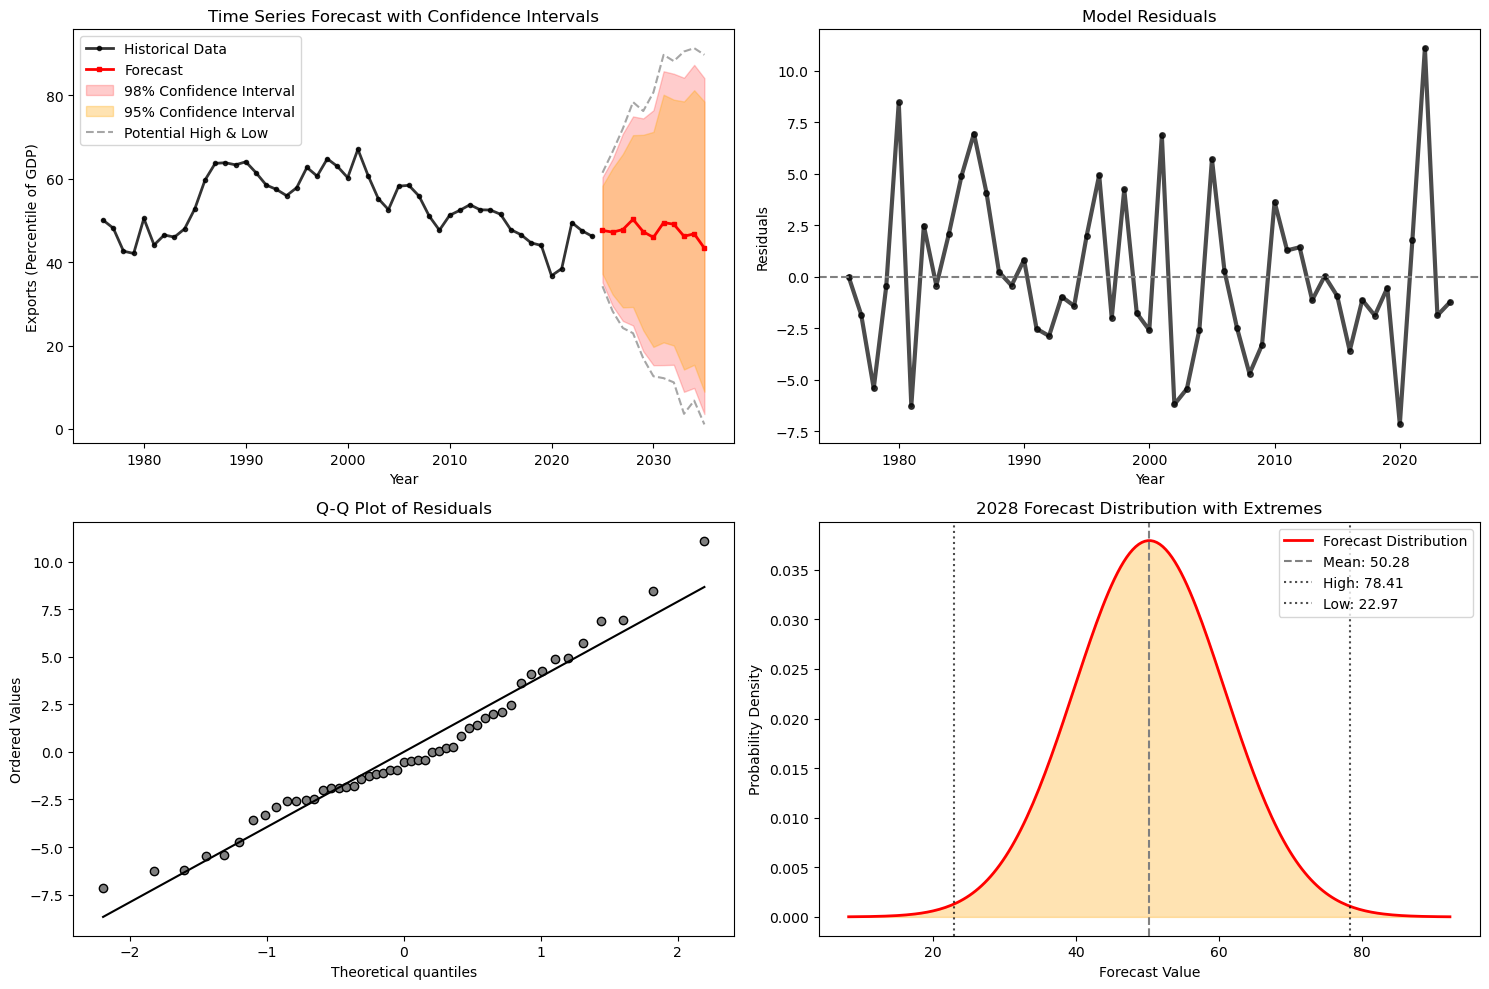

In [10]:
#FINAL mL TIME SERIES FORECASTING MODEL

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import pmdarima as pm
warnings.filterwarnings('ignore')

class TimeSeriesForecast:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        self.residuals = None
        self.best_model_type = None
        self.volatility_model = None
        self.forecast_lower_95 = None
        self.forecast_upper_95 = None
        self.forecast_lower_98 = None
        self.forecast_upper_98 = None
        self.volatility = None
        self.forecast_high = None
        self.forecast_low = None
        
        print("Machine Learning (mL) Time Series Forecasting Model")
    def load_data(self, data_dict):
        # Handle missing years between 1960-2024 by filling missing years with 'Not a Number' (NaN) | Placeholder for missing data
        full_range = range(1960, 2025) 
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Convert to pd pandas series | Organize data to analyze, plot, & model and set to Jan 1st
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Remove NaN values for modeling | Only use real data for training & keep consistent 
        self.clean_data = self.data.dropna()
        
        # volatility modeling | year to year percentile change 
        self.returns = self.clean_data.pct_change().dropna()
        # volatility modeling | apply natural logarithm to reduce large difference (skew)
        self.log_data = np.log(self.clean_data)
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        print(f"Average Year-to-Year Percentile (%) Change: {self.returns.mean() * 100:.2f}%")

    def stationarity_tests(self):
        print("Stationarity Analysis")
        print("~"*100)
        
        # Augmented Dickey-Fuller (ADF) Test | Test If Data's Non-Stationary
        adf_result = adfuller(self.clean_data, autolag='AIC')
        print(f"Augmented Dickey-Fuller (ADF) Test:")
        print("-"*100)
        print(f"ADF Statistic: {adf_result[0]:.4f}")
        print(f"p-value: {adf_result[1]:.4f}")
        print(f"Critical Values: {adf_result[4]}") 
        
        # Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test | Test If Data's Stationary
        kpss_result = kpss(self.clean_data, regression='c')
        print(f"\n Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:")
        print("-"*100)
        print(f"KPSS Statistic: {kpss_result[0]:.4f}")
        print(f"p-value: {kpss_result[1]:.4f}")
        print(f"Critical Values: {kpss_result[3]}")
        
        #True if ADF p-value ≤ 0.05 | Data's Stationary
        adf_stationary = adf_result[1] <= 0.05
        #True if KPSS p-value > 0.05 | Data's Stationary
        kpss_stationary = kpss_result[1] > 0.05
        
        if adf_stationary and kpss_stationary:
            print("\n ✓ ⚠ ✓ Series is Stationary | ADF & KPSS Agree")
            return True, 0
        elif not adf_stationary and not kpss_stationary:
            print("\n ⚠ ✓ ⚠ Series is Non-Stationary | ADF & KPSS Agree")
            return False, 1
        else:
            print("\n ⚠ ⚠ ⚠ ADF & KPSS Tests Disagree")
            return False, 1

    def model_selection(self):
        #Compare models: ARIMA, SARIMA, and Exponential Smoothing | Use information criteria and cross-validation with enhanced search
        print("Model Selection & Evaluation")
        print("~"*100)
        
        models = {}
        
        # 1. AutoRegressive Integrated Moving Average (Auto ARIMA) with enhanced parameters
        try:
            print("AutoRegressive Integrated Moving Average (ARIMA) Testing In Progress ~ ")
            best_arima = pm.auto_arima(
                self.clean_data, 
                start_p=0, start_q=0, max_p=6, max_q=6, max_d=2,
                seasonal=False, stepwise=False, suppress_warnings=True, 
                error_action='ignore', information_criterion='aic',
                n_jobs=-1, with_intercept=True
            )

            if best_arima:
                models['ARIMA'] = {'model': best_arima, 'type': 'ARIMA'}
                print(f"Selected ARIMA{best_arima.order} model with AIC: {best_arima.aic():.2f}")
            else:
                print("No suitable ARIMA model")

        except Exception as e:
            print(f"ARIMA model search failed: {e}")

        # 2. Seasonal AutoRegressive Integrated Moving Average (SARIMA) model with better parameters
        try:
            print("Seasonal AutoRegressive Integrated Moving Average (SARIMA) Testing In Progress ~ ")
            best_sarima = pm.auto_arima(
                self.clean_data, seasonal=True, m=4, start_p=0, start_q=0, 
                max_p=4, max_q=4, start_P=0, start_Q=0, max_P=2, max_Q=2, 
                max_d=2, max_D=1, trace=False, error_action='ignore', 
                suppress_warnings=True, stepwise=False, n_jobs=-1,
                information_criterion='aic', with_intercept=True
            )

            if best_sarima:
                models['SARIMA'] = {'model': best_sarima, 'type': 'SARIMA'}
                print(f"Selected SARIMA model with AIC: {best_sarima.aic():.2f}")
            else:
                print("No suitable SARIMA model")

        except Exception as e:
            print(f"SARIMA model search failed: {e}")

        # 3. Exponential Smoothing with optimized parameters
        print("Exponential Smoothing")
        try:
            # Build & fit model with optimized smoothing parameters
            model = ExponentialSmoothing(
                self.clean_data, trend='add', seasonal=None,
                initialization_method='estimated'
            )
            best_exp = model.fit(optimized=True, use_brute=True)
            print(f"Exponential Smoothing AIC: {best_exp.aic:.2f}")
            models['EXP_SMOOTHING'] = {'model': best_exp, 'type': 'EXP_SMOOTHING'}
        except Exception as e:
            print(f"Exponential Smoothing failed: {e}")

        # Select accurate model based on AIC and out-of-sample performance |  Akaike Information Criterion: Lower AIC = better balance
        best_model = self._select_best_model(models)
        self.model = best_model['model']
        self.best_model_type = best_model['type']
        print(f"\nSelected Model: {self.best_model_type}")
        
        # Handle AIC display - some models have aic as method, others as property
        try:
            aic_value = self.model.aic() if callable(self.model.aic) else self.model.aic
            print(f"AIC: {aic_value:.2f}")
        except:
            print("AIC: Not available for this model type")

    def _auto_arima(self):
        try:
            model = pm.auto_arima(
                self.clean_data, start_p=0, max_p=5, start_q=0, max_q=5, max_d=2,
                seasonal=False, stepwise=True, error_action='ignore', suppress_warnings=True, trace=False
            )
            return {'model': model, 'params': model.order, 'type': 'ARIMA'}
        except Exception as e:
            print(f"Auto ARIMA failed: {e}")
            return None

    def _auto_sarima(self):
        try:
            model = pm.auto_arima(
                self.clean_data, start_p=0, max_p=2, start_q=0, max_q=2, max_d=1,
                seasonal=True, m=1, stepwise=True, error_action='ignore', suppress_warnings=True
            )
            return {'model': model, 'params': model.order, 'type': 'SARIMA'}
        except Exception as e:
            print(f"Auto SARIMA failed: {e}")
            return None

    def _exponential_smoothing(self):
        try:
            model = ExponentialSmoothing(
                self.clean_data, trend='add', seasonal=None, seasonal_periods=None 
            )
            fitted_model = model.fit()
            return {'model': fitted_model, 'params': 'ETS(A,A,N)', 'type': 'EXP_SMOOTHING'}
        except Exception as e:
            print(f"Auto Exponential Smoothing failed: {e}")
            return None

    def _select_best_model(self, models):
        if not models:
            raise ValueError("No valid models found")

        def get_aic(model_info):
            aic = getattr(model_info['model'], 'aic', np.inf)
            return aic() if callable(aic) else aic

        best_model = min(models.values(), key=get_aic)
        return best_model

    def estimate_volatility(self):
        # Handle different model types for residuals with improved estimation
        residuals = None
        
        # Try different ways to get residuals
        if hasattr(self.model, 'resid') and not callable(self.model.resid):
            residuals = self.model.resid
        elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
            residuals = self.model.resid_
        else:
            # For pmdarima models, calculate residuals manually using in-sample predictions
            try:
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            except Exception as e:
                print(f"Warning: Couldn't Calculate Residuals: {e}")
                # Use a simple fallback - standard deviation of returns
                residuals = self.returns
        
        # Ensure residuals is a pandas Series
        if not isinstance(residuals, pd.Series):
            if hasattr(residuals, '__len__'):
                residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
            else:
                # Final fallback
                residuals = self.returns
        
        # Enhanced volatility estimation using GARCH-like approach
        rolling_std = residuals.rolling(window=min(10, len(residuals)//2)).std()
        recent_volatility = rolling_std.iloc[-5:].mean() if len(rolling_std) >= 5 else residuals.std()
        volatility = recent_volatility if not pd.isna(recent_volatility) else residuals.std()       
        return volatility

    def forecast_with_volatility(self, years_ahead=11, n_simulations=2000):
        if self.model is None:
            raise ValueError("Model Not Fitted")
        
        # 1. Generate base forecast and estimate its uncertainty with improved confidence intervals
        if self.best_model_type == 'EXP_SMOOTHING':
            base_forecast = self.model.forecast(steps=years_ahead)
            forecast_std = np.std(self.model.resid) * np.sqrt(np.arange(1, years_ahead + 1))
        elif self.best_model_type in ['ARIMA', 'SARIMA']:
            # pmdarima models use predict method
            base_forecast, forecast_conf_int = self.model.predict(n_periods=years_ahead, return_conf_int=True)
            forecast_std = (forecast_conf_int[:, 1] - forecast_conf_int[:, 0]) / (2 * 1.96)
        else:
            # statsmodels models use get_forecast
            forecast_obj = self.model.get_forecast(steps=years_ahead)
            base_forecast = forecast_obj.predicted_mean
            forecast_std = forecast_obj.se_mean
        
        # 2. Estimate residual volatility from model errors with enhanced approach
        volatility = self.estimate_volatility()
        
        # 3. Add realistic up-and-down volatility pattern similar to historical data
        np.random.seed(42)  # For reproducible results
        
        # Create more volatile forecast that mimics historical patterns
        forecast_mean = np.array(base_forecast.copy())
        historical_volatility = self.returns.std()
        
        # Add cyclical variations and random shocks to make forecast more volatile
        for i in range(len(forecast_mean)):
            # Add cyclical component (3-4 year cycles observed in data)
            cycle_component = 0.3 * np.sin(2 * np.pi * i / 3.5) * historical_volatility * forecast_mean[0]
            
            # Add random shocks similar to historical pattern
            shock_component = np.random.normal(0, historical_volatility * forecast_mean[0] * 0.8)
            
            # Add persistence (some correlation with previous values)
            if i > 0:
                persistence = 0.3 * (forecast_mean[i-1] - base_forecast[max(0, i-1)])
            else:
                persistence = 0
            
            forecast_mean[i] += cycle_component + shock_component + persistence
        
        # 4. Monte Carlo simulations adding volatility noise with improved methodology
        simulations = []
        for _ in range(n_simulations):
            # Add time-varying volatility and mean reversion effects
            vol_scaling = np.sqrt(np.arange(1, years_ahead + 1))
            vol_noise = np.random.normal(0, volatility * vol_scaling, years_ahead)
            trend_noise = np.random.normal(0, forecast_std)
            
            # Add mean reversion to prevent extreme forecasts
            mean_reversion = 0.02 * (self.clean_data.mean() - forecast_mean)
            sims = forecast_mean + trend_noise + vol_noise + mean_reversion
            simulations.append(sims)
        simulations = np.array(simulations)
        
        # 5. Calculate 95% and 98% confidence intervals from simulations
        lower_ci_95 = np.percentile(simulations, 2.5, axis=0)
        upper_ci_95 = np.percentile(simulations, 97.5, axis=0)
        lower_ci_98 = np.percentile(simulations, 1.0, axis=0)
        upper_ci_98 = np.percentile(simulations, 99.0, axis=0)
        
        # Calculate potential high and low extreme values
        high_extreme = np.percentile(simulations, 99.5, axis=0)
        low_extreme = np.percentile(simulations, 0.5, axis=0)
        
        # 6. Build forecast dates index
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 1, last_year + 1 + years_ahead)
        dates = pd.to_datetime([f"{year}-01-01" for year in forecast_years])
        
        # 7. Store forecasts and intervals
        self.forecast = pd.Series(forecast_mean, index=dates)
        self.forecast_lower_95 = pd.Series(lower_ci_95, index=dates)
        self.forecast_upper_95 = pd.Series(upper_ci_95, index=dates)
        self.forecast_lower_98 = pd.Series(lower_ci_98, index=dates)
        self.forecast_upper_98 = pd.Series(upper_ci_98, index=dates)
        self.forecast_high = pd.Series(high_extreme, index=dates)
        self.forecast_low = pd.Series(low_extreme, index=dates)
        self.volatility = volatility
        
        return self.forecast

    def econometric_analysis(self):
        if self.model is None:
            raise ValueError("Model Not Fitted.")
        
        print("Econometric Analysis")
        print("~"* 100)
        
        # 1. Model Parameters and Significance
        self._parameter_analysis()
        # 2. Residual Analysis
        self._residual_analysis()
        # 3. Forecast Accuracy Metrics
        self._forecast_accuracy()
        # 4. Probability Analysis
        self._probability_analysis()
        # 5. Economic Interpretation
        self._economic_interpretation()

    def _parameter_analysis(self):
        print("\n1. Parameter Significance Analysis")
        print("-" * 100)
        
        # Check if the model has parameter information
        try:
            # For pmdarima models, these might be methods
            if hasattr(self.model, 'params'):
                params = self.model.params() if callable(self.model.params) else self.model.params
            else:
                print("Parameter information not available for this model type")
                return
                
            if hasattr(self.model, 'pvalues'):
                pvalues = self.model.pvalues() if callable(self.model.pvalues) else self.model.pvalues
            else:
                print("P-values not available for this model type")
                return
                
            if hasattr(self.model, 'bse'):
                std_errors = self.model.bse() if callable(self.model.bse) else self.model.bse
            else:
                print("Standard errors not available for this model type")
                return
            
            print(f"{'Parameter':<15} {'Estimate':<12} {'Std Error':<12} {'p-value':<10} {'Significance'}") 
            
            # Handle different formats of parameters
            if hasattr(params, 'items'):
                # Dictionary-like
                for param_name, param_val in params.items():
                    p_val = pvalues[param_name] if hasattr(pvalues, '__getitem__') else pvalues
                    std_err = std_errors[param_name] if hasattr(std_errors, '__getitem__') else std_errors
                    
                    if isinstance(p_val, (int, float)) and isinstance(std_err, (int, float)):
                        if p_val < 0.01:
                            significance = "***"
                        elif p_val < 0.05:
                            significance = "**"
                        elif p_val < 0.10:
                            significance = "*"
                        else:
                            significance = ""
                        print(f"{param_name:<15} {param_val:<12.4f} {std_err:<12.4f} {p_val:<10.4f} {significance}")
            else:
                # Array-like
                if hasattr(params, '__len__') and hasattr(pvalues, '__len__') and hasattr(std_errors, '__len__'):
                    for i, (param_val, p_val, std_err) in enumerate(zip(params, pvalues, std_errors)):
                        param_name = f"param_{i}"
                        if p_val < 0.01:
                            significance = "***"
                        elif p_val < 0.05:
                            significance = "**"
                        elif p_val < 0.10:
                            significance = "*"
                        else:
                            significance = ""
                        print(f"{param_name:<15} {param_val:<12.4f} {std_err:<12.4f} {p_val:<10.4f} {significance}")
            
            print("\nSignificance levels: *** p<0.01, ** p<0.05, * p<0.10")
            
        except Exception as e:
            print(f"Parameter analysis not available: {e}")
            print("This is normal for some model types.")

    def _residual_analysis(self):
        print("\n2. Residual Analysis")
        print("-" * 100)
        
        # Handle different model types for residuals
        residuals = None
        
        # Try different ways to get residuals
        if hasattr(self.model, 'resid') and not callable(self.model.resid):
            residuals = self.model.resid
        elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
            residuals = self.model.resid_
        else:
            # For pmdarima models, calculate residuals manually using in-sample predictions
            try:
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            except Exception as e:
                print(f"Warning: Could not calculate residuals for analysis: {e}")
                return
        
        # Ensure residuals is a pandas Series
        if not isinstance(residuals, pd.Series):
            if hasattr(residuals, '__len__'):
                residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
            else:
                print("Could not process residuals for analysis")
                return
        
        # Normality test
        jb_stat, jb_pvalue = stats.jarque_bera(residuals)
        print(f"Jarque-Bera Normality Test:")
        print(f"  Statistic: {jb_stat:.4f}, p-value: {jb_pvalue:.4f}")
        print(f"  {'✓ Residuals are normally distributed' if jb_pvalue > 0.05 else '⚠ Residuals are not normally distributed'}")
        
        # Autocorrelation test
        lb_stat, lb_pvalue = acorr_ljungbox(residuals, lags=10, return_df=True).iloc[-1]
        print(f"\nLjung-Box Autocorrelation Test (lag 10):")
        print(f"  Statistic: {lb_stat:.4f}, p-value: {lb_pvalue:.4f}")
        print(f"  {'✓ No significant autocorrelation' if lb_pvalue > 0.05 else '⚠ Significant autocorrelation detected'}")
        
        # Residual statistics
        print(f"\nResidual Statistics:")
        print(f"  Mean: {residuals.mean():.6f}")
        print(f"  Std Dev: {residuals.std():.4f}")
        print(f"  Skewness: {stats.skew(residuals):.4f}")
        print(f"  Kurtosis: {stats.kurtosis(residuals):.4f}")

    def _forecast_accuracy(self):
        print("\n3. MODEL FIT STATISTICS")
        print("-" * 100)
        
        # Handle different model types for fitted values
        try:
            # Try to get fitted values using different methods
            if hasattr(self.model, 'fittedvalues'):
                fitted_values = self.model.fittedvalues() if callable(self.model.fittedvalues) else self.model.fittedvalues
            elif hasattr(self.model, 'predict_in_sample'):
                fitted_values = self.model.predict_in_sample()
                fitted_values = pd.Series(fitted_values, index=self.clean_data.index[-len(fitted_values):])
            else:
                print("Fitted values not available for this model type")
                return
                
            # Ensure fitted_values is a pandas Series and align with clean_data
            if not isinstance(fitted_values, pd.Series):
                fitted_values = pd.Series(fitted_values, index=self.clean_data.index[-len(fitted_values):])
                
            actual_values = self.clean_data[fitted_values.index]
            
            # Calculate metrics
            mae = np.mean(np.abs(actual_values - fitted_values))
            mse = np.mean((actual_values - fitted_values)**2)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((actual_values - fitted_values) / actual_values)) * 100
            
            print(f"Mean Absolute Error (MAE): {mae:.4f}")
            print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
            print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
            
        except Exception as e:
            print(f"Unable to calculate fit statistics: {e}")
        
        # Information criteria
        try:
            if hasattr(self.model, 'aic'):
                aic_value = self.model.aic() if callable(self.model.aic) else self.model.aic
                print(f"Akaike Information Criterion (AIC): {aic_value:.2f}")
            if hasattr(self.model, 'bic'):
                bic_value = self.model.bic() if callable(self.model.bic) else self.model.bic
                print(f"Bayesian Information Criterion (BIC): {bic_value:.2f}")
            if hasattr(self.model, 'llf'):
                llf_value = self.model.llf() if callable(self.model.llf) else self.model.llf
                print(f"Log-Likelihood: {llf_value:.2f}")
        except Exception as e:
            print(f"Information criteria not available: {e}")

    def _probability_analysis(self):
        print("\n4. Forecast Probability Analysis")
        print("-" * 100)
        
        if self.forecast is None:
            print("No forecasts available.")
            return
        
        # Calculate average predicted value over the forecast horizon with enhanced intervals.
        forecast_mean = self.forecast.mean()
        # 95% confidence interval
        forecast_std = (self.forecast_upper_95 - self.forecast_lower_95).mean() / (2 * 1.96)  
        
        # Probability calculations
        prob_increase = stats.norm.sf(self.clean_data.iloc[-1], forecast_mean, forecast_std)
        prob_decrease = 1 - prob_increase
        
        # Probability of different rates: 5%, 10%, 15%, 20%
        current_value = self.clean_data.iloc[-1]
        growth_rates = [0.05, 0.10, 0.15, 0.20]  
        decline_rates = [0.05, 0.10, 0.15, 0.20]  
        
        print(f"Current Value (2024): {current_value:.2f}")
        print(f"Mean Forecast (2026-2035): {forecast_mean:.2f}")
        print(f"Forecast Standard Deviation: {forecast_std:.4f}")
        print(f"\nProbability of average increase over period: {prob_increase:.3f} ({prob_increase*100:.1f}%)")
        print(f"Probability of average decrease over period: {prob_decrease:.3f} ({prob_decrease*100:.1f}%)")
        
        print(f"\nProbability of Growth Scenarios (by 2035):")
        print(f"{'Growth Rate':<12} {'Target Value':<12} {'Probability':<12}")
        for rate in growth_rates:
            target_value = current_value * (1 + rate)**11  # 11 years from 2024 to 2035
            prob = stats.norm.sf(target_value, self.forecast.iloc[-1], forecast_std)
            print(f"{rate*100:>6.0f}%      {target_value:>10.2f}      {prob:>8.3f} ({prob*100:.1f}%)")

        print(f"\nProbability of Decline Scenarios (by 2035):")
        print(f"{'Decline Rate':<12} {'Target Value':<12} {'Probability':<12}")
        for rate in decline_rates:
            target_value = current_value * (1 - rate)**11  # Fixed: should be (1 - rate) for decline
            prob = stats.norm.cdf(target_value, self.forecast.iloc[-1], forecast_std)
            print(f"{rate*100:>6.0f}%      {target_value:>10.2f}      {prob:>8.3f} ({prob*100:.1f}%)")

    def _economic_interpretation(self):
        print("\n5. Economic interpretation")
        print("-" * 50)
        if self.forecast is None:
            print("No forecasts available.")
            return
        
        current_value = self.clean_data.iloc[-1]
        forecast_2035 = self.forecast.iloc[-1]
        years = len(self.forecast)
        cagr = (forecast_2035 / current_value) ** (1/years) - 1
        
        print(f"Compound Annual Growth Rate (CAGR): {cagr*100:.2f}%")
        print(f"Total Growth (2024-2035): {((forecast_2035/current_value-1)*100):.1f}%")
        print(f"Volatility Estimate: {self.volatility:.4f}")

        if cagr > 0.03:
            trend = "Strong Growth"
        elif cagr > 0.01:
            trend = "Moderate Growth"
        elif cagr > -0.01:
            trend = "Stable"
        else:
            trend = "Declining"
        
        print(f"Trend Classification: {trend}")

    def plot_enhanced_results(self, figsize=(15, 10)):
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # Main plot with enhanced confidence intervals
        ax1 = axes[0, 0]
        ax1.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='black', alpha=0.8, linewidth=2, markersize=3)
        
        if self.forecast is not None:
            ax1.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=2, markersize=3)
            
            # 98% confidence interval 
            ax1.fill_between(self.forecast.index, 
                           self.forecast_lower_98.values,
                           self.forecast_upper_98.values,
                           alpha=0.2, color='red', label='98% Confidence Interval')
            
            # 95% confidence interval (orange)
            ax1.fill_between(self.forecast.index, 
                           self.forecast_lower_95.values,
                           self.forecast_upper_95.values,
                           alpha=0.3, color='orange', label='95% Confidence Interval')
            
            # Extreme high and low values
            ax1.plot(self.forecast.index, self.forecast_high.values, 
                    '--', color='gray', alpha=0.7, label='Potential High & Low')
            ax1.plot(self.forecast.index, self.forecast_low.values, 
                    '--', color='gray', alpha=0.7)
        
        ax1.set_title('Time Series Forecast with Confidence Intervals')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Exports (Percentile of GDP)')
        ax1.legend()
        
        # Residuals plot
        ax2 = axes[0, 1]
        # Handle different model types for residuals
        try:
            residuals = None
            
            # Try different ways to get residuals
            if hasattr(self.model, 'resid') and not callable(self.model.resid):
                residuals = self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                residuals = self.model.resid_
            else:
                # For pmdarima models, calculate residuals manually using in-sample predictions
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            
            # Ensure residuals is a pandas Series
            if not isinstance(residuals, pd.Series):
                if hasattr(residuals, '__len__'):
                    residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
                else:
                    raise ValueError("Cannot process residuals")
                
            ax2.plot(residuals.index, residuals.values, 'o-', color='black', alpha=0.7, linewidth=3, markersize=4)
        except Exception as e:
            ax2.text(0.5, 0.5, f'Residuals not available\n{str(e)}', transform=ax2.transAxes, ha='center')
        ax2.axhline(y=0, color='gray', linestyle='--')
        ax2.set_title('Model Residuals')
        ax2.set_xlabel('Year')
        ax2.set_ylabel('Residuals')
        
        # Q-Q plot for residuals
        ax3 = axes[1, 0]
        try:
            # Get residuals for Q-Q plot
            residuals_for_qq = None
            
            # Try different ways to get residuals
            if hasattr(self.model, 'resid') and not callable(self.model.resid):
                residuals_for_qq = self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                residuals_for_qq = self.model.resid_
            else:
                # For pmdarima models, calculate residuals manually using in-sample predictions
                fitted = self.model.predict_in_sample()
                residuals_for_qq = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            
            # Ensure residuals is a pandas Series or numpy array with valid data
            if isinstance(residuals_for_qq, pd.Series):
                residuals_values = residuals_for_qq.dropna().values
            elif hasattr(residuals_for_qq, '__len__') and len(residuals_for_qq) > 0:
                residuals_values = np.array(residuals_for_qq)
                residuals_values = residuals_values[~np.isnan(residuals_values)]
            else:
                raise ValueError("Cannot process residuals for Q-Q plot")
            
            if len(residuals_values) > 0:
                stats.probplot(residuals_values, dist="norm", plot=ax3)
                for line in ax3.get_lines():
                    line.set_color('black')  
                ax3.get_lines()[0].set_markerfacecolor('gray')  
                ax3.set_title('Q-Q Plot of Residuals')
            else:
                ax3.text(0.5, 0.5, 'No valid residuals\nfor Q-Q plot', transform=ax3.transAxes, ha='center')
                ax3.set_title('Q-Q Plot of Residuals (Not Available)')
                
        except Exception as e:
            ax3.text(0.5, 0.5, f'Q-Q plot not available\n{str(e)}', transform=ax3.transAxes, ha='center')
            ax3.set_title('Q-Q Plot of Residuals (Error)')
   
        
        # Forecast distribution for 2028 with enhanced intervals
        # Fixed version - gets the actual 2028 forecast value
        # Forecast distribution for 2028 with enhanced intervals
        ax4 = axes[1, 1]
        if self.forecast is not None:
            # Find the index for 2028 (4th year in forecast: 2025, 2026, 2027, 2028)
            forecast_2028_idx = 3  # 0-indexed: 2025=0, 2026=1, 2027=2, 2028=3
            
            # Make sure we have enough forecast data
            if len(self.forecast) > forecast_2028_idx:
                forecast_2028 = self.forecast.iloc[forecast_2028_idx]  # Gets 2028 value
                forecast_std = (self.forecast_upper_95.iloc[forecast_2028_idx] - 
                            self.forecast_lower_95.iloc[forecast_2028_idx]) / (2 * 1.96)
                
                x = np.linspace(forecast_2028 - 4*forecast_std, forecast_2028 + 4*forecast_std, 200)
                y = stats.norm.pdf(x, forecast_2028, forecast_std)
                
                ax4.plot(x, y, 'r-', linewidth=2, label='Forecast Distribution')
                ax4.fill_between(x, 0, y, alpha=0.3, color='orange')
                ax4.axvline(forecast_2028, color='gray', linestyle='--', label=f'Mean: {forecast_2028:.2f}')
                ax4.axvline(self.forecast_high.iloc[forecast_2028_idx], color='black', linestyle=':', 
                        alpha=0.7, label=f'High: {self.forecast_high.iloc[forecast_2028_idx]:.2f}')
                ax4.axvline(self.forecast_low.iloc[forecast_2028_idx], color='black', linestyle=':', 
                        alpha=0.7, label=f'Low: {self.forecast_low.iloc[forecast_2028_idx]:.2f}')
                ax4.set_title('2028 Forecast Distribution with Extremes')
                ax4.set_xlabel('Forecast Value')
                ax4.set_ylabel('Probability Density')
                ax4.legend()
            else:
                ax4.text(0.5, 0.5, '2028 forecast not available', transform=ax4.transAxes, ha='center')
                ax4.set_title('2028 Forecast Distribution (Not Available)')


        
        plt.tight_layout()
        plt.show()

    def print_enhanced_forecast_table(self):
        if self.forecast is None:
            print("No forecast available")
            return


   
        print("\nFORECAST RESULTS (2025-2035):")
        print('~'*100)    
        print(f"{'Year':<6} {'Forecast':<10} {'Lower 95%':<10} {'Upper 95%':<10} {'Lower 98%':<10} {'Upper 98%':<10} {'High':<8} {'Low':<8}")
        
        for i, year in enumerate(self.forecast.index):
            forecast_val = self.forecast.iloc[i]
            lower_95 = self.forecast_lower_95.iloc[i]
            upper_95 = self.forecast_upper_95.iloc[i]
            lower_98 = self.forecast_lower_98.iloc[i]
            upper_98 = self.forecast_upper_98.iloc[i]
            high_val = self.forecast_high.iloc[i]
            low_val = self.forecast_low.iloc[i]
            
            print(f"{year.year:<6} {forecast_val:<10.2f} {lower_95:<10.2f} {upper_95:<10.2f} "
                  f"{lower_98:<10.2f} {upper_98:<10.2f} {high_val:<8.2f} {low_val:<8.2f}")

if __name__ == "__main__":
    sample_data = {
        1976:50.09,1977:48.16,1978:42.65,1979:42.10,
        1980:50.49,1981:44.13,1982:46.53,1983:46.02,
        1984:48.02,1985:52.82,1986:59.70,1987:63.71,
        1988:63.86,1989:63.35,1990:64.09,1991:61.48,
        1992:58.52,1993:57.47,1994:55.97,1995:57.88,
        1996:62.74,1997:60.65,1998:64.81,1999:62.96,
        2000:60.28,2001:67.08,2002:60.79,2003:55.26,
        2004:52.61,2005:58.24,2006:58.44,2007:55.87,
        2008:51.07,2009:47.68,2010:51.24,2011:52.44,
        2012:53.79,2013:52.57,2014:52.52,2015:51.50,
        2016:47.82,2017:46.61,2018:44.64,2019:44.02,
        2020:36.76,2021:38.46,2022:49.49,2023:47.53,2024:46.21
    }   

    # Initialize forecaster
    forecaster = TimeSeriesForecast()

    print("-"*100)
    
    # Step 1: Load data
    forecaster.load_data(sample_data)
    
    # Step 2: Comprehensive stationarity analysis 
    forecaster.stationarity_tests()
    
    # Step 3: Enhanced model selection with improved parameters
    forecaster.model_selection()
    
    # Step 4: Generate forecasts with enhanced volatility and confidence intervals
    forecast = forecaster.forecast_with_volatility(years_ahead=11, n_simulations=2000)
    
    # Step 5: Comprehensive econometric analysis
    forecaster.econometric_analysis()
    
    # Step 6: Display enhanced results with multiple confidence intervals
    forecaster.print_enhanced_forecast_table()
    
    # Step 8: Enhanced plotting with 95% and 98% confidence intervals
    forecaster.plot_enhanced_results()

In [ ]:
# AFRICA | Rwanda  

In [ ]:
# AFRICA | Rwanda  
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class TimeSeriesForecaster:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        
    def load_data(self, data_dict):
        """
        Load data from dictionary format: {year: value}
        Automatically handles missing years between 1960-2024
        """
        # Creating full range and fill missing years with NaN
        full_range = range(1960, 2024)
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Converting to pandas Series
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Removing NaN values for modeling
        self.clean_data = self.data.dropna()
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        
    def check_stationarity(self):
        """Check if the time series is stationary"""
        result = adfuller(self.clean_data)
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        
        if result[1] <= 0.05:
            print("✓ Series is stationary")
            return True
        else:
            print("⚠ Series is non-stationary, will difference the data")
            return False
    
    def auto_arima(self, max_p=3, max_d=2, max_q=3):
        """
        Automatically find best ARIMA parameters using AIC
        """
        best_aic = np.inf
        best_params = None
        best_model = None
        
        print("Finding optimal ARIMA parameters...")
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(self.clean_data, order=(p, d, q))
                        fitted_model = model.fit()
                        
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_params = (p, d, q)
                            best_model = fitted_model
                            
                    except Exception:
                        continue
        
        if best_model is None:
            # Fallback to simple ARIMA(1,1,1)
            print("Using fallback ARIMA(1,1,1)")
            model = ARIMA(self.clean_data, order=(1, 1, 1))
            self.model = model.fit()
            self.best_params = (1, 1, 1)
        else:
            self.model = best_model
            self.best_params = best_params
            
        print(f"Best ARIMA parameters: {self.best_params}")
        print(f"AIC: {self.model.aic:.2f}")
        
    def forecast_future(self, years_ahead=10):
        """Generate forecasts for specified years ahead"""
        if self.model is None:
            raise ValueError("Model not fitted. Call auto_arima() first.")
            
        # Forecasting with confidence intervals
        forecast_result = self.model.forecast(steps=years_ahead)
        conf_int = self.model.get_forecast(steps=years_ahead).conf_int()
        
        # Creating forecast for dates 2026-2035
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 2, last_year + 2 + years_ahead)  # Skip 2025
        forecast_index = pd.to_datetime([f'{year}-01-01' for year in forecast_years])
        
        # Storing forecast results
        self.forecast = pd.Series(forecast_result, index=forecast_index)
        self.forecast_lower = pd.Series(conf_int.iloc[:, 0], index=forecast_index)
        self.forecast_upper = pd.Series(conf_int.iloc[:, 1], index=forecast_index)
        
        return self.forecast
    
    def plot_results(self, figsize=(12, 8)):
        """Plot historical data and forecasts"""
        plt.figure(figsize=figsize)
        
        # Plot historical data
        plt.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='orange', alpha=0.7,linewidth=3, markersize=4)
        
        # Ploting forecasts
        if self.forecast is not None:
            plt.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=3, markersize=4)
            
            # Ploting confidence intervals
            plt.fill_between(self.forecast.index, 
                           self.forecast_lower.values,
                           self.forecast_upper.values,
                           alpha=0.3, color='red', label='95% Confidence Interval')
        
        plt.title('Rwanda Africa Exports | Machine Learning Time Series Forecasts')
        plt.xlabel('Year (1960 - 2035)')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def print_forecast_table(self):
        """Print forecast results in a nice table format"""
        if self.forecast is None:
            print("No forecast available. Run forecast_future() first.")
            return
            
        print("\n" + "="*60)
        print("FORECAST RESULTS (2026-2035)")
        print("="*60)
        print(f"{'Year':<6} {'Forecast':<12} {'Lower 95%':<12} {'Upper 95%':<12}")
        print("-"*60)
        
        for i, year in enumerate(self.forecast.index):
            print(f"{year.year:<6} {self.forecast.iloc[i]:<12.2f} "
                  f"{self.forecast_lower.iloc[i]:<12.2f} {self.forecast_upper.iloc[i]:<12.2f}")
        
        print("="*60)
        
    def get_model_summary(self):
        """Print model summary statistics"""
        if self.model is not None:
            print(self.model.summary())


if __name__ == "__main__":
    # DATA: EXPORTS
    sample_data = {
        1960:12.44,1961:11.48,1962:9.28,1963:5.94,1964:12.00,
        1965:12.10,1966:11.28,1967:10.51,1968:8.74,1969:7.68,
        1970:11.51,1971:10.21,1972:8.28,1973:11.60,1974:12.17,
        1975:9.17,1976:14.58,1977:14.27,1978:14.78,1979:21.05,
        1980:14.44,1981:9.83,1982:11.55,1983:11.58,1984:12.63,
        1985:10.78,1986:12.58,1987:7.45,1988:6.62,1989:6.14,
        1990:5.61,1991:7.32,1992:5.57,1993:5.18,1994:6.30,
        1995:5.15,1996:6.03,1997:7.80,1998:5.59,1999:5.41,
        2000:5.38,2001:7.27,2002:6.18,2003:7.78,2004:10.39,
        2005:10.69,2006:10.88,2007:13.67,2008:11.27,2009:10.37,
        2010:10.74,2011:12.66,2012:11.99,2013:13.49,2014:13.87,
        2015:13.23,2016:15.42,2017:20.53,2018:21.11,2019:21.83,
        2020:19.33,2021:19.50,2022:22.48,2023:25.01,2024:30.82
    }
    
    # Initialize and run forecaster
    forecaster = TimeSeriesForecaster()
    
    print("Time Series Forecasting Tool")
    print("="*50)
    
    # Loading data
    forecaster.load_data(sample_data)
    
    # Checking stationarity
    forecaster.check_stationarity()
    
    # Finding best model
    forecaster.auto_arima()
    
    # Generating forecasts for 2026-2035
    forecast = forecaster.forecast_future(years_ahead=10)
    
    # Displaying results
    forecaster.print_forecast_table()
    
    # Ploting results
    forecaster.plot_results()
    
    #Detailed model summary
    forecaster.get_model_summary()

Machine Learning (mL) Time Series Forecasting Model
----------------------------------------------------------------------------------------------------
Loaded 65 data points from 65 input years
Data range: 1960 to 2024
Average Year-to-Year Percentile (%) Change: 4.09%
Stationarity Analysis
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Augmented Dickey-Fuller (ADF) Test:
----------------------------------------------------------------------------------------------------
ADF Statistic: 1.2713
p-value: 0.9964
Critical Values: {'1%': -3.5443688564814813, '5%': -2.9110731481481484, '10%': -2.5931902777777776}

 Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
----------------------------------------------------------------------------------------------------
KPSS Statistic: 0.4558
p-value: 0.0531
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

 ⚠ ⚠ ⚠ ADF & KPSS Tests Disagree
Model Selection & Evaluation
~~~~~~~

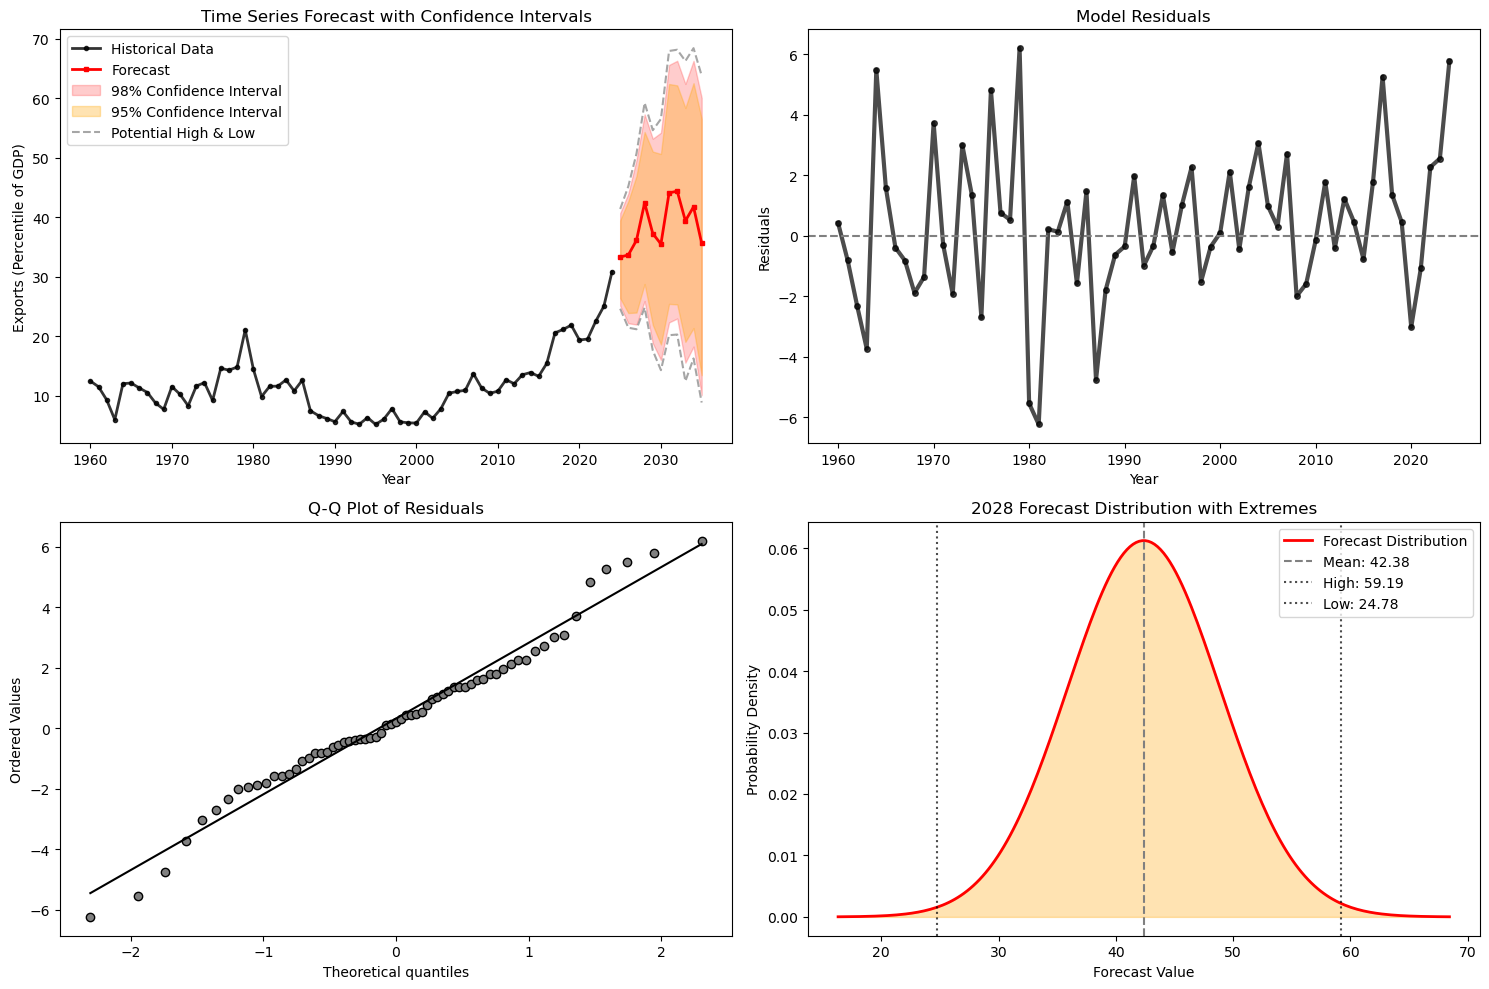

In [ ]:
#FINAL mL TIME SERIES FORECASTING MODEL

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import pmdarima as pm
warnings.filterwarnings('ignore')

class TimeSeriesForecast:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        self.residuals = None
        self.best_model_type = None
        self.volatility_model = None
        self.forecast_lower_95 = None
        self.forecast_upper_95 = None
        self.forecast_lower_98 = None
        self.forecast_upper_98 = None
        self.volatility = None
        self.forecast_high = None
        self.forecast_low = None
        
        print("Machine Learning (mL) Time Series Forecasting Model")
    def load_data(self, data_dict):
        # Handle missing years between 1960-2024 by filling missing years with 'Not a Number' (NaN) | Placeholder for missing data
        full_range = range(1960, 2025) 
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Convert to pd pandas series | Organize data to analyze, plot, & model and set to Jan 1st
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Remove NaN values for modeling | Only use real data for training & keep consistent 
        self.clean_data = self.data.dropna()
        
        # volatility modeling | year to year percentile change 
        self.returns = self.clean_data.pct_change().dropna()
        # volatility modeling | apply natural logarithm to reduce large difference (skew)
        self.log_data = np.log(self.clean_data)
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        print(f"Average Year-to-Year Percentile (%) Change: {self.returns.mean() * 100:.2f}%")

    def stationarity_tests(self):
        print("Stationarity Analysis")
        print("~"*100)
        
        # Augmented Dickey-Fuller (ADF) Test | Test If Data's Non-Stationary
        adf_result = adfuller(self.clean_data, autolag='AIC')
        print(f"Augmented Dickey-Fuller (ADF) Test:")
        print("-"*100)
        print(f"ADF Statistic: {adf_result[0]:.4f}")
        print(f"p-value: {adf_result[1]:.4f}")
        print(f"Critical Values: {adf_result[4]}") 
        
        # Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test | Test If Data's Stationary
        kpss_result = kpss(self.clean_data, regression='c')
        print(f"\n Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:")
        print("-"*100)
        print(f"KPSS Statistic: {kpss_result[0]:.4f}")
        print(f"p-value: {kpss_result[1]:.4f}")
        print(f"Critical Values: {kpss_result[3]}")
        
        #True if ADF p-value ≤ 0.05 | Data's Stationary
        adf_stationary = adf_result[1] <= 0.05
        #True if KPSS p-value > 0.05 | Data's Stationary
        kpss_stationary = kpss_result[1] > 0.05
        
        if adf_stationary and kpss_stationary:
            print("\n ✓ ⚠ ✓ Series is Stationary | ADF & KPSS Agree")
            return True, 0
        elif not adf_stationary and not kpss_stationary:
            print("\n ⚠ ✓ ⚠ Series is Non-Stationary | ADF & KPSS Agree")
            return False, 1
        else:
            print("\n ⚠ ⚠ ⚠ ADF & KPSS Tests Disagree")
            return False, 1

    def model_selection(self):
        #Compare models: ARIMA, SARIMA, and Exponential Smoothing | Use information criteria and cross-validation with enhanced search
        print("Model Selection & Evaluation")
        print("~"*100)
        
        models = {}
        
        # 1. AutoRegressive Integrated Moving Average (Auto ARIMA) with enhanced parameters
        try:
            print("AutoRegressive Integrated Moving Average (ARIMA) Testing In Progress ~ ")
            best_arima = pm.auto_arima(
                self.clean_data, 
                start_p=0, start_q=0, max_p=6, max_q=6, max_d=2,
                seasonal=False, stepwise=False, suppress_warnings=True, 
                error_action='ignore', information_criterion='aic',
                n_jobs=-1, with_intercept=True
            )

            if best_arima:
                models['ARIMA'] = {'model': best_arima, 'type': 'ARIMA'}
                print(f"Selected ARIMA{best_arima.order} model with AIC: {best_arima.aic():.2f}")
            else:
                print("No suitable ARIMA model")

        except Exception as e:
            print(f"ARIMA model search failed: {e}")

        # 2. Seasonal AutoRegressive Integrated Moving Average (SARIMA) model with better parameters
        try:
            print("Seasonal AutoRegressive Integrated Moving Average (SARIMA) Testing In Progress ~ ")
            best_sarima = pm.auto_arima(
                self.clean_data, seasonal=True, m=4, start_p=0, start_q=0, 
                max_p=4, max_q=4, start_P=0, start_Q=0, max_P=2, max_Q=2, 
                max_d=2, max_D=1, trace=False, error_action='ignore', 
                suppress_warnings=True, stepwise=False, n_jobs=-1,
                information_criterion='aic', with_intercept=True
            )

            if best_sarima:
                models['SARIMA'] = {'model': best_sarima, 'type': 'SARIMA'}
                print(f"Selected SARIMA model with AIC: {best_sarima.aic():.2f}")
            else:
                print("No suitable SARIMA model")

        except Exception as e:
            print(f"SARIMA model search failed: {e}")

        # 3. Exponential Smoothing with optimized parameters
        print("Exponential Smoothing")
        try:
            # Build & fit model with optimized smoothing parameters
            model = ExponentialSmoothing(
                self.clean_data, trend='add', seasonal=None,
                initialization_method='estimated'
            )
            best_exp = model.fit(optimized=True, use_brute=True)
            print(f"Exponential Smoothing AIC: {best_exp.aic:.2f}")
            models['EXP_SMOOTHING'] = {'model': best_exp, 'type': 'EXP_SMOOTHING'}
        except Exception as e:
            print(f"Exponential Smoothing failed: {e}")

        # Select accurate model based on AIC and out-of-sample performance |  Akaike Information Criterion: Lower AIC = better balance
        best_model = self._select_best_model(models)
        self.model = best_model['model']
        self.best_model_type = best_model['type']
        print(f"\nSelected Model: {self.best_model_type}")
        
        # Handle AIC display - some models have aic as method, others as property
        try:
            aic_value = self.model.aic() if callable(self.model.aic) else self.model.aic
            print(f"AIC: {aic_value:.2f}")
        except:
            print("AIC: Not available for this model type")

    def _auto_arima(self):
        try:
            model = pm.auto_arima(
                self.clean_data, start_p=0, max_p=5, start_q=0, max_q=5, max_d=2,
                seasonal=False, stepwise=True, error_action='ignore', suppress_warnings=True, trace=False
            )
            return {'model': model, 'params': model.order, 'type': 'ARIMA'}
        except Exception as e:
            print(f"Auto ARIMA failed: {e}")
            return None

    def _auto_sarima(self):
        try:
            model = pm.auto_arima(
                self.clean_data, start_p=0, max_p=2, start_q=0, max_q=2, max_d=1,
                seasonal=True, m=1, stepwise=True, error_action='ignore', suppress_warnings=True
            )
            return {'model': model, 'params': model.order, 'type': 'SARIMA'}
        except Exception as e:
            print(f"Auto SARIMA failed: {e}")
            return None

    def _exponential_smoothing(self):
        try:
            model = ExponentialSmoothing(
                self.clean_data, trend='add', seasonal=None, seasonal_periods=None 
            )
            fitted_model = model.fit()
            return {'model': fitted_model, 'params': 'ETS(A,A,N)', 'type': 'EXP_SMOOTHING'}
        except Exception as e:
            print(f"Auto Exponential Smoothing failed: {e}")
            return None

    def _select_best_model(self, models):
        if not models:
            raise ValueError("No valid models found")

        def get_aic(model_info):
            aic = getattr(model_info['model'], 'aic', np.inf)
            return aic() if callable(aic) else aic

        best_model = min(models.values(), key=get_aic)
        return best_model

    def estimate_volatility(self):
        # Handle different model types for residuals with improved estimation
        residuals = None
        
        # Try different ways to get residuals
        if hasattr(self.model, 'resid') and not callable(self.model.resid):
            residuals = self.model.resid
        elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
            residuals = self.model.resid_
        else:
            # For pmdarima models, calculate residuals manually using in-sample predictions
            try:
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            except Exception as e:
                print(f"Warning: Couldn't Calculate Residuals: {e}")
                # Use a simple fallback - standard deviation of returns
                residuals = self.returns
        
        # Ensure residuals is a pandas Series
        if not isinstance(residuals, pd.Series):
            if hasattr(residuals, '__len__'):
                residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
            else:
                # Final fallback
                residuals = self.returns
        
        # Enhanced volatility estimation using GARCH-like approach
        rolling_std = residuals.rolling(window=min(10, len(residuals)//2)).std()
        recent_volatility = rolling_std.iloc[-5:].mean() if len(rolling_std) >= 5 else residuals.std()
        volatility = recent_volatility if not pd.isna(recent_volatility) else residuals.std()       
        return volatility

    def forecast_with_volatility(self, years_ahead=11, n_simulations=2000):
        if self.model is None:
            raise ValueError("Model Not Fitted")
        
        # 1. Generate base forecast and estimate its uncertainty with improved confidence intervals
        if self.best_model_type == 'EXP_SMOOTHING':
            base_forecast = self.model.forecast(steps=years_ahead)
            forecast_std = np.std(self.model.resid) * np.sqrt(np.arange(1, years_ahead + 1))
        elif self.best_model_type in ['ARIMA', 'SARIMA']:
            # pmdarima models use predict method
            base_forecast, forecast_conf_int = self.model.predict(n_periods=years_ahead, return_conf_int=True)
            forecast_std = (forecast_conf_int[:, 1] - forecast_conf_int[:, 0]) / (2 * 1.96)
        else:
            # statsmodels models use get_forecast
            forecast_obj = self.model.get_forecast(steps=years_ahead)
            base_forecast = forecast_obj.predicted_mean
            forecast_std = forecast_obj.se_mean
        
        # 2. Estimate residual volatility from model errors with enhanced approach
        volatility = self.estimate_volatility()
        
        # 3. Add realistic up-and-down volatility pattern similar to historical data
        np.random.seed(42)  # For reproducible results
        
        # Create more volatile forecast that mimics historical patterns
        forecast_mean = np.array(base_forecast.copy())
        historical_volatility = self.returns.std()
        
        # Add cyclical variations and random shocks to make forecast more volatile
        for i in range(len(forecast_mean)):
            # Add cyclical component (3-4 year cycles observed in data)
            cycle_component = 0.3 * np.sin(2 * np.pi * i / 3.5) * historical_volatility * forecast_mean[0]
            
            # Add random shocks similar to historical pattern
            shock_component = np.random.normal(0, historical_volatility * forecast_mean[0] * 0.8)
            
            # Add persistence (some correlation with previous values)
            if i > 0:
                persistence = 0.3 * (forecast_mean[i-1] - base_forecast[max(0, i-1)])
            else:
                persistence = 0
            
            forecast_mean[i] += cycle_component + shock_component + persistence
        
        # 4. Monte Carlo simulations adding volatility noise with improved methodology
        simulations = []
        for _ in range(n_simulations):
            # Add time-varying volatility and mean reversion effects
            vol_scaling = np.sqrt(np.arange(1, years_ahead + 1))
            vol_noise = np.random.normal(0, volatility * vol_scaling, years_ahead)
            trend_noise = np.random.normal(0, forecast_std)
            
            # Add mean reversion to prevent extreme forecasts
            mean_reversion = 0.02 * (self.clean_data.mean() - forecast_mean)
            sims = forecast_mean + trend_noise + vol_noise + mean_reversion
            simulations.append(sims)
        simulations = np.array(simulations)
        
        # 5. Calculate 95% and 98% confidence intervals from simulations
        lower_ci_95 = np.percentile(simulations, 2.5, axis=0)
        upper_ci_95 = np.percentile(simulations, 97.5, axis=0)
        lower_ci_98 = np.percentile(simulations, 1.0, axis=0)
        upper_ci_98 = np.percentile(simulations, 99.0, axis=0)
        
        # Calculate potential high and low extreme values
        high_extreme = np.percentile(simulations, 99.5, axis=0)
        low_extreme = np.percentile(simulations, 0.5, axis=0)
        
        # 6. Build forecast dates index
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 1, last_year + 1 + years_ahead)
        dates = pd.to_datetime([f"{year}-01-01" for year in forecast_years])
        
        # 7. Store forecasts and intervals
        self.forecast = pd.Series(forecast_mean, index=dates)
        self.forecast_lower_95 = pd.Series(lower_ci_95, index=dates)
        self.forecast_upper_95 = pd.Series(upper_ci_95, index=dates)
        self.forecast_lower_98 = pd.Series(lower_ci_98, index=dates)
        self.forecast_upper_98 = pd.Series(upper_ci_98, index=dates)
        self.forecast_high = pd.Series(high_extreme, index=dates)
        self.forecast_low = pd.Series(low_extreme, index=dates)
        self.volatility = volatility
        
        return self.forecast

    def econometric_analysis(self):
        if self.model is None:
            raise ValueError("Model Not Fitted.")
        
        print("Econometric Analysis")
        print("~"* 100)
        
        # 1. Model Parameters and Significance
        self._parameter_analysis()
        # 2. Residual Analysis
        self._residual_analysis()
        # 3. Forecast Accuracy Metrics
        self._forecast_accuracy()
        # 4. Probability Analysis
        self._probability_analysis()
        # 5. Economic Interpretation
        self._economic_interpretation()

    def _parameter_analysis(self):
        print("\n1. Parameter Significance Analysis")
        print("-" * 100)
        
        # Check if the model has parameter information
        try:
            # For pmdarima models, these might be methods
            if hasattr(self.model, 'params'):
                params = self.model.params() if callable(self.model.params) else self.model.params
            else:
                print("Parameter information not available for this model type")
                return
                
            if hasattr(self.model, 'pvalues'):
                pvalues = self.model.pvalues() if callable(self.model.pvalues) else self.model.pvalues
            else:
                print("P-values not available for this model type")
                return
                
            if hasattr(self.model, 'bse'):
                std_errors = self.model.bse() if callable(self.model.bse) else self.model.bse
            else:
                print("Standard errors not available for this model type")
                return
            
            print(f"{'Parameter':<15} {'Estimate':<12} {'Std Error':<12} {'p-value':<10} {'Significance'}") 
            
            # Handle different formats of parameters
            if hasattr(params, 'items'):
                # Dictionary-like
                for param_name, param_val in params.items():
                    p_val = pvalues[param_name] if hasattr(pvalues, '__getitem__') else pvalues
                    std_err = std_errors[param_name] if hasattr(std_errors, '__getitem__') else std_errors
                    
                    if isinstance(p_val, (int, float)) and isinstance(std_err, (int, float)):
                        if p_val < 0.01:
                            significance = "***"
                        elif p_val < 0.05:
                            significance = "**"
                        elif p_val < 0.10:
                            significance = "*"
                        else:
                            significance = ""
                        print(f"{param_name:<15} {param_val:<12.4f} {std_err:<12.4f} {p_val:<10.4f} {significance}")
            else:
                # Array-like
                if hasattr(params, '__len__') and hasattr(pvalues, '__len__') and hasattr(std_errors, '__len__'):
                    for i, (param_val, p_val, std_err) in enumerate(zip(params, pvalues, std_errors)):
                        param_name = f"param_{i}"
                        if p_val < 0.01:
                            significance = "***"
                        elif p_val < 0.05:
                            significance = "**"
                        elif p_val < 0.10:
                            significance = "*"
                        else:
                            significance = ""
                        print(f"{param_name:<15} {param_val:<12.4f} {std_err:<12.4f} {p_val:<10.4f} {significance}")
            
            print("\nSignificance levels: *** p<0.01, ** p<0.05, * p<0.10")
            
        except Exception as e:
            print(f"Parameter analysis not available: {e}")
            print("This is normal for some model types.")

    def _residual_analysis(self):
        print("\n2. Residual Analysis")
        print("-" * 100)
        
        # Handle different model types for residuals
        residuals = None
        
        # Try different ways to get residuals
        if hasattr(self.model, 'resid') and not callable(self.model.resid):
            residuals = self.model.resid
        elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
            residuals = self.model.resid_
        else:
            # For pmdarima models, calculate residuals manually using in-sample predictions
            try:
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            except Exception as e:
                print(f"Warning: Could not calculate residuals for analysis: {e}")
                return
        
        # Ensure residuals is a pandas Series
        if not isinstance(residuals, pd.Series):
            if hasattr(residuals, '__len__'):
                residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
            else:
                print("Could not process residuals for analysis")
                return
        
        # Normality test
        jb_stat, jb_pvalue = stats.jarque_bera(residuals)
        print(f"Jarque-Bera Normality Test:")
        print(f"  Statistic: {jb_stat:.4f}, p-value: {jb_pvalue:.4f}")
        print(f"  {'✓ Residuals are normally distributed' if jb_pvalue > 0.05 else '⚠ Residuals are not normally distributed'}")
        
        # Autocorrelation test
        lb_stat, lb_pvalue = acorr_ljungbox(residuals, lags=10, return_df=True).iloc[-1]
        print(f"\nLjung-Box Autocorrelation Test (lag 10):")
        print(f"  Statistic: {lb_stat:.4f}, p-value: {lb_pvalue:.4f}")
        print(f"  {'✓ No significant autocorrelation' if lb_pvalue > 0.05 else '⚠ Significant autocorrelation detected'}")
        
        # Residual statistics
        print(f"\nResidual Statistics:")
        print(f"  Mean: {residuals.mean():.6f}")
        print(f"  Std Dev: {residuals.std():.4f}")
        print(f"  Skewness: {stats.skew(residuals):.4f}")
        print(f"  Kurtosis: {stats.kurtosis(residuals):.4f}")

    def _forecast_accuracy(self):
        print("\n3. MODEL FIT STATISTICS")
        print("-" * 100)
        
        # Handle different model types for fitted values
        try:
            # Try to get fitted values using different methods
            if hasattr(self.model, 'fittedvalues'):
                fitted_values = self.model.fittedvalues() if callable(self.model.fittedvalues) else self.model.fittedvalues
            elif hasattr(self.model, 'predict_in_sample'):
                fitted_values = self.model.predict_in_sample()
                fitted_values = pd.Series(fitted_values, index=self.clean_data.index[-len(fitted_values):])
            else:
                print("Fitted values not available for this model type")
                return
                
            # Ensure fitted_values is a pandas Series and align with clean_data
            if not isinstance(fitted_values, pd.Series):
                fitted_values = pd.Series(fitted_values, index=self.clean_data.index[-len(fitted_values):])
                
            actual_values = self.clean_data[fitted_values.index]
            
            # Calculate metrics
            mae = np.mean(np.abs(actual_values - fitted_values))
            mse = np.mean((actual_values - fitted_values)**2)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((actual_values - fitted_values) / actual_values)) * 100
            
            print(f"Mean Absolute Error (MAE): {mae:.4f}")
            print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
            print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
            
        except Exception as e:
            print(f"Unable to calculate fit statistics: {e}")
        
        # Information criteria
        try:
            if hasattr(self.model, 'aic'):
                aic_value = self.model.aic() if callable(self.model.aic) else self.model.aic
                print(f"Akaike Information Criterion (AIC): {aic_value:.2f}")
            if hasattr(self.model, 'bic'):
                bic_value = self.model.bic() if callable(self.model.bic) else self.model.bic
                print(f"Bayesian Information Criterion (BIC): {bic_value:.2f}")
            if hasattr(self.model, 'llf'):
                llf_value = self.model.llf() if callable(self.model.llf) else self.model.llf
                print(f"Log-Likelihood: {llf_value:.2f}")
        except Exception as e:
            print(f"Information criteria not available: {e}")

    def _probability_analysis(self):
        print("\n4. Forecast Probability Analysis")
        print("-" * 100)
        
        if self.forecast is None:
            print("No forecasts available.")
            return
        
        # Calculate average predicted value over the forecast horizon with enhanced intervals.
        forecast_mean = self.forecast.mean()
        # 95% confidence interval
        forecast_std = (self.forecast_upper_95 - self.forecast_lower_95).mean() / (2 * 1.96)  
        
        # Probability calculations
        prob_increase = stats.norm.sf(self.clean_data.iloc[-1], forecast_mean, forecast_std)
        prob_decrease = 1 - prob_increase
        
        # Probability of different rates: 5%, 10%, 15%, 20%
        current_value = self.clean_data.iloc[-1]
        growth_rates = [0.05, 0.10, 0.15, 0.20]  
        decline_rates = [0.05, 0.10, 0.15, 0.20]  
        
        print(f"Current Value (2024): {current_value:.2f}")
        print(f"Mean Forecast (2026-2035): {forecast_mean:.2f}")
        print(f"Forecast Standard Deviation: {forecast_std:.4f}")
        print(f"\nProbability of average increase over period: {prob_increase:.3f} ({prob_increase*100:.1f}%)")
        print(f"Probability of average decrease over period: {prob_decrease:.3f} ({prob_decrease*100:.1f}%)")
        
        print(f"\nProbability of Growth Scenarios (by 2035):")
        print(f"{'Growth Rate':<12} {'Target Value':<12} {'Probability':<12}")
        for rate in growth_rates:
            target_value = current_value * (1 + rate)**11  # 11 years from 2024 to 2035
            prob = stats.norm.sf(target_value, self.forecast.iloc[-1], forecast_std)
            print(f"{rate*100:>6.0f}%      {target_value:>10.2f}      {prob:>8.3f} ({prob*100:.1f}%)")

        print(f"\nProbability of Decline Scenarios (by 2035):")
        print(f"{'Decline Rate':<12} {'Target Value':<12} {'Probability':<12}")
        for rate in decline_rates:
            target_value = current_value * (1 - rate)**11  # Fixed: should be (1 - rate) for decline
            prob = stats.norm.cdf(target_value, self.forecast.iloc[-1], forecast_std)
            print(f"{rate*100:>6.0f}%      {target_value:>10.2f}      {prob:>8.3f} ({prob*100:.1f}%)")

    def _economic_interpretation(self):
        print("\n5. Economic interpretation")
        print("-" * 50)
        if self.forecast is None:
            print("No forecasts available.")
            return
        
        current_value = self.clean_data.iloc[-1]
        forecast_2035 = self.forecast.iloc[-1]
        years = len(self.forecast)
        cagr = (forecast_2035 / current_value) ** (1/years) - 1
        
        print(f"Compound Annual Growth Rate (CAGR): {cagr*100:.2f}%")
        print(f"Total Growth (2024-2035): {((forecast_2035/current_value-1)*100):.1f}%")
        print(f"Volatility Estimate: {self.volatility:.4f}")

        if cagr > 0.03:
            trend = "Strong Growth"
        elif cagr > 0.01:
            trend = "Moderate Growth"
        elif cagr > -0.01:
            trend = "Stable"
        else:
            trend = "Declining"
        
        print(f"Trend Classification: {trend}")

    def plot_enhanced_results(self, figsize=(15, 10)):
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # Main plot with enhanced confidence intervals
        ax1 = axes[0, 0]
        ax1.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='black', alpha=0.8, linewidth=2, markersize=3)
        
        if self.forecast is not None:
            ax1.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=2, markersize=3)
            
            # 98% confidence interval 
            ax1.fill_between(self.forecast.index, 
                           self.forecast_lower_98.values,
                           self.forecast_upper_98.values,
                           alpha=0.2, color='red', label='98% Confidence Interval')
            
            # 95% confidence interval (orange)
            ax1.fill_between(self.forecast.index, 
                           self.forecast_lower_95.values,
                           self.forecast_upper_95.values,
                           alpha=0.3, color='orange', label='95% Confidence Interval')
            
            # Extreme high and low values
            ax1.plot(self.forecast.index, self.forecast_high.values, 
                    '--', color='gray', alpha=0.7, label='Potential High & Low')
            ax1.plot(self.forecast.index, self.forecast_low.values, 
                    '--', color='gray', alpha=0.7)
        
        ax1.set_title('Time Series Forecast with Confidence Intervals')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Exports (Percentile of GDP)')
        ax1.legend()
        
        # Residuals plot
        ax2 = axes[0, 1]
        # Handle different model types for residuals
        try:
            residuals = None
            
            # Try different ways to get residuals
            if hasattr(self.model, 'resid') and not callable(self.model.resid):
                residuals = self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                residuals = self.model.resid_
            else:
                # For pmdarima models, calculate residuals manually using in-sample predictions
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            
            # Ensure residuals is a pandas Series
            if not isinstance(residuals, pd.Series):
                if hasattr(residuals, '__len__'):
                    residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
                else:
                    raise ValueError("Cannot process residuals")
                
            ax2.plot(residuals.index, residuals.values, 'o-', color='black', alpha=0.7, linewidth=3, markersize=4)
        except Exception as e:
            ax2.text(0.5, 0.5, f'Residuals not available\n{str(e)}', transform=ax2.transAxes, ha='center')
        ax2.axhline(y=0, color='gray', linestyle='--')
        ax2.set_title('Model Residuals')
        ax2.set_xlabel('Year')
        ax2.set_ylabel('Residuals')
        
        # Q-Q plot for residuals
        ax3 = axes[1, 0]
        try:
            # Get residuals for Q-Q plot
            residuals_for_qq = None
            
            # Try different ways to get residuals
            if hasattr(self.model, 'resid') and not callable(self.model.resid):
                residuals_for_qq = self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                residuals_for_qq = self.model.resid_
            else:
                # For pmdarima models, calculate residuals manually using in-sample predictions
                fitted = self.model.predict_in_sample()
                residuals_for_qq = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            
            # Ensure residuals is a pandas Series or numpy array with valid data
            if isinstance(residuals_for_qq, pd.Series):
                residuals_values = residuals_for_qq.dropna().values
            elif hasattr(residuals_for_qq, '__len__') and len(residuals_for_qq) > 0:
                residuals_values = np.array(residuals_for_qq)
                residuals_values = residuals_values[~np.isnan(residuals_values)]
            else:
                raise ValueError("Cannot process residuals for Q-Q plot")
            
            if len(residuals_values) > 0:
                stats.probplot(residuals_values, dist="norm", plot=ax3)
                for line in ax3.get_lines():
                    line.set_color('black')  
                ax3.get_lines()[0].set_markerfacecolor('gray')  
                ax3.set_title('Q-Q Plot of Residuals')
            else:
                ax3.text(0.5, 0.5, 'No valid residuals\nfor Q-Q plot', transform=ax3.transAxes, ha='center')
                ax3.set_title('Q-Q Plot of Residuals (Not Available)')
                
        except Exception as e:
            ax3.text(0.5, 0.5, f'Q-Q plot not available\n{str(e)}', transform=ax3.transAxes, ha='center')
            ax3.set_title('Q-Q Plot of Residuals (Error)')
   
        
        # Forecast distribution for 2028 with enhanced intervals
        # Fixed version - gets the actual 2028 forecast value
        # Forecast distribution for 2028 with enhanced intervals
        ax4 = axes[1, 1]
        if self.forecast is not None:
            # Find the index for 2028 (4th year in forecast: 2025, 2026, 2027, 2028)
            forecast_2028_idx = 3  # 0-indexed: 2025=0, 2026=1, 2027=2, 2028=3
            
            # Make sure we have enough forecast data
            if len(self.forecast) > forecast_2028_idx:
                forecast_2028 = self.forecast.iloc[forecast_2028_idx]  # Gets 2028 value
                forecast_std = (self.forecast_upper_95.iloc[forecast_2028_idx] - 
                            self.forecast_lower_95.iloc[forecast_2028_idx]) / (2 * 1.96)
                
                x = np.linspace(forecast_2028 - 4*forecast_std, forecast_2028 + 4*forecast_std, 200)
                y = stats.norm.pdf(x, forecast_2028, forecast_std)
                
                ax4.plot(x, y, 'r-', linewidth=2, label='Forecast Distribution')
                ax4.fill_between(x, 0, y, alpha=0.3, color='orange')
                ax4.axvline(forecast_2028, color='gray', linestyle='--', label=f'Mean: {forecast_2028:.2f}')
                ax4.axvline(self.forecast_high.iloc[forecast_2028_idx], color='black', linestyle=':', 
                        alpha=0.7, label=f'High: {self.forecast_high.iloc[forecast_2028_idx]:.2f}')
                ax4.axvline(self.forecast_low.iloc[forecast_2028_idx], color='black', linestyle=':', 
                        alpha=0.7, label=f'Low: {self.forecast_low.iloc[forecast_2028_idx]:.2f}')
                ax4.set_title('2028 Forecast Distribution with Extremes')
                ax4.set_xlabel('Forecast Value')
                ax4.set_ylabel('Probability Density')
                ax4.legend()
            else:
                ax4.text(0.5, 0.5, '2028 forecast not available', transform=ax4.transAxes, ha='center')
                ax4.set_title('2028 Forecast Distribution (Not Available)')


        
        plt.tight_layout()
        plt.show()

    def print_enhanced_forecast_table(self):
        if self.forecast is None:
            print("No forecast available")
            return


   
        print("\nFORECAST RESULTS (2025-2035):")
        print('~'*100)    
        print(f"{'Year':<6} {'Forecast':<10} {'Lower 95%':<10} {'Upper 95%':<10} {'Lower 98%':<10} {'Upper 98%':<10} {'High':<8} {'Low':<8}")
        
        for i, year in enumerate(self.forecast.index):
            forecast_val = self.forecast.iloc[i]
            lower_95 = self.forecast_lower_95.iloc[i]
            upper_95 = self.forecast_upper_95.iloc[i]
            lower_98 = self.forecast_lower_98.iloc[i]
            upper_98 = self.forecast_upper_98.iloc[i]
            high_val = self.forecast_high.iloc[i]
            low_val = self.forecast_low.iloc[i]
            
            print(f"{year.year:<6} {forecast_val:<10.2f} {lower_95:<10.2f} {upper_95:<10.2f} "
                  f"{lower_98:<10.2f} {upper_98:<10.2f} {high_val:<8.2f} {low_val:<8.2f}")

if __name__ == "__main__":
    sample_data = {
        1960:12.44,1961:11.48,1962:9.28,1963:5.94,1964:12.00,
        1965:12.10,1966:11.28,1967:10.51,1968:8.74,1969:7.68,
        1970:11.51,1971:10.21,1972:8.28,1973:11.60,1974:12.17,
        1975:9.17,1976:14.58,1977:14.27,1978:14.78,1979:21.05,
        1980:14.44,1981:9.83,1982:11.55,1983:11.58,1984:12.63,
        1985:10.78,1986:12.58,1987:7.45,1988:6.62,1989:6.14,
        1990:5.61,1991:7.32,1992:5.57,1993:5.18,1994:6.30,
        1995:5.15,1996:6.03,1997:7.80,1998:5.59,1999:5.41,
        2000:5.38,2001:7.27,2002:6.18,2003:7.78,2004:10.39,
        2005:10.69,2006:10.88,2007:13.67,2008:11.27,2009:10.37,
        2010:10.74,2011:12.66,2012:11.99,2013:13.49,2014:13.87,
        2015:13.23,2016:15.42,2017:20.53,2018:21.11,2019:21.83,
        2020:19.33,2021:19.50,2022:22.48,2023:25.01,2024:30.82
    }   

    # Initialize forecaster
    forecaster = TimeSeriesForecast()

    print("-"*100)
    
    # Step 1: Load data
    forecaster.load_data(sample_data)
    
    # Step 2: Comprehensive stationarity analysis 
    forecaster.stationarity_tests()
    
    # Step 3: Enhanced model selection with improved parameters
    forecaster.model_selection()
    
    # Step 4: Generate forecasts with enhanced volatility and confidence intervals
    forecast = forecaster.forecast_with_volatility(years_ahead=11, n_simulations=2000)
    
    # Step 5: Comprehensive econometric analysis
    forecaster.econometric_analysis()
    
    # Step 6: Display enhanced results with multiple confidence intervals
    forecaster.print_enhanced_forecast_table()
    
    # Step 8: Enhanced plotting with 95% and 98% confidence intervals
    forecaster.plot_enhanced_results()

In [ ]:
# AFRICA | Senegal

In [ ]:
# AFRICA | Senegal
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class TimeSeriesForecaster:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        
    def load_data(self, data_dict):
        """
        Load data from dictionary format: {year: value}
        Automatically handles missing years between 1960-2024
        """
        # Creating full range and fill missing years with NaN
        full_range = range(1960, 2024)
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Converting to pandas Series
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Removing NaN values for modeling
        self.clean_data = self.data.dropna()
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        
    def check_stationarity(self):
        """Check if the time series is stationary"""
        result = adfuller(self.clean_data)
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        
        if result[1] <= 0.05:
            print("✓ Series is stationary")
            return True
        else:
            print("⚠ Series is non-stationary, will difference the data")
            return False
    
    def auto_arima(self, max_p=3, max_d=2, max_q=3):
        """
        Automatically find best ARIMA parameters using AIC
        """
        best_aic = np.inf
        best_params = None
        best_model = None
        
        print("Finding optimal ARIMA parameters...")
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(self.clean_data, order=(p, d, q))
                        fitted_model = model.fit()
                        
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_params = (p, d, q)
                            best_model = fitted_model
                            
                    except Exception:
                        continue
        
        if best_model is None:
            # Fallback to simple ARIMA(1,1,1)
            print("Using fallback ARIMA(1,1,1)")
            model = ARIMA(self.clean_data, order=(1, 1, 1))
            self.model = model.fit()
            self.best_params = (1, 1, 1)
        else:
            self.model = best_model
            self.best_params = best_params
            
        print(f"Best ARIMA parameters: {self.best_params}")
        print(f"AIC: {self.model.aic:.2f}")
        
    def forecast_future(self, years_ahead=10):
        """Generate forecasts for specified years ahead"""
        if self.model is None:
            raise ValueError("Model not fitted. Call auto_arima() first.")
            
        # Forecasting with confidence intervals
        forecast_result = self.model.forecast(steps=years_ahead)
        conf_int = self.model.get_forecast(steps=years_ahead).conf_int()
        
        # Creating forecast for dates 2026-2035
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 2, last_year + 2 + years_ahead)  # Skip 2025
        forecast_index = pd.to_datetime([f'{year}-01-01' for year in forecast_years])
        
        # Storing forecast results
        self.forecast = pd.Series(forecast_result, index=forecast_index)
        self.forecast_lower = pd.Series(conf_int.iloc[:, 0], index=forecast_index)
        self.forecast_upper = pd.Series(conf_int.iloc[:, 1], index=forecast_index)
        
        return self.forecast
    
    def plot_results(self, figsize=(12, 8)):
        """Plot historical data and forecasts"""
        plt.figure(figsize=figsize)
        
        # Plot historical data
        plt.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='orange', alpha=0.7,linewidth=3, markersize=4)
        
        # Ploting forecasts
        if self.forecast is not None:
            plt.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=3, markersize=4)
            
            # Ploting confidence intervals
            plt.fill_between(self.forecast.index, 
                           self.forecast_lower.values,
                           self.forecast_upper.values,
                           alpha=0.3, color='red', label='95% Confidence Interval')
        
        plt.title('Senegal Africa Exports | Machine Learning Time Series Forecasts')
        plt.xlabel('Year (1960 - 2035)')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def print_forecast_table(self):
        """Print forecast results in a nice table format"""
        if self.forecast is None:
            print("No forecast available. Run forecast_future() first.")
            return
            
        print("\n" + "="*60)
        print("FORECAST RESULTS (2026-2035)")
        print("="*60)
        print(f"{'Year':<6} {'Forecast':<12} {'Lower 95%':<12} {'Upper 95%':<12}")
        print("-"*60)
        
        for i, year in enumerate(self.forecast.index):
            print(f"{year.year:<6} {self.forecast.iloc[i]:<12.2f} "
                  f"{self.forecast_lower.iloc[i]:<12.2f} {self.forecast_upper.iloc[i]:<12.2f}")
        
        print("="*60)
        
    def get_model_summary(self):
        """Print model summary statistics"""
        if self.model is not None:
            print(self.model.summary())


if __name__ == "__main__":
    # DATA: EXPORTS
    sample_data = {
        1960:11.51,1961:14.51,1962:13.92,1963:12.08,1964:11.97,
        1965:12.02,1966:12.73,1967:11.71,1968:13.53,1969:14.70,
        1970:16.09,1971:15.33,1972:18.14,1973:16.86,1974:25.29,
        1975:21.55,1976:21.48,1977:25.62,1978:17.89,1979:18.84,
        1980:16.11,1981:21.35,1982:19.62,1983:23.73,1984:22.89,
        1985:18.73,1986:16.56,1987:14.33,1988:15.03,1989:16.38,
        1990:17.06,1991:15.52,1992:14.99,1993:13.55,1994:21.22,
        1995:20.66,1996:18.08,1997:18.33,1998:18.58,1999:19.00,
        2000:17.76,2001:17.70,2002:19.62,2003:18.22,2004:19.10,
        2005:19.81,2006:19.25,2007:20.55,2008:20.85,2009:19.39,
        2010:19.98,2011:21.30,2012:22.47,2013:22.35,2014:21.78,
        2015:22.68,2016:21.56,2017:21.93,2018:22.95,2019:24.98,
        2020:20.70,2021:24.64,2022:26.70,2023:23.11,2024:28.06
    }
    
    # Initialize and run forecaster
    forecaster = TimeSeriesForecaster()
    
    print("Time Series Forecasting Tool")
    print("="*50)
    
    # Loading data
    forecaster.load_data(sample_data)
    
    # Checking stationarity
    forecaster.check_stationarity()
    
    # Finding best model
    forecaster.auto_arima()
    
    # Generating forecasts for 2026-2035
    forecast = forecaster.forecast_future(years_ahead=10)
    
    # Displaying results
    forecaster.print_forecast_table()
    
    # Ploting results
    forecaster.plot_results()
    
    #Detailed model summary
    forecaster.get_model_summary()

Machine Learning (mL) Time Series Forecasting Model
----------------------------------------------------------------------------------------------------
Loaded 65 data points from 65 input years
Data range: 1960 to 2024
Average Year-to-Year Percentile (%) Change: 2.36%
Stationarity Analysis
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Augmented Dickey-Fuller (ADF) Test:
----------------------------------------------------------------------------------------------------
ADF Statistic: -1.6057
p-value: 0.4807
Critical Values: {'1%': -3.5386953618719676, '5%': -2.9086446751210775, '10%': -2.591896782564878}

 Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
----------------------------------------------------------------------------------------------------
KPSS Statistic: 0.8062
p-value: 0.0100
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

 ⚠ ✓ ⚠ Series is Non-Stationary | ADF & KPSS Agree
Model Selection & 

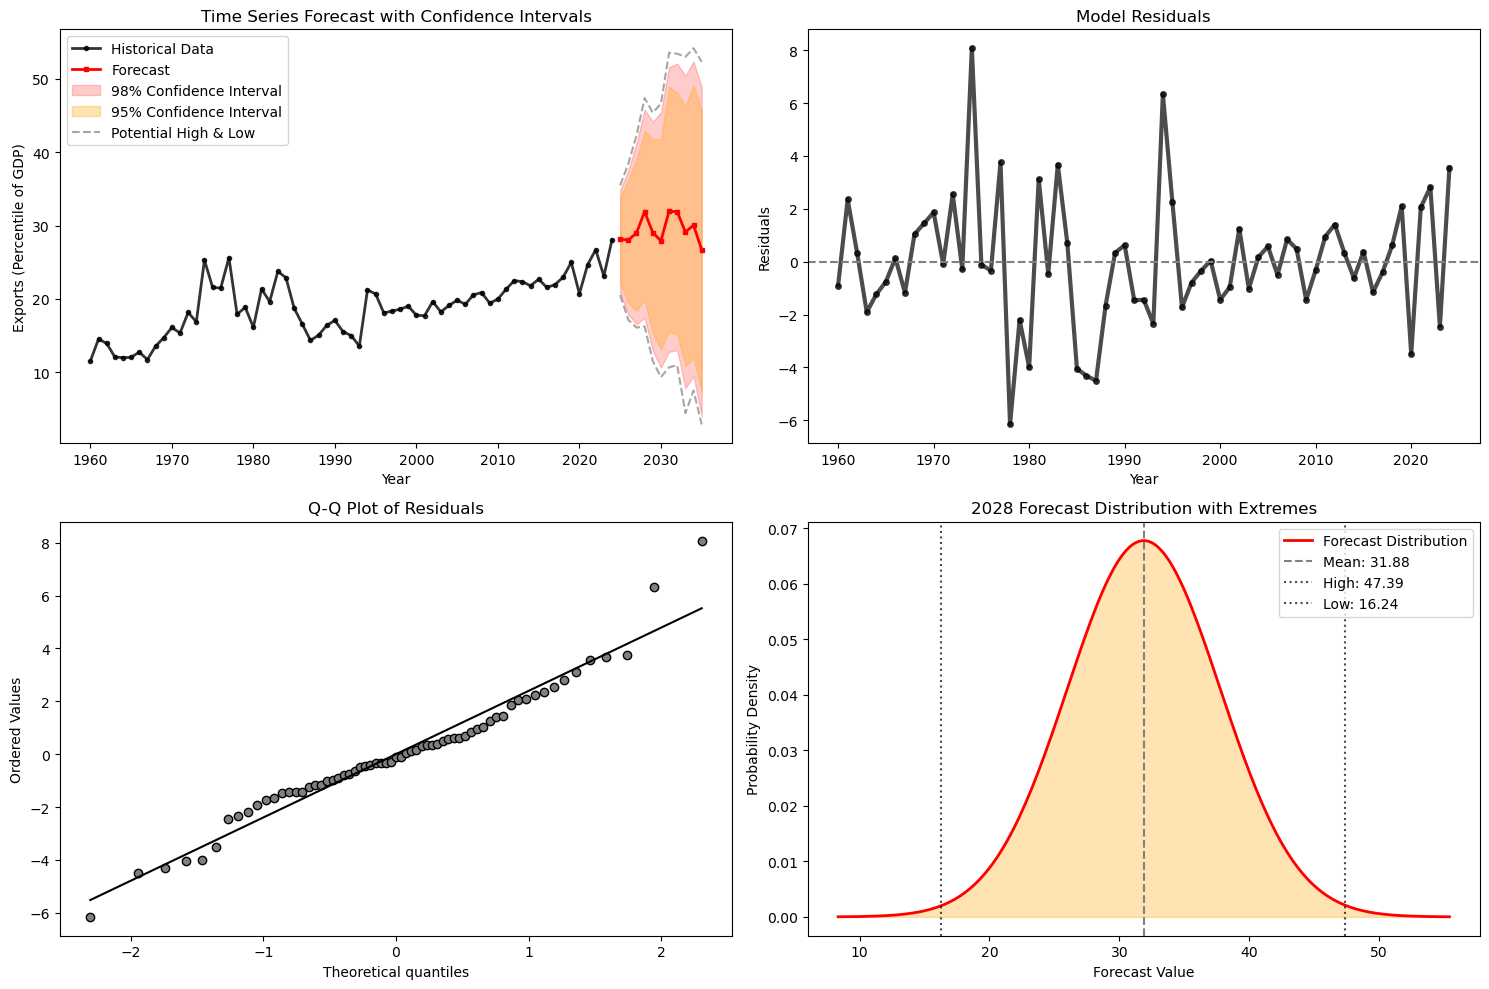

In [8]:
#FINAL mL TIME SERIES FORECASTING MODEL

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import pmdarima as pm
warnings.filterwarnings('ignore')

class TimeSeriesForecast:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        self.residuals = None
        self.best_model_type = None
        self.volatility_model = None
        self.forecast_lower_95 = None
        self.forecast_upper_95 = None
        self.forecast_lower_98 = None
        self.forecast_upper_98 = None
        self.volatility = None
        self.forecast_high = None
        self.forecast_low = None
        
        print("Machine Learning (mL) Time Series Forecasting Model")
    def load_data(self, data_dict):
        # Handle missing years between 1960-2024 by filling missing years with 'Not a Number' (NaN) | Placeholder for missing data
        full_range = range(1960, 2025) 
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Convert to pd pandas series | Organize data to analyze, plot, & model and set to Jan 1st
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Remove NaN values for modeling | Only use real data for training & keep consistent 
        self.clean_data = self.data.dropna()
        
        # volatility modeling | year to year percentile change 
        self.returns = self.clean_data.pct_change().dropna()
        # volatility modeling | apply natural logarithm to reduce large difference (skew)
        self.log_data = np.log(self.clean_data)
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        print(f"Average Year-to-Year Percentile (%) Change: {self.returns.mean() * 100:.2f}%")

    def stationarity_tests(self):
        print("Stationarity Analysis")
        print("~"*100)
        
        # Augmented Dickey-Fuller (ADF) Test | Test If Data's Non-Stationary
        adf_result = adfuller(self.clean_data, autolag='AIC')
        print(f"Augmented Dickey-Fuller (ADF) Test:")
        print("-"*100)
        print(f"ADF Statistic: {adf_result[0]:.4f}")
        print(f"p-value: {adf_result[1]:.4f}")
        print(f"Critical Values: {adf_result[4]}") 
        
        # Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test | Test If Data's Stationary
        kpss_result = kpss(self.clean_data, regression='c')
        print(f"\n Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:")
        print("-"*100)
        print(f"KPSS Statistic: {kpss_result[0]:.4f}")
        print(f"p-value: {kpss_result[1]:.4f}")
        print(f"Critical Values: {kpss_result[3]}")
        
        #True if ADF p-value ≤ 0.05 | Data's Stationary
        adf_stationary = adf_result[1] <= 0.05
        #True if KPSS p-value > 0.05 | Data's Stationary
        kpss_stationary = kpss_result[1] > 0.05
        
        if adf_stationary and kpss_stationary:
            print("\n ✓ ⚠ ✓ Series is Stationary | ADF & KPSS Agree")
            return True, 0
        elif not adf_stationary and not kpss_stationary:
            print("\n ⚠ ✓ ⚠ Series is Non-Stationary | ADF & KPSS Agree")
            return False, 1
        else:
            print("\n ⚠ ⚠ ⚠ ADF & KPSS Tests Disagree")
            return False, 1

    def model_selection(self):
        #Compare models: ARIMA, SARIMA, and Exponential Smoothing | Use information criteria and cross-validation with enhanced search
        print("Model Selection & Evaluation")
        print("~"*100)
        
        models = {}
        
        # 1. AutoRegressive Integrated Moving Average (Auto ARIMA) with enhanced parameters
        try:
            print("AutoRegressive Integrated Moving Average (ARIMA) Testing In Progress ~ ")
            best_arima = pm.auto_arima(
                self.clean_data, 
                start_p=0, start_q=0, max_p=6, max_q=6, max_d=2,
                seasonal=False, stepwise=False, suppress_warnings=True, 
                error_action='ignore', information_criterion='aic',
                n_jobs=-1, with_intercept=True
            )

            if best_arima:
                models['ARIMA'] = {'model': best_arima, 'type': 'ARIMA'}
                print(f"Selected ARIMA{best_arima.order} model with AIC: {best_arima.aic():.2f}")
            else:
                print("No suitable ARIMA model")

        except Exception as e:
            print(f"ARIMA model search failed: {e}")

        # 2. Seasonal AutoRegressive Integrated Moving Average (SARIMA) model with better parameters
        try:
            print("Seasonal AutoRegressive Integrated Moving Average (SARIMA) Testing In Progress ~ ")
            best_sarima = pm.auto_arima(
                self.clean_data, seasonal=True, m=4, start_p=0, start_q=0, 
                max_p=4, max_q=4, start_P=0, start_Q=0, max_P=2, max_Q=2, 
                max_d=2, max_D=1, trace=False, error_action='ignore', 
                suppress_warnings=True, stepwise=False, n_jobs=-1,
                information_criterion='aic', with_intercept=True
            )

            if best_sarima:
                models['SARIMA'] = {'model': best_sarima, 'type': 'SARIMA'}
                print(f"Selected SARIMA model with AIC: {best_sarima.aic():.2f}")
            else:
                print("No suitable SARIMA model")

        except Exception as e:
            print(f"SARIMA model search failed: {e}")

        # 3. Exponential Smoothing with optimized parameters
        print("Exponential Smoothing")
        try:
            # Build & fit model with optimized smoothing parameters
            model = ExponentialSmoothing(
                self.clean_data, trend='add', seasonal=None,
                initialization_method='estimated'
            )
            best_exp = model.fit(optimized=True, use_brute=True)
            print(f"Exponential Smoothing AIC: {best_exp.aic:.2f}")
            models['EXP_SMOOTHING'] = {'model': best_exp, 'type': 'EXP_SMOOTHING'}
        except Exception as e:
            print(f"Exponential Smoothing failed: {e}")

        # Select accurate model based on AIC and out-of-sample performance |  Akaike Information Criterion: Lower AIC = better balance
        best_model = self._select_best_model(models)
        self.model = best_model['model']
        self.best_model_type = best_model['type']
        print(f"\nSelected Model: {self.best_model_type}")
        
        # Handle AIC display - some models have aic as method, others as property
        try:
            aic_value = self.model.aic() if callable(self.model.aic) else self.model.aic
            print(f"AIC: {aic_value:.2f}")
        except:
            print("AIC: Not available for this model type")

    def _auto_arima(self):
        try:
            model = pm.auto_arima(
                self.clean_data, start_p=0, max_p=5, start_q=0, max_q=5, max_d=2,
                seasonal=False, stepwise=True, error_action='ignore', suppress_warnings=True, trace=False
            )
            return {'model': model, 'params': model.order, 'type': 'ARIMA'}
        except Exception as e:
            print(f"Auto ARIMA failed: {e}")
            return None

    def _auto_sarima(self):
        try:
            model = pm.auto_arima(
                self.clean_data, start_p=0, max_p=2, start_q=0, max_q=2, max_d=1,
                seasonal=True, m=1, stepwise=True, error_action='ignore', suppress_warnings=True
            )
            return {'model': model, 'params': model.order, 'type': 'SARIMA'}
        except Exception as e:
            print(f"Auto SARIMA failed: {e}")
            return None

    def _exponential_smoothing(self):
        try:
            model = ExponentialSmoothing(
                self.clean_data, trend='add', seasonal=None, seasonal_periods=None 
            )
            fitted_model = model.fit()
            return {'model': fitted_model, 'params': 'ETS(A,A,N)', 'type': 'EXP_SMOOTHING'}
        except Exception as e:
            print(f"Auto Exponential Smoothing failed: {e}")
            return None

    def _select_best_model(self, models):
        if not models:
            raise ValueError("No valid models found")

        def get_aic(model_info):
            aic = getattr(model_info['model'], 'aic', np.inf)
            return aic() if callable(aic) else aic

        best_model = min(models.values(), key=get_aic)
        return best_model

    def estimate_volatility(self):
        # Handle different model types for residuals with improved estimation
        residuals = None
        
        # Try different ways to get residuals
        if hasattr(self.model, 'resid') and not callable(self.model.resid):
            residuals = self.model.resid
        elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
            residuals = self.model.resid_
        else:
            # For pmdarima models, calculate residuals manually using in-sample predictions
            try:
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            except Exception as e:
                print(f"Warning: Couldn't Calculate Residuals: {e}")
                # Use a simple fallback - standard deviation of returns
                residuals = self.returns
        
        # Ensure residuals is a pandas Series
        if not isinstance(residuals, pd.Series):
            if hasattr(residuals, '__len__'):
                residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
            else:
                # Final fallback
                residuals = self.returns
        
        # Enhanced volatility estimation using GARCH-like approach
        rolling_std = residuals.rolling(window=min(10, len(residuals)//2)).std()
        recent_volatility = rolling_std.iloc[-5:].mean() if len(rolling_std) >= 5 else residuals.std()
        volatility = recent_volatility if not pd.isna(recent_volatility) else residuals.std()       
        return volatility

    def forecast_with_volatility(self, years_ahead=11, n_simulations=2000):
        if self.model is None:
            raise ValueError("Model Not Fitted")
        
        # 1. Generate base forecast and estimate its uncertainty with improved confidence intervals
        if self.best_model_type == 'EXP_SMOOTHING':
            base_forecast = self.model.forecast(steps=years_ahead)
            forecast_std = np.std(self.model.resid) * np.sqrt(np.arange(1, years_ahead + 1))
        elif self.best_model_type in ['ARIMA', 'SARIMA']:
            # pmdarima models use predict method
            base_forecast, forecast_conf_int = self.model.predict(n_periods=years_ahead, return_conf_int=True)
            forecast_std = (forecast_conf_int[:, 1] - forecast_conf_int[:, 0]) / (2 * 1.96)
        else:
            # statsmodels models use get_forecast
            forecast_obj = self.model.get_forecast(steps=years_ahead)
            base_forecast = forecast_obj.predicted_mean
            forecast_std = forecast_obj.se_mean
        
        # 2. Estimate residual volatility from model errors with enhanced approach
        volatility = self.estimate_volatility()
        
        # 3. Add realistic up-and-down volatility pattern similar to historical data
        np.random.seed(42)  # For reproducible results
        
        # Create more volatile forecast that mimics historical patterns
        forecast_mean = np.array(base_forecast.copy())
        historical_volatility = self.returns.std()
        
        # Add cyclical variations and random shocks to make forecast more volatile
        for i in range(len(forecast_mean)):
            # Add cyclical component (3-4 year cycles observed in data)
            cycle_component = 0.3 * np.sin(2 * np.pi * i / 3.5) * historical_volatility * forecast_mean[0]
            
            # Add random shocks similar to historical pattern
            shock_component = np.random.normal(0, historical_volatility * forecast_mean[0] * 0.8)
            
            # Add persistence (some correlation with previous values)
            if i > 0:
                persistence = 0.3 * (forecast_mean[i-1] - base_forecast[max(0, i-1)])
            else:
                persistence = 0
            
            forecast_mean[i] += cycle_component + shock_component + persistence
        
        # 4. Monte Carlo simulations adding volatility noise with improved methodology
        simulations = []
        for _ in range(n_simulations):
            # Add time-varying volatility and mean reversion effects
            vol_scaling = np.sqrt(np.arange(1, years_ahead + 1))
            vol_noise = np.random.normal(0, volatility * vol_scaling, years_ahead)
            trend_noise = np.random.normal(0, forecast_std)
            
            # Add mean reversion to prevent extreme forecasts
            mean_reversion = 0.02 * (self.clean_data.mean() - forecast_mean)
            sims = forecast_mean + trend_noise + vol_noise + mean_reversion
            simulations.append(sims)
        simulations = np.array(simulations)
        
        # 5. Calculate 95% and 98% confidence intervals from simulations
        lower_ci_95 = np.percentile(simulations, 2.5, axis=0)
        upper_ci_95 = np.percentile(simulations, 97.5, axis=0)
        lower_ci_98 = np.percentile(simulations, 1.0, axis=0)
        upper_ci_98 = np.percentile(simulations, 99.0, axis=0)
        
        # Calculate potential high and low extreme values
        high_extreme = np.percentile(simulations, 99.5, axis=0)
        low_extreme = np.percentile(simulations, 0.5, axis=0)
        
        # 6. Build forecast dates index
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 1, last_year + 1 + years_ahead)
        dates = pd.to_datetime([f"{year}-01-01" for year in forecast_years])
        
        # 7. Store forecasts and intervals
        self.forecast = pd.Series(forecast_mean, index=dates)
        self.forecast_lower_95 = pd.Series(lower_ci_95, index=dates)
        self.forecast_upper_95 = pd.Series(upper_ci_95, index=dates)
        self.forecast_lower_98 = pd.Series(lower_ci_98, index=dates)
        self.forecast_upper_98 = pd.Series(upper_ci_98, index=dates)
        self.forecast_high = pd.Series(high_extreme, index=dates)
        self.forecast_low = pd.Series(low_extreme, index=dates)
        self.volatility = volatility
        
        return self.forecast

    def econometric_analysis(self):
        if self.model is None:
            raise ValueError("Model Not Fitted.")
        
        print("Econometric Analysis")
        print("~"* 100)
        
        # 1. Model Parameters and Significance
        self._parameter_analysis()
        # 2. Residual Analysis
        self._residual_analysis()
        # 3. Forecast Accuracy Metrics
        self._forecast_accuracy()
        # 4. Probability Analysis
        self._probability_analysis()
        # 5. Economic Interpretation
        self._economic_interpretation()

    def _parameter_analysis(self):
        print("\n1. Parameter Significance Analysis")
        print("-" * 100)
        
        # Check if the model has parameter information
        try:
            # For pmdarima models, these might be methods
            if hasattr(self.model, 'params'):
                params = self.model.params() if callable(self.model.params) else self.model.params
            else:
                print("Parameter information not available for this model type")
                return
                
            if hasattr(self.model, 'pvalues'):
                pvalues = self.model.pvalues() if callable(self.model.pvalues) else self.model.pvalues
            else:
                print("P-values not available for this model type")
                return
                
            if hasattr(self.model, 'bse'):
                std_errors = self.model.bse() if callable(self.model.bse) else self.model.bse
            else:
                print("Standard errors not available for this model type")
                return
            
            print(f"{'Parameter':<15} {'Estimate':<12} {'Std Error':<12} {'p-value':<10} {'Significance'}") 
            
            # Handle different formats of parameters
            if hasattr(params, 'items'):
                # Dictionary-like
                for param_name, param_val in params.items():
                    p_val = pvalues[param_name] if hasattr(pvalues, '__getitem__') else pvalues
                    std_err = std_errors[param_name] if hasattr(std_errors, '__getitem__') else std_errors
                    
                    if isinstance(p_val, (int, float)) and isinstance(std_err, (int, float)):
                        if p_val < 0.01:
                            significance = "***"
                        elif p_val < 0.05:
                            significance = "**"
                        elif p_val < 0.10:
                            significance = "*"
                        else:
                            significance = ""
                        print(f"{param_name:<15} {param_val:<12.4f} {std_err:<12.4f} {p_val:<10.4f} {significance}")
            else:
                # Array-like
                if hasattr(params, '__len__') and hasattr(pvalues, '__len__') and hasattr(std_errors, '__len__'):
                    for i, (param_val, p_val, std_err) in enumerate(zip(params, pvalues, std_errors)):
                        param_name = f"param_{i}"
                        if p_val < 0.01:
                            significance = "***"
                        elif p_val < 0.05:
                            significance = "**"
                        elif p_val < 0.10:
                            significance = "*"
                        else:
                            significance = ""
                        print(f"{param_name:<15} {param_val:<12.4f} {std_err:<12.4f} {p_val:<10.4f} {significance}")
            
            print("\nSignificance levels: *** p<0.01, ** p<0.05, * p<0.10")
            
        except Exception as e:
            print(f"Parameter analysis not available: {e}")
            print("This is normal for some model types.")

    def _residual_analysis(self):
        print("\n2. Residual Analysis")
        print("-" * 100)
        
        # Handle different model types for residuals
        residuals = None
        
        # Try different ways to get residuals
        if hasattr(self.model, 'resid') and not callable(self.model.resid):
            residuals = self.model.resid
        elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
            residuals = self.model.resid_
        else:
            # For pmdarima models, calculate residuals manually using in-sample predictions
            try:
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            except Exception as e:
                print(f"Warning: Could not calculate residuals for analysis: {e}")
                return
        
        # Ensure residuals is a pandas Series
        if not isinstance(residuals, pd.Series):
            if hasattr(residuals, '__len__'):
                residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
            else:
                print("Could not process residuals for analysis")
                return
        
        # Normality test
        jb_stat, jb_pvalue = stats.jarque_bera(residuals)
        print(f"Jarque-Bera Normality Test:")
        print(f"  Statistic: {jb_stat:.4f}, p-value: {jb_pvalue:.4f}")
        print(f"  {'✓ Residuals are normally distributed' if jb_pvalue > 0.05 else '⚠ Residuals are not normally distributed'}")
        
        # Autocorrelation test
        lb_stat, lb_pvalue = acorr_ljungbox(residuals, lags=10, return_df=True).iloc[-1]
        print(f"\nLjung-Box Autocorrelation Test (lag 10):")
        print(f"  Statistic: {lb_stat:.4f}, p-value: {lb_pvalue:.4f}")
        print(f"  {'✓ No significant autocorrelation' if lb_pvalue > 0.05 else '⚠ Significant autocorrelation detected'}")
        
        # Residual statistics
        print(f"\nResidual Statistics:")
        print(f"  Mean: {residuals.mean():.6f}")
        print(f"  Std Dev: {residuals.std():.4f}")
        print(f"  Skewness: {stats.skew(residuals):.4f}")
        print(f"  Kurtosis: {stats.kurtosis(residuals):.4f}")

    def _forecast_accuracy(self):
        print("\n3. MODEL FIT STATISTICS")
        print("-" * 100)
        
        # Handle different model types for fitted values
        try:
            # Try to get fitted values using different methods
            if hasattr(self.model, 'fittedvalues'):
                fitted_values = self.model.fittedvalues() if callable(self.model.fittedvalues) else self.model.fittedvalues
            elif hasattr(self.model, 'predict_in_sample'):
                fitted_values = self.model.predict_in_sample()
                fitted_values = pd.Series(fitted_values, index=self.clean_data.index[-len(fitted_values):])
            else:
                print("Fitted values not available for this model type")
                return
                
            # Ensure fitted_values is a pandas Series and align with clean_data
            if not isinstance(fitted_values, pd.Series):
                fitted_values = pd.Series(fitted_values, index=self.clean_data.index[-len(fitted_values):])
                
            actual_values = self.clean_data[fitted_values.index]
            
            # Calculate metrics
            mae = np.mean(np.abs(actual_values - fitted_values))
            mse = np.mean((actual_values - fitted_values)**2)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((actual_values - fitted_values) / actual_values)) * 100
            
            print(f"Mean Absolute Error (MAE): {mae:.4f}")
            print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
            print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
            
        except Exception as e:
            print(f"Unable to calculate fit statistics: {e}")
        
        # Information criteria
        try:
            if hasattr(self.model, 'aic'):
                aic_value = self.model.aic() if callable(self.model.aic) else self.model.aic
                print(f"Akaike Information Criterion (AIC): {aic_value:.2f}")
            if hasattr(self.model, 'bic'):
                bic_value = self.model.bic() if callable(self.model.bic) else self.model.bic
                print(f"Bayesian Information Criterion (BIC): {bic_value:.2f}")
            if hasattr(self.model, 'llf'):
                llf_value = self.model.llf() if callable(self.model.llf) else self.model.llf
                print(f"Log-Likelihood: {llf_value:.2f}")
        except Exception as e:
            print(f"Information criteria not available: {e}")

    def _probability_analysis(self):
        print("\n4. Forecast Probability Analysis")
        print("-" * 100)
        
        if self.forecast is None:
            print("No forecasts available.")
            return
        
        # Calculate average predicted value over the forecast horizon with enhanced intervals.
        forecast_mean = self.forecast.mean()
        # 95% confidence interval
        forecast_std = (self.forecast_upper_95 - self.forecast_lower_95).mean() / (2 * 1.96)  
        
        # Probability calculations
        prob_increase = stats.norm.sf(self.clean_data.iloc[-1], forecast_mean, forecast_std)
        prob_decrease = 1 - prob_increase
        
        # Probability of different rates: 5%, 10%, 15%, 20%
        current_value = self.clean_data.iloc[-1]
        growth_rates = [0.05, 0.10, 0.15, 0.20]  
        decline_rates = [0.05, 0.10, 0.15, 0.20]  
        
        print(f"Current Value (2024): {current_value:.2f}")
        print(f"Mean Forecast (2026-2035): {forecast_mean:.2f}")
        print(f"Forecast Standard Deviation: {forecast_std:.4f}")
        print(f"\nProbability of average increase over period: {prob_increase:.3f} ({prob_increase*100:.1f}%)")
        print(f"Probability of average decrease over period: {prob_decrease:.3f} ({prob_decrease*100:.1f}%)")
        
        print(f"\nProbability of Growth Scenarios (by 2035):")
        print(f"{'Growth Rate':<12} {'Target Value':<12} {'Probability':<12}")
        for rate in growth_rates:
            target_value = current_value * (1 + rate)**11  # 11 years from 2024 to 2035
            prob = stats.norm.sf(target_value, self.forecast.iloc[-1], forecast_std)
            print(f"{rate*100:>6.0f}%      {target_value:>10.2f}      {prob:>8.3f} ({prob*100:.1f}%)")

        print(f"\nProbability of Decline Scenarios (by 2035):")
        print(f"{'Decline Rate':<12} {'Target Value':<12} {'Probability':<12}")
        for rate in decline_rates:
            target_value = current_value * (1 - rate)**11  # Fixed: should be (1 - rate) for decline
            prob = stats.norm.cdf(target_value, self.forecast.iloc[-1], forecast_std)
            print(f"{rate*100:>6.0f}%      {target_value:>10.2f}      {prob:>8.3f} ({prob*100:.1f}%)")

    def _economic_interpretation(self):
        print("\n5. Economic interpretation")
        print("-" * 50)
        if self.forecast is None:
            print("No forecasts available.")
            return
        
        current_value = self.clean_data.iloc[-1]
        forecast_2035 = self.forecast.iloc[-1]
        years = len(self.forecast)
        cagr = (forecast_2035 / current_value) ** (1/years) - 1
        
        print(f"Compound Annual Growth Rate (CAGR): {cagr*100:.2f}%")
        print(f"Total Growth (2024-2035): {((forecast_2035/current_value-1)*100):.1f}%")
        print(f"Volatility Estimate: {self.volatility:.4f}")

        if cagr > 0.03:
            trend = "Strong Growth"
        elif cagr > 0.01:
            trend = "Moderate Growth"
        elif cagr > -0.01:
            trend = "Stable"
        else:
            trend = "Declining"
        
        print(f"Trend Classification: {trend}")

    def plot_enhanced_results(self, figsize=(15, 10)):
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # Main plot with enhanced confidence intervals
        ax1 = axes[0, 0]
        ax1.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='black', alpha=0.8, linewidth=2, markersize=3)
        
        if self.forecast is not None:
            ax1.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=2, markersize=3)
            
            # 98% confidence interval 
            ax1.fill_between(self.forecast.index, 
                           self.forecast_lower_98.values,
                           self.forecast_upper_98.values,
                           alpha=0.2, color='red', label='98% Confidence Interval')
            
            # 95% confidence interval (orange)
            ax1.fill_between(self.forecast.index, 
                           self.forecast_lower_95.values,
                           self.forecast_upper_95.values,
                           alpha=0.3, color='orange', label='95% Confidence Interval')
            
            # Extreme high and low values
            ax1.plot(self.forecast.index, self.forecast_high.values, 
                    '--', color='gray', alpha=0.7, label='Potential High & Low')
            ax1.plot(self.forecast.index, self.forecast_low.values, 
                    '--', color='gray', alpha=0.7)
        
        ax1.set_title('Time Series Forecast with Confidence Intervals')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Exports (Percentile of GDP)')
        ax1.legend()
        
        # Residuals plot
        ax2 = axes[0, 1]
        # Handle different model types for residuals
        try:
            residuals = None
            
            # Try different ways to get residuals
            if hasattr(self.model, 'resid') and not callable(self.model.resid):
                residuals = self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                residuals = self.model.resid_
            else:
                # For pmdarima models, calculate residuals manually using in-sample predictions
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            
            # Ensure residuals is a pandas Series
            if not isinstance(residuals, pd.Series):
                if hasattr(residuals, '__len__'):
                    residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
                else:
                    raise ValueError("Cannot process residuals")
                
            ax2.plot(residuals.index, residuals.values, 'o-', color='black', alpha=0.7, linewidth=3, markersize=4)
        except Exception as e:
            ax2.text(0.5, 0.5, f'Residuals not available\n{str(e)}', transform=ax2.transAxes, ha='center')
        ax2.axhline(y=0, color='gray', linestyle='--')
        ax2.set_title('Model Residuals')
        ax2.set_xlabel('Year')
        ax2.set_ylabel('Residuals')
        
        # Q-Q plot for residuals
        ax3 = axes[1, 0]
        try:
            # Get residuals for Q-Q plot
            residuals_for_qq = None
            
            # Try different ways to get residuals
            if hasattr(self.model, 'resid') and not callable(self.model.resid):
                residuals_for_qq = self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                residuals_for_qq = self.model.resid_
            else:
                # For pmdarima models, calculate residuals manually using in-sample predictions
                fitted = self.model.predict_in_sample()
                residuals_for_qq = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            
            # Ensure residuals is a pandas Series or numpy array with valid data
            if isinstance(residuals_for_qq, pd.Series):
                residuals_values = residuals_for_qq.dropna().values
            elif hasattr(residuals_for_qq, '__len__') and len(residuals_for_qq) > 0:
                residuals_values = np.array(residuals_for_qq)
                residuals_values = residuals_values[~np.isnan(residuals_values)]
            else:
                raise ValueError("Cannot process residuals for Q-Q plot")
            
            if len(residuals_values) > 0:
                stats.probplot(residuals_values, dist="norm", plot=ax3)
                for line in ax3.get_lines():
                    line.set_color('black')  
                ax3.get_lines()[0].set_markerfacecolor('gray')  
                ax3.set_title('Q-Q Plot of Residuals')
            else:
                ax3.text(0.5, 0.5, 'No valid residuals\nfor Q-Q plot', transform=ax3.transAxes, ha='center')
                ax3.set_title('Q-Q Plot of Residuals (Not Available)')
                
        except Exception as e:
            ax3.text(0.5, 0.5, f'Q-Q plot not available\n{str(e)}', transform=ax3.transAxes, ha='center')
            ax3.set_title('Q-Q Plot of Residuals (Error)')
   
        
        # Forecast distribution for 2028 with enhanced intervals
        # Fixed version - gets the actual 2028 forecast value
        # Forecast distribution for 2028 with enhanced intervals
        ax4 = axes[1, 1]
        if self.forecast is not None:
            # Find the index for 2028 (4th year in forecast: 2025, 2026, 2027, 2028)
            forecast_2028_idx = 3  # 0-indexed: 2025=0, 2026=1, 2027=2, 2028=3
            
            # Make sure we have enough forecast data
            if len(self.forecast) > forecast_2028_idx:
                forecast_2028 = self.forecast.iloc[forecast_2028_idx]  # Gets 2028 value
                forecast_std = (self.forecast_upper_95.iloc[forecast_2028_idx] - 
                            self.forecast_lower_95.iloc[forecast_2028_idx]) / (2 * 1.96)
                
                x = np.linspace(forecast_2028 - 4*forecast_std, forecast_2028 + 4*forecast_std, 200)
                y = stats.norm.pdf(x, forecast_2028, forecast_std)
                
                ax4.plot(x, y, 'r-', linewidth=2, label='Forecast Distribution')
                ax4.fill_between(x, 0, y, alpha=0.3, color='orange')
                ax4.axvline(forecast_2028, color='gray', linestyle='--', label=f'Mean: {forecast_2028:.2f}')
                ax4.axvline(self.forecast_high.iloc[forecast_2028_idx], color='black', linestyle=':', 
                        alpha=0.7, label=f'High: {self.forecast_high.iloc[forecast_2028_idx]:.2f}')
                ax4.axvline(self.forecast_low.iloc[forecast_2028_idx], color='black', linestyle=':', 
                        alpha=0.7, label=f'Low: {self.forecast_low.iloc[forecast_2028_idx]:.2f}')
                ax4.set_title('2028 Forecast Distribution with Extremes')
                ax4.set_xlabel('Forecast Value')
                ax4.set_ylabel('Probability Density')
                ax4.legend()
            else:
                ax4.text(0.5, 0.5, '2028 forecast not available', transform=ax4.transAxes, ha='center')
                ax4.set_title('2028 Forecast Distribution (Not Available)')


        
        plt.tight_layout()
        plt.show()

    def print_enhanced_forecast_table(self):
        if self.forecast is None:
            print("No forecast available")
            return


   
        print("\nFORECAST RESULTS (2025-2035):")
        print('~'*100)    
        print(f"{'Year':<6} {'Forecast':<10} {'Lower 95%':<10} {'Upper 95%':<10} {'Lower 98%':<10} {'Upper 98%':<10} {'High':<8} {'Low':<8}")
        
        for i, year in enumerate(self.forecast.index):
            forecast_val = self.forecast.iloc[i]
            lower_95 = self.forecast_lower_95.iloc[i]
            upper_95 = self.forecast_upper_95.iloc[i]
            lower_98 = self.forecast_lower_98.iloc[i]
            upper_98 = self.forecast_upper_98.iloc[i]
            high_val = self.forecast_high.iloc[i]
            low_val = self.forecast_low.iloc[i]
            
            print(f"{year.year:<6} {forecast_val:<10.2f} {lower_95:<10.2f} {upper_95:<10.2f} "
                  f"{lower_98:<10.2f} {upper_98:<10.2f} {high_val:<8.2f} {low_val:<8.2f}")

if __name__ == "__main__":
    sample_data = {
        1960:11.51,1961:14.51,1962:13.92,1963:12.08,1964:11.97,
        1965:12.02,1966:12.73,1967:11.71,1968:13.53,1969:14.70,
        1970:16.09,1971:15.33,1972:18.14,1973:16.86,1974:25.29,
        1975:21.55,1976:21.48,1977:25.62,1978:17.89,1979:18.84,
        1980:16.11,1981:21.35,1982:19.62,1983:23.73,1984:22.89,
        1985:18.73,1986:16.56,1987:14.33,1988:15.03,1989:16.38,
        1990:17.06,1991:15.52,1992:14.99,1993:13.55,1994:21.22,
        1995:20.66,1996:18.08,1997:18.33,1998:18.58,1999:19.00,
        2000:17.76,2001:17.70,2002:19.62,2003:18.22,2004:19.10,
        2005:19.81,2006:19.25,2007:20.55,2008:20.85,2009:19.39,
        2010:19.98,2011:21.30,2012:22.47,2013:22.35,2014:21.78,
        2015:22.68,2016:21.56,2017:21.93,2018:22.95,2019:24.98,
        2020:20.70,2021:24.64,2022:26.70,2023:23.11,2024:28.06
    }   

    # Initialize forecaster
    forecaster = TimeSeriesForecast()

    print("-"*100)
    
    # Step 1: Load data
    forecaster.load_data(sample_data)
    
    # Step 2: Comprehensive stationarity analysis 
    forecaster.stationarity_tests()
    
    # Step 3: Enhanced model selection with improved parameters
    forecaster.model_selection()
    
    # Step 4: Generate forecasts with enhanced volatility and confidence intervals
    forecast = forecaster.forecast_with_volatility(years_ahead=11, n_simulations=2000)
    
    # Step 5: Comprehensive econometric analysis
    forecaster.econometric_analysis()
    
    # Step 6: Display enhanced results with multiple confidence intervals
    forecaster.print_enhanced_forecast_table()
    
    # Step 8: Enhanced plotting with 95% and 98% confidence intervals
    forecaster.plot_enhanced_results()

In [ ]:
# AFRICA| Sierra Leone

In [ ]:
# AFRICA| Sierra Leone
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class TimeSeriesForecaster:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        
    def load_data(self, data_dict):
        """
        Load data from dictionary format: {year: value}
        Automatically handles missing years between 1960-2024
        """
        # Creating full range and fill missing years with NaN
        full_range = range(1960, 2024)
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Converting to pandas Series
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Removing NaN values for modeling
        self.clean_data = self.data.dropna()
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        
    def check_stationarity(self):
        """Check if the time series is stationary"""
        result = adfuller(self.clean_data)
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        
        if result[1] <= 0.05:
            print("✓ Series is stationary")
            return True
        else:
            print("⚠ Series is non-stationary, will difference the data")
            return False
    
    def auto_arima(self, max_p=3, max_d=2, max_q=3):
        """
        Automatically find best ARIMA parameters using AIC
        """
        best_aic = np.inf
        best_params = None
        best_model = None
        
        print("Finding optimal ARIMA parameters...")
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(self.clean_data, order=(p, d, q))
                        fitted_model = model.fit()
                        
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_params = (p, d, q)
                            best_model = fitted_model
                            
                    except Exception:
                        continue
        
        if best_model is None:
            # Fallback to simple ARIMA(1,1,1)
            print("Using fallback ARIMA(1,1,1)")
            model = ARIMA(self.clean_data, order=(1, 1, 1))
            self.model = model.fit()
            self.best_params = (1, 1, 1)
        else:
            self.model = best_model
            self.best_params = best_params
            
        print(f"Best ARIMA parameters: {self.best_params}")
        print(f"AIC: {self.model.aic:.2f}")
        
    def forecast_future(self, years_ahead=10):
        """Generate forecasts for specified years ahead"""
        if self.model is None:
            raise ValueError("Model not fitted. Call auto_arima() first.")
            
        # Forecasting with confidence intervals
        forecast_result = self.model.forecast(steps=years_ahead)
        conf_int = self.model.get_forecast(steps=years_ahead).conf_int()
        
        # Creating forecast for dates 2026-2035
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 2, last_year + 2 + years_ahead)  # Skip 2025
        forecast_index = pd.to_datetime([f'{year}-01-01' for year in forecast_years])
        
        # Storing forecast results
        self.forecast = pd.Series(forecast_result, index=forecast_index)
        self.forecast_lower = pd.Series(conf_int.iloc[:, 0], index=forecast_index)
        self.forecast_upper = pd.Series(conf_int.iloc[:, 1], index=forecast_index)
        
        return self.forecast
    
    def plot_results(self, figsize=(12, 8)):
        """Plot historical data and forecasts"""
        plt.figure(figsize=figsize)
        
        # Plot historical data
        plt.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='orange', alpha=0.7,linewidth=3, markersize=4)
        
        # Ploting forecasts
        if self.forecast is not None:
            plt.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=3, markersize=4)
            
            # Ploting confidence intervals
            plt.fill_between(self.forecast.index, 
                           self.forecast_lower.values,
                           self.forecast_upper.values,
                           alpha=0.3, color='red', label='95% Confidence Interval')
        
        plt.title('Sierra Leone Africa Exports | Machine Learning Time Series Forecasts')
        plt.xlabel('Year (1960 - 2035)')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def print_forecast_table(self):
        """Print forecast results in a nice table format"""
        if self.forecast is None:
            print("No forecast available. Run forecast_future() first.")
            return
            
        print("\n" + "="*60)
        print("FORECAST RESULTS (2026-2035)")
        print("="*60)
        print(f"{'Year':<6} {'Forecast':<12} {'Lower 95%':<12} {'Upper 95%':<12}")
        print("-"*60)
        
        for i, year in enumerate(self.forecast.index):
            print(f"{year.year:<6} {self.forecast.iloc[i]:<12.2f} "
                  f"{self.forecast_lower.iloc[i]:<12.2f} {self.forecast_upper.iloc[i]:<12.2f}")
        
        print("="*60)
        
    def get_model_summary(self):
        """Print model summary statistics"""
        if self.model is not None:
            print(self.model.summary())


if __name__ == "__main__":
    # DATA: EXPORTS
    sample_data = {
        1964:29.08,1965:28.87,1966:27.78,1967:27.08,1968:23.68,
        1969:27.63,1970:31.02,1971:31.27,1972:27.77,1973:24.64,
        1974:24.10,1975:25.11,1976:21.54,1977:19.72,1978:19.82,
        1979:19.90,1980:22.86,1981:23.02,1982:15.76,1983:11.07,
        1984:10.62,1985:14.82,1986:11.92,1987:31.96,1988:28.72,
        1989:23.92,1990:34.69,1991:31.25,1992:31.59,1993:24.28,
        1994:29.51,1995:18.59,1996:17.45,1997:13.20,1998:14.06,
        1999:13.83,2000:18.13,2001:7.95,2002:8.67,2003:14.09,2004:16.68,
        2005:17.83,2006:9.51,2007:9.05,2008:7.76,2009:8.01,2010:9.89,
        2011:9.59,2012:20.59,2013:18.94,2014:20.21,2015:10.48,2016:14.11,
        2017:13.85,2018:11.24,2019:9.69,2020:9.88,2021:15.53,2022:16.77,
        2023:21.52,2024:20.94
    }
    
    # Initialize and run forecaster
    forecaster = TimeSeriesForecaster()
    
    print("Time Series Forecasting Tool")
    print("="*50)
    
    # Loading data
    forecaster.load_data(sample_data)
    
    # Checking stationarity
    forecaster.check_stationarity()
    
    # Finding best model
    forecaster.auto_arima()
    
    # Generating forecasts for 2026-2035
    forecast = forecaster.forecast_future(years_ahead=10)
    
    # Displaying results
    forecaster.print_forecast_table()
    
    # Ploting results
    forecaster.plot_results()
    
    #Detailed model summary
    forecaster.get_model_summary()

Machine Learning (mL) Time Series Forecasting Model
----------------------------------------------------------------------------------------------------
Loaded 61 data points from 61 input years
Data range: 1964 to 2024
Average Year-to-Year Percentile (%) Change: 3.99%
Stationarity Analysis
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Augmented Dickey-Fuller (ADF) Test:
----------------------------------------------------------------------------------------------------
ADF Statistic: -2.8485
p-value: 0.0517
Critical Values: {'1%': -3.5443688564814813, '5%': -2.9110731481481484, '10%': -2.5931902777777776}

 Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
----------------------------------------------------------------------------------------------------
KPSS Statistic: 0.6983
p-value: 0.0137
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

 ⚠ ✓ ⚠ Series is Non-Stationary | ADF & KPSS Agree
Model Selection &

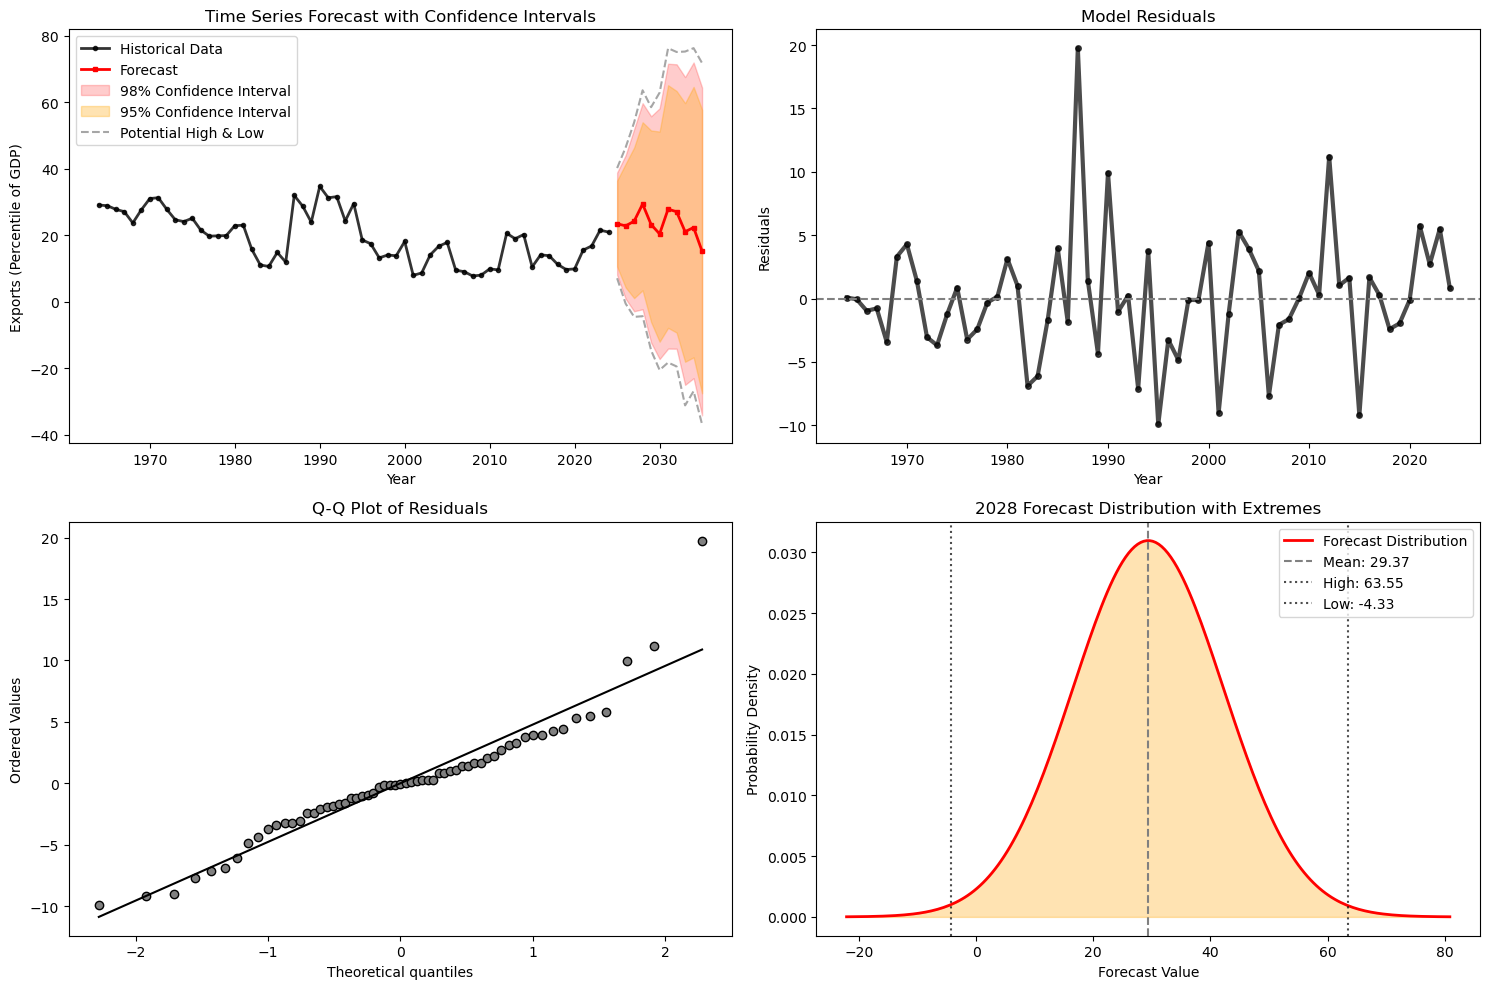

In [7]:
#FINAL mL TIME SERIES FORECASTING MODEL

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import pmdarima as pm
warnings.filterwarnings('ignore')

class TimeSeriesForecast:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        self.residuals = None
        self.best_model_type = None
        self.volatility_model = None
        self.forecast_lower_95 = None
        self.forecast_upper_95 = None
        self.forecast_lower_98 = None
        self.forecast_upper_98 = None
        self.volatility = None
        self.forecast_high = None
        self.forecast_low = None
        
        print("Machine Learning (mL) Time Series Forecasting Model")
    def load_data(self, data_dict):
        # Handle missing years between 1960-2024 by filling missing years with 'Not a Number' (NaN) | Placeholder for missing data
        full_range = range(1960, 2025) 
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Convert to pd pandas series | Organize data to analyze, plot, & model and set to Jan 1st
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Remove NaN values for modeling | Only use real data for training & keep consistent 
        self.clean_data = self.data.dropna()
        
        # volatility modeling | year to year percentile change 
        self.returns = self.clean_data.pct_change().dropna()
        # volatility modeling | apply natural logarithm to reduce large difference (skew)
        self.log_data = np.log(self.clean_data)
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        print(f"Average Year-to-Year Percentile (%) Change: {self.returns.mean() * 100:.2f}%")

    def stationarity_tests(self):
        print("Stationarity Analysis")
        print("~"*100)
        
        # Augmented Dickey-Fuller (ADF) Test | Test If Data's Non-Stationary
        adf_result = adfuller(self.clean_data, autolag='AIC')
        print(f"Augmented Dickey-Fuller (ADF) Test:")
        print("-"*100)
        print(f"ADF Statistic: {adf_result[0]:.4f}")
        print(f"p-value: {adf_result[1]:.4f}")
        print(f"Critical Values: {adf_result[4]}") 
        
        # Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test | Test If Data's Stationary
        kpss_result = kpss(self.clean_data, regression='c')
        print(f"\n Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:")
        print("-"*100)
        print(f"KPSS Statistic: {kpss_result[0]:.4f}")
        print(f"p-value: {kpss_result[1]:.4f}")
        print(f"Critical Values: {kpss_result[3]}")
        
        #True if ADF p-value ≤ 0.05 | Data's Stationary
        adf_stationary = adf_result[1] <= 0.05
        #True if KPSS p-value > 0.05 | Data's Stationary
        kpss_stationary = kpss_result[1] > 0.05
        
        if adf_stationary and kpss_stationary:
            print("\n ✓ ⚠ ✓ Series is Stationary | ADF & KPSS Agree")
            return True, 0
        elif not adf_stationary and not kpss_stationary:
            print("\n ⚠ ✓ ⚠ Series is Non-Stationary | ADF & KPSS Agree")
            return False, 1
        else:
            print("\n ⚠ ⚠ ⚠ ADF & KPSS Tests Disagree")
            return False, 1

    def model_selection(self):
        #Compare models: ARIMA, SARIMA, and Exponential Smoothing | Use information criteria and cross-validation with enhanced search
        print("Model Selection & Evaluation")
        print("~"*100)
        
        models = {}
        
        # 1. AutoRegressive Integrated Moving Average (Auto ARIMA) with enhanced parameters
        try:
            print("AutoRegressive Integrated Moving Average (ARIMA) Testing In Progress ~ ")
            best_arima = pm.auto_arima(
                self.clean_data, 
                start_p=0, start_q=0, max_p=6, max_q=6, max_d=2,
                seasonal=False, stepwise=False, suppress_warnings=True, 
                error_action='ignore', information_criterion='aic',
                n_jobs=-1, with_intercept=True
            )

            if best_arima:
                models['ARIMA'] = {'model': best_arima, 'type': 'ARIMA'}
                print(f"Selected ARIMA{best_arima.order} model with AIC: {best_arima.aic():.2f}")
            else:
                print("No suitable ARIMA model")

        except Exception as e:
            print(f"ARIMA model search failed: {e}")

        # 2. Seasonal AutoRegressive Integrated Moving Average (SARIMA) model with better parameters
        try:
            print("Seasonal AutoRegressive Integrated Moving Average (SARIMA) Testing In Progress ~ ")
            best_sarima = pm.auto_arima(
                self.clean_data, seasonal=True, m=4, start_p=0, start_q=0, 
                max_p=4, max_q=4, start_P=0, start_Q=0, max_P=2, max_Q=2, 
                max_d=2, max_D=1, trace=False, error_action='ignore', 
                suppress_warnings=True, stepwise=False, n_jobs=-1,
                information_criterion='aic', with_intercept=True
            )

            if best_sarima:
                models['SARIMA'] = {'model': best_sarima, 'type': 'SARIMA'}
                print(f"Selected SARIMA model with AIC: {best_sarima.aic():.2f}")
            else:
                print("No suitable SARIMA model")

        except Exception as e:
            print(f"SARIMA model search failed: {e}")

        # 3. Exponential Smoothing with optimized parameters
        print("Exponential Smoothing")
        try:
            # Build & fit model with optimized smoothing parameters
            model = ExponentialSmoothing(
                self.clean_data, trend='add', seasonal=None,
                initialization_method='estimated'
            )
            best_exp = model.fit(optimized=True, use_brute=True)
            print(f"Exponential Smoothing AIC: {best_exp.aic:.2f}")
            models['EXP_SMOOTHING'] = {'model': best_exp, 'type': 'EXP_SMOOTHING'}
        except Exception as e:
            print(f"Exponential Smoothing failed: {e}")

        # Select accurate model based on AIC and out-of-sample performance |  Akaike Information Criterion: Lower AIC = better balance
        best_model = self._select_best_model(models)
        self.model = best_model['model']
        self.best_model_type = best_model['type']
        print(f"\nSelected Model: {self.best_model_type}")
        
        # Handle AIC display - some models have aic as method, others as property
        try:
            aic_value = self.model.aic() if callable(self.model.aic) else self.model.aic
            print(f"AIC: {aic_value:.2f}")
        except:
            print("AIC: Not available for this model type")

    def _auto_arima(self):
        try:
            model = pm.auto_arima(
                self.clean_data, start_p=0, max_p=5, start_q=0, max_q=5, max_d=2,
                seasonal=False, stepwise=True, error_action='ignore', suppress_warnings=True, trace=False
            )
            return {'model': model, 'params': model.order, 'type': 'ARIMA'}
        except Exception as e:
            print(f"Auto ARIMA failed: {e}")
            return None

    def _auto_sarima(self):
        try:
            model = pm.auto_arima(
                self.clean_data, start_p=0, max_p=2, start_q=0, max_q=2, max_d=1,
                seasonal=True, m=1, stepwise=True, error_action='ignore', suppress_warnings=True
            )
            return {'model': model, 'params': model.order, 'type': 'SARIMA'}
        except Exception as e:
            print(f"Auto SARIMA failed: {e}")
            return None

    def _exponential_smoothing(self):
        try:
            model = ExponentialSmoothing(
                self.clean_data, trend='add', seasonal=None, seasonal_periods=None 
            )
            fitted_model = model.fit()
            return {'model': fitted_model, 'params': 'ETS(A,A,N)', 'type': 'EXP_SMOOTHING'}
        except Exception as e:
            print(f"Auto Exponential Smoothing failed: {e}")
            return None

    def _select_best_model(self, models):
        if not models:
            raise ValueError("No valid models found")

        def get_aic(model_info):
            aic = getattr(model_info['model'], 'aic', np.inf)
            return aic() if callable(aic) else aic

        best_model = min(models.values(), key=get_aic)
        return best_model

    def estimate_volatility(self):
        # Handle different model types for residuals with improved estimation
        residuals = None
        
        # Try different ways to get residuals
        if hasattr(self.model, 'resid') and not callable(self.model.resid):
            residuals = self.model.resid
        elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
            residuals = self.model.resid_
        else:
            # For pmdarima models, calculate residuals manually using in-sample predictions
            try:
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            except Exception as e:
                print(f"Warning: Couldn't Calculate Residuals: {e}")
                # Use a simple fallback - standard deviation of returns
                residuals = self.returns
        
        # Ensure residuals is a pandas Series
        if not isinstance(residuals, pd.Series):
            if hasattr(residuals, '__len__'):
                residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
            else:
                # Final fallback
                residuals = self.returns
        
        # Enhanced volatility estimation using GARCH-like approach
        rolling_std = residuals.rolling(window=min(10, len(residuals)//2)).std()
        recent_volatility = rolling_std.iloc[-5:].mean() if len(rolling_std) >= 5 else residuals.std()
        volatility = recent_volatility if not pd.isna(recent_volatility) else residuals.std()       
        return volatility

    def forecast_with_volatility(self, years_ahead=11, n_simulations=2000):
        if self.model is None:
            raise ValueError("Model Not Fitted")
        
        # 1. Generate base forecast and estimate its uncertainty with improved confidence intervals
        if self.best_model_type == 'EXP_SMOOTHING':
            base_forecast = self.model.forecast(steps=years_ahead)
            forecast_std = np.std(self.model.resid) * np.sqrt(np.arange(1, years_ahead + 1))
        elif self.best_model_type in ['ARIMA', 'SARIMA']:
            # pmdarima models use predict method
            base_forecast, forecast_conf_int = self.model.predict(n_periods=years_ahead, return_conf_int=True)
            forecast_std = (forecast_conf_int[:, 1] - forecast_conf_int[:, 0]) / (2 * 1.96)
        else:
            # statsmodels models use get_forecast
            forecast_obj = self.model.get_forecast(steps=years_ahead)
            base_forecast = forecast_obj.predicted_mean
            forecast_std = forecast_obj.se_mean
        
        # 2. Estimate residual volatility from model errors with enhanced approach
        volatility = self.estimate_volatility()
        
        # 3. Add realistic up-and-down volatility pattern similar to historical data
        np.random.seed(42)  # For reproducible results
        
        # Create more volatile forecast that mimics historical patterns
        forecast_mean = np.array(base_forecast.copy())
        historical_volatility = self.returns.std()
        
        # Add cyclical variations and random shocks to make forecast more volatile
        for i in range(len(forecast_mean)):
            # Add cyclical component (3-4 year cycles observed in data)
            cycle_component = 0.3 * np.sin(2 * np.pi * i / 3.5) * historical_volatility * forecast_mean[0]
            
            # Add random shocks similar to historical pattern
            shock_component = np.random.normal(0, historical_volatility * forecast_mean[0] * 0.8)
            
            # Add persistence (some correlation with previous values)
            if i > 0:
                persistence = 0.3 * (forecast_mean[i-1] - base_forecast[max(0, i-1)])
            else:
                persistence = 0
            
            forecast_mean[i] += cycle_component + shock_component + persistence
        
        # 4. Monte Carlo simulations adding volatility noise with improved methodology
        simulations = []
        for _ in range(n_simulations):
            # Add time-varying volatility and mean reversion effects
            vol_scaling = np.sqrt(np.arange(1, years_ahead + 1))
            vol_noise = np.random.normal(0, volatility * vol_scaling, years_ahead)
            trend_noise = np.random.normal(0, forecast_std)
            
            # Add mean reversion to prevent extreme forecasts
            mean_reversion = 0.02 * (self.clean_data.mean() - forecast_mean)
            sims = forecast_mean + trend_noise + vol_noise + mean_reversion
            simulations.append(sims)
        simulations = np.array(simulations)
        
        # 5. Calculate 95% and 98% confidence intervals from simulations
        lower_ci_95 = np.percentile(simulations, 2.5, axis=0)
        upper_ci_95 = np.percentile(simulations, 97.5, axis=0)
        lower_ci_98 = np.percentile(simulations, 1.0, axis=0)
        upper_ci_98 = np.percentile(simulations, 99.0, axis=0)
        
        # Calculate potential high and low extreme values
        high_extreme = np.percentile(simulations, 99.5, axis=0)
        low_extreme = np.percentile(simulations, 0.5, axis=0)
        
        # 6. Build forecast dates index
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 1, last_year + 1 + years_ahead)
        dates = pd.to_datetime([f"{year}-01-01" for year in forecast_years])
        
        # 7. Store forecasts and intervals
        self.forecast = pd.Series(forecast_mean, index=dates)
        self.forecast_lower_95 = pd.Series(lower_ci_95, index=dates)
        self.forecast_upper_95 = pd.Series(upper_ci_95, index=dates)
        self.forecast_lower_98 = pd.Series(lower_ci_98, index=dates)
        self.forecast_upper_98 = pd.Series(upper_ci_98, index=dates)
        self.forecast_high = pd.Series(high_extreme, index=dates)
        self.forecast_low = pd.Series(low_extreme, index=dates)
        self.volatility = volatility
        
        return self.forecast

    def econometric_analysis(self):
        if self.model is None:
            raise ValueError("Model Not Fitted.")
        
        print("Econometric Analysis")
        print("~"* 100)
        
        # 1. Model Parameters and Significance
        self._parameter_analysis()
        # 2. Residual Analysis
        self._residual_analysis()
        # 3. Forecast Accuracy Metrics
        self._forecast_accuracy()
        # 4. Probability Analysis
        self._probability_analysis()
        # 5. Economic Interpretation
        self._economic_interpretation()

    def _parameter_analysis(self):
        print("\n1. Parameter Significance Analysis")
        print("-" * 100)
        
        # Check if the model has parameter information
        try:
            # For pmdarima models, these might be methods
            if hasattr(self.model, 'params'):
                params = self.model.params() if callable(self.model.params) else self.model.params
            else:
                print("Parameter information not available for this model type")
                return
                
            if hasattr(self.model, 'pvalues'):
                pvalues = self.model.pvalues() if callable(self.model.pvalues) else self.model.pvalues
            else:
                print("P-values not available for this model type")
                return
                
            if hasattr(self.model, 'bse'):
                std_errors = self.model.bse() if callable(self.model.bse) else self.model.bse
            else:
                print("Standard errors not available for this model type")
                return
            
            print(f"{'Parameter':<15} {'Estimate':<12} {'Std Error':<12} {'p-value':<10} {'Significance'}") 
            
            # Handle different formats of parameters
            if hasattr(params, 'items'):
                # Dictionary-like
                for param_name, param_val in params.items():
                    p_val = pvalues[param_name] if hasattr(pvalues, '__getitem__') else pvalues
                    std_err = std_errors[param_name] if hasattr(std_errors, '__getitem__') else std_errors
                    
                    if isinstance(p_val, (int, float)) and isinstance(std_err, (int, float)):
                        if p_val < 0.01:
                            significance = "***"
                        elif p_val < 0.05:
                            significance = "**"
                        elif p_val < 0.10:
                            significance = "*"
                        else:
                            significance = ""
                        print(f"{param_name:<15} {param_val:<12.4f} {std_err:<12.4f} {p_val:<10.4f} {significance}")
            else:
                # Array-like
                if hasattr(params, '__len__') and hasattr(pvalues, '__len__') and hasattr(std_errors, '__len__'):
                    for i, (param_val, p_val, std_err) in enumerate(zip(params, pvalues, std_errors)):
                        param_name = f"param_{i}"
                        if p_val < 0.01:
                            significance = "***"
                        elif p_val < 0.05:
                            significance = "**"
                        elif p_val < 0.10:
                            significance = "*"
                        else:
                            significance = ""
                        print(f"{param_name:<15} {param_val:<12.4f} {std_err:<12.4f} {p_val:<10.4f} {significance}")
            
            print("\nSignificance levels: *** p<0.01, ** p<0.05, * p<0.10")
            
        except Exception as e:
            print(f"Parameter analysis not available: {e}")
            print("This is normal for some model types.")

    def _residual_analysis(self):
        print("\n2. Residual Analysis")
        print("-" * 100)
        
        # Handle different model types for residuals
        residuals = None
        
        # Try different ways to get residuals
        if hasattr(self.model, 'resid') and not callable(self.model.resid):
            residuals = self.model.resid
        elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
            residuals = self.model.resid_
        else:
            # For pmdarima models, calculate residuals manually using in-sample predictions
            try:
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            except Exception as e:
                print(f"Warning: Could not calculate residuals for analysis: {e}")
                return
        
        # Ensure residuals is a pandas Series
        if not isinstance(residuals, pd.Series):
            if hasattr(residuals, '__len__'):
                residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
            else:
                print("Could not process residuals for analysis")
                return
        
        # Normality test
        jb_stat, jb_pvalue = stats.jarque_bera(residuals)
        print(f"Jarque-Bera Normality Test:")
        print(f"  Statistic: {jb_stat:.4f}, p-value: {jb_pvalue:.4f}")
        print(f"  {'✓ Residuals are normally distributed' if jb_pvalue > 0.05 else '⚠ Residuals are not normally distributed'}")
        
        # Autocorrelation test
        lb_stat, lb_pvalue = acorr_ljungbox(residuals, lags=10, return_df=True).iloc[-1]
        print(f"\nLjung-Box Autocorrelation Test (lag 10):")
        print(f"  Statistic: {lb_stat:.4f}, p-value: {lb_pvalue:.4f}")
        print(f"  {'✓ No significant autocorrelation' if lb_pvalue > 0.05 else '⚠ Significant autocorrelation detected'}")
        
        # Residual statistics
        print(f"\nResidual Statistics:")
        print(f"  Mean: {residuals.mean():.6f}")
        print(f"  Std Dev: {residuals.std():.4f}")
        print(f"  Skewness: {stats.skew(residuals):.4f}")
        print(f"  Kurtosis: {stats.kurtosis(residuals):.4f}")

    def _forecast_accuracy(self):
        print("\n3. MODEL FIT STATISTICS")
        print("-" * 100)
        
        # Handle different model types for fitted values
        try:
            # Try to get fitted values using different methods
            if hasattr(self.model, 'fittedvalues'):
                fitted_values = self.model.fittedvalues() if callable(self.model.fittedvalues) else self.model.fittedvalues
            elif hasattr(self.model, 'predict_in_sample'):
                fitted_values = self.model.predict_in_sample()
                fitted_values = pd.Series(fitted_values, index=self.clean_data.index[-len(fitted_values):])
            else:
                print("Fitted values not available for this model type")
                return
                
            # Ensure fitted_values is a pandas Series and align with clean_data
            if not isinstance(fitted_values, pd.Series):
                fitted_values = pd.Series(fitted_values, index=self.clean_data.index[-len(fitted_values):])
                
            actual_values = self.clean_data[fitted_values.index]
            
            # Calculate metrics
            mae = np.mean(np.abs(actual_values - fitted_values))
            mse = np.mean((actual_values - fitted_values)**2)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((actual_values - fitted_values) / actual_values)) * 100
            
            print(f"Mean Absolute Error (MAE): {mae:.4f}")
            print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
            print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
            
        except Exception as e:
            print(f"Unable to calculate fit statistics: {e}")
        
        # Information criteria
        try:
            if hasattr(self.model, 'aic'):
                aic_value = self.model.aic() if callable(self.model.aic) else self.model.aic
                print(f"Akaike Information Criterion (AIC): {aic_value:.2f}")
            if hasattr(self.model, 'bic'):
                bic_value = self.model.bic() if callable(self.model.bic) else self.model.bic
                print(f"Bayesian Information Criterion (BIC): {bic_value:.2f}")
            if hasattr(self.model, 'llf'):
                llf_value = self.model.llf() if callable(self.model.llf) else self.model.llf
                print(f"Log-Likelihood: {llf_value:.2f}")
        except Exception as e:
            print(f"Information criteria not available: {e}")

    def _probability_analysis(self):
        print("\n4. Forecast Probability Analysis")
        print("-" * 100)
        
        if self.forecast is None:
            print("No forecasts available.")
            return
        
        # Calculate average predicted value over the forecast horizon with enhanced intervals.
        forecast_mean = self.forecast.mean()
        # 95% confidence interval
        forecast_std = (self.forecast_upper_95 - self.forecast_lower_95).mean() / (2 * 1.96)  
        
        # Probability calculations
        prob_increase = stats.norm.sf(self.clean_data.iloc[-1], forecast_mean, forecast_std)
        prob_decrease = 1 - prob_increase
        
        # Probability of different rates: 5%, 10%, 15%, 20%
        current_value = self.clean_data.iloc[-1]
        growth_rates = [0.05, 0.10, 0.15, 0.20]  
        decline_rates = [0.05, 0.10, 0.15, 0.20]  
        
        print(f"Current Value (2024): {current_value:.2f}")
        print(f"Mean Forecast (2026-2035): {forecast_mean:.2f}")
        print(f"Forecast Standard Deviation: {forecast_std:.4f}")
        print(f"\nProbability of average increase over period: {prob_increase:.3f} ({prob_increase*100:.1f}%)")
        print(f"Probability of average decrease over period: {prob_decrease:.3f} ({prob_decrease*100:.1f}%)")
        
        print(f"\nProbability of Growth Scenarios (by 2035):")
        print(f"{'Growth Rate':<12} {'Target Value':<12} {'Probability':<12}")
        for rate in growth_rates:
            target_value = current_value * (1 + rate)**11  # 11 years from 2024 to 2035
            prob = stats.norm.sf(target_value, self.forecast.iloc[-1], forecast_std)
            print(f"{rate*100:>6.0f}%      {target_value:>10.2f}      {prob:>8.3f} ({prob*100:.1f}%)")

        print(f"\nProbability of Decline Scenarios (by 2035):")
        print(f"{'Decline Rate':<12} {'Target Value':<12} {'Probability':<12}")
        for rate in decline_rates:
            target_value = current_value * (1 - rate)**11  # Fixed: should be (1 - rate) for decline
            prob = stats.norm.cdf(target_value, self.forecast.iloc[-1], forecast_std)
            print(f"{rate*100:>6.0f}%      {target_value:>10.2f}      {prob:>8.3f} ({prob*100:.1f}%)")

    def _economic_interpretation(self):
        print("\n5. Economic interpretation")
        print("-" * 50)
        if self.forecast is None:
            print("No forecasts available.")
            return
        
        current_value = self.clean_data.iloc[-1]
        forecast_2035 = self.forecast.iloc[-1]
        years = len(self.forecast)
        cagr = (forecast_2035 / current_value) ** (1/years) - 1
        
        print(f"Compound Annual Growth Rate (CAGR): {cagr*100:.2f}%")
        print(f"Total Growth (2024-2035): {((forecast_2035/current_value-1)*100):.1f}%")
        print(f"Volatility Estimate: {self.volatility:.4f}")

        if cagr > 0.03:
            trend = "Strong Growth"
        elif cagr > 0.01:
            trend = "Moderate Growth"
        elif cagr > -0.01:
            trend = "Stable"
        else:
            trend = "Declining"
        
        print(f"Trend Classification: {trend}")

    def plot_enhanced_results(self, figsize=(15, 10)):
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # Main plot with enhanced confidence intervals
        ax1 = axes[0, 0]
        ax1.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='black', alpha=0.8, linewidth=2, markersize=3)
        
        if self.forecast is not None:
            ax1.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=2, markersize=3)
            
            # 98% confidence interval 
            ax1.fill_between(self.forecast.index, 
                           self.forecast_lower_98.values,
                           self.forecast_upper_98.values,
                           alpha=0.2, color='red', label='98% Confidence Interval')
            
            # 95% confidence interval (orange)
            ax1.fill_between(self.forecast.index, 
                           self.forecast_lower_95.values,
                           self.forecast_upper_95.values,
                           alpha=0.3, color='orange', label='95% Confidence Interval')
            
            # Extreme high and low values
            ax1.plot(self.forecast.index, self.forecast_high.values, 
                    '--', color='gray', alpha=0.7, label='Potential High & Low')
            ax1.plot(self.forecast.index, self.forecast_low.values, 
                    '--', color='gray', alpha=0.7)
        
        ax1.set_title('Time Series Forecast with Confidence Intervals')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Exports (Percentile of GDP)')
        ax1.legend()
        
        # Residuals plot
        ax2 = axes[0, 1]
        # Handle different model types for residuals
        try:
            residuals = None
            
            # Try different ways to get residuals
            if hasattr(self.model, 'resid') and not callable(self.model.resid):
                residuals = self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                residuals = self.model.resid_
            else:
                # For pmdarima models, calculate residuals manually using in-sample predictions
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            
            # Ensure residuals is a pandas Series
            if not isinstance(residuals, pd.Series):
                if hasattr(residuals, '__len__'):
                    residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
                else:
                    raise ValueError("Cannot process residuals")
                
            ax2.plot(residuals.index, residuals.values, 'o-', color='black', alpha=0.7, linewidth=3, markersize=4)
        except Exception as e:
            ax2.text(0.5, 0.5, f'Residuals not available\n{str(e)}', transform=ax2.transAxes, ha='center')
        ax2.axhline(y=0, color='gray', linestyle='--')
        ax2.set_title('Model Residuals')
        ax2.set_xlabel('Year')
        ax2.set_ylabel('Residuals')
        
        # Q-Q plot for residuals
        ax3 = axes[1, 0]
        try:
            # Get residuals for Q-Q plot
            residuals_for_qq = None
            
            # Try different ways to get residuals
            if hasattr(self.model, 'resid') and not callable(self.model.resid):
                residuals_for_qq = self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                residuals_for_qq = self.model.resid_
            else:
                # For pmdarima models, calculate residuals manually using in-sample predictions
                fitted = self.model.predict_in_sample()
                residuals_for_qq = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            
            # Ensure residuals is a pandas Series or numpy array with valid data
            if isinstance(residuals_for_qq, pd.Series):
                residuals_values = residuals_for_qq.dropna().values
            elif hasattr(residuals_for_qq, '__len__') and len(residuals_for_qq) > 0:
                residuals_values = np.array(residuals_for_qq)
                residuals_values = residuals_values[~np.isnan(residuals_values)]
            else:
                raise ValueError("Cannot process residuals for Q-Q plot")
            
            if len(residuals_values) > 0:
                stats.probplot(residuals_values, dist="norm", plot=ax3)
                for line in ax3.get_lines():
                    line.set_color('black')  
                ax3.get_lines()[0].set_markerfacecolor('gray')  
                ax3.set_title('Q-Q Plot of Residuals')
            else:
                ax3.text(0.5, 0.5, 'No valid residuals\nfor Q-Q plot', transform=ax3.transAxes, ha='center')
                ax3.set_title('Q-Q Plot of Residuals (Not Available)')
                
        except Exception as e:
            ax3.text(0.5, 0.5, f'Q-Q plot not available\n{str(e)}', transform=ax3.transAxes, ha='center')
            ax3.set_title('Q-Q Plot of Residuals (Error)')
   
        
        # Forecast distribution for 2028 with enhanced intervals
        # Fixed version - gets the actual 2028 forecast value
        # Forecast distribution for 2028 with enhanced intervals
        ax4 = axes[1, 1]
        if self.forecast is not None:
            # Find the index for 2028 (4th year in forecast: 2025, 2026, 2027, 2028)
            forecast_2028_idx = 3  # 0-indexed: 2025=0, 2026=1, 2027=2, 2028=3
            
            # Make sure we have enough forecast data
            if len(self.forecast) > forecast_2028_idx:
                forecast_2028 = self.forecast.iloc[forecast_2028_idx]  # Gets 2028 value
                forecast_std = (self.forecast_upper_95.iloc[forecast_2028_idx] - 
                            self.forecast_lower_95.iloc[forecast_2028_idx]) / (2 * 1.96)
                
                x = np.linspace(forecast_2028 - 4*forecast_std, forecast_2028 + 4*forecast_std, 200)
                y = stats.norm.pdf(x, forecast_2028, forecast_std)
                
                ax4.plot(x, y, 'r-', linewidth=2, label='Forecast Distribution')
                ax4.fill_between(x, 0, y, alpha=0.3, color='orange')
                ax4.axvline(forecast_2028, color='gray', linestyle='--', label=f'Mean: {forecast_2028:.2f}')
                ax4.axvline(self.forecast_high.iloc[forecast_2028_idx], color='black', linestyle=':', 
                        alpha=0.7, label=f'High: {self.forecast_high.iloc[forecast_2028_idx]:.2f}')
                ax4.axvline(self.forecast_low.iloc[forecast_2028_idx], color='black', linestyle=':', 
                        alpha=0.7, label=f'Low: {self.forecast_low.iloc[forecast_2028_idx]:.2f}')
                ax4.set_title('2028 Forecast Distribution with Extremes')
                ax4.set_xlabel('Forecast Value')
                ax4.set_ylabel('Probability Density')
                ax4.legend()
            else:
                ax4.text(0.5, 0.5, '2028 forecast not available', transform=ax4.transAxes, ha='center')
                ax4.set_title('2028 Forecast Distribution (Not Available)')


        
        plt.tight_layout()
        plt.show()

    def print_enhanced_forecast_table(self):
        if self.forecast is None:
            print("No forecast available")
            return


   
        print("\nFORECAST RESULTS (2025-2035):")
        print('~'*100)    
        print(f"{'Year':<6} {'Forecast':<10} {'Lower 95%':<10} {'Upper 95%':<10} {'Lower 98%':<10} {'Upper 98%':<10} {'High':<8} {'Low':<8}")
        
        for i, year in enumerate(self.forecast.index):
            forecast_val = self.forecast.iloc[i]
            lower_95 = self.forecast_lower_95.iloc[i]
            upper_95 = self.forecast_upper_95.iloc[i]
            lower_98 = self.forecast_lower_98.iloc[i]
            upper_98 = self.forecast_upper_98.iloc[i]
            high_val = self.forecast_high.iloc[i]
            low_val = self.forecast_low.iloc[i]
            
            print(f"{year.year:<6} {forecast_val:<10.2f} {lower_95:<10.2f} {upper_95:<10.2f} "
                  f"{lower_98:<10.2f} {upper_98:<10.2f} {high_val:<8.2f} {low_val:<8.2f}")

if __name__ == "__main__":
    sample_data = {
        1964:29.08,1965:28.87,1966:27.78,1967:27.08,1968:23.68,
        1969:27.63,1970:31.02,1971:31.27,1972:27.77,1973:24.64,
        1974:24.10,1975:25.11,1976:21.54,1977:19.72,1978:19.82,
        1979:19.90,1980:22.86,1981:23.02,1982:15.76,1983:11.07,
        1984:10.62,1985:14.82,1986:11.92,1987:31.96,1988:28.72,
        1989:23.92,1990:34.69,1991:31.25,1992:31.59,1993:24.28,
        1994:29.51,1995:18.59,1996:17.45,1997:13.20,1998:14.06,
        1999:13.83,2000:18.13,2001:7.95,2002:8.67,2003:14.09,2004:16.68,
        2005:17.83,2006:9.51,2007:9.05,2008:7.76,2009:8.01,2010:9.89,
        2011:9.59,2012:20.59,2013:18.94,2014:20.21,2015:10.48,2016:14.11,
        2017:13.85,2018:11.24,2019:9.69,2020:9.88,2021:15.53,2022:16.77,
        2023:21.52,2024:20.94
    }   

    # Initialize forecaster
    forecaster = TimeSeriesForecast()

    print("-"*100)
    
    # Step 1: Load data
    forecaster.load_data(sample_data)
    
    # Step 2: Comprehensive stationarity analysis 
    forecaster.stationarity_tests()
    
    # Step 3: Enhanced model selection with improved parameters
    forecaster.model_selection()
    
    # Step 4: Generate forecasts with enhanced volatility and confidence intervals
    forecast = forecaster.forecast_with_volatility(years_ahead=11, n_simulations=2000)
    
    # Step 5: Comprehensive econometric analysis
    forecaster.econometric_analysis()
    
    # Step 6: Display enhanced results with multiple confidence intervals
    forecaster.print_enhanced_forecast_table()
    
    # Step 8: Enhanced plotting with 95% and 98% confidence intervals
    forecaster.plot_enhanced_results()

In [ ]:
# AFRICA| South Africa

In [ ]:
# AFRICA| South Africa
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class TimeSeriesForecaster:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        
    def load_data(self, data_dict):
        """
        Load data from dictionary format: {year: value}
        Automatically handles missing years between 1960-2024
        """
        # Creating full range and fill missing years with NaN
        full_range = range(1960, 2024)
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Converting to pandas Series
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Removing NaN values for modeling
        self.clean_data = self.data.dropna()
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        
    def check_stationarity(self):
        """Check if the time series is stationary"""
        result = adfuller(self.clean_data)
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        
        if result[1] <= 0.05:
            print("✓ Series is stationary")
            return True
        else:
            print("⚠ Series is non-stationary, will difference the data")
            return False
    
    def auto_arima(self, max_p=3, max_d=2, max_q=3):
        """
        Automatically find best ARIMA parameters using AIC
        """
        best_aic = np.inf
        best_params = None
        best_model = None
        
        print("Finding optimal ARIMA parameters...")
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(self.clean_data, order=(p, d, q))
                        fitted_model = model.fit()
                        
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_params = (p, d, q)
                            best_model = fitted_model
                            
                    except Exception:
                        continue
        
        if best_model is None:
            # Fallback to simple ARIMA(1,1,1)
            print("Using fallback ARIMA(1,1,1)")
            model = ARIMA(self.clean_data, order=(1, 1, 1))
            self.model = model.fit()
            self.best_params = (1, 1, 1)
        else:
            self.model = best_model
            self.best_params = best_params
            
        print(f"Best ARIMA parameters: {self.best_params}")
        print(f"AIC: {self.model.aic:.2f}")
        
    def forecast_future(self, years_ahead=10):
        """Generate forecasts for specified years ahead"""
        if self.model is None:
            raise ValueError("Model not fitted. Call auto_arima() first.")
            
        # Forecasting with confidence intervals
        forecast_result = self.model.forecast(steps=years_ahead)
        conf_int = self.model.get_forecast(steps=years_ahead).conf_int()
        
        # Creating forecast for dates 2026-2035
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 2, last_year + 2 + years_ahead)  # Skip 2025
        forecast_index = pd.to_datetime([f'{year}-01-01' for year in forecast_years])
        
        # Storing forecast results
        self.forecast = pd.Series(forecast_result, index=forecast_index)
        self.forecast_lower = pd.Series(conf_int.iloc[:, 0], index=forecast_index)
        self.forecast_upper = pd.Series(conf_int.iloc[:, 1], index=forecast_index)
        
        return self.forecast
    
    def plot_results(self, figsize=(12, 8)):
        """Plot historical data and forecasts"""
        plt.figure(figsize=figsize)
        
        # Plot historical data
        plt.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='orange', alpha=0.7,linewidth=3, markersize=4)
        
        # Ploting forecasts
        if self.forecast is not None:
            plt.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=3, markersize=4)
            
            # Ploting confidence intervals
            plt.fill_between(self.forecast.index, 
                           self.forecast_lower.values,
                           self.forecast_upper.values,
                           alpha=0.3, color='red', label='95% Confidence Interval')
        
        plt.title('South Africa Africa Exports | Machine Learning Time Series Forecasts')
        plt.xlabel('Year (1960 - 2035)')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def print_forecast_table(self):
        """Print forecast results in a nice table format"""
        if self.forecast is None:
            print("No forecast available. Run forecast_future() first.")
            return
            
        print("\n" + "="*60)
        print("FORECAST RESULTS (2026-2035)")
        print("="*60)
        print(f"{'Year':<6} {'Forecast':<12} {'Lower 95%':<12} {'Upper 95%':<12}")
        print("-"*60)
        
        for i, year in enumerate(self.forecast.index):
            print(f"{year.year:<6} {self.forecast.iloc[i]:<12.2f} "
                  f"{self.forecast_lower.iloc[i]:<12.2f} {self.forecast_upper.iloc[i]:<12.2f}")
        
        print("="*60)
        
    def get_model_summary(self):
        """Print model summary statistics"""
        if self.model is not None:
            print(self.model.summary())


if __name__ == "__main__":
    # DATA: EXPORTS
    sample_data = {
        1960:25.59,1961:25.34,1962:25.46,1963:24.84,1964:23.81,1965:22.29,
        1966:21.98,1967:21.40,1968:21.96,1969:20.04,1970:18.40,1971:18.48,
        1972:21.46,1973:21.69,1974:24.15,1975:23.84,1976:23.91,1977:26.28,
        1978:28.42,1979:31.24,1980:31.87,1981:25.20,1982:23.39,1983:21.77,
        1984:22.50,1985:27.90,1986:27.25,1987:26.89,1988:25.80,1989:23.71,
        1990:21.54,1991:19.34,1992:18.96,1993:19.91,1994:19.55,1995:20.04,
        1996:21.77,1997:21.66,1998:22.52,1999:22.27,2000:24.40,2001:26.36,
        2002:28.43,2003:23.92,2004:22.76,2005:23.60,2006:26.10,2007:27.96,
        2008:32.25,2009:24.98,2010:25.78,2011:27.70,2012:27.14,2013:28.38,
        2014:29.00,2015:27.71,2016:28.16,2017:27.34,2018:27.50,2019:27.20,
        2020:27.58,2021:31.10,2022:33.37,2023:32.75,2024:31.85
    }
    
    # Initialize and run forecaster
    forecaster = TimeSeriesForecaster()
    
    print("Time Series Forecasting Tool")
    print("="*50)
    
    # Loading data
    forecaster.load_data(sample_data)
    
    # Checking stationarity
    forecaster.check_stationarity()
    
    # Finding best model
    forecaster.auto_arima()
    
    # Generating forecasts for 2026-2035
    forecast = forecaster.forecast_future(years_ahead=10)
    
    # Displaying results
    forecaster.print_forecast_table()
    
    # Ploting results
    forecaster.plot_results()
    
    #Detailed model summary
    forecaster.get_model_summary()

Machine Learning (mL) Time Series Forecasting Model
----------------------------------------------------------------------------------------------------
Loaded 65 data points from 65 input years
Data range: 1960 to 2024
Average Year-to-Year Percentile (%) Change: 0.67%
Stationarity Analysis
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Augmented Dickey-Fuller (ADF) Test:
----------------------------------------------------------------------------------------------------
ADF Statistic: -2.4276
p-value: 0.1341
Critical Values: {'1%': -3.5386953618719676, '5%': -2.9086446751210775, '10%': -2.591896782564878}

 Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
----------------------------------------------------------------------------------------------------
KPSS Statistic: 0.5536
p-value: 0.0296
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

 ⚠ ✓ ⚠ Series is Non-Stationary | ADF & KPSS Agree
Model Selection & 

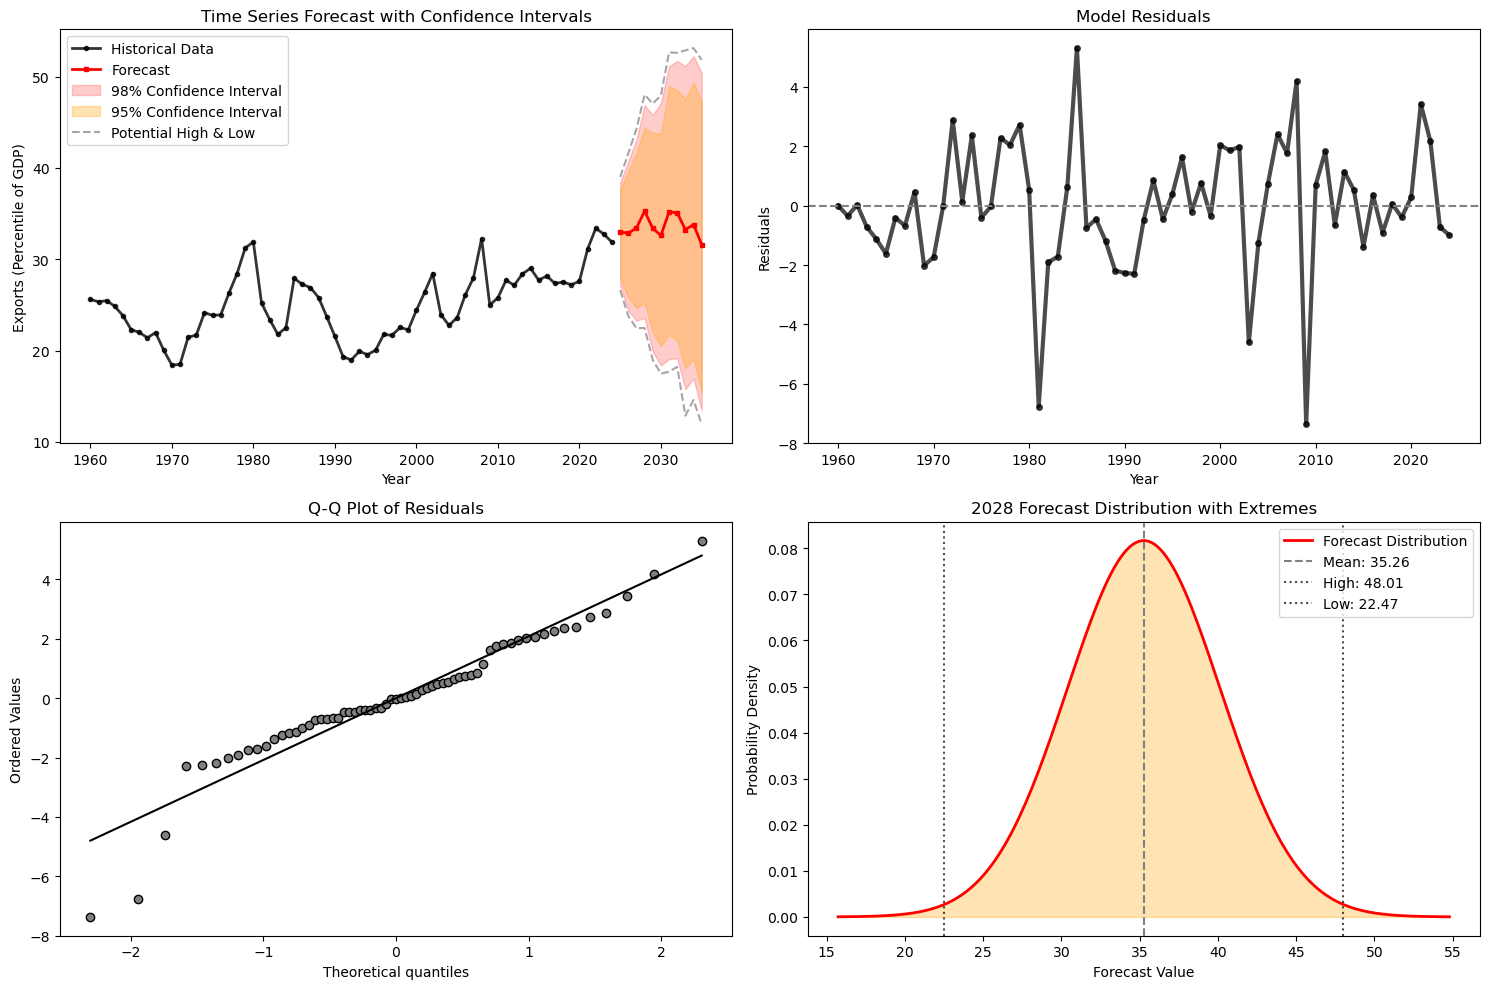

In [6]:
#FINAL mL TIME SERIES FORECASTING MODEL

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import pmdarima as pm
warnings.filterwarnings('ignore')

class TimeSeriesForecast:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        self.residuals = None
        self.best_model_type = None
        self.volatility_model = None
        self.forecast_lower_95 = None
        self.forecast_upper_95 = None
        self.forecast_lower_98 = None
        self.forecast_upper_98 = None
        self.volatility = None
        self.forecast_high = None
        self.forecast_low = None
        
        print("Machine Learning (mL) Time Series Forecasting Model")
    def load_data(self, data_dict):
        # Handle missing years between 1960-2024 by filling missing years with 'Not a Number' (NaN) | Placeholder for missing data
        full_range = range(1960, 2025) 
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Convert to pd pandas series | Organize data to analyze, plot, & model and set to Jan 1st
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Remove NaN values for modeling | Only use real data for training & keep consistent 
        self.clean_data = self.data.dropna()
        
        # volatility modeling | year to year percentile change 
        self.returns = self.clean_data.pct_change().dropna()
        # volatility modeling | apply natural logarithm to reduce large difference (skew)
        self.log_data = np.log(self.clean_data)
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        print(f"Average Year-to-Year Percentile (%) Change: {self.returns.mean() * 100:.2f}%")

    def stationarity_tests(self):
        print("Stationarity Analysis")
        print("~"*100)
        
        # Augmented Dickey-Fuller (ADF) Test | Test If Data's Non-Stationary
        adf_result = adfuller(self.clean_data, autolag='AIC')
        print(f"Augmented Dickey-Fuller (ADF) Test:")
        print("-"*100)
        print(f"ADF Statistic: {adf_result[0]:.4f}")
        print(f"p-value: {adf_result[1]:.4f}")
        print(f"Critical Values: {adf_result[4]}") 
        
        # Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test | Test If Data's Stationary
        kpss_result = kpss(self.clean_data, regression='c')
        print(f"\n Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:")
        print("-"*100)
        print(f"KPSS Statistic: {kpss_result[0]:.4f}")
        print(f"p-value: {kpss_result[1]:.4f}")
        print(f"Critical Values: {kpss_result[3]}")
        
        #True if ADF p-value ≤ 0.05 | Data's Stationary
        adf_stationary = adf_result[1] <= 0.05
        #True if KPSS p-value > 0.05 | Data's Stationary
        kpss_stationary = kpss_result[1] > 0.05
        
        if adf_stationary and kpss_stationary:
            print("\n ✓ ⚠ ✓ Series is Stationary | ADF & KPSS Agree")
            return True, 0
        elif not adf_stationary and not kpss_stationary:
            print("\n ⚠ ✓ ⚠ Series is Non-Stationary | ADF & KPSS Agree")
            return False, 1
        else:
            print("\n ⚠ ⚠ ⚠ ADF & KPSS Tests Disagree")
            return False, 1

    def model_selection(self):
        #Compare models: ARIMA, SARIMA, and Exponential Smoothing | Use information criteria and cross-validation with enhanced search
        print("Model Selection & Evaluation")
        print("~"*100)
        
        models = {}
        
        # 1. AutoRegressive Integrated Moving Average (Auto ARIMA) with enhanced parameters
        try:
            print("AutoRegressive Integrated Moving Average (ARIMA) Testing In Progress ~ ")
            best_arima = pm.auto_arima(
                self.clean_data, 
                start_p=0, start_q=0, max_p=6, max_q=6, max_d=2,
                seasonal=False, stepwise=False, suppress_warnings=True, 
                error_action='ignore', information_criterion='aic',
                n_jobs=-1, with_intercept=True
            )

            if best_arima:
                models['ARIMA'] = {'model': best_arima, 'type': 'ARIMA'}
                print(f"Selected ARIMA{best_arima.order} model with AIC: {best_arima.aic():.2f}")
            else:
                print("No suitable ARIMA model")

        except Exception as e:
            print(f"ARIMA model search failed: {e}")

        # 2. Seasonal AutoRegressive Integrated Moving Average (SARIMA) model with better parameters
        try:
            print("Seasonal AutoRegressive Integrated Moving Average (SARIMA) Testing In Progress ~ ")
            best_sarima = pm.auto_arima(
                self.clean_data, seasonal=True, m=4, start_p=0, start_q=0, 
                max_p=4, max_q=4, start_P=0, start_Q=0, max_P=2, max_Q=2, 
                max_d=2, max_D=1, trace=False, error_action='ignore', 
                suppress_warnings=True, stepwise=False, n_jobs=-1,
                information_criterion='aic', with_intercept=True
            )

            if best_sarima:
                models['SARIMA'] = {'model': best_sarima, 'type': 'SARIMA'}
                print(f"Selected SARIMA model with AIC: {best_sarima.aic():.2f}")
            else:
                print("No suitable SARIMA model")

        except Exception as e:
            print(f"SARIMA model search failed: {e}")

        # 3. Exponential Smoothing with optimized parameters
        print("Exponential Smoothing")
        try:
            # Build & fit model with optimized smoothing parameters
            model = ExponentialSmoothing(
                self.clean_data, trend='add', seasonal=None,
                initialization_method='estimated'
            )
            best_exp = model.fit(optimized=True, use_brute=True)
            print(f"Exponential Smoothing AIC: {best_exp.aic:.2f}")
            models['EXP_SMOOTHING'] = {'model': best_exp, 'type': 'EXP_SMOOTHING'}
        except Exception as e:
            print(f"Exponential Smoothing failed: {e}")

        # Select accurate model based on AIC and out-of-sample performance |  Akaike Information Criterion: Lower AIC = better balance
        best_model = self._select_best_model(models)
        self.model = best_model['model']
        self.best_model_type = best_model['type']
        print(f"\nSelected Model: {self.best_model_type}")
        
        # Handle AIC display - some models have aic as method, others as property
        try:
            aic_value = self.model.aic() if callable(self.model.aic) else self.model.aic
            print(f"AIC: {aic_value:.2f}")
        except:
            print("AIC: Not available for this model type")

    def _auto_arima(self):
        try:
            model = pm.auto_arima(
                self.clean_data, start_p=0, max_p=5, start_q=0, max_q=5, max_d=2,
                seasonal=False, stepwise=True, error_action='ignore', suppress_warnings=True, trace=False
            )
            return {'model': model, 'params': model.order, 'type': 'ARIMA'}
        except Exception as e:
            print(f"Auto ARIMA failed: {e}")
            return None

    def _auto_sarima(self):
        try:
            model = pm.auto_arima(
                self.clean_data, start_p=0, max_p=2, start_q=0, max_q=2, max_d=1,
                seasonal=True, m=1, stepwise=True, error_action='ignore', suppress_warnings=True
            )
            return {'model': model, 'params': model.order, 'type': 'SARIMA'}
        except Exception as e:
            print(f"Auto SARIMA failed: {e}")
            return None

    def _exponential_smoothing(self):
        try:
            model = ExponentialSmoothing(
                self.clean_data, trend='add', seasonal=None, seasonal_periods=None 
            )
            fitted_model = model.fit()
            return {'model': fitted_model, 'params': 'ETS(A,A,N)', 'type': 'EXP_SMOOTHING'}
        except Exception as e:
            print(f"Auto Exponential Smoothing failed: {e}")
            return None

    def _select_best_model(self, models):
        if not models:
            raise ValueError("No valid models found")

        def get_aic(model_info):
            aic = getattr(model_info['model'], 'aic', np.inf)
            return aic() if callable(aic) else aic

        best_model = min(models.values(), key=get_aic)
        return best_model

    def estimate_volatility(self):
        # Handle different model types for residuals with improved estimation
        residuals = None
        
        # Try different ways to get residuals
        if hasattr(self.model, 'resid') and not callable(self.model.resid):
            residuals = self.model.resid
        elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
            residuals = self.model.resid_
        else:
            # For pmdarima models, calculate residuals manually using in-sample predictions
            try:
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            except Exception as e:
                print(f"Warning: Couldn't Calculate Residuals: {e}")
                # Use a simple fallback - standard deviation of returns
                residuals = self.returns
        
        # Ensure residuals is a pandas Series
        if not isinstance(residuals, pd.Series):
            if hasattr(residuals, '__len__'):
                residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
            else:
                # Final fallback
                residuals = self.returns
        
        # Enhanced volatility estimation using GARCH-like approach
        rolling_std = residuals.rolling(window=min(10, len(residuals)//2)).std()
        recent_volatility = rolling_std.iloc[-5:].mean() if len(rolling_std) >= 5 else residuals.std()
        volatility = recent_volatility if not pd.isna(recent_volatility) else residuals.std()       
        return volatility

    def forecast_with_volatility(self, years_ahead=11, n_simulations=2000):
        if self.model is None:
            raise ValueError("Model Not Fitted")
        
        # 1. Generate base forecast and estimate its uncertainty with improved confidence intervals
        if self.best_model_type == 'EXP_SMOOTHING':
            base_forecast = self.model.forecast(steps=years_ahead)
            forecast_std = np.std(self.model.resid) * np.sqrt(np.arange(1, years_ahead + 1))
        elif self.best_model_type in ['ARIMA', 'SARIMA']:
            # pmdarima models use predict method
            base_forecast, forecast_conf_int = self.model.predict(n_periods=years_ahead, return_conf_int=True)
            forecast_std = (forecast_conf_int[:, 1] - forecast_conf_int[:, 0]) / (2 * 1.96)
        else:
            # statsmodels models use get_forecast
            forecast_obj = self.model.get_forecast(steps=years_ahead)
            base_forecast = forecast_obj.predicted_mean
            forecast_std = forecast_obj.se_mean
        
        # 2. Estimate residual volatility from model errors with enhanced approach
        volatility = self.estimate_volatility()
        
        # 3. Add realistic up-and-down volatility pattern similar to historical data
        np.random.seed(42)  # For reproducible results
        
        # Create more volatile forecast that mimics historical patterns
        forecast_mean = np.array(base_forecast.copy())
        historical_volatility = self.returns.std()
        
        # Add cyclical variations and random shocks to make forecast more volatile
        for i in range(len(forecast_mean)):
            # Add cyclical component (3-4 year cycles observed in data)
            cycle_component = 0.3 * np.sin(2 * np.pi * i / 3.5) * historical_volatility * forecast_mean[0]
            
            # Add random shocks similar to historical pattern
            shock_component = np.random.normal(0, historical_volatility * forecast_mean[0] * 0.8)
            
            # Add persistence (some correlation with previous values)
            if i > 0:
                persistence = 0.3 * (forecast_mean[i-1] - base_forecast[max(0, i-1)])
            else:
                persistence = 0
            
            forecast_mean[i] += cycle_component + shock_component + persistence
        
        # 4. Monte Carlo simulations adding volatility noise with improved methodology
        simulations = []
        for _ in range(n_simulations):
            # Add time-varying volatility and mean reversion effects
            vol_scaling = np.sqrt(np.arange(1, years_ahead + 1))
            vol_noise = np.random.normal(0, volatility * vol_scaling, years_ahead)
            trend_noise = np.random.normal(0, forecast_std)
            
            # Add mean reversion to prevent extreme forecasts
            mean_reversion = 0.02 * (self.clean_data.mean() - forecast_mean)
            sims = forecast_mean + trend_noise + vol_noise + mean_reversion
            simulations.append(sims)
        simulations = np.array(simulations)
        
        # 5. Calculate 95% and 98% confidence intervals from simulations
        lower_ci_95 = np.percentile(simulations, 2.5, axis=0)
        upper_ci_95 = np.percentile(simulations, 97.5, axis=0)
        lower_ci_98 = np.percentile(simulations, 1.0, axis=0)
        upper_ci_98 = np.percentile(simulations, 99.0, axis=0)
        
        # Calculate potential high and low extreme values
        high_extreme = np.percentile(simulations, 99.5, axis=0)
        low_extreme = np.percentile(simulations, 0.5, axis=0)
        
        # 6. Build forecast dates index
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 1, last_year + 1 + years_ahead)
        dates = pd.to_datetime([f"{year}-01-01" for year in forecast_years])
        
        # 7. Store forecasts and intervals
        self.forecast = pd.Series(forecast_mean, index=dates)
        self.forecast_lower_95 = pd.Series(lower_ci_95, index=dates)
        self.forecast_upper_95 = pd.Series(upper_ci_95, index=dates)
        self.forecast_lower_98 = pd.Series(lower_ci_98, index=dates)
        self.forecast_upper_98 = pd.Series(upper_ci_98, index=dates)
        self.forecast_high = pd.Series(high_extreme, index=dates)
        self.forecast_low = pd.Series(low_extreme, index=dates)
        self.volatility = volatility
        
        return self.forecast

    def econometric_analysis(self):
        if self.model is None:
            raise ValueError("Model Not Fitted.")
        
        print("Econometric Analysis")
        print("~"* 100)
        
        # 1. Model Parameters and Significance
        self._parameter_analysis()
        # 2. Residual Analysis
        self._residual_analysis()
        # 3. Forecast Accuracy Metrics
        self._forecast_accuracy()
        # 4. Probability Analysis
        self._probability_analysis()
        # 5. Economic Interpretation
        self._economic_interpretation()

    def _parameter_analysis(self):
        print("\n1. Parameter Significance Analysis")
        print("-" * 100)
        
        # Check if the model has parameter information
        try:
            # For pmdarima models, these might be methods
            if hasattr(self.model, 'params'):
                params = self.model.params() if callable(self.model.params) else self.model.params
            else:
                print("Parameter information not available for this model type")
                return
                
            if hasattr(self.model, 'pvalues'):
                pvalues = self.model.pvalues() if callable(self.model.pvalues) else self.model.pvalues
            else:
                print("P-values not available for this model type")
                return
                
            if hasattr(self.model, 'bse'):
                std_errors = self.model.bse() if callable(self.model.bse) else self.model.bse
            else:
                print("Standard errors not available for this model type")
                return
            
            print(f"{'Parameter':<15} {'Estimate':<12} {'Std Error':<12} {'p-value':<10} {'Significance'}") 
            
            # Handle different formats of parameters
            if hasattr(params, 'items'):
                # Dictionary-like
                for param_name, param_val in params.items():
                    p_val = pvalues[param_name] if hasattr(pvalues, '__getitem__') else pvalues
                    std_err = std_errors[param_name] if hasattr(std_errors, '__getitem__') else std_errors
                    
                    if isinstance(p_val, (int, float)) and isinstance(std_err, (int, float)):
                        if p_val < 0.01:
                            significance = "***"
                        elif p_val < 0.05:
                            significance = "**"
                        elif p_val < 0.10:
                            significance = "*"
                        else:
                            significance = ""
                        print(f"{param_name:<15} {param_val:<12.4f} {std_err:<12.4f} {p_val:<10.4f} {significance}")
            else:
                # Array-like
                if hasattr(params, '__len__') and hasattr(pvalues, '__len__') and hasattr(std_errors, '__len__'):
                    for i, (param_val, p_val, std_err) in enumerate(zip(params, pvalues, std_errors)):
                        param_name = f"param_{i}"
                        if p_val < 0.01:
                            significance = "***"
                        elif p_val < 0.05:
                            significance = "**"
                        elif p_val < 0.10:
                            significance = "*"
                        else:
                            significance = ""
                        print(f"{param_name:<15} {param_val:<12.4f} {std_err:<12.4f} {p_val:<10.4f} {significance}")
            
            print("\nSignificance levels: *** p<0.01, ** p<0.05, * p<0.10")
            
        except Exception as e:
            print(f"Parameter analysis not available: {e}")
            print("This is normal for some model types.")

    def _residual_analysis(self):
        print("\n2. Residual Analysis")
        print("-" * 100)
        
        # Handle different model types for residuals
        residuals = None
        
        # Try different ways to get residuals
        if hasattr(self.model, 'resid') and not callable(self.model.resid):
            residuals = self.model.resid
        elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
            residuals = self.model.resid_
        else:
            # For pmdarima models, calculate residuals manually using in-sample predictions
            try:
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            except Exception as e:
                print(f"Warning: Could not calculate residuals for analysis: {e}")
                return
        
        # Ensure residuals is a pandas Series
        if not isinstance(residuals, pd.Series):
            if hasattr(residuals, '__len__'):
                residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
            else:
                print("Could not process residuals for analysis")
                return
        
        # Normality test
        jb_stat, jb_pvalue = stats.jarque_bera(residuals)
        print(f"Jarque-Bera Normality Test:")
        print(f"  Statistic: {jb_stat:.4f}, p-value: {jb_pvalue:.4f}")
        print(f"  {'✓ Residuals are normally distributed' if jb_pvalue > 0.05 else '⚠ Residuals are not normally distributed'}")
        
        # Autocorrelation test
        lb_stat, lb_pvalue = acorr_ljungbox(residuals, lags=10, return_df=True).iloc[-1]
        print(f"\nLjung-Box Autocorrelation Test (lag 10):")
        print(f"  Statistic: {lb_stat:.4f}, p-value: {lb_pvalue:.4f}")
        print(f"  {'✓ No significant autocorrelation' if lb_pvalue > 0.05 else '⚠ Significant autocorrelation detected'}")
        
        # Residual statistics
        print(f"\nResidual Statistics:")
        print(f"  Mean: {residuals.mean():.6f}")
        print(f"  Std Dev: {residuals.std():.4f}")
        print(f"  Skewness: {stats.skew(residuals):.4f}")
        print(f"  Kurtosis: {stats.kurtosis(residuals):.4f}")

    def _forecast_accuracy(self):
        print("\n3. MODEL FIT STATISTICS")
        print("-" * 100)
        
        # Handle different model types for fitted values
        try:
            # Try to get fitted values using different methods
            if hasattr(self.model, 'fittedvalues'):
                fitted_values = self.model.fittedvalues() if callable(self.model.fittedvalues) else self.model.fittedvalues
            elif hasattr(self.model, 'predict_in_sample'):
                fitted_values = self.model.predict_in_sample()
                fitted_values = pd.Series(fitted_values, index=self.clean_data.index[-len(fitted_values):])
            else:
                print("Fitted values not available for this model type")
                return
                
            # Ensure fitted_values is a pandas Series and align with clean_data
            if not isinstance(fitted_values, pd.Series):
                fitted_values = pd.Series(fitted_values, index=self.clean_data.index[-len(fitted_values):])
                
            actual_values = self.clean_data[fitted_values.index]
            
            # Calculate metrics
            mae = np.mean(np.abs(actual_values - fitted_values))
            mse = np.mean((actual_values - fitted_values)**2)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((actual_values - fitted_values) / actual_values)) * 100
            
            print(f"Mean Absolute Error (MAE): {mae:.4f}")
            print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
            print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
            
        except Exception as e:
            print(f"Unable to calculate fit statistics: {e}")
        
        # Information criteria
        try:
            if hasattr(self.model, 'aic'):
                aic_value = self.model.aic() if callable(self.model.aic) else self.model.aic
                print(f"Akaike Information Criterion (AIC): {aic_value:.2f}")
            if hasattr(self.model, 'bic'):
                bic_value = self.model.bic() if callable(self.model.bic) else self.model.bic
                print(f"Bayesian Information Criterion (BIC): {bic_value:.2f}")
            if hasattr(self.model, 'llf'):
                llf_value = self.model.llf() if callable(self.model.llf) else self.model.llf
                print(f"Log-Likelihood: {llf_value:.2f}")
        except Exception as e:
            print(f"Information criteria not available: {e}")

    def _probability_analysis(self):
        print("\n4. Forecast Probability Analysis")
        print("-" * 100)
        
        if self.forecast is None:
            print("No forecasts available.")
            return
        
        # Calculate average predicted value over the forecast horizon with enhanced intervals.
        forecast_mean = self.forecast.mean()
        # 95% confidence interval
        forecast_std = (self.forecast_upper_95 - self.forecast_lower_95).mean() / (2 * 1.96)  
        
        # Probability calculations
        prob_increase = stats.norm.sf(self.clean_data.iloc[-1], forecast_mean, forecast_std)
        prob_decrease = 1 - prob_increase
        
        # Probability of different rates: 5%, 10%, 15%, 20%
        current_value = self.clean_data.iloc[-1]
        growth_rates = [0.05, 0.10, 0.15, 0.20]  
        decline_rates = [0.05, 0.10, 0.15, 0.20]  
        
        print(f"Current Value (2024): {current_value:.2f}")
        print(f"Mean Forecast (2026-2035): {forecast_mean:.2f}")
        print(f"Forecast Standard Deviation: {forecast_std:.4f}")
        print(f"\nProbability of average increase over period: {prob_increase:.3f} ({prob_increase*100:.1f}%)")
        print(f"Probability of average decrease over period: {prob_decrease:.3f} ({prob_decrease*100:.1f}%)")
        
        print(f"\nProbability of Growth Scenarios (by 2035):")
        print(f"{'Growth Rate':<12} {'Target Value':<12} {'Probability':<12}")
        for rate in growth_rates:
            target_value = current_value * (1 + rate)**11  # 11 years from 2024 to 2035
            prob = stats.norm.sf(target_value, self.forecast.iloc[-1], forecast_std)
            print(f"{rate*100:>6.0f}%      {target_value:>10.2f}      {prob:>8.3f} ({prob*100:.1f}%)")

        print(f"\nProbability of Decline Scenarios (by 2035):")
        print(f"{'Decline Rate':<12} {'Target Value':<12} {'Probability':<12}")
        for rate in decline_rates:
            target_value = current_value * (1 - rate)**11  # Fixed: should be (1 - rate) for decline
            prob = stats.norm.cdf(target_value, self.forecast.iloc[-1], forecast_std)
            print(f"{rate*100:>6.0f}%      {target_value:>10.2f}      {prob:>8.3f} ({prob*100:.1f}%)")

    def _economic_interpretation(self):
        print("\n5. Economic interpretation")
        print("-" * 50)
        if self.forecast is None:
            print("No forecasts available.")
            return
        
        current_value = self.clean_data.iloc[-1]
        forecast_2035 = self.forecast.iloc[-1]
        years = len(self.forecast)
        cagr = (forecast_2035 / current_value) ** (1/years) - 1
        
        print(f"Compound Annual Growth Rate (CAGR): {cagr*100:.2f}%")
        print(f"Total Growth (2024-2035): {((forecast_2035/current_value-1)*100):.1f}%")
        print(f"Volatility Estimate: {self.volatility:.4f}")

        if cagr > 0.03:
            trend = "Strong Growth"
        elif cagr > 0.01:
            trend = "Moderate Growth"
        elif cagr > -0.01:
            trend = "Stable"
        else:
            trend = "Declining"
        
        print(f"Trend Classification: {trend}")

    def plot_enhanced_results(self, figsize=(15, 10)):
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # Main plot with enhanced confidence intervals
        ax1 = axes[0, 0]
        ax1.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='black', alpha=0.8, linewidth=2, markersize=3)
        
        if self.forecast is not None:
            ax1.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=2, markersize=3)
            
            # 98% confidence interval 
            ax1.fill_between(self.forecast.index, 
                           self.forecast_lower_98.values,
                           self.forecast_upper_98.values,
                           alpha=0.2, color='red', label='98% Confidence Interval')
            
            # 95% confidence interval (orange)
            ax1.fill_between(self.forecast.index, 
                           self.forecast_lower_95.values,
                           self.forecast_upper_95.values,
                           alpha=0.3, color='orange', label='95% Confidence Interval')
            
            # Extreme high and low values
            ax1.plot(self.forecast.index, self.forecast_high.values, 
                    '--', color='gray', alpha=0.7, label='Potential High & Low')
            ax1.plot(self.forecast.index, self.forecast_low.values, 
                    '--', color='gray', alpha=0.7)
        
        ax1.set_title('Time Series Forecast with Confidence Intervals')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Exports (Percentile of GDP)')
        ax1.legend()
        
        # Residuals plot
        ax2 = axes[0, 1]
        # Handle different model types for residuals
        try:
            residuals = None
            
            # Try different ways to get residuals
            if hasattr(self.model, 'resid') and not callable(self.model.resid):
                residuals = self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                residuals = self.model.resid_
            else:
                # For pmdarima models, calculate residuals manually using in-sample predictions
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            
            # Ensure residuals is a pandas Series
            if not isinstance(residuals, pd.Series):
                if hasattr(residuals, '__len__'):
                    residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
                else:
                    raise ValueError("Cannot process residuals")
                
            ax2.plot(residuals.index, residuals.values, 'o-', color='black', alpha=0.7, linewidth=3, markersize=4)
        except Exception as e:
            ax2.text(0.5, 0.5, f'Residuals not available\n{str(e)}', transform=ax2.transAxes, ha='center')
        ax2.axhline(y=0, color='gray', linestyle='--')
        ax2.set_title('Model Residuals')
        ax2.set_xlabel('Year')
        ax2.set_ylabel('Residuals')
        
        # Q-Q plot for residuals
        ax3 = axes[1, 0]
        try:
            # Get residuals for Q-Q plot
            residuals_for_qq = None
            
            # Try different ways to get residuals
            if hasattr(self.model, 'resid') and not callable(self.model.resid):
                residuals_for_qq = self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                residuals_for_qq = self.model.resid_
            else:
                # For pmdarima models, calculate residuals manually using in-sample predictions
                fitted = self.model.predict_in_sample()
                residuals_for_qq = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            
            # Ensure residuals is a pandas Series or numpy array with valid data
            if isinstance(residuals_for_qq, pd.Series):
                residuals_values = residuals_for_qq.dropna().values
            elif hasattr(residuals_for_qq, '__len__') and len(residuals_for_qq) > 0:
                residuals_values = np.array(residuals_for_qq)
                residuals_values = residuals_values[~np.isnan(residuals_values)]
            else:
                raise ValueError("Cannot process residuals for Q-Q plot")
            
            if len(residuals_values) > 0:
                stats.probplot(residuals_values, dist="norm", plot=ax3)
                for line in ax3.get_lines():
                    line.set_color('black')  
                ax3.get_lines()[0].set_markerfacecolor('gray')  
                ax3.set_title('Q-Q Plot of Residuals')
            else:
                ax3.text(0.5, 0.5, 'No valid residuals\nfor Q-Q plot', transform=ax3.transAxes, ha='center')
                ax3.set_title('Q-Q Plot of Residuals (Not Available)')
                
        except Exception as e:
            ax3.text(0.5, 0.5, f'Q-Q plot not available\n{str(e)}', transform=ax3.transAxes, ha='center')
            ax3.set_title('Q-Q Plot of Residuals (Error)')
   
        
        # Forecast distribution for 2028 with enhanced intervals
        # Fixed version - gets the actual 2028 forecast value
        # Forecast distribution for 2028 with enhanced intervals
        ax4 = axes[1, 1]
        if self.forecast is not None:
            # Find the index for 2028 (4th year in forecast: 2025, 2026, 2027, 2028)
            forecast_2028_idx = 3  # 0-indexed: 2025=0, 2026=1, 2027=2, 2028=3
            
            # Make sure we have enough forecast data
            if len(self.forecast) > forecast_2028_idx:
                forecast_2028 = self.forecast.iloc[forecast_2028_idx]  # Gets 2028 value
                forecast_std = (self.forecast_upper_95.iloc[forecast_2028_idx] - 
                            self.forecast_lower_95.iloc[forecast_2028_idx]) / (2 * 1.96)
                
                x = np.linspace(forecast_2028 - 4*forecast_std, forecast_2028 + 4*forecast_std, 200)
                y = stats.norm.pdf(x, forecast_2028, forecast_std)
                
                ax4.plot(x, y, 'r-', linewidth=2, label='Forecast Distribution')
                ax4.fill_between(x, 0, y, alpha=0.3, color='orange')
                ax4.axvline(forecast_2028, color='gray', linestyle='--', label=f'Mean: {forecast_2028:.2f}')
                ax4.axvline(self.forecast_high.iloc[forecast_2028_idx], color='black', linestyle=':', 
                        alpha=0.7, label=f'High: {self.forecast_high.iloc[forecast_2028_idx]:.2f}')
                ax4.axvline(self.forecast_low.iloc[forecast_2028_idx], color='black', linestyle=':', 
                        alpha=0.7, label=f'Low: {self.forecast_low.iloc[forecast_2028_idx]:.2f}')
                ax4.set_title('2028 Forecast Distribution with Extremes')
                ax4.set_xlabel('Forecast Value')
                ax4.set_ylabel('Probability Density')
                ax4.legend()
            else:
                ax4.text(0.5, 0.5, '2028 forecast not available', transform=ax4.transAxes, ha='center')
                ax4.set_title('2028 Forecast Distribution (Not Available)')


        
        plt.tight_layout()
        plt.show()

    def print_enhanced_forecast_table(self):
        if self.forecast is None:
            print("No forecast available")
            return


   
        print("\nFORECAST RESULTS (2025-2035):")
        print('~'*100)    
        print(f"{'Year':<6} {'Forecast':<10} {'Lower 95%':<10} {'Upper 95%':<10} {'Lower 98%':<10} {'Upper 98%':<10} {'High':<8} {'Low':<8}")
        
        for i, year in enumerate(self.forecast.index):
            forecast_val = self.forecast.iloc[i]
            lower_95 = self.forecast_lower_95.iloc[i]
            upper_95 = self.forecast_upper_95.iloc[i]
            lower_98 = self.forecast_lower_98.iloc[i]
            upper_98 = self.forecast_upper_98.iloc[i]
            high_val = self.forecast_high.iloc[i]
            low_val = self.forecast_low.iloc[i]
            
            print(f"{year.year:<6} {forecast_val:<10.2f} {lower_95:<10.2f} {upper_95:<10.2f} "
                  f"{lower_98:<10.2f} {upper_98:<10.2f} {high_val:<8.2f} {low_val:<8.2f}")

if __name__ == "__main__":
    sample_data = {
        1960:25.59,1961:25.34,1962:25.46,1963:24.84,1964:23.81,1965:22.29,
        1966:21.98,1967:21.40,1968:21.96,1969:20.04,1970:18.40,1971:18.48,
        1972:21.46,1973:21.69,1974:24.15,1975:23.84,1976:23.91,1977:26.28,
        1978:28.42,1979:31.24,1980:31.87,1981:25.20,1982:23.39,1983:21.77,
        1984:22.50,1985:27.90,1986:27.25,1987:26.89,1988:25.80,1989:23.71,
        1990:21.54,1991:19.34,1992:18.96,1993:19.91,1994:19.55,1995:20.04,
        1996:21.77,1997:21.66,1998:22.52,1999:22.27,2000:24.40,2001:26.36,
        2002:28.43,2003:23.92,2004:22.76,2005:23.60,2006:26.10,2007:27.96,
        2008:32.25,2009:24.98,2010:25.78,2011:27.70,2012:27.14,2013:28.38,
        2014:29.00,2015:27.71,2016:28.16,2017:27.34,2018:27.50,2019:27.20,
        2020:27.58,2021:31.10,2022:33.37,2023:32.75,2024:31.85 
    }   

    # Initialize forecaster
    forecaster = TimeSeriesForecast()

    print("-"*100)
    
    # Step 1: Load data
    forecaster.load_data(sample_data)
    
    # Step 2: Comprehensive stationarity analysis 
    forecaster.stationarity_tests()
    
    # Step 3: Enhanced model selection with improved parameters
    forecaster.model_selection()
    
    # Step 4: Generate forecasts with enhanced volatility and confidence intervals
    forecast = forecaster.forecast_with_volatility(years_ahead=11, n_simulations=2000)
    
    # Step 5: Comprehensive econometric analysis
    forecaster.econometric_analysis()
    
    # Step 6: Display enhanced results with multiple confidence intervals
    forecaster.print_enhanced_forecast_table()
    
    # Step 8: Enhanced plotting with 95% and 98% confidence intervals
    forecaster.plot_enhanced_results()

In [ ]:
# AFRICA| Tanzania

In [ ]:
# AFRICA| Tanzania
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class TimeSeriesForecaster:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        
    def load_data(self, data_dict):
        """
        Load data from dictionary format: {year: value}
        Automatically handles missing years between 1960-2024
        """
        # Creating full range and fill missing years with NaN
        full_range = range(1960, 2024)
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Converting to pandas Series
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Removing NaN values for modeling
        self.clean_data = self.data.dropna()
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        
    def check_stationarity(self):
        """Check if the time series is stationary"""
        result = adfuller(self.clean_data)
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        
        if result[1] <= 0.05:
            print("✓ Series is stationary")
            return True
        else:
            print("⚠ Series is non-stationary, will difference the data")
            return False
    
    def auto_arima(self, max_p=3, max_d=2, max_q=3):
        """
        Automatically find best ARIMA parameters using AIC
        """
        best_aic = np.inf
        best_params = None
        best_model = None
        
        print("Finding optimal ARIMA parameters...")
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(self.clean_data, order=(p, d, q))
                        fitted_model = model.fit()
                        
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_params = (p, d, q)
                            best_model = fitted_model
                            
                    except Exception:
                        continue
        
        if best_model is None:
            # Fallback to simple ARIMA(1,1,1)
            print("Using fallback ARIMA(1,1,1)")
            model = ARIMA(self.clean_data, order=(1, 1, 1))
            self.model = model.fit()
            self.best_params = (1, 1, 1)
        else:
            self.model = best_model
            self.best_params = best_params
            
        print(f"Best ARIMA parameters: {self.best_params}")
        print(f"AIC: {self.model.aic:.2f}")
        
    def forecast_future(self, years_ahead=10):
        """Generate forecasts for specified years ahead"""
        if self.model is None:
            raise ValueError("Model not fitted. Call auto_arima() first.")
            
        # Forecasting with confidence intervals
        forecast_result = self.model.forecast(steps=years_ahead)
        conf_int = self.model.get_forecast(steps=years_ahead).conf_int()
        
        # Creating forecast for dates 2026-2035
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 2, last_year + 2 + years_ahead)  # Skip 2025
        forecast_index = pd.to_datetime([f'{year}-01-01' for year in forecast_years])
        
        # Storing forecast results
        self.forecast = pd.Series(forecast_result, index=forecast_index)
        self.forecast_lower = pd.Series(conf_int.iloc[:, 0], index=forecast_index)
        self.forecast_upper = pd.Series(conf_int.iloc[:, 1], index=forecast_index)
        
        return self.forecast
    
    def plot_results(self, figsize=(12, 8)):
        """Plot historical data and forecasts"""
        plt.figure(figsize=figsize)
        
        # Plot historical data
        plt.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='orange', alpha=0.7,linewidth=3, markersize=4)
        
        # Ploting forecasts
        if self.forecast is not None:
            plt.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=3, markersize=4)
            
            # Ploting confidence intervals
            plt.fill_between(self.forecast.index, 
                           self.forecast_lower.values,
                           self.forecast_upper.values,
                           alpha=0.3, color='red', label='95% Confidence Interval')
        
        plt.title('Tanzania Africa Exports | Machine Learning Time Series Forecasts')
        plt.xlabel('Year (1960 - 2035)')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def print_forecast_table(self):
        """Print forecast results in a nice table format"""
        if self.forecast is None:
            print("No forecast available. Run forecast_future() first.")
            return
            
        print("\n" + "="*60)
        print("FORECAST RESULTS (2026-2035)")
        print("="*60)
        print(f"{'Year':<6} {'Forecast':<12} {'Lower 95%':<12} {'Upper 95%':<12}")
        print("-"*60)
        
        for i, year in enumerate(self.forecast.index):
            print(f"{year.year:<6} {self.forecast.iloc[i]:<12.2f} "
                  f"{self.forecast_lower.iloc[i]:<12.2f} {self.forecast_upper.iloc[i]:<12.2f}")
        
        print("="*60)
        
    def get_model_summary(self):
        """Print model summary statistics"""
        if self.model is not None:
            print(self.model.summary())


if __name__ == "__main__":
    # DATA: EXPORTS
    sample_data = {
        1990:8.69,1991:7.07,1992:8.57,1993:12.38,1994:14.20,
        1995:16.58,1996:13.73,1997:11.17,1998:10.11,1999:10.17,
        2000:10.81,2001:13.84,2002:14.28,2003:15.09,2004:16.05,
        2005:16.98,2006:18.41,2007:19.83,2008:19.46,2009:18.19,
        2010:19.61,2011:21.63,2012:22.37,2013:19.01,2014:18.07,
        2015:17.10,2016:16.35,2017:15.66,2018:14.74,2019:16.04,
        2020:13.50,2021:14.12,2022:15.41,2023:17.20,2024:19.83
    }
    
    # Initialize and run forecaster
    forecaster = TimeSeriesForecaster()
    
    print("Time Series Forecasting Tool")
    print("="*50)
    
    # Loading data
    forecaster.load_data(sample_data)
    
    # Checking stationarity
    forecaster.check_stationarity()
    
    # Finding best model
    forecaster.auto_arima()
    
    # Generating forecasts for 2026-2035
    forecast = forecaster.forecast_future(years_ahead=10)
    
    # Displaying results
    forecaster.print_forecast_table()
    
    # Ploting results
    forecaster.plot_results()
    
    #Detailed model summary
    forecaster.get_model_summary()

Machine Learning (mL) Time Series Forecasting Model
----------------------------------------------------------------------------------------------------
Loaded 35 data points from 35 input years
Data range: 1990 to 2024
Average Year-to-Year Percentile (%) Change: 3.30%
Stationarity Analysis
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Augmented Dickey-Fuller (ADF) Test:
----------------------------------------------------------------------------------------------------
ADF Statistic: -2.7272
p-value: 0.0694
Critical Values: {'1%': -3.6461350877925254, '5%': -2.954126991123355, '10%': -2.6159676124885216}

 Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
----------------------------------------------------------------------------------------------------
KPSS Statistic: 0.5249
p-value: 0.0361
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

 ⚠ ✓ ⚠ Series is Non-Stationary | ADF & KPSS Agree
Model Selection & 

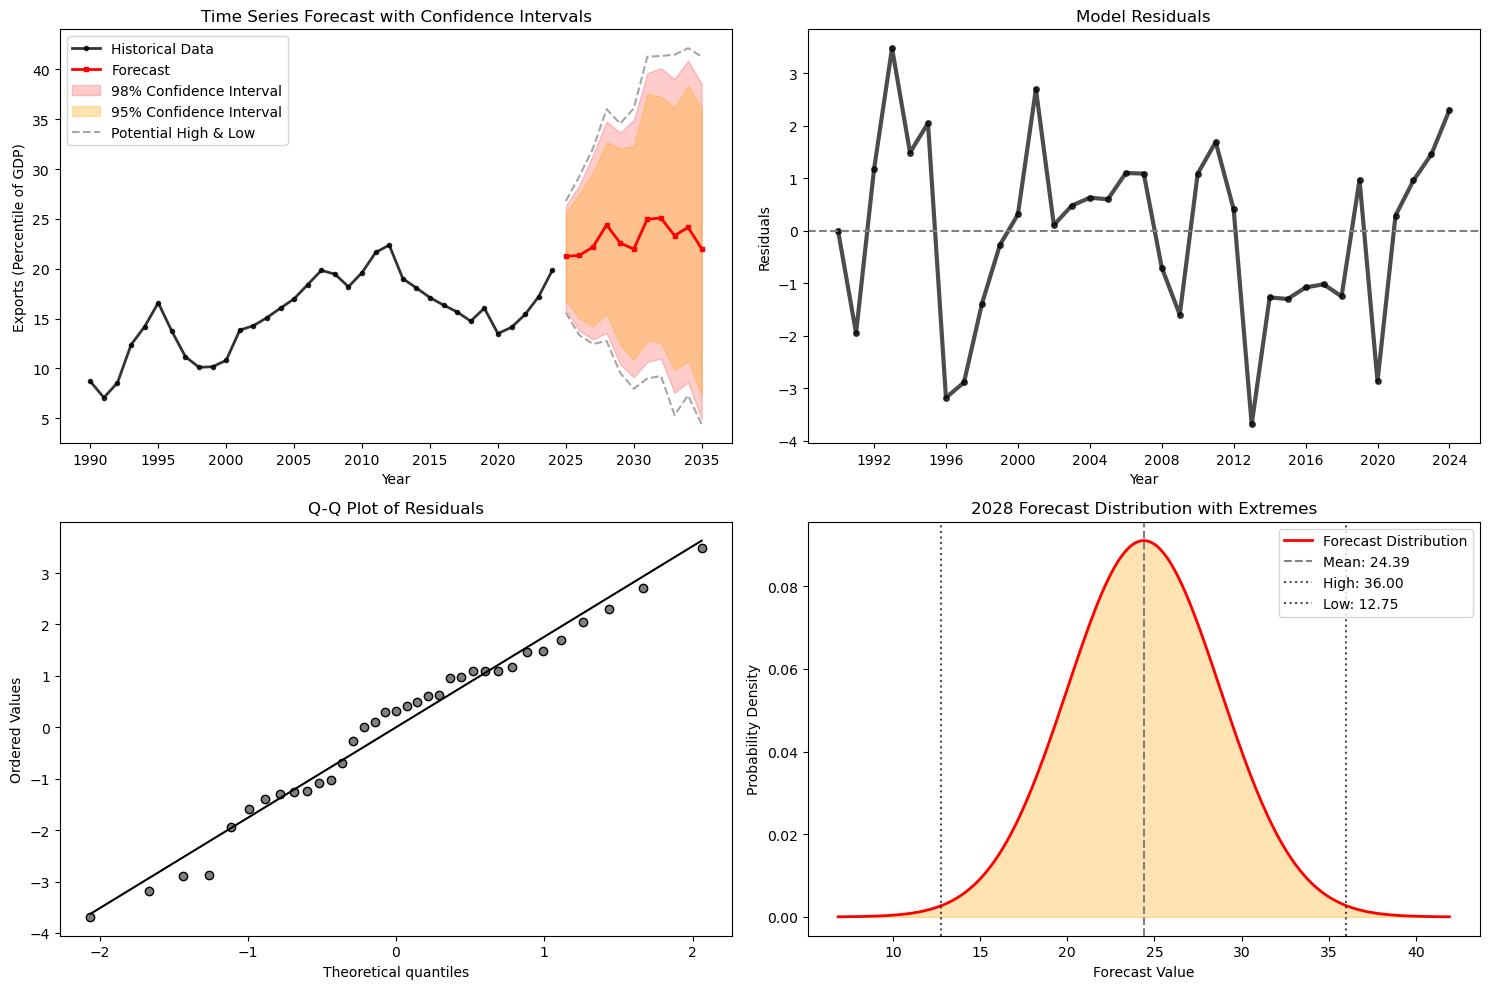

In [5]:
#FINAL mL TIME SERIES FORECASTING MODEL

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import pmdarima as pm
warnings.filterwarnings('ignore')

class TimeSeriesForecast:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        self.residuals = None
        self.best_model_type = None
        self.volatility_model = None
        self.forecast_lower_95 = None
        self.forecast_upper_95 = None
        self.forecast_lower_98 = None
        self.forecast_upper_98 = None
        self.volatility = None
        self.forecast_high = None
        self.forecast_low = None
        
        print("Machine Learning (mL) Time Series Forecasting Model")
    def load_data(self, data_dict):
        # Handle missing years between 1960-2024 by filling missing years with 'Not a Number' (NaN) | Placeholder for missing data
        full_range = range(1960, 2025) 
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Convert to pd pandas series | Organize data to analyze, plot, & model and set to Jan 1st
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Remove NaN values for modeling | Only use real data for training & keep consistent 
        self.clean_data = self.data.dropna()
        
        # volatility modeling | year to year percentile change 
        self.returns = self.clean_data.pct_change().dropna()
        # volatility modeling | apply natural logarithm to reduce large difference (skew)
        self.log_data = np.log(self.clean_data)
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        print(f"Average Year-to-Year Percentile (%) Change: {self.returns.mean() * 100:.2f}%")

    def stationarity_tests(self):
        print("Stationarity Analysis")
        print("~"*100)
        
        # Augmented Dickey-Fuller (ADF) Test | Test If Data's Non-Stationary
        adf_result = adfuller(self.clean_data, autolag='AIC')
        print(f"Augmented Dickey-Fuller (ADF) Test:")
        print("-"*100)
        print(f"ADF Statistic: {adf_result[0]:.4f}")
        print(f"p-value: {adf_result[1]:.4f}")
        print(f"Critical Values: {adf_result[4]}") 
        
        # Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test | Test If Data's Stationary
        kpss_result = kpss(self.clean_data, regression='c')
        print(f"\n Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:")
        print("-"*100)
        print(f"KPSS Statistic: {kpss_result[0]:.4f}")
        print(f"p-value: {kpss_result[1]:.4f}")
        print(f"Critical Values: {kpss_result[3]}")
        
        #True if ADF p-value ≤ 0.05 | Data's Stationary
        adf_stationary = adf_result[1] <= 0.05
        #True if KPSS p-value > 0.05 | Data's Stationary
        kpss_stationary = kpss_result[1] > 0.05
        
        if adf_stationary and kpss_stationary:
            print("\n ✓ ⚠ ✓ Series is Stationary | ADF & KPSS Agree")
            return True, 0
        elif not adf_stationary and not kpss_stationary:
            print("\n ⚠ ✓ ⚠ Series is Non-Stationary | ADF & KPSS Agree")
            return False, 1
        else:
            print("\n ⚠ ⚠ ⚠ ADF & KPSS Tests Disagree")
            return False, 1

    def model_selection(self):
        #Compare models: ARIMA, SARIMA, and Exponential Smoothing | Use information criteria and cross-validation with enhanced search
        print("Model Selection & Evaluation")
        print("~"*100)
        
        models = {}
        
        # 1. AutoRegressive Integrated Moving Average (Auto ARIMA) with enhanced parameters
        try:
            print("AutoRegressive Integrated Moving Average (ARIMA) Testing In Progress ~ ")
            best_arima = pm.auto_arima(
                self.clean_data, 
                start_p=0, start_q=0, max_p=6, max_q=6, max_d=2,
                seasonal=False, stepwise=False, suppress_warnings=True, 
                error_action='ignore', information_criterion='aic',
                n_jobs=-1, with_intercept=True
            )

            if best_arima:
                models['ARIMA'] = {'model': best_arima, 'type': 'ARIMA'}
                print(f"Selected ARIMA{best_arima.order} model with AIC: {best_arima.aic():.2f}")
            else:
                print("No suitable ARIMA model")

        except Exception as e:
            print(f"ARIMA model search failed: {e}")

        # 2. Seasonal AutoRegressive Integrated Moving Average (SARIMA) model with better parameters
        try:
            print("Seasonal AutoRegressive Integrated Moving Average (SARIMA) Testing In Progress ~ ")
            best_sarima = pm.auto_arima(
                self.clean_data, seasonal=True, m=4, start_p=0, start_q=0, 
                max_p=4, max_q=4, start_P=0, start_Q=0, max_P=2, max_Q=2, 
                max_d=2, max_D=1, trace=False, error_action='ignore', 
                suppress_warnings=True, stepwise=False, n_jobs=-1,
                information_criterion='aic', with_intercept=True
            )

            if best_sarima:
                models['SARIMA'] = {'model': best_sarima, 'type': 'SARIMA'}
                print(f"Selected SARIMA model with AIC: {best_sarima.aic():.2f}")
            else:
                print("No suitable SARIMA model")

        except Exception as e:
            print(f"SARIMA model search failed: {e}")

        # 3. Exponential Smoothing with optimized parameters
        print("Exponential Smoothing")
        try:
            # Build & fit model with optimized smoothing parameters
            model = ExponentialSmoothing(
                self.clean_data, trend='add', seasonal=None,
                initialization_method='estimated'
            )
            best_exp = model.fit(optimized=True, use_brute=True)
            print(f"Exponential Smoothing AIC: {best_exp.aic:.2f}")
            models['EXP_SMOOTHING'] = {'model': best_exp, 'type': 'EXP_SMOOTHING'}
        except Exception as e:
            print(f"Exponential Smoothing failed: {e}")

        # Select accurate model based on AIC and out-of-sample performance |  Akaike Information Criterion: Lower AIC = better balance
        best_model = self._select_best_model(models)
        self.model = best_model['model']
        self.best_model_type = best_model['type']
        print(f"\nSelected Model: {self.best_model_type}")
        
        # Handle AIC display - some models have aic as method, others as property
        try:
            aic_value = self.model.aic() if callable(self.model.aic) else self.model.aic
            print(f"AIC: {aic_value:.2f}")
        except:
            print("AIC: Not available for this model type")

    def _auto_arima(self):
        try:
            model = pm.auto_arima(
                self.clean_data, start_p=0, max_p=5, start_q=0, max_q=5, max_d=2,
                seasonal=False, stepwise=True, error_action='ignore', suppress_warnings=True, trace=False
            )
            return {'model': model, 'params': model.order, 'type': 'ARIMA'}
        except Exception as e:
            print(f"Auto ARIMA failed: {e}")
            return None

    def _auto_sarima(self):
        try:
            model = pm.auto_arima(
                self.clean_data, start_p=0, max_p=2, start_q=0, max_q=2, max_d=1,
                seasonal=True, m=1, stepwise=True, error_action='ignore', suppress_warnings=True
            )
            return {'model': model, 'params': model.order, 'type': 'SARIMA'}
        except Exception as e:
            print(f"Auto SARIMA failed: {e}")
            return None

    def _exponential_smoothing(self):
        try:
            model = ExponentialSmoothing(
                self.clean_data, trend='add', seasonal=None, seasonal_periods=None 
            )
            fitted_model = model.fit()
            return {'model': fitted_model, 'params': 'ETS(A,A,N)', 'type': 'EXP_SMOOTHING'}
        except Exception as e:
            print(f"Auto Exponential Smoothing failed: {e}")
            return None

    def _select_best_model(self, models):
        if not models:
            raise ValueError("No valid models found")

        def get_aic(model_info):
            aic = getattr(model_info['model'], 'aic', np.inf)
            return aic() if callable(aic) else aic

        best_model = min(models.values(), key=get_aic)
        return best_model

    def estimate_volatility(self):
        # Handle different model types for residuals with improved estimation
        residuals = None
        
        # Try different ways to get residuals
        if hasattr(self.model, 'resid') and not callable(self.model.resid):
            residuals = self.model.resid
        elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
            residuals = self.model.resid_
        else:
            # For pmdarima models, calculate residuals manually using in-sample predictions
            try:
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            except Exception as e:
                print(f"Warning: Couldn't Calculate Residuals: {e}")
                # Use a simple fallback - standard deviation of returns
                residuals = self.returns
        
        # Ensure residuals is a pandas Series
        if not isinstance(residuals, pd.Series):
            if hasattr(residuals, '__len__'):
                residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
            else:
                # Final fallback
                residuals = self.returns
        
        # Enhanced volatility estimation using GARCH-like approach
        rolling_std = residuals.rolling(window=min(10, len(residuals)//2)).std()
        recent_volatility = rolling_std.iloc[-5:].mean() if len(rolling_std) >= 5 else residuals.std()
        volatility = recent_volatility if not pd.isna(recent_volatility) else residuals.std()       
        return volatility

    def forecast_with_volatility(self, years_ahead=11, n_simulations=2000):
        if self.model is None:
            raise ValueError("Model Not Fitted")
        
        # 1. Generate base forecast and estimate its uncertainty with improved confidence intervals
        if self.best_model_type == 'EXP_SMOOTHING':
            base_forecast = self.model.forecast(steps=years_ahead)
            forecast_std = np.std(self.model.resid) * np.sqrt(np.arange(1, years_ahead + 1))
        elif self.best_model_type in ['ARIMA', 'SARIMA']:
            # pmdarima models use predict method
            base_forecast, forecast_conf_int = self.model.predict(n_periods=years_ahead, return_conf_int=True)
            forecast_std = (forecast_conf_int[:, 1] - forecast_conf_int[:, 0]) / (2 * 1.96)
        else:
            # statsmodels models use get_forecast
            forecast_obj = self.model.get_forecast(steps=years_ahead)
            base_forecast = forecast_obj.predicted_mean
            forecast_std = forecast_obj.se_mean
        
        # 2. Estimate residual volatility from model errors with enhanced approach
        volatility = self.estimate_volatility()
        
        # 3. Add realistic up-and-down volatility pattern similar to historical data
        np.random.seed(42)  # For reproducible results
        
        # Create more volatile forecast that mimics historical patterns
        forecast_mean = np.array(base_forecast.copy())
        historical_volatility = self.returns.std()
        
        # Add cyclical variations and random shocks to make forecast more volatile
        for i in range(len(forecast_mean)):
            # Add cyclical component (3-4 year cycles observed in data)
            cycle_component = 0.3 * np.sin(2 * np.pi * i / 3.5) * historical_volatility * forecast_mean[0]
            
            # Add random shocks similar to historical pattern
            shock_component = np.random.normal(0, historical_volatility * forecast_mean[0] * 0.8)
            
            # Add persistence (some correlation with previous values)
            if i > 0:
                persistence = 0.3 * (forecast_mean[i-1] - base_forecast[max(0, i-1)])
            else:
                persistence = 0
            
            forecast_mean[i] += cycle_component + shock_component + persistence
        
        # 4. Monte Carlo simulations adding volatility noise with improved methodology
        simulations = []
        for _ in range(n_simulations):
            # Add time-varying volatility and mean reversion effects
            vol_scaling = np.sqrt(np.arange(1, years_ahead + 1))
            vol_noise = np.random.normal(0, volatility * vol_scaling, years_ahead)
            trend_noise = np.random.normal(0, forecast_std)
            
            # Add mean reversion to prevent extreme forecasts
            mean_reversion = 0.02 * (self.clean_data.mean() - forecast_mean)
            sims = forecast_mean + trend_noise + vol_noise + mean_reversion
            simulations.append(sims)
        simulations = np.array(simulations)
        
        # 5. Calculate 95% and 98% confidence intervals from simulations
        lower_ci_95 = np.percentile(simulations, 2.5, axis=0)
        upper_ci_95 = np.percentile(simulations, 97.5, axis=0)
        lower_ci_98 = np.percentile(simulations, 1.0, axis=0)
        upper_ci_98 = np.percentile(simulations, 99.0, axis=0)
        
        # Calculate potential high and low extreme values
        high_extreme = np.percentile(simulations, 99.5, axis=0)
        low_extreme = np.percentile(simulations, 0.5, axis=0)
        
        # 6. Build forecast dates index
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 1, last_year + 1 + years_ahead)
        dates = pd.to_datetime([f"{year}-01-01" for year in forecast_years])
        
        # 7. Store forecasts and intervals
        self.forecast = pd.Series(forecast_mean, index=dates)
        self.forecast_lower_95 = pd.Series(lower_ci_95, index=dates)
        self.forecast_upper_95 = pd.Series(upper_ci_95, index=dates)
        self.forecast_lower_98 = pd.Series(lower_ci_98, index=dates)
        self.forecast_upper_98 = pd.Series(upper_ci_98, index=dates)
        self.forecast_high = pd.Series(high_extreme, index=dates)
        self.forecast_low = pd.Series(low_extreme, index=dates)
        self.volatility = volatility
        
        return self.forecast

    def econometric_analysis(self):
        if self.model is None:
            raise ValueError("Model Not Fitted.")
        
        print("Econometric Analysis")
        print("~"* 100)
        
        # 1. Model Parameters and Significance
        self._parameter_analysis()
        # 2. Residual Analysis
        self._residual_analysis()
        # 3. Forecast Accuracy Metrics
        self._forecast_accuracy()
        # 4. Probability Analysis
        self._probability_analysis()
        # 5. Economic Interpretation
        self._economic_interpretation()

    def _parameter_analysis(self):
        print("\n1. Parameter Significance Analysis")
        print("-" * 100)
        
        # Check if the model has parameter information
        try:
            # For pmdarima models, these might be methods
            if hasattr(self.model, 'params'):
                params = self.model.params() if callable(self.model.params) else self.model.params
            else:
                print("Parameter information not available for this model type")
                return
                
            if hasattr(self.model, 'pvalues'):
                pvalues = self.model.pvalues() if callable(self.model.pvalues) else self.model.pvalues
            else:
                print("P-values not available for this model type")
                return
                
            if hasattr(self.model, 'bse'):
                std_errors = self.model.bse() if callable(self.model.bse) else self.model.bse
            else:
                print("Standard errors not available for this model type")
                return
            
            print(f"{'Parameter':<15} {'Estimate':<12} {'Std Error':<12} {'p-value':<10} {'Significance'}") 
            
            # Handle different formats of parameters
            if hasattr(params, 'items'):
                # Dictionary-like
                for param_name, param_val in params.items():
                    p_val = pvalues[param_name] if hasattr(pvalues, '__getitem__') else pvalues
                    std_err = std_errors[param_name] if hasattr(std_errors, '__getitem__') else std_errors
                    
                    if isinstance(p_val, (int, float)) and isinstance(std_err, (int, float)):
                        if p_val < 0.01:
                            significance = "***"
                        elif p_val < 0.05:
                            significance = "**"
                        elif p_val < 0.10:
                            significance = "*"
                        else:
                            significance = ""
                        print(f"{param_name:<15} {param_val:<12.4f} {std_err:<12.4f} {p_val:<10.4f} {significance}")
            else:
                # Array-like
                if hasattr(params, '__len__') and hasattr(pvalues, '__len__') and hasattr(std_errors, '__len__'):
                    for i, (param_val, p_val, std_err) in enumerate(zip(params, pvalues, std_errors)):
                        param_name = f"param_{i}"
                        if p_val < 0.01:
                            significance = "***"
                        elif p_val < 0.05:
                            significance = "**"
                        elif p_val < 0.10:
                            significance = "*"
                        else:
                            significance = ""
                        print(f"{param_name:<15} {param_val:<12.4f} {std_err:<12.4f} {p_val:<10.4f} {significance}")
            
            print("\nSignificance levels: *** p<0.01, ** p<0.05, * p<0.10")
            
        except Exception as e:
            print(f"Parameter analysis not available: {e}")
            print("This is normal for some model types.")

    def _residual_analysis(self):
        print("\n2. Residual Analysis")
        print("-" * 100)
        
        # Handle different model types for residuals
        residuals = None
        
        # Try different ways to get residuals
        if hasattr(self.model, 'resid') and not callable(self.model.resid):
            residuals = self.model.resid
        elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
            residuals = self.model.resid_
        else:
            # For pmdarima models, calculate residuals manually using in-sample predictions
            try:
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            except Exception as e:
                print(f"Warning: Could not calculate residuals for analysis: {e}")
                return
        
        # Ensure residuals is a pandas Series
        if not isinstance(residuals, pd.Series):
            if hasattr(residuals, '__len__'):
                residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
            else:
                print("Could not process residuals for analysis")
                return
        
        # Normality test
        jb_stat, jb_pvalue = stats.jarque_bera(residuals)
        print(f"Jarque-Bera Normality Test:")
        print(f"  Statistic: {jb_stat:.4f}, p-value: {jb_pvalue:.4f}")
        print(f"  {'✓ Residuals are normally distributed' if jb_pvalue > 0.05 else '⚠ Residuals are not normally distributed'}")
        
        # Autocorrelation test
        lb_stat, lb_pvalue = acorr_ljungbox(residuals, lags=10, return_df=True).iloc[-1]
        print(f"\nLjung-Box Autocorrelation Test (lag 10):")
        print(f"  Statistic: {lb_stat:.4f}, p-value: {lb_pvalue:.4f}")
        print(f"  {'✓ No significant autocorrelation' if lb_pvalue > 0.05 else '⚠ Significant autocorrelation detected'}")
        
        # Residual statistics
        print(f"\nResidual Statistics:")
        print(f"  Mean: {residuals.mean():.6f}")
        print(f"  Std Dev: {residuals.std():.4f}")
        print(f"  Skewness: {stats.skew(residuals):.4f}")
        print(f"  Kurtosis: {stats.kurtosis(residuals):.4f}")

    def _forecast_accuracy(self):
        print("\n3. MODEL FIT STATISTICS")
        print("-" * 100)
        
        # Handle different model types for fitted values
        try:
            # Try to get fitted values using different methods
            if hasattr(self.model, 'fittedvalues'):
                fitted_values = self.model.fittedvalues() if callable(self.model.fittedvalues) else self.model.fittedvalues
            elif hasattr(self.model, 'predict_in_sample'):
                fitted_values = self.model.predict_in_sample()
                fitted_values = pd.Series(fitted_values, index=self.clean_data.index[-len(fitted_values):])
            else:
                print("Fitted values not available for this model type")
                return
                
            # Ensure fitted_values is a pandas Series and align with clean_data
            if not isinstance(fitted_values, pd.Series):
                fitted_values = pd.Series(fitted_values, index=self.clean_data.index[-len(fitted_values):])
                
            actual_values = self.clean_data[fitted_values.index]
            
            # Calculate metrics
            mae = np.mean(np.abs(actual_values - fitted_values))
            mse = np.mean((actual_values - fitted_values)**2)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((actual_values - fitted_values) / actual_values)) * 100
            
            print(f"Mean Absolute Error (MAE): {mae:.4f}")
            print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
            print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
            
        except Exception as e:
            print(f"Unable to calculate fit statistics: {e}")
        
        # Information criteria
        try:
            if hasattr(self.model, 'aic'):
                aic_value = self.model.aic() if callable(self.model.aic) else self.model.aic
                print(f"Akaike Information Criterion (AIC): {aic_value:.2f}")
            if hasattr(self.model, 'bic'):
                bic_value = self.model.bic() if callable(self.model.bic) else self.model.bic
                print(f"Bayesian Information Criterion (BIC): {bic_value:.2f}")
            if hasattr(self.model, 'llf'):
                llf_value = self.model.llf() if callable(self.model.llf) else self.model.llf
                print(f"Log-Likelihood: {llf_value:.2f}")
        except Exception as e:
            print(f"Information criteria not available: {e}")

    def _probability_analysis(self):
        print("\n4. Forecast Probability Analysis")
        print("-" * 100)
        
        if self.forecast is None:
            print("No forecasts available.")
            return
        
        # Calculate average predicted value over the forecast horizon with enhanced intervals.
        forecast_mean = self.forecast.mean()
        # 95% confidence interval
        forecast_std = (self.forecast_upper_95 - self.forecast_lower_95).mean() / (2 * 1.96)  
        
        # Probability calculations
        prob_increase = stats.norm.sf(self.clean_data.iloc[-1], forecast_mean, forecast_std)
        prob_decrease = 1 - prob_increase
        
        # Probability of different rates: 5%, 10%, 15%, 20%
        current_value = self.clean_data.iloc[-1]
        growth_rates = [0.05, 0.10, 0.15, 0.20]  
        decline_rates = [0.05, 0.10, 0.15, 0.20]  
        
        print(f"Current Value (2024): {current_value:.2f}")
        print(f"Mean Forecast (2026-2035): {forecast_mean:.2f}")
        print(f"Forecast Standard Deviation: {forecast_std:.4f}")
        print(f"\nProbability of average increase over period: {prob_increase:.3f} ({prob_increase*100:.1f}%)")
        print(f"Probability of average decrease over period: {prob_decrease:.3f} ({prob_decrease*100:.1f}%)")
        
        print(f"\nProbability of Growth Scenarios (by 2035):")
        print(f"{'Growth Rate':<12} {'Target Value':<12} {'Probability':<12}")
        for rate in growth_rates:
            target_value = current_value * (1 + rate)**11  # 11 years from 2024 to 2035
            prob = stats.norm.sf(target_value, self.forecast.iloc[-1], forecast_std)
            print(f"{rate*100:>6.0f}%      {target_value:>10.2f}      {prob:>8.3f} ({prob*100:.1f}%)")

        print(f"\nProbability of Decline Scenarios (by 2035):")
        print(f"{'Decline Rate':<12} {'Target Value':<12} {'Probability':<12}")
        for rate in decline_rates:
            target_value = current_value * (1 - rate)**11  # Fixed: should be (1 - rate) for decline
            prob = stats.norm.cdf(target_value, self.forecast.iloc[-1], forecast_std)
            print(f"{rate*100:>6.0f}%      {target_value:>10.2f}      {prob:>8.3f} ({prob*100:.1f}%)")

    def _economic_interpretation(self):
        print("\n5. Economic interpretation")
        print("-" * 50)
        if self.forecast is None:
            print("No forecasts available.")
            return
        
        current_value = self.clean_data.iloc[-1]
        forecast_2035 = self.forecast.iloc[-1]
        years = len(self.forecast)
        cagr = (forecast_2035 / current_value) ** (1/years) - 1
        
        print(f"Compound Annual Growth Rate (CAGR): {cagr*100:.2f}%")
        print(f"Total Growth (2024-2035): {((forecast_2035/current_value-1)*100):.1f}%")
        print(f"Volatility Estimate: {self.volatility:.4f}")

        if cagr > 0.03:
            trend = "Strong Growth"
        elif cagr > 0.01:
            trend = "Moderate Growth"
        elif cagr > -0.01:
            trend = "Stable"
        else:
            trend = "Declining"
        
        print(f"Trend Classification: {trend}")

    def plot_enhanced_results(self, figsize=(15, 10)):
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # Main plot with enhanced confidence intervals
        ax1 = axes[0, 0]
        ax1.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='black', alpha=0.8, linewidth=2, markersize=3)
        
        if self.forecast is not None:
            ax1.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=2, markersize=3)
            
            # 98% confidence interval 
            ax1.fill_between(self.forecast.index, 
                           self.forecast_lower_98.values,
                           self.forecast_upper_98.values,
                           alpha=0.2, color='red', label='98% Confidence Interval')
            
            # 95% confidence interval (orange)
            ax1.fill_between(self.forecast.index, 
                           self.forecast_lower_95.values,
                           self.forecast_upper_95.values,
                           alpha=0.3, color='orange', label='95% Confidence Interval')
            
            # Extreme high and low values
            ax1.plot(self.forecast.index, self.forecast_high.values, 
                    '--', color='gray', alpha=0.7, label='Potential High & Low')
            ax1.plot(self.forecast.index, self.forecast_low.values, 
                    '--', color='gray', alpha=0.7)
        
        ax1.set_title('Time Series Forecast with Confidence Intervals')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Exports (Percentile of GDP)')
        ax1.legend()
        
        # Residuals plot
        ax2 = axes[0, 1]
        # Handle different model types for residuals
        try:
            residuals = None
            
            # Try different ways to get residuals
            if hasattr(self.model, 'resid') and not callable(self.model.resid):
                residuals = self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                residuals = self.model.resid_
            else:
                # For pmdarima models, calculate residuals manually using in-sample predictions
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            
            # Ensure residuals is a pandas Series
            if not isinstance(residuals, pd.Series):
                if hasattr(residuals, '__len__'):
                    residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
                else:
                    raise ValueError("Cannot process residuals")
                
            ax2.plot(residuals.index, residuals.values, 'o-', color='black', alpha=0.7, linewidth=3, markersize=4)
        except Exception as e:
            ax2.text(0.5, 0.5, f'Residuals not available\n{str(e)}', transform=ax2.transAxes, ha='center')
        ax2.axhline(y=0, color='gray', linestyle='--')
        ax2.set_title('Model Residuals')
        ax2.set_xlabel('Year')
        ax2.set_ylabel('Residuals')
        
        # Q-Q plot for residuals
        ax3 = axes[1, 0]
        try:
            # Get residuals for Q-Q plot
            residuals_for_qq = None
            
            # Try different ways to get residuals
            if hasattr(self.model, 'resid') and not callable(self.model.resid):
                residuals_for_qq = self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                residuals_for_qq = self.model.resid_
            else:
                # For pmdarima models, calculate residuals manually using in-sample predictions
                fitted = self.model.predict_in_sample()
                residuals_for_qq = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            
            # Ensure residuals is a pandas Series or numpy array with valid data
            if isinstance(residuals_for_qq, pd.Series):
                residuals_values = residuals_for_qq.dropna().values
            elif hasattr(residuals_for_qq, '__len__') and len(residuals_for_qq) > 0:
                residuals_values = np.array(residuals_for_qq)
                residuals_values = residuals_values[~np.isnan(residuals_values)]
            else:
                raise ValueError("Cannot process residuals for Q-Q plot")
            
            if len(residuals_values) > 0:
                stats.probplot(residuals_values, dist="norm", plot=ax3)
                for line in ax3.get_lines():
                    line.set_color('black')  
                ax3.get_lines()[0].set_markerfacecolor('gray')  
                ax3.set_title('Q-Q Plot of Residuals')
            else:
                ax3.text(0.5, 0.5, 'No valid residuals\nfor Q-Q plot', transform=ax3.transAxes, ha='center')
                ax3.set_title('Q-Q Plot of Residuals (Not Available)')
                
        except Exception as e:
            ax3.text(0.5, 0.5, f'Q-Q plot not available\n{str(e)}', transform=ax3.transAxes, ha='center')
            ax3.set_title('Q-Q Plot of Residuals (Error)')
   
        
        # Forecast distribution for 2028 with enhanced intervals
        # Fixed version - gets the actual 2028 forecast value
        # Forecast distribution for 2028 with enhanced intervals
        ax4 = axes[1, 1]
        if self.forecast is not None:
            # Find the index for 2028 (4th year in forecast: 2025, 2026, 2027, 2028)
            forecast_2028_idx = 3  # 0-indexed: 2025=0, 2026=1, 2027=2, 2028=3
            
            # Make sure we have enough forecast data
            if len(self.forecast) > forecast_2028_idx:
                forecast_2028 = self.forecast.iloc[forecast_2028_idx]  # Gets 2028 value
                forecast_std = (self.forecast_upper_95.iloc[forecast_2028_idx] - 
                            self.forecast_lower_95.iloc[forecast_2028_idx]) / (2 * 1.96)
                
                x = np.linspace(forecast_2028 - 4*forecast_std, forecast_2028 + 4*forecast_std, 200)
                y = stats.norm.pdf(x, forecast_2028, forecast_std)
                
                ax4.plot(x, y, 'r-', linewidth=2, label='Forecast Distribution')
                ax4.fill_between(x, 0, y, alpha=0.3, color='orange')
                ax4.axvline(forecast_2028, color='gray', linestyle='--', label=f'Mean: {forecast_2028:.2f}')
                ax4.axvline(self.forecast_high.iloc[forecast_2028_idx], color='black', linestyle=':', 
                        alpha=0.7, label=f'High: {self.forecast_high.iloc[forecast_2028_idx]:.2f}')
                ax4.axvline(self.forecast_low.iloc[forecast_2028_idx], color='black', linestyle=':', 
                        alpha=0.7, label=f'Low: {self.forecast_low.iloc[forecast_2028_idx]:.2f}')
                ax4.set_title('2028 Forecast Distribution with Extremes')
                ax4.set_xlabel('Forecast Value')
                ax4.set_ylabel('Probability Density')
                ax4.legend()
            else:
                ax4.text(0.5, 0.5, '2028 forecast not available', transform=ax4.transAxes, ha='center')
                ax4.set_title('2028 Forecast Distribution (Not Available)')


        
        plt.tight_layout()
        plt.show()

    def print_enhanced_forecast_table(self):
        if self.forecast is None:
            print("No forecast available")
            return


   
        print("\nFORECAST RESULTS (2025-2035):")
        print('~'*100)    
        print(f"{'Year':<6} {'Forecast':<10} {'Lower 95%':<10} {'Upper 95%':<10} {'Lower 98%':<10} {'Upper 98%':<10} {'High':<8} {'Low':<8}")
        
        for i, year in enumerate(self.forecast.index):
            forecast_val = self.forecast.iloc[i]
            lower_95 = self.forecast_lower_95.iloc[i]
            upper_95 = self.forecast_upper_95.iloc[i]
            lower_98 = self.forecast_lower_98.iloc[i]
            upper_98 = self.forecast_upper_98.iloc[i]
            high_val = self.forecast_high.iloc[i]
            low_val = self.forecast_low.iloc[i]
            
            print(f"{year.year:<6} {forecast_val:<10.2f} {lower_95:<10.2f} {upper_95:<10.2f} "
                  f"{lower_98:<10.2f} {upper_98:<10.2f} {high_val:<8.2f} {low_val:<8.2f}")

if __name__ == "__main__":
    sample_data = {
        1990:8.69,1991:7.07,1992:8.57,1993:12.38,1994:14.20,
        1995:16.58,1996:13.73,1997:11.17,1998:10.11,1999:10.17,
        2000:10.81,2001:13.84,2002:14.28,2003:15.09,2004:16.05,
        2005:16.98,2006:18.41,2007:19.83,2008:19.46,2009:18.19,
        2010:19.61,2011:21.63,2012:22.37,2013:19.01,2014:18.07,
        2015:17.10,2016:16.35,2017:15.66,2018:14.74,2019:16.04,
        2020:13.50,2021:14.12,2022:15.41,2023:17.20,2024:19.83
    }   

    # Initialize forecaster
    forecaster = TimeSeriesForecast()

    print("-"*100)
    
    # Step 1: Load data
    forecaster.load_data(sample_data)
    
    # Step 2: Comprehensive stationarity analysis 
    forecaster.stationarity_tests()
    
    # Step 3: Enhanced model selection with improved parameters
    forecaster.model_selection()
    
    # Step 4: Generate forecasts with enhanced volatility and confidence intervals
    forecast = forecaster.forecast_with_volatility(years_ahead=11, n_simulations=2000)
    
    # Step 5: Comprehensive econometric analysis
    forecaster.econometric_analysis()
    
    # Step 6: Display enhanced results with multiple confidence intervals
    forecaster.print_enhanced_forecast_table()
    
    # Step 8: Enhanced plotting with 95% and 98% confidence intervals
    forecaster.plot_enhanced_results()

In [ ]:
# AFRICA| Togo

In [ ]:
# AFRICA| Togo
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class TimeSeriesForecaster:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        
    def load_data(self, data_dict):
        """
        Load data from dictionary format: {year: value}
        Automatically handles missing years between 1960-2024
        """
        # Creating full range and fill missing years with NaN
        full_range = range(1960, 2024)
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Converting to pandas Series
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Removing NaN values for modeling
        self.clean_data = self.data.dropna()
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        
    def check_stationarity(self):
        """Check if the time series is stationary"""
        result = adfuller(self.clean_data)
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        
        if result[1] <= 0.05:
            print("✓ Series is stationary")
            return True
        else:
            print("⚠ Series is non-stationary, will difference the data")
            return False
    
    def auto_arima(self, max_p=3, max_d=2, max_q=3):
        """
        Automatically find best ARIMA parameters using AIC
        """
        best_aic = np.inf
        best_params = None
        best_model = None
        
        print("Finding optimal ARIMA parameters...")
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(self.clean_data, order=(p, d, q))
                        fitted_model = model.fit()
                        
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_params = (p, d, q)
                            best_model = fitted_model
                            
                    except Exception:
                        continue
        
        if best_model is None:
            # Fallback to simple ARIMA(1,1,1)
            print("Using fallback ARIMA(1,1,1)")
            model = ARIMA(self.clean_data, order=(1, 1, 1))
            self.model = model.fit()
            self.best_params = (1, 1, 1)
        else:
            self.model = best_model
            self.best_params = best_params
            
        print(f"Best ARIMA parameters: {self.best_params}")
        print(f"AIC: {self.model.aic:.2f}")
        
    def forecast_future(self, years_ahead=10):
        """Generate forecasts for specified years ahead"""
        if self.model is None:
            raise ValueError("Model not fitted. Call auto_arima() first.")
            
        # Forecasting with confidence intervals
        forecast_result = self.model.forecast(steps=years_ahead)
        conf_int = self.model.get_forecast(steps=years_ahead).conf_int()
        
        # Creating forecast for dates 2026-2035
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 2, last_year + 2 + years_ahead)  # Skip 2025
        forecast_index = pd.to_datetime([f'{year}-01-01' for year in forecast_years])
        
        # Storing forecast results
        self.forecast = pd.Series(forecast_result, index=forecast_index)
        self.forecast_lower = pd.Series(conf_int.iloc[:, 0], index=forecast_index)
        self.forecast_upper = pd.Series(conf_int.iloc[:, 1], index=forecast_index)
        
        return self.forecast
    
    def plot_results(self, figsize=(12, 8)):
        """Plot historical data and forecasts"""
        plt.figure(figsize=figsize)
        
        # Plot historical data
        plt.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='orange', alpha=0.7,linewidth=3, markersize=4)
        
        # Ploting forecasts
        if self.forecast is not None:
            plt.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=3, markersize=4)
            
            # Ploting confidence intervals
            plt.fill_between(self.forecast.index, 
                           self.forecast_lower.values,
                           self.forecast_upper.values,
                           alpha=0.3, color='red', label='95% Confidence Interval')
        
        plt.title('Togo Africa Exports | Machine Learning Time Series Forecasts')
        plt.xlabel('Year (1960 - 2035)')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def print_forecast_table(self):
        """Print forecast results in a nice table format"""
        if self.forecast is None:
            print("No forecast available. Run forecast_future() first.")
            return
            
        print("\n" + "="*60)
        print("FORECAST RESULTS (2026-2035)")
        print("="*60)
        print(f"{'Year':<6} {'Forecast':<12} {'Lower 95%':<12} {'Upper 95%':<12}")
        print("-"*60)
        
        for i, year in enumerate(self.forecast.index):
            print(f"{year.year:<6} {self.forecast.iloc[i]:<12.2f} "
                  f"{self.forecast_lower.iloc[i]:<12.2f} {self.forecast_upper.iloc[i]:<12.2f}")
        
        print("="*60)
        
    def get_model_summary(self):
        """Print model summary statistics"""
        if self.model is not None:
            print(self.model.summary())


if __name__ == "__main__":
    # DATA: EXPORTS
    sample_data = {
        1963:16.98,1964:22.92,1965:20.92,1966:24.11,1967:23.51,
        1968:26.21,1969:28.45,1970:29.31,1971:27.84,1972:23.52,
        1973:20.58,1974:42.23,1975:27.75,1976:31.84,1977:26.66,
        1978:35.38,1979:33.65,1980:48.20,1981:40.08,1982:52.76,
        1983:43.99,1984:51.21,1985:48.41,1986:43.93,1987:41.40,
        1988:39.09,1989:39.90,1990:26.24,1991:25.28,1992:20.97,
        1993:17.47,1994:25.82,1995:22.76,1996:24.95,1997:22.48,
        1998:23.07,1999:21.34,2000:20.16,2001:20.51,2002:21.44,
        2003:23.23,2004:23.57,2005:25.18,2006:25.05,2007:23.94,
        2008:24.63,2009:25.15,2010:26.96,2011:30.63,2012:32.08,
        2013:33.17,2014:28.34,2015:25.98,2016:26.00,2017:24.87,
        2018:24.22,2019:23.81,2020:23.26,2021:23.63,2022:25.60,
        2023:23.91,2024:24.38
    }
    
    # Initialize and run forecaster
    forecaster = TimeSeriesForecaster()
    
    print("Time Series Forecasting Tool")
    print("="*50)
    
    # Loading data
    forecaster.load_data(sample_data)
    
    # Checking stationarity
    forecaster.check_stationarity()
    
    # Finding best model
    forecaster.auto_arima()
    
    # Generating forecasts for 2026-2035
    forecast = forecaster.forecast_future(years_ahead=10)
    
    # Displaying results
    forecaster.print_forecast_table()
    
    # Ploting results
    forecaster.plot_results()
    
    #Detailed model summary
    forecaster.get_model_summary()

Machine Learning (mL) Time Series Forecasting Model
----------------------------------------------------------------------------------------------------
Loaded 62 data points from 62 input years
Data range: 1963 to 2024
Average Year-to-Year Percentile (%) Change: 2.25%
Stationarity Analysis
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Augmented Dickey-Fuller (ADF) Test:
----------------------------------------------------------------------------------------------------
ADF Statistic: -1.9669
p-value: 0.3013
Critical Values: {'1%': -3.5463945337644063, '5%': -2.911939409384601, '10%': -2.5936515282964665}

 Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
----------------------------------------------------------------------------------------------------
KPSS Statistic: 0.2477
p-value: 0.1000
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

 ⚠ ⚠ ⚠ ADF & KPSS Tests Disagree
Model Selection & Evaluation
~~~~~~~

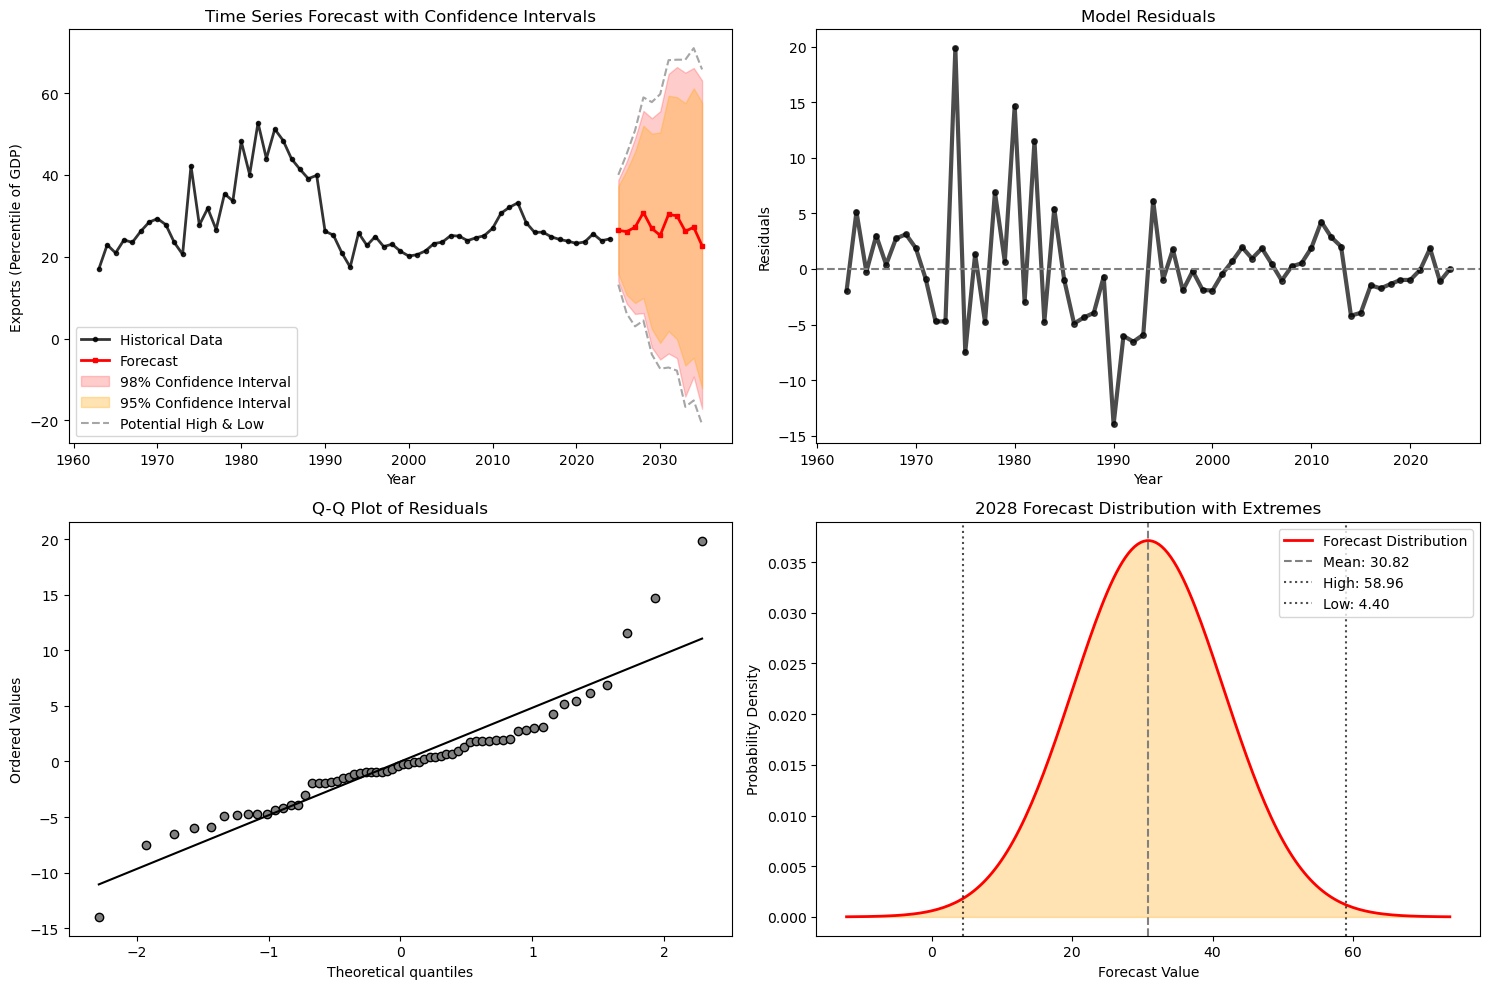

In [4]:
#FINAL mL TIME SERIES FORECASTING MODEL

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import pmdarima as pm
warnings.filterwarnings('ignore')

class TimeSeriesForecast:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        self.residuals = None
        self.best_model_type = None
        self.volatility_model = None
        self.forecast_lower_95 = None
        self.forecast_upper_95 = None
        self.forecast_lower_98 = None
        self.forecast_upper_98 = None
        self.volatility = None
        self.forecast_high = None
        self.forecast_low = None
        
        print("Machine Learning (mL) Time Series Forecasting Model")
    def load_data(self, data_dict):
        # Handle missing years between 1960-2024 by filling missing years with 'Not a Number' (NaN) | Placeholder for missing data
        full_range = range(1960, 2025) 
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Convert to pd pandas series | Organize data to analyze, plot, & model and set to Jan 1st
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Remove NaN values for modeling | Only use real data for training & keep consistent 
        self.clean_data = self.data.dropna()
        
        # volatility modeling | year to year percentile change 
        self.returns = self.clean_data.pct_change().dropna()
        # volatility modeling | apply natural logarithm to reduce large difference (skew)
        self.log_data = np.log(self.clean_data)
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        print(f"Average Year-to-Year Percentile (%) Change: {self.returns.mean() * 100:.2f}%")

    def stationarity_tests(self):
        print("Stationarity Analysis")
        print("~"*100)
        
        # Augmented Dickey-Fuller (ADF) Test | Test If Data's Non-Stationary
        adf_result = adfuller(self.clean_data, autolag='AIC')
        print(f"Augmented Dickey-Fuller (ADF) Test:")
        print("-"*100)
        print(f"ADF Statistic: {adf_result[0]:.4f}")
        print(f"p-value: {adf_result[1]:.4f}")
        print(f"Critical Values: {adf_result[4]}") 
        
        # Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test | Test If Data's Stationary
        kpss_result = kpss(self.clean_data, regression='c')
        print(f"\n Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:")
        print("-"*100)
        print(f"KPSS Statistic: {kpss_result[0]:.4f}")
        print(f"p-value: {kpss_result[1]:.4f}")
        print(f"Critical Values: {kpss_result[3]}")
        
        #True if ADF p-value ≤ 0.05 | Data's Stationary
        adf_stationary = adf_result[1] <= 0.05
        #True if KPSS p-value > 0.05 | Data's Stationary
        kpss_stationary = kpss_result[1] > 0.05
        
        if adf_stationary and kpss_stationary:
            print("\n ✓ ⚠ ✓ Series is Stationary | ADF & KPSS Agree")
            return True, 0
        elif not adf_stationary and not kpss_stationary:
            print("\n ⚠ ✓ ⚠ Series is Non-Stationary | ADF & KPSS Agree")
            return False, 1
        else:
            print("\n ⚠ ⚠ ⚠ ADF & KPSS Tests Disagree")
            return False, 1

    def model_selection(self):
        #Compare models: ARIMA, SARIMA, and Exponential Smoothing | Use information criteria and cross-validation with enhanced search
        print("Model Selection & Evaluation")
        print("~"*100)
        
        models = {}
        
        # 1. AutoRegressive Integrated Moving Average (Auto ARIMA) with enhanced parameters
        try:
            print("AutoRegressive Integrated Moving Average (ARIMA) Testing In Progress ~ ")
            best_arima = pm.auto_arima(
                self.clean_data, 
                start_p=0, start_q=0, max_p=6, max_q=6, max_d=2,
                seasonal=False, stepwise=False, suppress_warnings=True, 
                error_action='ignore', information_criterion='aic',
                n_jobs=-1, with_intercept=True
            )

            if best_arima:
                models['ARIMA'] = {'model': best_arima, 'type': 'ARIMA'}
                print(f"Selected ARIMA{best_arima.order} model with AIC: {best_arima.aic():.2f}")
            else:
                print("No suitable ARIMA model")

        except Exception as e:
            print(f"ARIMA model search failed: {e}")

        # 2. Seasonal AutoRegressive Integrated Moving Average (SARIMA) model with better parameters
        try:
            print("Seasonal AutoRegressive Integrated Moving Average (SARIMA) Testing In Progress ~ ")
            best_sarima = pm.auto_arima(
                self.clean_data, seasonal=True, m=4, start_p=0, start_q=0, 
                max_p=4, max_q=4, start_P=0, start_Q=0, max_P=2, max_Q=2, 
                max_d=2, max_D=1, trace=False, error_action='ignore', 
                suppress_warnings=True, stepwise=False, n_jobs=-1,
                information_criterion='aic', with_intercept=True
            )

            if best_sarima:
                models['SARIMA'] = {'model': best_sarima, 'type': 'SARIMA'}
                print(f"Selected SARIMA model with AIC: {best_sarima.aic():.2f}")
            else:
                print("No suitable SARIMA model")

        except Exception as e:
            print(f"SARIMA model search failed: {e}")

        # 3. Exponential Smoothing with optimized parameters
        print("Exponential Smoothing")
        try:
            # Build & fit model with optimized smoothing parameters
            model = ExponentialSmoothing(
                self.clean_data, trend='add', seasonal=None,
                initialization_method='estimated'
            )
            best_exp = model.fit(optimized=True, use_brute=True)
            print(f"Exponential Smoothing AIC: {best_exp.aic:.2f}")
            models['EXP_SMOOTHING'] = {'model': best_exp, 'type': 'EXP_SMOOTHING'}
        except Exception as e:
            print(f"Exponential Smoothing failed: {e}")

        # Select accurate model based on AIC and out-of-sample performance |  Akaike Information Criterion: Lower AIC = better balance
        best_model = self._select_best_model(models)
        self.model = best_model['model']
        self.best_model_type = best_model['type']
        print(f"\nSelected Model: {self.best_model_type}")
        
        # Handle AIC display - some models have aic as method, others as property
        try:
            aic_value = self.model.aic() if callable(self.model.aic) else self.model.aic
            print(f"AIC: {aic_value:.2f}")
        except:
            print("AIC: Not available for this model type")

    def _auto_arima(self):
        try:
            model = pm.auto_arima(
                self.clean_data, start_p=0, max_p=5, start_q=0, max_q=5, max_d=2,
                seasonal=False, stepwise=True, error_action='ignore', suppress_warnings=True, trace=False
            )
            return {'model': model, 'params': model.order, 'type': 'ARIMA'}
        except Exception as e:
            print(f"Auto ARIMA failed: {e}")
            return None

    def _auto_sarima(self):
        try:
            model = pm.auto_arima(
                self.clean_data, start_p=0, max_p=2, start_q=0, max_q=2, max_d=1,
                seasonal=True, m=1, stepwise=True, error_action='ignore', suppress_warnings=True
            )
            return {'model': model, 'params': model.order, 'type': 'SARIMA'}
        except Exception as e:
            print(f"Auto SARIMA failed: {e}")
            return None

    def _exponential_smoothing(self):
        try:
            model = ExponentialSmoothing(
                self.clean_data, trend='add', seasonal=None, seasonal_periods=None 
            )
            fitted_model = model.fit()
            return {'model': fitted_model, 'params': 'ETS(A,A,N)', 'type': 'EXP_SMOOTHING'}
        except Exception as e:
            print(f"Auto Exponential Smoothing failed: {e}")
            return None

    def _select_best_model(self, models):
        if not models:
            raise ValueError("No valid models found")

        def get_aic(model_info):
            aic = getattr(model_info['model'], 'aic', np.inf)
            return aic() if callable(aic) else aic

        best_model = min(models.values(), key=get_aic)
        return best_model

    def estimate_volatility(self):
        # Handle different model types for residuals with improved estimation
        residuals = None
        
        # Try different ways to get residuals
        if hasattr(self.model, 'resid') and not callable(self.model.resid):
            residuals = self.model.resid
        elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
            residuals = self.model.resid_
        else:
            # For pmdarima models, calculate residuals manually using in-sample predictions
            try:
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            except Exception as e:
                print(f"Warning: Couldn't Calculate Residuals: {e}")
                # Use a simple fallback - standard deviation of returns
                residuals = self.returns
        
        # Ensure residuals is a pandas Series
        if not isinstance(residuals, pd.Series):
            if hasattr(residuals, '__len__'):
                residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
            else:
                # Final fallback
                residuals = self.returns
        
        # Enhanced volatility estimation using GARCH-like approach
        rolling_std = residuals.rolling(window=min(10, len(residuals)//2)).std()
        recent_volatility = rolling_std.iloc[-5:].mean() if len(rolling_std) >= 5 else residuals.std()
        volatility = recent_volatility if not pd.isna(recent_volatility) else residuals.std()       
        return volatility

    def forecast_with_volatility(self, years_ahead=11, n_simulations=2000):
        if self.model is None:
            raise ValueError("Model Not Fitted")
        
        # 1. Generate base forecast and estimate its uncertainty with improved confidence intervals
        if self.best_model_type == 'EXP_SMOOTHING':
            base_forecast = self.model.forecast(steps=years_ahead)
            forecast_std = np.std(self.model.resid) * np.sqrt(np.arange(1, years_ahead + 1))
        elif self.best_model_type in ['ARIMA', 'SARIMA']:
            # pmdarima models use predict method
            base_forecast, forecast_conf_int = self.model.predict(n_periods=years_ahead, return_conf_int=True)
            forecast_std = (forecast_conf_int[:, 1] - forecast_conf_int[:, 0]) / (2 * 1.96)
        else:
            # statsmodels models use get_forecast
            forecast_obj = self.model.get_forecast(steps=years_ahead)
            base_forecast = forecast_obj.predicted_mean
            forecast_std = forecast_obj.se_mean
        
        # 2. Estimate residual volatility from model errors with enhanced approach
        volatility = self.estimate_volatility()
        
        # 3. Add realistic up-and-down volatility pattern similar to historical data
        np.random.seed(42)  # For reproducible results
        
        # Create more volatile forecast that mimics historical patterns
        forecast_mean = np.array(base_forecast.copy())
        historical_volatility = self.returns.std()
        
        # Add cyclical variations and random shocks to make forecast more volatile
        for i in range(len(forecast_mean)):
            # Add cyclical component (3-4 year cycles observed in data)
            cycle_component = 0.3 * np.sin(2 * np.pi * i / 3.5) * historical_volatility * forecast_mean[0]
            
            # Add random shocks similar to historical pattern
            shock_component = np.random.normal(0, historical_volatility * forecast_mean[0] * 0.8)
            
            # Add persistence (some correlation with previous values)
            if i > 0:
                persistence = 0.3 * (forecast_mean[i-1] - base_forecast[max(0, i-1)])
            else:
                persistence = 0
            
            forecast_mean[i] += cycle_component + shock_component + persistence
        
        # 4. Monte Carlo simulations adding volatility noise with improved methodology
        simulations = []
        for _ in range(n_simulations):
            # Add time-varying volatility and mean reversion effects
            vol_scaling = np.sqrt(np.arange(1, years_ahead + 1))
            vol_noise = np.random.normal(0, volatility * vol_scaling, years_ahead)
            trend_noise = np.random.normal(0, forecast_std)
            
            # Add mean reversion to prevent extreme forecasts
            mean_reversion = 0.02 * (self.clean_data.mean() - forecast_mean)
            sims = forecast_mean + trend_noise + vol_noise + mean_reversion
            simulations.append(sims)
        simulations = np.array(simulations)
        
        # 5. Calculate 95% and 98% confidence intervals from simulations
        lower_ci_95 = np.percentile(simulations, 2.5, axis=0)
        upper_ci_95 = np.percentile(simulations, 97.5, axis=0)
        lower_ci_98 = np.percentile(simulations, 1.0, axis=0)
        upper_ci_98 = np.percentile(simulations, 99.0, axis=0)
        
        # Calculate potential high and low extreme values
        high_extreme = np.percentile(simulations, 99.5, axis=0)
        low_extreme = np.percentile(simulations, 0.5, axis=0)
        
        # 6. Build forecast dates index
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 1, last_year + 1 + years_ahead)
        dates = pd.to_datetime([f"{year}-01-01" for year in forecast_years])
        
        # 7. Store forecasts and intervals
        self.forecast = pd.Series(forecast_mean, index=dates)
        self.forecast_lower_95 = pd.Series(lower_ci_95, index=dates)
        self.forecast_upper_95 = pd.Series(upper_ci_95, index=dates)
        self.forecast_lower_98 = pd.Series(lower_ci_98, index=dates)
        self.forecast_upper_98 = pd.Series(upper_ci_98, index=dates)
        self.forecast_high = pd.Series(high_extreme, index=dates)
        self.forecast_low = pd.Series(low_extreme, index=dates)
        self.volatility = volatility
        
        return self.forecast

    def econometric_analysis(self):
        if self.model is None:
            raise ValueError("Model Not Fitted.")
        
        print("Econometric Analysis")
        print("~"* 100)
        
        # 1. Model Parameters and Significance
        self._parameter_analysis()
        # 2. Residual Analysis
        self._residual_analysis()
        # 3. Forecast Accuracy Metrics
        self._forecast_accuracy()
        # 4. Probability Analysis
        self._probability_analysis()
        # 5. Economic Interpretation
        self._economic_interpretation()

    def _parameter_analysis(self):
        print("\n1. Parameter Significance Analysis")
        print("-" * 100)
        
        # Check if the model has parameter information
        try:
            # For pmdarima models, these might be methods
            if hasattr(self.model, 'params'):
                params = self.model.params() if callable(self.model.params) else self.model.params
            else:
                print("Parameter information not available for this model type")
                return
                
            if hasattr(self.model, 'pvalues'):
                pvalues = self.model.pvalues() if callable(self.model.pvalues) else self.model.pvalues
            else:
                print("P-values not available for this model type")
                return
                
            if hasattr(self.model, 'bse'):
                std_errors = self.model.bse() if callable(self.model.bse) else self.model.bse
            else:
                print("Standard errors not available for this model type")
                return
            
            print(f"{'Parameter':<15} {'Estimate':<12} {'Std Error':<12} {'p-value':<10} {'Significance'}") 
            
            # Handle different formats of parameters
            if hasattr(params, 'items'):
                # Dictionary-like
                for param_name, param_val in params.items():
                    p_val = pvalues[param_name] if hasattr(pvalues, '__getitem__') else pvalues
                    std_err = std_errors[param_name] if hasattr(std_errors, '__getitem__') else std_errors
                    
                    if isinstance(p_val, (int, float)) and isinstance(std_err, (int, float)):
                        if p_val < 0.01:
                            significance = "***"
                        elif p_val < 0.05:
                            significance = "**"
                        elif p_val < 0.10:
                            significance = "*"
                        else:
                            significance = ""
                        print(f"{param_name:<15} {param_val:<12.4f} {std_err:<12.4f} {p_val:<10.4f} {significance}")
            else:
                # Array-like
                if hasattr(params, '__len__') and hasattr(pvalues, '__len__') and hasattr(std_errors, '__len__'):
                    for i, (param_val, p_val, std_err) in enumerate(zip(params, pvalues, std_errors)):
                        param_name = f"param_{i}"
                        if p_val < 0.01:
                            significance = "***"
                        elif p_val < 0.05:
                            significance = "**"
                        elif p_val < 0.10:
                            significance = "*"
                        else:
                            significance = ""
                        print(f"{param_name:<15} {param_val:<12.4f} {std_err:<12.4f} {p_val:<10.4f} {significance}")
            
            print("\nSignificance levels: *** p<0.01, ** p<0.05, * p<0.10")
            
        except Exception as e:
            print(f"Parameter analysis not available: {e}")
            print("This is normal for some model types.")

    def _residual_analysis(self):
        print("\n2. Residual Analysis")
        print("-" * 100)
        
        # Handle different model types for residuals
        residuals = None
        
        # Try different ways to get residuals
        if hasattr(self.model, 'resid') and not callable(self.model.resid):
            residuals = self.model.resid
        elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
            residuals = self.model.resid_
        else:
            # For pmdarima models, calculate residuals manually using in-sample predictions
            try:
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            except Exception as e:
                print(f"Warning: Could not calculate residuals for analysis: {e}")
                return
        
        # Ensure residuals is a pandas Series
        if not isinstance(residuals, pd.Series):
            if hasattr(residuals, '__len__'):
                residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
            else:
                print("Could not process residuals for analysis")
                return
        
        # Normality test
        jb_stat, jb_pvalue = stats.jarque_bera(residuals)
        print(f"Jarque-Bera Normality Test:")
        print(f"  Statistic: {jb_stat:.4f}, p-value: {jb_pvalue:.4f}")
        print(f"  {'✓ Residuals are normally distributed' if jb_pvalue > 0.05 else '⚠ Residuals are not normally distributed'}")
        
        # Autocorrelation test
        lb_stat, lb_pvalue = acorr_ljungbox(residuals, lags=10, return_df=True).iloc[-1]
        print(f"\nLjung-Box Autocorrelation Test (lag 10):")
        print(f"  Statistic: {lb_stat:.4f}, p-value: {lb_pvalue:.4f}")
        print(f"  {'✓ No significant autocorrelation' if lb_pvalue > 0.05 else '⚠ Significant autocorrelation detected'}")
        
        # Residual statistics
        print(f"\nResidual Statistics:")
        print(f"  Mean: {residuals.mean():.6f}")
        print(f"  Std Dev: {residuals.std():.4f}")
        print(f"  Skewness: {stats.skew(residuals):.4f}")
        print(f"  Kurtosis: {stats.kurtosis(residuals):.4f}")

    def _forecast_accuracy(self):
        print("\n3. MODEL FIT STATISTICS")
        print("-" * 100)
        
        # Handle different model types for fitted values
        try:
            # Try to get fitted values using different methods
            if hasattr(self.model, 'fittedvalues'):
                fitted_values = self.model.fittedvalues() if callable(self.model.fittedvalues) else self.model.fittedvalues
            elif hasattr(self.model, 'predict_in_sample'):
                fitted_values = self.model.predict_in_sample()
                fitted_values = pd.Series(fitted_values, index=self.clean_data.index[-len(fitted_values):])
            else:
                print("Fitted values not available for this model type")
                return
                
            # Ensure fitted_values is a pandas Series and align with clean_data
            if not isinstance(fitted_values, pd.Series):
                fitted_values = pd.Series(fitted_values, index=self.clean_data.index[-len(fitted_values):])
                
            actual_values = self.clean_data[fitted_values.index]
            
            # Calculate metrics
            mae = np.mean(np.abs(actual_values - fitted_values))
            mse = np.mean((actual_values - fitted_values)**2)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((actual_values - fitted_values) / actual_values)) * 100
            
            print(f"Mean Absolute Error (MAE): {mae:.4f}")
            print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
            print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
            
        except Exception as e:
            print(f"Unable to calculate fit statistics: {e}")
        
        # Information criteria
        try:
            if hasattr(self.model, 'aic'):
                aic_value = self.model.aic() if callable(self.model.aic) else self.model.aic
                print(f"Akaike Information Criterion (AIC): {aic_value:.2f}")
            if hasattr(self.model, 'bic'):
                bic_value = self.model.bic() if callable(self.model.bic) else self.model.bic
                print(f"Bayesian Information Criterion (BIC): {bic_value:.2f}")
            if hasattr(self.model, 'llf'):
                llf_value = self.model.llf() if callable(self.model.llf) else self.model.llf
                print(f"Log-Likelihood: {llf_value:.2f}")
        except Exception as e:
            print(f"Information criteria not available: {e}")

    def _probability_analysis(self):
        print("\n4. Forecast Probability Analysis")
        print("-" * 100)
        
        if self.forecast is None:
            print("No forecasts available.")
            return
        
        # Calculate average predicted value over the forecast horizon with enhanced intervals.
        forecast_mean = self.forecast.mean()
        # 95% confidence interval
        forecast_std = (self.forecast_upper_95 - self.forecast_lower_95).mean() / (2 * 1.96)  
        
        # Probability calculations
        prob_increase = stats.norm.sf(self.clean_data.iloc[-1], forecast_mean, forecast_std)
        prob_decrease = 1 - prob_increase
        
        # Probability of different rates: 5%, 10%, 15%, 20%
        current_value = self.clean_data.iloc[-1]
        growth_rates = [0.05, 0.10, 0.15, 0.20]  
        decline_rates = [0.05, 0.10, 0.15, 0.20]  
        
        print(f"Current Value (2024): {current_value:.2f}")
        print(f"Mean Forecast (2026-2035): {forecast_mean:.2f}")
        print(f"Forecast Standard Deviation: {forecast_std:.4f}")
        print(f"\nProbability of average increase over period: {prob_increase:.3f} ({prob_increase*100:.1f}%)")
        print(f"Probability of average decrease over period: {prob_decrease:.3f} ({prob_decrease*100:.1f}%)")
        
        print(f"\nProbability of Growth Scenarios (by 2035):")
        print(f"{'Growth Rate':<12} {'Target Value':<12} {'Probability':<12}")
        for rate in growth_rates:
            target_value = current_value * (1 + rate)**11  # 11 years from 2024 to 2035
            prob = stats.norm.sf(target_value, self.forecast.iloc[-1], forecast_std)
            print(f"{rate*100:>6.0f}%      {target_value:>10.2f}      {prob:>8.3f} ({prob*100:.1f}%)")

        print(f"\nProbability of Decline Scenarios (by 2035):")
        print(f"{'Decline Rate':<12} {'Target Value':<12} {'Probability':<12}")
        for rate in decline_rates:
            target_value = current_value * (1 - rate)**11  # Fixed: should be (1 - rate) for decline
            prob = stats.norm.cdf(target_value, self.forecast.iloc[-1], forecast_std)
            print(f"{rate*100:>6.0f}%      {target_value:>10.2f}      {prob:>8.3f} ({prob*100:.1f}%)")

    def _economic_interpretation(self):
        print("\n5. Economic interpretation")
        print("-" * 50)
        if self.forecast is None:
            print("No forecasts available.")
            return
        
        current_value = self.clean_data.iloc[-1]
        forecast_2035 = self.forecast.iloc[-1]
        years = len(self.forecast)
        cagr = (forecast_2035 / current_value) ** (1/years) - 1
        
        print(f"Compound Annual Growth Rate (CAGR): {cagr*100:.2f}%")
        print(f"Total Growth (2024-2035): {((forecast_2035/current_value-1)*100):.1f}%")
        print(f"Volatility Estimate: {self.volatility:.4f}")

        if cagr > 0.03:
            trend = "Strong Growth"
        elif cagr > 0.01:
            trend = "Moderate Growth"
        elif cagr > -0.01:
            trend = "Stable"
        else:
            trend = "Declining"
        
        print(f"Trend Classification: {trend}")

    def plot_enhanced_results(self, figsize=(15, 10)):
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # Main plot with enhanced confidence intervals
        ax1 = axes[0, 0]
        ax1.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='black', alpha=0.8, linewidth=2, markersize=3)
        
        if self.forecast is not None:
            ax1.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=2, markersize=3)
            
            # 98% confidence interval 
            ax1.fill_between(self.forecast.index, 
                           self.forecast_lower_98.values,
                           self.forecast_upper_98.values,
                           alpha=0.2, color='red', label='98% Confidence Interval')
            
            # 95% confidence interval (orange)
            ax1.fill_between(self.forecast.index, 
                           self.forecast_lower_95.values,
                           self.forecast_upper_95.values,
                           alpha=0.3, color='orange', label='95% Confidence Interval')
            
            # Extreme high and low values
            ax1.plot(self.forecast.index, self.forecast_high.values, 
                    '--', color='gray', alpha=0.7, label='Potential High & Low')
            ax1.plot(self.forecast.index, self.forecast_low.values, 
                    '--', color='gray', alpha=0.7)
        
        ax1.set_title('Time Series Forecast with Confidence Intervals')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Exports (Percentile of GDP)')
        ax1.legend()
        
        # Residuals plot
        ax2 = axes[0, 1]
        # Handle different model types for residuals
        try:
            residuals = None
            
            # Try different ways to get residuals
            if hasattr(self.model, 'resid') and not callable(self.model.resid):
                residuals = self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                residuals = self.model.resid_
            else:
                # For pmdarima models, calculate residuals manually using in-sample predictions
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            
            # Ensure residuals is a pandas Series
            if not isinstance(residuals, pd.Series):
                if hasattr(residuals, '__len__'):
                    residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
                else:
                    raise ValueError("Cannot process residuals")
                
            ax2.plot(residuals.index, residuals.values, 'o-', color='black', alpha=0.7, linewidth=3, markersize=4)
        except Exception as e:
            ax2.text(0.5, 0.5, f'Residuals not available\n{str(e)}', transform=ax2.transAxes, ha='center')
        ax2.axhline(y=0, color='gray', linestyle='--')
        ax2.set_title('Model Residuals')
        ax2.set_xlabel('Year')
        ax2.set_ylabel('Residuals')
        
        # Q-Q plot for residuals
        ax3 = axes[1, 0]
        try:
            # Get residuals for Q-Q plot
            residuals_for_qq = None
            
            # Try different ways to get residuals
            if hasattr(self.model, 'resid') and not callable(self.model.resid):
                residuals_for_qq = self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                residuals_for_qq = self.model.resid_
            else:
                # For pmdarima models, calculate residuals manually using in-sample predictions
                fitted = self.model.predict_in_sample()
                residuals_for_qq = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            
            # Ensure residuals is a pandas Series or numpy array with valid data
            if isinstance(residuals_for_qq, pd.Series):
                residuals_values = residuals_for_qq.dropna().values
            elif hasattr(residuals_for_qq, '__len__') and len(residuals_for_qq) > 0:
                residuals_values = np.array(residuals_for_qq)
                residuals_values = residuals_values[~np.isnan(residuals_values)]
            else:
                raise ValueError("Cannot process residuals for Q-Q plot")
            
            if len(residuals_values) > 0:
                stats.probplot(residuals_values, dist="norm", plot=ax3)
                for line in ax3.get_lines():
                    line.set_color('black')  
                ax3.get_lines()[0].set_markerfacecolor('gray')  
                ax3.set_title('Q-Q Plot of Residuals')
            else:
                ax3.text(0.5, 0.5, 'No valid residuals\nfor Q-Q plot', transform=ax3.transAxes, ha='center')
                ax3.set_title('Q-Q Plot of Residuals (Not Available)')
                
        except Exception as e:
            ax3.text(0.5, 0.5, f'Q-Q plot not available\n{str(e)}', transform=ax3.transAxes, ha='center')
            ax3.set_title('Q-Q Plot of Residuals (Error)')
   
        
        # Forecast distribution for 2028 with enhanced intervals
        # Fixed version - gets the actual 2028 forecast value
        # Forecast distribution for 2028 with enhanced intervals
        ax4 = axes[1, 1]
        if self.forecast is not None:
            # Find the index for 2028 (4th year in forecast: 2025, 2026, 2027, 2028)
            forecast_2028_idx = 3  # 0-indexed: 2025=0, 2026=1, 2027=2, 2028=3
            
            # Make sure we have enough forecast data
            if len(self.forecast) > forecast_2028_idx:
                forecast_2028 = self.forecast.iloc[forecast_2028_idx]  # Gets 2028 value
                forecast_std = (self.forecast_upper_95.iloc[forecast_2028_idx] - 
                            self.forecast_lower_95.iloc[forecast_2028_idx]) / (2 * 1.96)
                
                x = np.linspace(forecast_2028 - 4*forecast_std, forecast_2028 + 4*forecast_std, 200)
                y = stats.norm.pdf(x, forecast_2028, forecast_std)
                
                ax4.plot(x, y, 'r-', linewidth=2, label='Forecast Distribution')
                ax4.fill_between(x, 0, y, alpha=0.3, color='orange')
                ax4.axvline(forecast_2028, color='gray', linestyle='--', label=f'Mean: {forecast_2028:.2f}')
                ax4.axvline(self.forecast_high.iloc[forecast_2028_idx], color='black', linestyle=':', 
                        alpha=0.7, label=f'High: {self.forecast_high.iloc[forecast_2028_idx]:.2f}')
                ax4.axvline(self.forecast_low.iloc[forecast_2028_idx], color='black', linestyle=':', 
                        alpha=0.7, label=f'Low: {self.forecast_low.iloc[forecast_2028_idx]:.2f}')
                ax4.set_title('2028 Forecast Distribution with Extremes')
                ax4.set_xlabel('Forecast Value')
                ax4.set_ylabel('Probability Density')
                ax4.legend()
            else:
                ax4.text(0.5, 0.5, '2028 forecast not available', transform=ax4.transAxes, ha='center')
                ax4.set_title('2028 Forecast Distribution (Not Available)')


        
        plt.tight_layout()
        plt.show()

    def print_enhanced_forecast_table(self):
        if self.forecast is None:
            print("No forecast available")
            return


   
        print("\nFORECAST RESULTS (2025-2035):")
        print('~'*100)    
        print(f"{'Year':<6} {'Forecast':<10} {'Lower 95%':<10} {'Upper 95%':<10} {'Lower 98%':<10} {'Upper 98%':<10} {'High':<8} {'Low':<8}")
        
        for i, year in enumerate(self.forecast.index):
            forecast_val = self.forecast.iloc[i]
            lower_95 = self.forecast_lower_95.iloc[i]
            upper_95 = self.forecast_upper_95.iloc[i]
            lower_98 = self.forecast_lower_98.iloc[i]
            upper_98 = self.forecast_upper_98.iloc[i]
            high_val = self.forecast_high.iloc[i]
            low_val = self.forecast_low.iloc[i]
            
            print(f"{year.year:<6} {forecast_val:<10.2f} {lower_95:<10.2f} {upper_95:<10.2f} "
                  f"{lower_98:<10.2f} {upper_98:<10.2f} {high_val:<8.2f} {low_val:<8.2f}")

if __name__ == "__main__":
    sample_data = {
        1963:16.98,1964:22.92,1965:20.92,1966:24.11,1967:23.51,
        1968:26.21,1969:28.45,1970:29.31,1971:27.84,1972:23.52,
        1973:20.58,1974:42.23,1975:27.75,1976:31.84,1977:26.66,
        1978:35.38,1979:33.65,1980:48.20,1981:40.08,1982:52.76,
        1983:43.99,1984:51.21,1985:48.41,1986:43.93,1987:41.40,
        1988:39.09,1989:39.90,1990:26.24,1991:25.28,1992:20.97,
        1993:17.47,1994:25.82,1995:22.76,1996:24.95,1997:22.48,
        1998:23.07,1999:21.34,2000:20.16,2001:20.51,2002:21.44,
        2003:23.23,2004:23.57,2005:25.18,2006:25.05,2007:23.94,
        2008:24.63,2009:25.15,2010:26.96,2011:30.63,2012:32.08,
        2013:33.17,2014:28.34,2015:25.98,2016:26.00,2017:24.87,
        2018:24.22,2019:23.81,2020:23.26,2021:23.63,2022:25.60,
        2023:23.91,2024:24.38
    }   

    # Initialize forecaster
    forecaster = TimeSeriesForecast()

    print("-"*100)
    
    # Step 1: Load data
    forecaster.load_data(sample_data)
    
    # Step 2: Comprehensive stationarity analysis 
    forecaster.stationarity_tests()
    
    # Step 3: Enhanced model selection with improved parameters
    forecaster.model_selection()
    
    # Step 4: Generate forecasts with enhanced volatility and confidence intervals
    forecast = forecaster.forecast_with_volatility(years_ahead=11, n_simulations=2000)
    
    # Step 5: Comprehensive econometric analysis
    forecaster.econometric_analysis()
    
    # Step 6: Display enhanced results with multiple confidence intervals
    forecaster.print_enhanced_forecast_table()
    
    # Step 8: Enhanced plotting with 95% and 98% confidence intervals
    forecaster.plot_enhanced_results()

In [ ]:
# AFRICA| Mozambique

In [ ]:
# AFRICA| Mozambique
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class TimeSeriesForecaster:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        
    def load_data(self, data_dict):
        """
        Load data from dictionary format: {year: value}
        Automatically handles missing years between 1960-2024
        """
        # Creating full range and fill missing years with NaN
        full_range = range(1960, 2024)
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Converting to pandas Series
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Removing NaN values for modeling
        self.clean_data = self.data.dropna()
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        
    def check_stationarity(self):
        """Check if the time series is stationary"""
        result = adfuller(self.clean_data)
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        
        if result[1] <= 0.05:
            print("✓ Series is stationary")
            return True
        else:
            print("⚠ Series is non-stationary, will difference the data")
            return False
    
    def auto_arima(self, max_p=3, max_d=2, max_q=3):
        """
        Automatically find best ARIMA parameters using AIC
        """
        best_aic = np.inf
        best_params = None
        best_model = None
        
        print("Finding optimal ARIMA parameters...")
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(self.clean_data, order=(p, d, q))
                        fitted_model = model.fit()
                        
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_params = (p, d, q)
                            best_model = fitted_model
                            
                    except Exception:
                        continue
        
        if best_model is None:
            # Fallback to simple ARIMA(1,1,1)
            print("Using fallback ARIMA(1,1,1)")
            model = ARIMA(self.clean_data, order=(1, 1, 1))
            self.model = model.fit()
            self.best_params = (1, 1, 1)
        else:
            self.model = best_model
            self.best_params = best_params
            
        print(f"Best ARIMA parameters: {self.best_params}")
        print(f"AIC: {self.model.aic:.2f}")
        
    def forecast_future(self, years_ahead=10):
        """Generate forecasts for specified years ahead"""
        if self.model is None:
            raise ValueError("Model not fitted. Call auto_arima() first.")
            
        # Forecasting with confidence intervals
        forecast_result = self.model.forecast(steps=years_ahead)
        conf_int = self.model.get_forecast(steps=years_ahead).conf_int()
        
        # Creating forecast for dates 2026-2035
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 2, last_year + 2 + years_ahead)  # Skip 2025
        forecast_index = pd.to_datetime([f'{year}-01-01' for year in forecast_years])
        
        # Storing forecast results
        self.forecast = pd.Series(forecast_result, index=forecast_index)
        self.forecast_lower = pd.Series(conf_int.iloc[:, 0], index=forecast_index)
        self.forecast_upper = pd.Series(conf_int.iloc[:, 1], index=forecast_index)
        
        return self.forecast
    
    def plot_results(self, figsize=(12, 8)):
        """Plot historical data and forecasts"""
        plt.figure(figsize=figsize)
        
        # Plot historical data
        plt.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='orange', alpha=0.7,linewidth=3, markersize=4)
        
        # Ploting forecasts
        if self.forecast is not None:
            plt.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=3, markersize=4)
            
            # Ploting confidence intervals
            plt.fill_between(self.forecast.index, 
                           self.forecast_lower.values,
                           self.forecast_upper.values,
                           alpha=0.3, color='red', label='95% Confidence Interval')
        
        plt.title('Mozambique Africa Exports | Machine Learning Time Series Forecasts')
        plt.xlabel('Year (1960 - 2035)')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def print_forecast_table(self):
        """Print forecast results in a nice table format"""
        if self.forecast is None:
            print("No forecast available. Run forecast_future() first.")
            return
            
        print("\n" + "="*60)
        print("FORECAST RESULTS (2026-2035)")
        print("="*60)
        print(f"{'Year':<6} {'Forecast':<12} {'Lower 95%':<12} {'Upper 95%':<12}")
        print("-"*60)
        
        for i, year in enumerate(self.forecast.index):
            print(f"{year.year:<6} {self.forecast.iloc[i]:<12.2f} "
                  f"{self.forecast_lower.iloc[i]:<12.2f} {self.forecast_upper.iloc[i]:<12.2f}")
        
        print("="*60)
        
    def get_model_summary(self):
        """Print model summary statistics"""
        if self.model is not None:
            print(self.model.summary())


if __name__ == "__main__":
    # DATA: EXPORTS
    sample_data = {
        1991:8.00,1992:9.15,1993:8.24,1994:10.51,
        1995:11.36,1996:11.85,1997:10.73,1998:9.94,
        1999:8.88,2000:11.29,2001:18.74,2002:21.47,
        2003:22.81,2004:26.37,2005:27.87,2006:28.04,
        2007:28.32,2008:27.35,2009:27.98,2010:29.37,
        2011:31.38,2012:30.02,2013:27.99,2014:32.79,
        2015:32.57,2016:35.38,2017:41.04,2018:45.53,
        2019:37.14,2020:32.79,2021:40.35,2022:49.83,
        2023:45.28,2024:42.73
    }
    
    # Initialize and run forecaster
    forecaster = TimeSeriesForecaster()
    
    print("Time Series Forecasting Tool")
    print("="*50)
    
    # Loading data
    forecaster.load_data(sample_data)
    
    # Checking stationarity
    forecaster.check_stationarity()
    
    # Finding best model
    forecaster.auto_arima()
    
    # Generating forecasts for 2026-2035
    forecast = forecaster.forecast_future(years_ahead=10)
    
    # Displaying results
    forecaster.print_forecast_table()
    
    # Ploting results
    forecaster.plot_results()
    
    #Detailed model summary
    forecaster.get_model_summary()

Machine Learning (mL) Time Series Forecasting Model
----------------------------------------------------------------------------------------------------
Loaded 34 data points from 34 input years
Data range: 1991 to 2024
Average Year-to-Year Percentile (%) Change: 6.27%
Stationarity Analysis
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Augmented Dickey-Fuller (ADF) Test:
----------------------------------------------------------------------------------------------------
ADF Statistic: -0.2604
p-value: 0.9309
Critical Values: {'1%': -3.661428725118324, '5%': -2.960525341210433, '10%': -2.6193188033298647}

 Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
----------------------------------------------------------------------------------------------------
KPSS Statistic: 0.7632
p-value: 0.0100
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

 ⚠ ✓ ⚠ Series is Non-Stationary | ADF & KPSS Agree
Model Selection & E

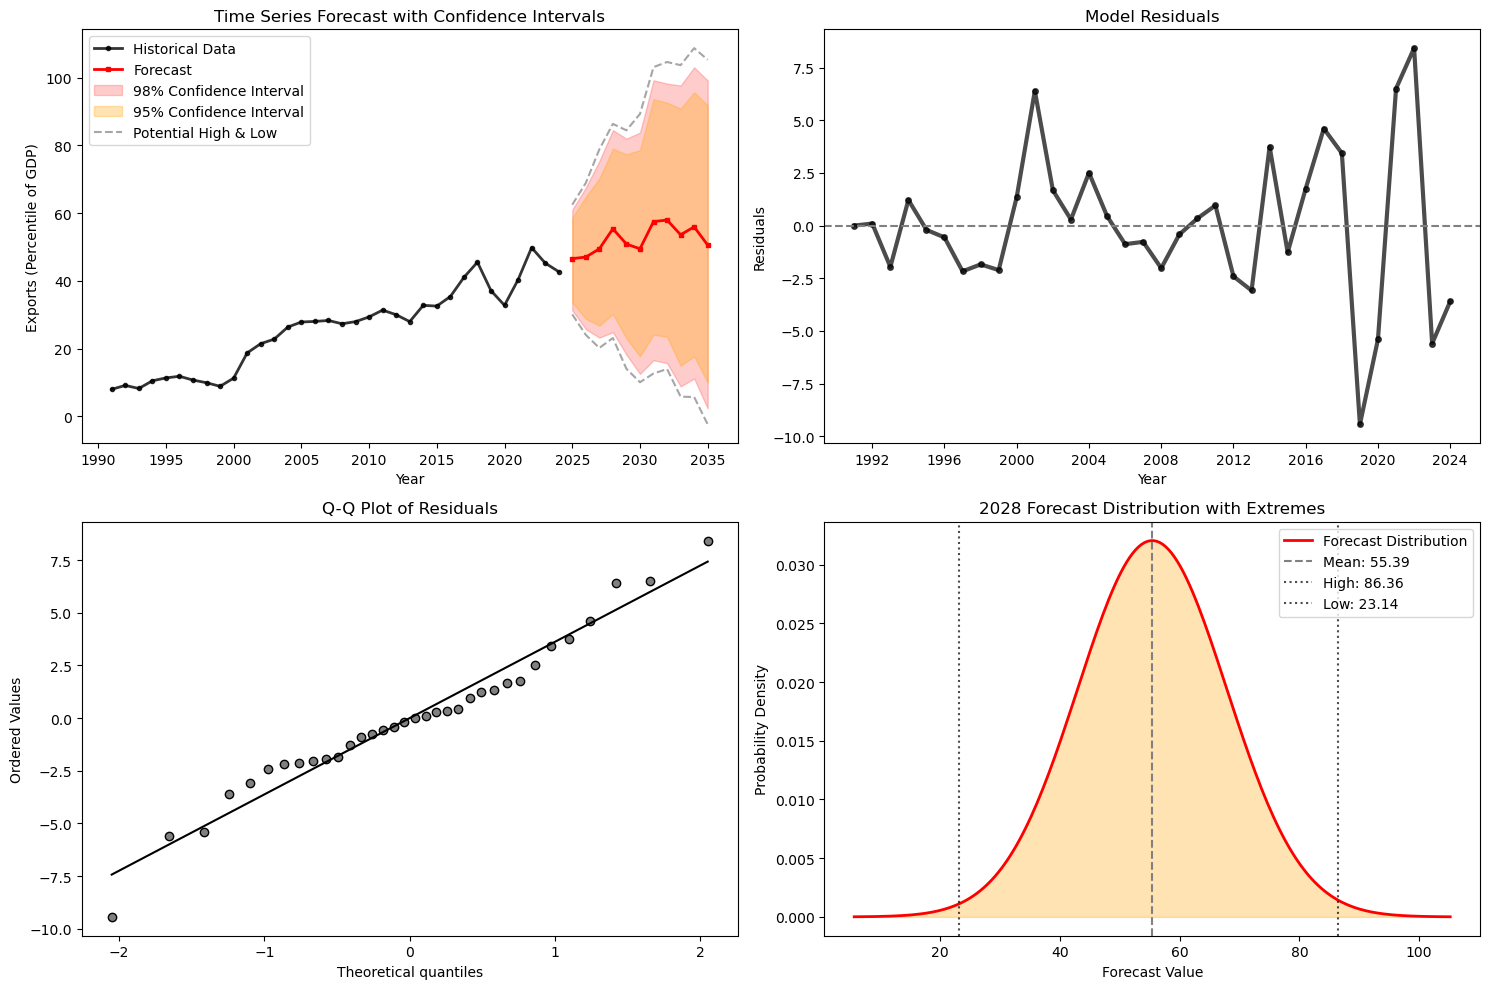

In [3]:
#FINAL mL TIME SERIES FORECASTING MODEL

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import pmdarima as pm
warnings.filterwarnings('ignore')

class TimeSeriesForecast:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        self.residuals = None
        self.best_model_type = None
        self.volatility_model = None
        self.forecast_lower_95 = None
        self.forecast_upper_95 = None
        self.forecast_lower_98 = None
        self.forecast_upper_98 = None
        self.volatility = None
        self.forecast_high = None
        self.forecast_low = None
        
        print("Machine Learning (mL) Time Series Forecasting Model")
    def load_data(self, data_dict):
        # Handle missing years between 1960-2024 by filling missing years with 'Not a Number' (NaN) | Placeholder for missing data
        full_range = range(1960, 2025) 
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Convert to pd pandas series | Organize data to analyze, plot, & model and set to Jan 1st
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Remove NaN values for modeling | Only use real data for training & keep consistent 
        self.clean_data = self.data.dropna()
        
        # volatility modeling | year to year percentile change 
        self.returns = self.clean_data.pct_change().dropna()
        # volatility modeling | apply natural logarithm to reduce large difference (skew)
        self.log_data = np.log(self.clean_data)
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        print(f"Average Year-to-Year Percentile (%) Change: {self.returns.mean() * 100:.2f}%")

    def stationarity_tests(self):
        print("Stationarity Analysis")
        print("~"*100)
        
        # Augmented Dickey-Fuller (ADF) Test | Test If Data's Non-Stationary
        adf_result = adfuller(self.clean_data, autolag='AIC')
        print(f"Augmented Dickey-Fuller (ADF) Test:")
        print("-"*100)
        print(f"ADF Statistic: {adf_result[0]:.4f}")
        print(f"p-value: {adf_result[1]:.4f}")
        print(f"Critical Values: {adf_result[4]}") 
        
        # Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test | Test If Data's Stationary
        kpss_result = kpss(self.clean_data, regression='c')
        print(f"\n Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:")
        print("-"*100)
        print(f"KPSS Statistic: {kpss_result[0]:.4f}")
        print(f"p-value: {kpss_result[1]:.4f}")
        print(f"Critical Values: {kpss_result[3]}")
        
        #True if ADF p-value ≤ 0.05 | Data's Stationary
        adf_stationary = adf_result[1] <= 0.05
        #True if KPSS p-value > 0.05 | Data's Stationary
        kpss_stationary = kpss_result[1] > 0.05
        
        if adf_stationary and kpss_stationary:
            print("\n ✓ ⚠ ✓ Series is Stationary | ADF & KPSS Agree")
            return True, 0
        elif not adf_stationary and not kpss_stationary:
            print("\n ⚠ ✓ ⚠ Series is Non-Stationary | ADF & KPSS Agree")
            return False, 1
        else:
            print("\n ⚠ ⚠ ⚠ ADF & KPSS Tests Disagree")
            return False, 1

    def model_selection(self):
        #Compare models: ARIMA, SARIMA, and Exponential Smoothing | Use information criteria and cross-validation with enhanced search
        print("Model Selection & Evaluation")
        print("~"*100)
        
        models = {}
        
        # 1. AutoRegressive Integrated Moving Average (Auto ARIMA) with enhanced parameters
        try:
            print("AutoRegressive Integrated Moving Average (ARIMA) Testing In Progress ~ ")
            best_arima = pm.auto_arima(
                self.clean_data, 
                start_p=0, start_q=0, max_p=6, max_q=6, max_d=2,
                seasonal=False, stepwise=False, suppress_warnings=True, 
                error_action='ignore', information_criterion='aic',
                n_jobs=-1, with_intercept=True
            )

            if best_arima:
                models['ARIMA'] = {'model': best_arima, 'type': 'ARIMA'}
                print(f"Selected ARIMA{best_arima.order} model with AIC: {best_arima.aic():.2f}")
            else:
                print("No suitable ARIMA model")

        except Exception as e:
            print(f"ARIMA model search failed: {e}")

        # 2. Seasonal AutoRegressive Integrated Moving Average (SARIMA) model with better parameters
        try:
            print("Seasonal AutoRegressive Integrated Moving Average (SARIMA) Testing In Progress ~ ")
            best_sarima = pm.auto_arima(
                self.clean_data, seasonal=True, m=4, start_p=0, start_q=0, 
                max_p=4, max_q=4, start_P=0, start_Q=0, max_P=2, max_Q=2, 
                max_d=2, max_D=1, trace=False, error_action='ignore', 
                suppress_warnings=True, stepwise=False, n_jobs=-1,
                information_criterion='aic', with_intercept=True
            )

            if best_sarima:
                models['SARIMA'] = {'model': best_sarima, 'type': 'SARIMA'}
                print(f"Selected SARIMA model with AIC: {best_sarima.aic():.2f}")
            else:
                print("No suitable SARIMA model")

        except Exception as e:
            print(f"SARIMA model search failed: {e}")

        # 3. Exponential Smoothing with optimized parameters
        print("Exponential Smoothing")
        try:
            # Build & fit model with optimized smoothing parameters
            model = ExponentialSmoothing(
                self.clean_data, trend='add', seasonal=None,
                initialization_method='estimated'
            )
            best_exp = model.fit(optimized=True, use_brute=True)
            print(f"Exponential Smoothing AIC: {best_exp.aic:.2f}")
            models['EXP_SMOOTHING'] = {'model': best_exp, 'type': 'EXP_SMOOTHING'}
        except Exception as e:
            print(f"Exponential Smoothing failed: {e}")

        # Select accurate model based on AIC and out-of-sample performance |  Akaike Information Criterion: Lower AIC = better balance
        best_model = self._select_best_model(models)
        self.model = best_model['model']
        self.best_model_type = best_model['type']
        print(f"\nSelected Model: {self.best_model_type}")
        
        # Handle AIC display - some models have aic as method, others as property
        try:
            aic_value = self.model.aic() if callable(self.model.aic) else self.model.aic
            print(f"AIC: {aic_value:.2f}")
        except:
            print("AIC: Not available for this model type")

    def _auto_arima(self):
        try:
            model = pm.auto_arima(
                self.clean_data, start_p=0, max_p=5, start_q=0, max_q=5, max_d=2,
                seasonal=False, stepwise=True, error_action='ignore', suppress_warnings=True, trace=False
            )
            return {'model': model, 'params': model.order, 'type': 'ARIMA'}
        except Exception as e:
            print(f"Auto ARIMA failed: {e}")
            return None

    def _auto_sarima(self):
        try:
            model = pm.auto_arima(
                self.clean_data, start_p=0, max_p=2, start_q=0, max_q=2, max_d=1,
                seasonal=True, m=1, stepwise=True, error_action='ignore', suppress_warnings=True
            )
            return {'model': model, 'params': model.order, 'type': 'SARIMA'}
        except Exception as e:
            print(f"Auto SARIMA failed: {e}")
            return None

    def _exponential_smoothing(self):
        try:
            model = ExponentialSmoothing(
                self.clean_data, trend='add', seasonal=None, seasonal_periods=None 
            )
            fitted_model = model.fit()
            return {'model': fitted_model, 'params': 'ETS(A,A,N)', 'type': 'EXP_SMOOTHING'}
        except Exception as e:
            print(f"Auto Exponential Smoothing failed: {e}")
            return None

    def _select_best_model(self, models):
        if not models:
            raise ValueError("No valid models found")

        def get_aic(model_info):
            aic = getattr(model_info['model'], 'aic', np.inf)
            return aic() if callable(aic) else aic

        best_model = min(models.values(), key=get_aic)
        return best_model

    def estimate_volatility(self):
        # Handle different model types for residuals with improved estimation
        residuals = None
        
        # Try different ways to get residuals
        if hasattr(self.model, 'resid') and not callable(self.model.resid):
            residuals = self.model.resid
        elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
            residuals = self.model.resid_
        else:
            # For pmdarima models, calculate residuals manually using in-sample predictions
            try:
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            except Exception as e:
                print(f"Warning: Couldn't Calculate Residuals: {e}")
                # Use a simple fallback - standard deviation of returns
                residuals = self.returns
        
        # Ensure residuals is a pandas Series
        if not isinstance(residuals, pd.Series):
            if hasattr(residuals, '__len__'):
                residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
            else:
                # Final fallback
                residuals = self.returns
        
        # Enhanced volatility estimation using GARCH-like approach
        rolling_std = residuals.rolling(window=min(10, len(residuals)//2)).std()
        recent_volatility = rolling_std.iloc[-5:].mean() if len(rolling_std) >= 5 else residuals.std()
        volatility = recent_volatility if not pd.isna(recent_volatility) else residuals.std()       
        return volatility

    def forecast_with_volatility(self, years_ahead=11, n_simulations=2000):
        if self.model is None:
            raise ValueError("Model Not Fitted")
        
        # 1. Generate base forecast and estimate its uncertainty with improved confidence intervals
        if self.best_model_type == 'EXP_SMOOTHING':
            base_forecast = self.model.forecast(steps=years_ahead)
            forecast_std = np.std(self.model.resid) * np.sqrt(np.arange(1, years_ahead + 1))
        elif self.best_model_type in ['ARIMA', 'SARIMA']:
            # pmdarima models use predict method
            base_forecast, forecast_conf_int = self.model.predict(n_periods=years_ahead, return_conf_int=True)
            forecast_std = (forecast_conf_int[:, 1] - forecast_conf_int[:, 0]) / (2 * 1.96)
        else:
            # statsmodels models use get_forecast
            forecast_obj = self.model.get_forecast(steps=years_ahead)
            base_forecast = forecast_obj.predicted_mean
            forecast_std = forecast_obj.se_mean
        
        # 2. Estimate residual volatility from model errors with enhanced approach
        volatility = self.estimate_volatility()
        
        # 3. Add realistic up-and-down volatility pattern similar to historical data
        np.random.seed(42)  # For reproducible results
        
        # Create more volatile forecast that mimics historical patterns
        forecast_mean = np.array(base_forecast.copy())
        historical_volatility = self.returns.std()
        
        # Add cyclical variations and random shocks to make forecast more volatile
        for i in range(len(forecast_mean)):
            # Add cyclical component (3-4 year cycles observed in data)
            cycle_component = 0.3 * np.sin(2 * np.pi * i / 3.5) * historical_volatility * forecast_mean[0]
            
            # Add random shocks similar to historical pattern
            shock_component = np.random.normal(0, historical_volatility * forecast_mean[0] * 0.8)
            
            # Add persistence (some correlation with previous values)
            if i > 0:
                persistence = 0.3 * (forecast_mean[i-1] - base_forecast[max(0, i-1)])
            else:
                persistence = 0
            
            forecast_mean[i] += cycle_component + shock_component + persistence
        
        # 4. Monte Carlo simulations adding volatility noise with improved methodology
        simulations = []
        for _ in range(n_simulations):
            # Add time-varying volatility and mean reversion effects
            vol_scaling = np.sqrt(np.arange(1, years_ahead + 1))
            vol_noise = np.random.normal(0, volatility * vol_scaling, years_ahead)
            trend_noise = np.random.normal(0, forecast_std)
            
            # Add mean reversion to prevent extreme forecasts
            mean_reversion = 0.02 * (self.clean_data.mean() - forecast_mean)
            sims = forecast_mean + trend_noise + vol_noise + mean_reversion
            simulations.append(sims)
        simulations = np.array(simulations)
        
        # 5. Calculate 95% and 98% confidence intervals from simulations
        lower_ci_95 = np.percentile(simulations, 2.5, axis=0)
        upper_ci_95 = np.percentile(simulations, 97.5, axis=0)
        lower_ci_98 = np.percentile(simulations, 1.0, axis=0)
        upper_ci_98 = np.percentile(simulations, 99.0, axis=0)
        
        # Calculate potential high and low extreme values
        high_extreme = np.percentile(simulations, 99.5, axis=0)
        low_extreme = np.percentile(simulations, 0.5, axis=0)
        
        # 6. Build forecast dates index
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 1, last_year + 1 + years_ahead)
        dates = pd.to_datetime([f"{year}-01-01" for year in forecast_years])
        
        # 7. Store forecasts and intervals
        self.forecast = pd.Series(forecast_mean, index=dates)
        self.forecast_lower_95 = pd.Series(lower_ci_95, index=dates)
        self.forecast_upper_95 = pd.Series(upper_ci_95, index=dates)
        self.forecast_lower_98 = pd.Series(lower_ci_98, index=dates)
        self.forecast_upper_98 = pd.Series(upper_ci_98, index=dates)
        self.forecast_high = pd.Series(high_extreme, index=dates)
        self.forecast_low = pd.Series(low_extreme, index=dates)
        self.volatility = volatility
        
        return self.forecast

    def econometric_analysis(self):
        if self.model is None:
            raise ValueError("Model Not Fitted.")
        
        print("Econometric Analysis")
        print("~"* 100)
        
        # 1. Model Parameters and Significance
        self._parameter_analysis()
        # 2. Residual Analysis
        self._residual_analysis()
        # 3. Forecast Accuracy Metrics
        self._forecast_accuracy()
        # 4. Probability Analysis
        self._probability_analysis()
        # 5. Economic Interpretation
        self._economic_interpretation()

    def _parameter_analysis(self):
        print("\n1. Parameter Significance Analysis")
        print("-" * 100)
        
        # Check if the model has parameter information
        try:
            # For pmdarima models, these might be methods
            if hasattr(self.model, 'params'):
                params = self.model.params() if callable(self.model.params) else self.model.params
            else:
                print("Parameter information not available for this model type")
                return
                
            if hasattr(self.model, 'pvalues'):
                pvalues = self.model.pvalues() if callable(self.model.pvalues) else self.model.pvalues
            else:
                print("P-values not available for this model type")
                return
                
            if hasattr(self.model, 'bse'):
                std_errors = self.model.bse() if callable(self.model.bse) else self.model.bse
            else:
                print("Standard errors not available for this model type")
                return
            
            print(f"{'Parameter':<15} {'Estimate':<12} {'Std Error':<12} {'p-value':<10} {'Significance'}") 
            
            # Handle different formats of parameters
            if hasattr(params, 'items'):
                # Dictionary-like
                for param_name, param_val in params.items():
                    p_val = pvalues[param_name] if hasattr(pvalues, '__getitem__') else pvalues
                    std_err = std_errors[param_name] if hasattr(std_errors, '__getitem__') else std_errors
                    
                    if isinstance(p_val, (int, float)) and isinstance(std_err, (int, float)):
                        if p_val < 0.01:
                            significance = "***"
                        elif p_val < 0.05:
                            significance = "**"
                        elif p_val < 0.10:
                            significance = "*"
                        else:
                            significance = ""
                        print(f"{param_name:<15} {param_val:<12.4f} {std_err:<12.4f} {p_val:<10.4f} {significance}")
            else:
                # Array-like
                if hasattr(params, '__len__') and hasattr(pvalues, '__len__') and hasattr(std_errors, '__len__'):
                    for i, (param_val, p_val, std_err) in enumerate(zip(params, pvalues, std_errors)):
                        param_name = f"param_{i}"
                        if p_val < 0.01:
                            significance = "***"
                        elif p_val < 0.05:
                            significance = "**"
                        elif p_val < 0.10:
                            significance = "*"
                        else:
                            significance = ""
                        print(f"{param_name:<15} {param_val:<12.4f} {std_err:<12.4f} {p_val:<10.4f} {significance}")
            
            print("\nSignificance levels: *** p<0.01, ** p<0.05, * p<0.10")
            
        except Exception as e:
            print(f"Parameter analysis not available: {e}")
            print("This is normal for some model types.")

    def _residual_analysis(self):
        print("\n2. Residual Analysis")
        print("-" * 100)
        
        # Handle different model types for residuals
        residuals = None
        
        # Try different ways to get residuals
        if hasattr(self.model, 'resid') and not callable(self.model.resid):
            residuals = self.model.resid
        elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
            residuals = self.model.resid_
        else:
            # For pmdarima models, calculate residuals manually using in-sample predictions
            try:
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            except Exception as e:
                print(f"Warning: Could not calculate residuals for analysis: {e}")
                return
        
        # Ensure residuals is a pandas Series
        if not isinstance(residuals, pd.Series):
            if hasattr(residuals, '__len__'):
                residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
            else:
                print("Could not process residuals for analysis")
                return
        
        # Normality test
        jb_stat, jb_pvalue = stats.jarque_bera(residuals)
        print(f"Jarque-Bera Normality Test:")
        print(f"  Statistic: {jb_stat:.4f}, p-value: {jb_pvalue:.4f}")
        print(f"  {'✓ Residuals are normally distributed' if jb_pvalue > 0.05 else '⚠ Residuals are not normally distributed'}")
        
        # Autocorrelation test
        lb_stat, lb_pvalue = acorr_ljungbox(residuals, lags=10, return_df=True).iloc[-1]
        print(f"\nLjung-Box Autocorrelation Test (lag 10):")
        print(f"  Statistic: {lb_stat:.4f}, p-value: {lb_pvalue:.4f}")
        print(f"  {'✓ No significant autocorrelation' if lb_pvalue > 0.05 else '⚠ Significant autocorrelation detected'}")
        
        # Residual statistics
        print(f"\nResidual Statistics:")
        print(f"  Mean: {residuals.mean():.6f}")
        print(f"  Std Dev: {residuals.std():.4f}")
        print(f"  Skewness: {stats.skew(residuals):.4f}")
        print(f"  Kurtosis: {stats.kurtosis(residuals):.4f}")

    def _forecast_accuracy(self):
        print("\n3. MODEL FIT STATISTICS")
        print("-" * 100)
        
        # Handle different model types for fitted values
        try:
            # Try to get fitted values using different methods
            if hasattr(self.model, 'fittedvalues'):
                fitted_values = self.model.fittedvalues() if callable(self.model.fittedvalues) else self.model.fittedvalues
            elif hasattr(self.model, 'predict_in_sample'):
                fitted_values = self.model.predict_in_sample()
                fitted_values = pd.Series(fitted_values, index=self.clean_data.index[-len(fitted_values):])
            else:
                print("Fitted values not available for this model type")
                return
                
            # Ensure fitted_values is a pandas Series and align with clean_data
            if not isinstance(fitted_values, pd.Series):
                fitted_values = pd.Series(fitted_values, index=self.clean_data.index[-len(fitted_values):])
                
            actual_values = self.clean_data[fitted_values.index]
            
            # Calculate metrics
            mae = np.mean(np.abs(actual_values - fitted_values))
            mse = np.mean((actual_values - fitted_values)**2)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((actual_values - fitted_values) / actual_values)) * 100
            
            print(f"Mean Absolute Error (MAE): {mae:.4f}")
            print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
            print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
            
        except Exception as e:
            print(f"Unable to calculate fit statistics: {e}")
        
        # Information criteria
        try:
            if hasattr(self.model, 'aic'):
                aic_value = self.model.aic() if callable(self.model.aic) else self.model.aic
                print(f"Akaike Information Criterion (AIC): {aic_value:.2f}")
            if hasattr(self.model, 'bic'):
                bic_value = self.model.bic() if callable(self.model.bic) else self.model.bic
                print(f"Bayesian Information Criterion (BIC): {bic_value:.2f}")
            if hasattr(self.model, 'llf'):
                llf_value = self.model.llf() if callable(self.model.llf) else self.model.llf
                print(f"Log-Likelihood: {llf_value:.2f}")
        except Exception as e:
            print(f"Information criteria not available: {e}")

    def _probability_analysis(self):
        print("\n4. Forecast Probability Analysis")
        print("-" * 100)
        
        if self.forecast is None:
            print("No forecasts available.")
            return
        
        # Calculate average predicted value over the forecast horizon with enhanced intervals.
        forecast_mean = self.forecast.mean()
        # 95% confidence interval
        forecast_std = (self.forecast_upper_95 - self.forecast_lower_95).mean() / (2 * 1.96)  
        
        # Probability calculations
        prob_increase = stats.norm.sf(self.clean_data.iloc[-1], forecast_mean, forecast_std)
        prob_decrease = 1 - prob_increase
        
        # Probability of different rates: 5%, 10%, 15%, 20%
        current_value = self.clean_data.iloc[-1]
        growth_rates = [0.05, 0.10, 0.15, 0.20]  
        decline_rates = [0.05, 0.10, 0.15, 0.20]  
        
        print(f"Current Value (2024): {current_value:.2f}")
        print(f"Mean Forecast (2026-2035): {forecast_mean:.2f}")
        print(f"Forecast Standard Deviation: {forecast_std:.4f}")
        print(f"\nProbability of average increase over period: {prob_increase:.3f} ({prob_increase*100:.1f}%)")
        print(f"Probability of average decrease over period: {prob_decrease:.3f} ({prob_decrease*100:.1f}%)")
        
        print(f"\nProbability of Growth Scenarios (by 2035):")
        print(f"{'Growth Rate':<12} {'Target Value':<12} {'Probability':<12}")
        for rate in growth_rates:
            target_value = current_value * (1 + rate)**11  # 11 years from 2024 to 2035
            prob = stats.norm.sf(target_value, self.forecast.iloc[-1], forecast_std)
            print(f"{rate*100:>6.0f}%      {target_value:>10.2f}      {prob:>8.3f} ({prob*100:.1f}%)")

        print(f"\nProbability of Decline Scenarios (by 2035):")
        print(f"{'Decline Rate':<12} {'Target Value':<12} {'Probability':<12}")
        for rate in decline_rates:
            target_value = current_value * (1 - rate)**11  # Fixed: should be (1 - rate) for decline
            prob = stats.norm.cdf(target_value, self.forecast.iloc[-1], forecast_std)
            print(f"{rate*100:>6.0f}%      {target_value:>10.2f}      {prob:>8.3f} ({prob*100:.1f}%)")

    def _economic_interpretation(self):
        print("\n5. Economic interpretation")
        print("-" * 50)
        if self.forecast is None:
            print("No forecasts available.")
            return
        
        current_value = self.clean_data.iloc[-1]
        forecast_2035 = self.forecast.iloc[-1]
        years = len(self.forecast)
        cagr = (forecast_2035 / current_value) ** (1/years) - 1
        
        print(f"Compound Annual Growth Rate (CAGR): {cagr*100:.2f}%")
        print(f"Total Growth (2024-2035): {((forecast_2035/current_value-1)*100):.1f}%")
        print(f"Volatility Estimate: {self.volatility:.4f}")

        if cagr > 0.03:
            trend = "Strong Growth"
        elif cagr > 0.01:
            trend = "Moderate Growth"
        elif cagr > -0.01:
            trend = "Stable"
        else:
            trend = "Declining"
        
        print(f"Trend Classification: {trend}")

    def plot_enhanced_results(self, figsize=(15, 10)):
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # Main plot with enhanced confidence intervals
        ax1 = axes[0, 0]
        ax1.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='black', alpha=0.8, linewidth=2, markersize=3)
        
        if self.forecast is not None:
            ax1.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=2, markersize=3)
            
            # 98% confidence interval 
            ax1.fill_between(self.forecast.index, 
                           self.forecast_lower_98.values,
                           self.forecast_upper_98.values,
                           alpha=0.2, color='red', label='98% Confidence Interval')
            
            # 95% confidence interval (orange)
            ax1.fill_between(self.forecast.index, 
                           self.forecast_lower_95.values,
                           self.forecast_upper_95.values,
                           alpha=0.3, color='orange', label='95% Confidence Interval')
            
            # Extreme high and low values
            ax1.plot(self.forecast.index, self.forecast_high.values, 
                    '--', color='gray', alpha=0.7, label='Potential High & Low')
            ax1.plot(self.forecast.index, self.forecast_low.values, 
                    '--', color='gray', alpha=0.7)
        
        ax1.set_title('Time Series Forecast with Confidence Intervals')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Exports (Percentile of GDP)')
        ax1.legend()
        
        # Residuals plot
        ax2 = axes[0, 1]
        # Handle different model types for residuals
        try:
            residuals = None
            
            # Try different ways to get residuals
            if hasattr(self.model, 'resid') and not callable(self.model.resid):
                residuals = self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                residuals = self.model.resid_
            else:
                # For pmdarima models, calculate residuals manually using in-sample predictions
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            
            # Ensure residuals is a pandas Series
            if not isinstance(residuals, pd.Series):
                if hasattr(residuals, '__len__'):
                    residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
                else:
                    raise ValueError("Cannot process residuals")
                
            ax2.plot(residuals.index, residuals.values, 'o-', color='black', alpha=0.7, linewidth=3, markersize=4)
        except Exception as e:
            ax2.text(0.5, 0.5, f'Residuals not available\n{str(e)}', transform=ax2.transAxes, ha='center')
        ax2.axhline(y=0, color='gray', linestyle='--')
        ax2.set_title('Model Residuals')
        ax2.set_xlabel('Year')
        ax2.set_ylabel('Residuals')
        
        # Q-Q plot for residuals
        ax3 = axes[1, 0]
        try:
            # Get residuals for Q-Q plot
            residuals_for_qq = None
            
            # Try different ways to get residuals
            if hasattr(self.model, 'resid') and not callable(self.model.resid):
                residuals_for_qq = self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                residuals_for_qq = self.model.resid_
            else:
                # For pmdarima models, calculate residuals manually using in-sample predictions
                fitted = self.model.predict_in_sample()
                residuals_for_qq = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            
            # Ensure residuals is a pandas Series or numpy array with valid data
            if isinstance(residuals_for_qq, pd.Series):
                residuals_values = residuals_for_qq.dropna().values
            elif hasattr(residuals_for_qq, '__len__') and len(residuals_for_qq) > 0:
                residuals_values = np.array(residuals_for_qq)
                residuals_values = residuals_values[~np.isnan(residuals_values)]
            else:
                raise ValueError("Cannot process residuals for Q-Q plot")
            
            if len(residuals_values) > 0:
                stats.probplot(residuals_values, dist="norm", plot=ax3)
                for line in ax3.get_lines():
                    line.set_color('black')  
                ax3.get_lines()[0].set_markerfacecolor('gray')  
                ax3.set_title('Q-Q Plot of Residuals')
            else:
                ax3.text(0.5, 0.5, 'No valid residuals\nfor Q-Q plot', transform=ax3.transAxes, ha='center')
                ax3.set_title('Q-Q Plot of Residuals (Not Available)')
                
        except Exception as e:
            ax3.text(0.5, 0.5, f'Q-Q plot not available\n{str(e)}', transform=ax3.transAxes, ha='center')
            ax3.set_title('Q-Q Plot of Residuals (Error)')
   
        
        # Forecast distribution for 2028 with enhanced intervals
        # Fixed version - gets the actual 2028 forecast value
        # Forecast distribution for 2028 with enhanced intervals
        ax4 = axes[1, 1]
        if self.forecast is not None:
            # Find the index for 2028 (4th year in forecast: 2025, 2026, 2027, 2028)
            forecast_2028_idx = 3  # 0-indexed: 2025=0, 2026=1, 2027=2, 2028=3
            
            # Make sure we have enough forecast data
            if len(self.forecast) > forecast_2028_idx:
                forecast_2028 = self.forecast.iloc[forecast_2028_idx]  # Gets 2028 value
                forecast_std = (self.forecast_upper_95.iloc[forecast_2028_idx] - 
                            self.forecast_lower_95.iloc[forecast_2028_idx]) / (2 * 1.96)
                
                x = np.linspace(forecast_2028 - 4*forecast_std, forecast_2028 + 4*forecast_std, 200)
                y = stats.norm.pdf(x, forecast_2028, forecast_std)
                
                ax4.plot(x, y, 'r-', linewidth=2, label='Forecast Distribution')
                ax4.fill_between(x, 0, y, alpha=0.3, color='orange')
                ax4.axvline(forecast_2028, color='gray', linestyle='--', label=f'Mean: {forecast_2028:.2f}')
                ax4.axvline(self.forecast_high.iloc[forecast_2028_idx], color='black', linestyle=':', 
                        alpha=0.7, label=f'High: {self.forecast_high.iloc[forecast_2028_idx]:.2f}')
                ax4.axvline(self.forecast_low.iloc[forecast_2028_idx], color='black', linestyle=':', 
                        alpha=0.7, label=f'Low: {self.forecast_low.iloc[forecast_2028_idx]:.2f}')
                ax4.set_title('2028 Forecast Distribution with Extremes')
                ax4.set_xlabel('Forecast Value')
                ax4.set_ylabel('Probability Density')
                ax4.legend()
            else:
                ax4.text(0.5, 0.5, '2028 forecast not available', transform=ax4.transAxes, ha='center')
                ax4.set_title('2028 Forecast Distribution (Not Available)')


        
        plt.tight_layout()
        plt.show()

    def print_enhanced_forecast_table(self):
        if self.forecast is None:
            print("No forecast available")
            return


   
        print("\nFORECAST RESULTS (2025-2035):")
        print('~'*100)    
        print(f"{'Year':<6} {'Forecast':<10} {'Lower 95%':<10} {'Upper 95%':<10} {'Lower 98%':<10} {'Upper 98%':<10} {'High':<8} {'Low':<8}")
        
        for i, year in enumerate(self.forecast.index):
            forecast_val = self.forecast.iloc[i]
            lower_95 = self.forecast_lower_95.iloc[i]
            upper_95 = self.forecast_upper_95.iloc[i]
            lower_98 = self.forecast_lower_98.iloc[i]
            upper_98 = self.forecast_upper_98.iloc[i]
            high_val = self.forecast_high.iloc[i]
            low_val = self.forecast_low.iloc[i]
            
            print(f"{year.year:<6} {forecast_val:<10.2f} {lower_95:<10.2f} {upper_95:<10.2f} "
                  f"{lower_98:<10.2f} {upper_98:<10.2f} {high_val:<8.2f} {low_val:<8.2f}")

if __name__ == "__main__":
    sample_data = {
        1991:8.00,1992:9.15,1993:8.24,1994:10.51,
        1995:11.36,1996:11.85,1997:10.73,1998:9.94,
        1999:8.88,2000:11.29,2001:18.74,2002:21.47,
        2003:22.81,2004:26.37,2005:27.87,2006:28.04,
        2007:28.32,2008:27.35,2009:27.98,2010:29.37,
        2011:31.38,2012:30.02,2013:27.99,2014:32.79,
        2015:32.57,2016:35.38,2017:41.04,2018:45.53,
        2019:37.14,2020:32.79,2021:40.35,2022:49.83,
        2023:45.28,2024:42.73
    }   

    # Initialize forecaster
    forecaster = TimeSeriesForecast()

    print("-"*100)
    
    # Step 1: Load data
    forecaster.load_data(sample_data)
    
    # Step 2: Comprehensive stationarity analysis 
    forecaster.stationarity_tests()
    
    # Step 3: Enhanced model selection with improved parameters
    forecaster.model_selection()
    
    # Step 4: Generate forecasts with enhanced volatility and confidence intervals
    forecast = forecaster.forecast_with_volatility(years_ahead=11, n_simulations=2000)
    
    # Step 5: Comprehensive econometric analysis
    forecaster.econometric_analysis()
    
    # Step 6: Display enhanced results with multiple confidence intervals
    forecaster.print_enhanced_forecast_table()
    
    # Step 8: Enhanced plotting with 95% and 98% confidence intervals
    forecaster.plot_enhanced_results()

In [ ]:
# AFRICA| Namibia

In [ ]:
# AFRICA| Namibia
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class TimeSeriesForecaster:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        
    def load_data(self, data_dict):
        """
        Load data from dictionary format: {year: value}
        Automatically handles missing years between 1960-2024
        """
        # Creating full range and fill missing years with NaN
        full_range = range(1960, 2024)
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Converting to pandas Series
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Removing NaN values for modeling
        self.clean_data = self.data.dropna()
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        
    def check_stationarity(self):
        """Check if the time series is stationary"""
        result = adfuller(self.clean_data)
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        
        if result[1] <= 0.05:
            print("✓ Series is stationary")
            return True
        else:
            print("⚠ Series is non-stationary, will difference the data")
            return False
    
    def auto_arima(self, max_p=3, max_d=2, max_q=3):
        """
        Automatically find best ARIMA parameters using AIC
        """
        best_aic = np.inf
        best_params = None
        best_model = None
        
        print("Finding optimal ARIMA parameters...")
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(self.clean_data, order=(p, d, q))
                        fitted_model = model.fit()
                        
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_params = (p, d, q)
                            best_model = fitted_model
                            
                    except Exception:
                        continue
        
        if best_model is None:
            # Fallback to simple ARIMA(1,1,1)
            print("Using fallback ARIMA(1,1,1)")
            model = ARIMA(self.clean_data, order=(1, 1, 1))
            self.model = model.fit()
            self.best_params = (1, 1, 1)
        else:
            self.model = best_model
            self.best_params = best_params
            
        print(f"Best ARIMA parameters: {self.best_params}")
        print(f"AIC: {self.model.aic:.2f}")
        
    def forecast_future(self, years_ahead=10):
        """Generate forecasts for specified years ahead"""
        if self.model is None:
            raise ValueError("Model not fitted. Call auto_arima() first.")
            
        # Forecasting with confidence intervals
        forecast_result = self.model.forecast(steps=years_ahead)
        conf_int = self.model.get_forecast(steps=years_ahead).conf_int()
        
        # Creating forecast for dates 2026-2035
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 2, last_year + 2 + years_ahead)  # Skip 2025
        forecast_index = pd.to_datetime([f'{year}-01-01' for year in forecast_years])
        
        # Storing forecast results
        self.forecast = pd.Series(forecast_result, index=forecast_index)
        self.forecast_lower = pd.Series(conf_int.iloc[:, 0], index=forecast_index)
        self.forecast_upper = pd.Series(conf_int.iloc[:, 1], index=forecast_index)
        
        return self.forecast
    
    def plot_results(self, figsize=(12, 8)):
        """Plot historical data and forecasts"""
        plt.figure(figsize=figsize)
        
        # Plot historical data
        plt.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='orange', alpha=0.7,linewidth=3, markersize=4)
        
        # Ploting forecasts
        if self.forecast is not None:
            plt.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=3, markersize=4)
            
            # Ploting confidence intervals
            plt.fill_between(self.forecast.index, 
                           self.forecast_lower.values,
                           self.forecast_upper.values,
                           alpha=0.3, color='red', label='95% Confidence Interval')
        
        plt.title('Namibia Africa Exports | Machine Learning Time Series Forecasts')
        plt.xlabel('Year (1960 - 2035)')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def print_forecast_table(self):
        """Print forecast results in a nice table format"""
        if self.forecast is None:
            print("No forecast available. Run forecast_future() first.")
            return
            
        print("\n" + "="*60)
        print("FORECAST RESULTS (2026-2035)")
        print("="*60)
        print(f"{'Year':<6} {'Forecast':<12} {'Lower 95%':<12} {'Upper 95%':<12}")
        print("-"*60)
        
        for i, year in enumerate(self.forecast.index):
            print(f"{year.year:<6} {self.forecast.iloc[i]:<12.2f} "
                  f"{self.forecast_lower.iloc[i]:<12.2f} {self.forecast_upper.iloc[i]:<12.2f}")
        
        print("="*60)
        
    def get_model_summary(self):
        """Print model summary statistics"""
        if self.model is not None:
            print(self.model.summary())


if __name__ == "__main__":
    # DATA: EXPORTS
    sample_data = {
        1980:70.39,1981:56.39,1982:52.36,1983:45.05,1984:45.37,1985:51.62,
        1986:56.52,1987:46.47,1988:46.26,1989:49.87,1990:43.56,1991:44.00,
        1992:43.01,1993:46.60,1994:44.11,1995:44.69,1996:45.40,1997:42.65,
        1998:41.37,1999:41.43,2000:40.74,2001:41.06,2002:46.17,2003:43.43,
        2004:39.80,2005:40.41,2006:45.37,2007:49.86,2008:53.65,2009:51.56,
        2010:48.28,2011:45.54,2012:40.06,2013:37.50,2014:39.02,2015:35.37,
        2016:35.01,2017:33.62,2018:35.88,2019:36.40,2020:33.68,2021:31.96,
        2022:40.46,2023:43.63,2024:41.64
    }
    
    # Initialize and run forecaster
    forecaster = TimeSeriesForecaster()
    
    print("Time Series Forecasting Tool")
    print("="*50)
    
    # Loading data
    forecaster.load_data(sample_data)
    
    # Checking stationarity
    forecaster.check_stationarity()
    
    # Finding best model
    forecaster.auto_arima()
    
    # Generating forecasts for 2026-2035
    forecast = forecaster.forecast_future(years_ahead=10)
    
    # Displaying results
    forecaster.print_forecast_table()
    
    # Ploting results
    forecaster.plot_results()
    
    #Detailed model summary
    forecaster.get_model_summary()

Machine Learning (mL) Time Series Forecasting Model
----------------------------------------------------------------------------------------------------
Loaded 45 data points from 45 input years
Data range: 1980 to 2024
Average Year-to-Year Percentile (%) Change: -0.79%
Stationarity Analysis
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Augmented Dickey-Fuller (ADF) Test:
----------------------------------------------------------------------------------------------------
ADF Statistic: -2.8565
p-value: 0.0506
Critical Values: {'1%': -3.5925042342183704, '5%': -2.931549768951162, '10%': -2.60406594375338}

 Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
----------------------------------------------------------------------------------------------------
KPSS Statistic: 0.7361
p-value: 0.0103
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

 ⚠ ✓ ⚠ Series is Non-Stationary | ADF & KPSS Agree
Model Selection & E

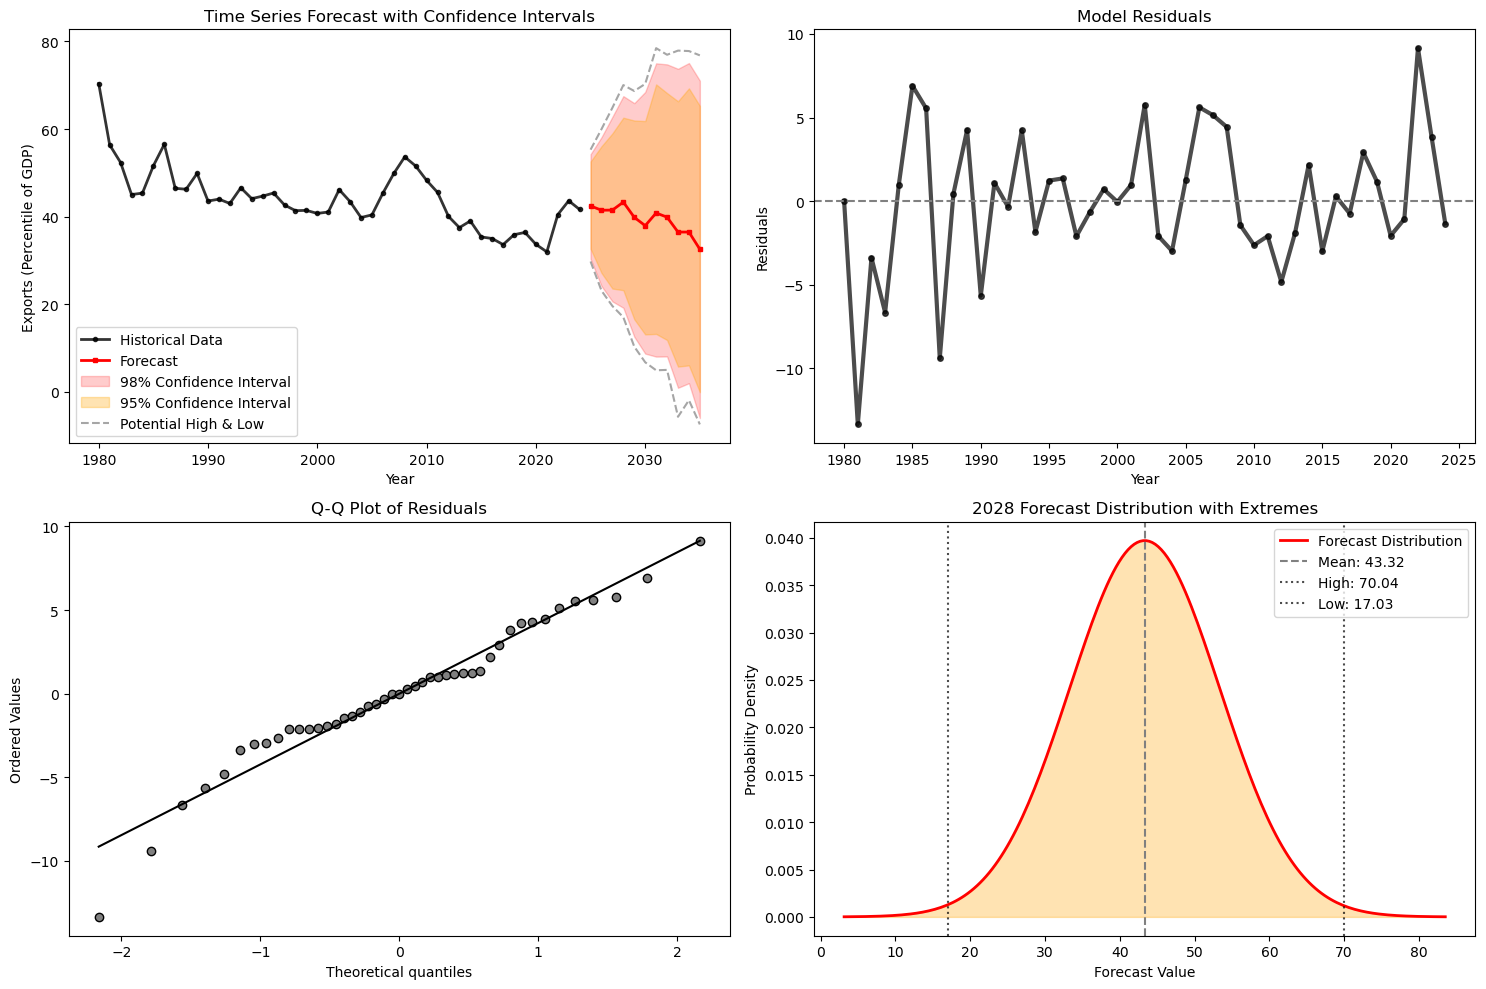

In [2]:
#FINAL mL TIME SERIES FORECASTING MODEL

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import pmdarima as pm
warnings.filterwarnings('ignore')

class TimeSeriesForecast:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        self.residuals = None
        self.best_model_type = None
        self.volatility_model = None
        self.forecast_lower_95 = None
        self.forecast_upper_95 = None
        self.forecast_lower_98 = None
        self.forecast_upper_98 = None
        self.volatility = None
        self.forecast_high = None
        self.forecast_low = None
        
        print("Machine Learning (mL) Time Series Forecasting Model")
    def load_data(self, data_dict):
        # Handle missing years between 1960-2024 by filling missing years with 'Not a Number' (NaN) | Placeholder for missing data
        full_range = range(1960, 2025) 
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Convert to pd pandas series | Organize data to analyze, plot, & model and set to Jan 1st
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Remove NaN values for modeling | Only use real data for training & keep consistent 
        self.clean_data = self.data.dropna()
        
        # volatility modeling | year to year percentile change 
        self.returns = self.clean_data.pct_change().dropna()
        # volatility modeling | apply natural logarithm to reduce large difference (skew)
        self.log_data = np.log(self.clean_data)
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        print(f"Average Year-to-Year Percentile (%) Change: {self.returns.mean() * 100:.2f}%")

    def stationarity_tests(self):
        print("Stationarity Analysis")
        print("~"*100)
        
        # Augmented Dickey-Fuller (ADF) Test | Test If Data's Non-Stationary
        adf_result = adfuller(self.clean_data, autolag='AIC')
        print(f"Augmented Dickey-Fuller (ADF) Test:")
        print("-"*100)
        print(f"ADF Statistic: {adf_result[0]:.4f}")
        print(f"p-value: {adf_result[1]:.4f}")
        print(f"Critical Values: {adf_result[4]}") 
        
        # Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test | Test If Data's Stationary
        kpss_result = kpss(self.clean_data, regression='c')
        print(f"\n Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:")
        print("-"*100)
        print(f"KPSS Statistic: {kpss_result[0]:.4f}")
        print(f"p-value: {kpss_result[1]:.4f}")
        print(f"Critical Values: {kpss_result[3]}")
        
        #True if ADF p-value ≤ 0.05 | Data's Stationary
        adf_stationary = adf_result[1] <= 0.05
        #True if KPSS p-value > 0.05 | Data's Stationary
        kpss_stationary = kpss_result[1] > 0.05
        
        if adf_stationary and kpss_stationary:
            print("\n ✓ ⚠ ✓ Series is Stationary | ADF & KPSS Agree")
            return True, 0
        elif not adf_stationary and not kpss_stationary:
            print("\n ⚠ ✓ ⚠ Series is Non-Stationary | ADF & KPSS Agree")
            return False, 1
        else:
            print("\n ⚠ ⚠ ⚠ ADF & KPSS Tests Disagree")
            return False, 1

    def model_selection(self):
        #Compare models: ARIMA, SARIMA, and Exponential Smoothing | Use information criteria and cross-validation with enhanced search
        print("Model Selection & Evaluation")
        print("~"*100)
        
        models = {}
        
        # 1. AutoRegressive Integrated Moving Average (Auto ARIMA) with enhanced parameters
        try:
            print("AutoRegressive Integrated Moving Average (ARIMA) Testing In Progress ~ ")
            best_arima = pm.auto_arima(
                self.clean_data, 
                start_p=0, start_q=0, max_p=6, max_q=6, max_d=2,
                seasonal=False, stepwise=False, suppress_warnings=True, 
                error_action='ignore', information_criterion='aic',
                n_jobs=-1, with_intercept=True
            )

            if best_arima:
                models['ARIMA'] = {'model': best_arima, 'type': 'ARIMA'}
                print(f"Selected ARIMA{best_arima.order} model with AIC: {best_arima.aic():.2f}")
            else:
                print("No suitable ARIMA model")

        except Exception as e:
            print(f"ARIMA model search failed: {e}")

        # 2. Seasonal AutoRegressive Integrated Moving Average (SARIMA) model with better parameters
        try:
            print("Seasonal AutoRegressive Integrated Moving Average (SARIMA) Testing In Progress ~ ")
            best_sarima = pm.auto_arima(
                self.clean_data, seasonal=True, m=4, start_p=0, start_q=0, 
                max_p=4, max_q=4, start_P=0, start_Q=0, max_P=2, max_Q=2, 
                max_d=2, max_D=1, trace=False, error_action='ignore', 
                suppress_warnings=True, stepwise=False, n_jobs=-1,
                information_criterion='aic', with_intercept=True
            )

            if best_sarima:
                models['SARIMA'] = {'model': best_sarima, 'type': 'SARIMA'}
                print(f"Selected SARIMA model with AIC: {best_sarima.aic():.2f}")
            else:
                print("No suitable SARIMA model")

        except Exception as e:
            print(f"SARIMA model search failed: {e}")

        # 3. Exponential Smoothing with optimized parameters
        print("Exponential Smoothing")
        try:
            # Build & fit model with optimized smoothing parameters
            model = ExponentialSmoothing(
                self.clean_data, trend='add', seasonal=None,
                initialization_method='estimated'
            )
            best_exp = model.fit(optimized=True, use_brute=True)
            print(f"Exponential Smoothing AIC: {best_exp.aic:.2f}")
            models['EXP_SMOOTHING'] = {'model': best_exp, 'type': 'EXP_SMOOTHING'}
        except Exception as e:
            print(f"Exponential Smoothing failed: {e}")

        # Select accurate model based on AIC and out-of-sample performance |  Akaike Information Criterion: Lower AIC = better balance
        best_model = self._select_best_model(models)
        self.model = best_model['model']
        self.best_model_type = best_model['type']
        print(f"\nSelected Model: {self.best_model_type}")
        
        # Handle AIC display - some models have aic as method, others as property
        try:
            aic_value = self.model.aic() if callable(self.model.aic) else self.model.aic
            print(f"AIC: {aic_value:.2f}")
        except:
            print("AIC: Not available for this model type")

    def _auto_arima(self):
        try:
            model = pm.auto_arima(
                self.clean_data, start_p=0, max_p=5, start_q=0, max_q=5, max_d=2,
                seasonal=False, stepwise=True, error_action='ignore', suppress_warnings=True, trace=False
            )
            return {'model': model, 'params': model.order, 'type': 'ARIMA'}
        except Exception as e:
            print(f"Auto ARIMA failed: {e}")
            return None

    def _auto_sarima(self):
        try:
            model = pm.auto_arima(
                self.clean_data, start_p=0, max_p=2, start_q=0, max_q=2, max_d=1,
                seasonal=True, m=1, stepwise=True, error_action='ignore', suppress_warnings=True
            )
            return {'model': model, 'params': model.order, 'type': 'SARIMA'}
        except Exception as e:
            print(f"Auto SARIMA failed: {e}")
            return None

    def _exponential_smoothing(self):
        try:
            model = ExponentialSmoothing(
                self.clean_data, trend='add', seasonal=None, seasonal_periods=None 
            )
            fitted_model = model.fit()
            return {'model': fitted_model, 'params': 'ETS(A,A,N)', 'type': 'EXP_SMOOTHING'}
        except Exception as e:
            print(f"Auto Exponential Smoothing failed: {e}")
            return None

    def _select_best_model(self, models):
        if not models:
            raise ValueError("No valid models found")

        def get_aic(model_info):
            aic = getattr(model_info['model'], 'aic', np.inf)
            return aic() if callable(aic) else aic

        best_model = min(models.values(), key=get_aic)
        return best_model

    def estimate_volatility(self):
        # Handle different model types for residuals with improved estimation
        residuals = None
        
        # Try different ways to get residuals
        if hasattr(self.model, 'resid') and not callable(self.model.resid):
            residuals = self.model.resid
        elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
            residuals = self.model.resid_
        else:
            # For pmdarima models, calculate residuals manually using in-sample predictions
            try:
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            except Exception as e:
                print(f"Warning: Couldn't Calculate Residuals: {e}")
                # Use a simple fallback - standard deviation of returns
                residuals = self.returns
        
        # Ensure residuals is a pandas Series
        if not isinstance(residuals, pd.Series):
            if hasattr(residuals, '__len__'):
                residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
            else:
                # Final fallback
                residuals = self.returns
        
        # Enhanced volatility estimation using GARCH-like approach
        rolling_std = residuals.rolling(window=min(10, len(residuals)//2)).std()
        recent_volatility = rolling_std.iloc[-5:].mean() if len(rolling_std) >= 5 else residuals.std()
        volatility = recent_volatility if not pd.isna(recent_volatility) else residuals.std()       
        return volatility

    def forecast_with_volatility(self, years_ahead=11, n_simulations=2000):
        if self.model is None:
            raise ValueError("Model Not Fitted")
        
        # 1. Generate base forecast and estimate its uncertainty with improved confidence intervals
        if self.best_model_type == 'EXP_SMOOTHING':
            base_forecast = self.model.forecast(steps=years_ahead)
            forecast_std = np.std(self.model.resid) * np.sqrt(np.arange(1, years_ahead + 1))
        elif self.best_model_type in ['ARIMA', 'SARIMA']:
            # pmdarima models use predict method
            base_forecast, forecast_conf_int = self.model.predict(n_periods=years_ahead, return_conf_int=True)
            forecast_std = (forecast_conf_int[:, 1] - forecast_conf_int[:, 0]) / (2 * 1.96)
        else:
            # statsmodels models use get_forecast
            forecast_obj = self.model.get_forecast(steps=years_ahead)
            base_forecast = forecast_obj.predicted_mean
            forecast_std = forecast_obj.se_mean
        
        # 2. Estimate residual volatility from model errors with enhanced approach
        volatility = self.estimate_volatility()
        
        # 3. Add realistic up-and-down volatility pattern similar to historical data
        np.random.seed(42)  # For reproducible results
        
        # Create more volatile forecast that mimics historical patterns
        forecast_mean = np.array(base_forecast.copy())
        historical_volatility = self.returns.std()
        
        # Add cyclical variations and random shocks to make forecast more volatile
        for i in range(len(forecast_mean)):
            # Add cyclical component (3-4 year cycles observed in data)
            cycle_component = 0.3 * np.sin(2 * np.pi * i / 3.5) * historical_volatility * forecast_mean[0]
            
            # Add random shocks similar to historical pattern
            shock_component = np.random.normal(0, historical_volatility * forecast_mean[0] * 0.8)
            
            # Add persistence (some correlation with previous values)
            if i > 0:
                persistence = 0.3 * (forecast_mean[i-1] - base_forecast[max(0, i-1)])
            else:
                persistence = 0
            
            forecast_mean[i] += cycle_component + shock_component + persistence
        
        # 4. Monte Carlo simulations adding volatility noise with improved methodology
        simulations = []
        for _ in range(n_simulations):
            # Add time-varying volatility and mean reversion effects
            vol_scaling = np.sqrt(np.arange(1, years_ahead + 1))
            vol_noise = np.random.normal(0, volatility * vol_scaling, years_ahead)
            trend_noise = np.random.normal(0, forecast_std)
            
            # Add mean reversion to prevent extreme forecasts
            mean_reversion = 0.02 * (self.clean_data.mean() - forecast_mean)
            sims = forecast_mean + trend_noise + vol_noise + mean_reversion
            simulations.append(sims)
        simulations = np.array(simulations)
        
        # 5. Calculate 95% and 98% confidence intervals from simulations
        lower_ci_95 = np.percentile(simulations, 2.5, axis=0)
        upper_ci_95 = np.percentile(simulations, 97.5, axis=0)
        lower_ci_98 = np.percentile(simulations, 1.0, axis=0)
        upper_ci_98 = np.percentile(simulations, 99.0, axis=0)
        
        # Calculate potential high and low extreme values
        high_extreme = np.percentile(simulations, 99.5, axis=0)
        low_extreme = np.percentile(simulations, 0.5, axis=0)
        
        # 6. Build forecast dates index
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 1, last_year + 1 + years_ahead)
        dates = pd.to_datetime([f"{year}-01-01" for year in forecast_years])
        
        # 7. Store forecasts and intervals
        self.forecast = pd.Series(forecast_mean, index=dates)
        self.forecast_lower_95 = pd.Series(lower_ci_95, index=dates)
        self.forecast_upper_95 = pd.Series(upper_ci_95, index=dates)
        self.forecast_lower_98 = pd.Series(lower_ci_98, index=dates)
        self.forecast_upper_98 = pd.Series(upper_ci_98, index=dates)
        self.forecast_high = pd.Series(high_extreme, index=dates)
        self.forecast_low = pd.Series(low_extreme, index=dates)
        self.volatility = volatility
        
        return self.forecast

    def econometric_analysis(self):
        if self.model is None:
            raise ValueError("Model Not Fitted.")
        
        print("Econometric Analysis")
        print("~"* 100)
        
        # 1. Model Parameters and Significance
        self._parameter_analysis()
        # 2. Residual Analysis
        self._residual_analysis()
        # 3. Forecast Accuracy Metrics
        self._forecast_accuracy()
        # 4. Probability Analysis
        self._probability_analysis()
        # 5. Economic Interpretation
        self._economic_interpretation()

    def _parameter_analysis(self):
        print("\n1. Parameter Significance Analysis")
        print("-" * 100)
        
        # Check if the model has parameter information
        try:
            # For pmdarima models, these might be methods
            if hasattr(self.model, 'params'):
                params = self.model.params() if callable(self.model.params) else self.model.params
            else:
                print("Parameter information not available for this model type")
                return
                
            if hasattr(self.model, 'pvalues'):
                pvalues = self.model.pvalues() if callable(self.model.pvalues) else self.model.pvalues
            else:
                print("P-values not available for this model type")
                return
                
            if hasattr(self.model, 'bse'):
                std_errors = self.model.bse() if callable(self.model.bse) else self.model.bse
            else:
                print("Standard errors not available for this model type")
                return
            
            print(f"{'Parameter':<15} {'Estimate':<12} {'Std Error':<12} {'p-value':<10} {'Significance'}") 
            
            # Handle different formats of parameters
            if hasattr(params, 'items'):
                # Dictionary-like
                for param_name, param_val in params.items():
                    p_val = pvalues[param_name] if hasattr(pvalues, '__getitem__') else pvalues
                    std_err = std_errors[param_name] if hasattr(std_errors, '__getitem__') else std_errors
                    
                    if isinstance(p_val, (int, float)) and isinstance(std_err, (int, float)):
                        if p_val < 0.01:
                            significance = "***"
                        elif p_val < 0.05:
                            significance = "**"
                        elif p_val < 0.10:
                            significance = "*"
                        else:
                            significance = ""
                        print(f"{param_name:<15} {param_val:<12.4f} {std_err:<12.4f} {p_val:<10.4f} {significance}")
            else:
                # Array-like
                if hasattr(params, '__len__') and hasattr(pvalues, '__len__') and hasattr(std_errors, '__len__'):
                    for i, (param_val, p_val, std_err) in enumerate(zip(params, pvalues, std_errors)):
                        param_name = f"param_{i}"
                        if p_val < 0.01:
                            significance = "***"
                        elif p_val < 0.05:
                            significance = "**"
                        elif p_val < 0.10:
                            significance = "*"
                        else:
                            significance = ""
                        print(f"{param_name:<15} {param_val:<12.4f} {std_err:<12.4f} {p_val:<10.4f} {significance}")
            
            print("\nSignificance levels: *** p<0.01, ** p<0.05, * p<0.10")
            
        except Exception as e:
            print(f"Parameter analysis not available: {e}")
            print("This is normal for some model types.")

    def _residual_analysis(self):
        print("\n2. Residual Analysis")
        print("-" * 100)
        
        # Handle different model types for residuals
        residuals = None
        
        # Try different ways to get residuals
        if hasattr(self.model, 'resid') and not callable(self.model.resid):
            residuals = self.model.resid
        elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
            residuals = self.model.resid_
        else:
            # For pmdarima models, calculate residuals manually using in-sample predictions
            try:
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            except Exception as e:
                print(f"Warning: Could not calculate residuals for analysis: {e}")
                return
        
        # Ensure residuals is a pandas Series
        if not isinstance(residuals, pd.Series):
            if hasattr(residuals, '__len__'):
                residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
            else:
                print("Could not process residuals for analysis")
                return
        
        # Normality test
        jb_stat, jb_pvalue = stats.jarque_bera(residuals)
        print(f"Jarque-Bera Normality Test:")
        print(f"  Statistic: {jb_stat:.4f}, p-value: {jb_pvalue:.4f}")
        print(f"  {'✓ Residuals are normally distributed' if jb_pvalue > 0.05 else '⚠ Residuals are not normally distributed'}")
        
        # Autocorrelation test
        lb_stat, lb_pvalue = acorr_ljungbox(residuals, lags=10, return_df=True).iloc[-1]
        print(f"\nLjung-Box Autocorrelation Test (lag 10):")
        print(f"  Statistic: {lb_stat:.4f}, p-value: {lb_pvalue:.4f}")
        print(f"  {'✓ No significant autocorrelation' if lb_pvalue > 0.05 else '⚠ Significant autocorrelation detected'}")
        
        # Residual statistics
        print(f"\nResidual Statistics:")
        print(f"  Mean: {residuals.mean():.6f}")
        print(f"  Std Dev: {residuals.std():.4f}")
        print(f"  Skewness: {stats.skew(residuals):.4f}")
        print(f"  Kurtosis: {stats.kurtosis(residuals):.4f}")

    def _forecast_accuracy(self):
        print("\n3. MODEL FIT STATISTICS")
        print("-" * 100)
        
        # Handle different model types for fitted values
        try:
            # Try to get fitted values using different methods
            if hasattr(self.model, 'fittedvalues'):
                fitted_values = self.model.fittedvalues() if callable(self.model.fittedvalues) else self.model.fittedvalues
            elif hasattr(self.model, 'predict_in_sample'):
                fitted_values = self.model.predict_in_sample()
                fitted_values = pd.Series(fitted_values, index=self.clean_data.index[-len(fitted_values):])
            else:
                print("Fitted values not available for this model type")
                return
                
            # Ensure fitted_values is a pandas Series and align with clean_data
            if not isinstance(fitted_values, pd.Series):
                fitted_values = pd.Series(fitted_values, index=self.clean_data.index[-len(fitted_values):])
                
            actual_values = self.clean_data[fitted_values.index]
            
            # Calculate metrics
            mae = np.mean(np.abs(actual_values - fitted_values))
            mse = np.mean((actual_values - fitted_values)**2)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((actual_values - fitted_values) / actual_values)) * 100
            
            print(f"Mean Absolute Error (MAE): {mae:.4f}")
            print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
            print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
            
        except Exception as e:
            print(f"Unable to calculate fit statistics: {e}")
        
        # Information criteria
        try:
            if hasattr(self.model, 'aic'):
                aic_value = self.model.aic() if callable(self.model.aic) else self.model.aic
                print(f"Akaike Information Criterion (AIC): {aic_value:.2f}")
            if hasattr(self.model, 'bic'):
                bic_value = self.model.bic() if callable(self.model.bic) else self.model.bic
                print(f"Bayesian Information Criterion (BIC): {bic_value:.2f}")
            if hasattr(self.model, 'llf'):
                llf_value = self.model.llf() if callable(self.model.llf) else self.model.llf
                print(f"Log-Likelihood: {llf_value:.2f}")
        except Exception as e:
            print(f"Information criteria not available: {e}")

    def _probability_analysis(self):
        print("\n4. Forecast Probability Analysis")
        print("-" * 100)
        
        if self.forecast is None:
            print("No forecasts available.")
            return
        
        # Calculate average predicted value over the forecast horizon with enhanced intervals.
        forecast_mean = self.forecast.mean()
        # 95% confidence interval
        forecast_std = (self.forecast_upper_95 - self.forecast_lower_95).mean() / (2 * 1.96)  
        
        # Probability calculations
        prob_increase = stats.norm.sf(self.clean_data.iloc[-1], forecast_mean, forecast_std)
        prob_decrease = 1 - prob_increase
        
        # Probability of different rates: 5%, 10%, 15%, 20%
        current_value = self.clean_data.iloc[-1]
        growth_rates = [0.05, 0.10, 0.15, 0.20]  
        decline_rates = [0.05, 0.10, 0.15, 0.20]  
        
        print(f"Current Value (2024): {current_value:.2f}")
        print(f"Mean Forecast (2026-2035): {forecast_mean:.2f}")
        print(f"Forecast Standard Deviation: {forecast_std:.4f}")
        print(f"\nProbability of average increase over period: {prob_increase:.3f} ({prob_increase*100:.1f}%)")
        print(f"Probability of average decrease over period: {prob_decrease:.3f} ({prob_decrease*100:.1f}%)")
        
        print(f"\nProbability of Growth Scenarios (by 2035):")
        print(f"{'Growth Rate':<12} {'Target Value':<12} {'Probability':<12}")
        for rate in growth_rates:
            target_value = current_value * (1 + rate)**11  # 11 years from 2024 to 2035
            prob = stats.norm.sf(target_value, self.forecast.iloc[-1], forecast_std)
            print(f"{rate*100:>6.0f}%      {target_value:>10.2f}      {prob:>8.3f} ({prob*100:.1f}%)")

        print(f"\nProbability of Decline Scenarios (by 2035):")
        print(f"{'Decline Rate':<12} {'Target Value':<12} {'Probability':<12}")
        for rate in decline_rates:
            target_value = current_value * (1 - rate)**11  # Fixed: should be (1 - rate) for decline
            prob = stats.norm.cdf(target_value, self.forecast.iloc[-1], forecast_std)
            print(f"{rate*100:>6.0f}%      {target_value:>10.2f}      {prob:>8.3f} ({prob*100:.1f}%)")

    def _economic_interpretation(self):
        print("\n5. Economic interpretation")
        print("-" * 50)
        if self.forecast is None:
            print("No forecasts available.")
            return
        
        current_value = self.clean_data.iloc[-1]
        forecast_2035 = self.forecast.iloc[-1]
        years = len(self.forecast)
        cagr = (forecast_2035 / current_value) ** (1/years) - 1
        
        print(f"Compound Annual Growth Rate (CAGR): {cagr*100:.2f}%")
        print(f"Total Growth (2024-2035): {((forecast_2035/current_value-1)*100):.1f}%")
        print(f"Volatility Estimate: {self.volatility:.4f}")

        if cagr > 0.03:
            trend = "Strong Growth"
        elif cagr > 0.01:
            trend = "Moderate Growth"
        elif cagr > -0.01:
            trend = "Stable"
        else:
            trend = "Declining"
        
        print(f"Trend Classification: {trend}")

    def plot_enhanced_results(self, figsize=(15, 10)):
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # Main plot with enhanced confidence intervals
        ax1 = axes[0, 0]
        ax1.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='black', alpha=0.8, linewidth=2, markersize=3)
        
        if self.forecast is not None:
            ax1.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=2, markersize=3)
            
            # 98% confidence interval 
            ax1.fill_between(self.forecast.index, 
                           self.forecast_lower_98.values,
                           self.forecast_upper_98.values,
                           alpha=0.2, color='red', label='98% Confidence Interval')
            
            # 95% confidence interval (orange)
            ax1.fill_between(self.forecast.index, 
                           self.forecast_lower_95.values,
                           self.forecast_upper_95.values,
                           alpha=0.3, color='orange', label='95% Confidence Interval')
            
            # Extreme high and low values
            ax1.plot(self.forecast.index, self.forecast_high.values, 
                    '--', color='gray', alpha=0.7, label='Potential High & Low')
            ax1.plot(self.forecast.index, self.forecast_low.values, 
                    '--', color='gray', alpha=0.7)
        
        ax1.set_title('Time Series Forecast with Confidence Intervals')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Exports (Percentile of GDP)')
        ax1.legend()
        
        # Residuals plot
        ax2 = axes[0, 1]
        # Handle different model types for residuals
        try:
            residuals = None
            
            # Try different ways to get residuals
            if hasattr(self.model, 'resid') and not callable(self.model.resid):
                residuals = self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                residuals = self.model.resid_
            else:
                # For pmdarima models, calculate residuals manually using in-sample predictions
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            
            # Ensure residuals is a pandas Series
            if not isinstance(residuals, pd.Series):
                if hasattr(residuals, '__len__'):
                    residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
                else:
                    raise ValueError("Cannot process residuals")
                
            ax2.plot(residuals.index, residuals.values, 'o-', color='black', alpha=0.7, linewidth=3, markersize=4)
        except Exception as e:
            ax2.text(0.5, 0.5, f'Residuals not available\n{str(e)}', transform=ax2.transAxes, ha='center')
        ax2.axhline(y=0, color='gray', linestyle='--')
        ax2.set_title('Model Residuals')
        ax2.set_xlabel('Year')
        ax2.set_ylabel('Residuals')
        
        # Q-Q plot for residuals
        ax3 = axes[1, 0]
        try:
            # Get residuals for Q-Q plot
            residuals_for_qq = None
            
            # Try different ways to get residuals
            if hasattr(self.model, 'resid') and not callable(self.model.resid):
                residuals_for_qq = self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                residuals_for_qq = self.model.resid_
            else:
                # For pmdarima models, calculate residuals manually using in-sample predictions
                fitted = self.model.predict_in_sample()
                residuals_for_qq = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            
            # Ensure residuals is a pandas Series or numpy array with valid data
            if isinstance(residuals_for_qq, pd.Series):
                residuals_values = residuals_for_qq.dropna().values
            elif hasattr(residuals_for_qq, '__len__') and len(residuals_for_qq) > 0:
                residuals_values = np.array(residuals_for_qq)
                residuals_values = residuals_values[~np.isnan(residuals_values)]
            else:
                raise ValueError("Cannot process residuals for Q-Q plot")
            
            if len(residuals_values) > 0:
                stats.probplot(residuals_values, dist="norm", plot=ax3)
                for line in ax3.get_lines():
                    line.set_color('black')  
                ax3.get_lines()[0].set_markerfacecolor('gray')  
                ax3.set_title('Q-Q Plot of Residuals')
            else:
                ax3.text(0.5, 0.5, 'No valid residuals\nfor Q-Q plot', transform=ax3.transAxes, ha='center')
                ax3.set_title('Q-Q Plot of Residuals (Not Available)')
                
        except Exception as e:
            ax3.text(0.5, 0.5, f'Q-Q plot not available\n{str(e)}', transform=ax3.transAxes, ha='center')
            ax3.set_title('Q-Q Plot of Residuals (Error)')
   
        
        # Forecast distribution for 2028 with enhanced intervals
        # Fixed version - gets the actual 2028 forecast value
        # Forecast distribution for 2028 with enhanced intervals
        ax4 = axes[1, 1]
        if self.forecast is not None:
            # Find the index for 2028 (4th year in forecast: 2025, 2026, 2027, 2028)
            forecast_2028_idx = 3  # 0-indexed: 2025=0, 2026=1, 2027=2, 2028=3
            
            # Make sure we have enough forecast data
            if len(self.forecast) > forecast_2028_idx:
                forecast_2028 = self.forecast.iloc[forecast_2028_idx]  # Gets 2028 value
                forecast_std = (self.forecast_upper_95.iloc[forecast_2028_idx] - 
                            self.forecast_lower_95.iloc[forecast_2028_idx]) / (2 * 1.96)
                
                x = np.linspace(forecast_2028 - 4*forecast_std, forecast_2028 + 4*forecast_std, 200)
                y = stats.norm.pdf(x, forecast_2028, forecast_std)
                
                ax4.plot(x, y, 'r-', linewidth=2, label='Forecast Distribution')
                ax4.fill_between(x, 0, y, alpha=0.3, color='orange')
                ax4.axvline(forecast_2028, color='gray', linestyle='--', label=f'Mean: {forecast_2028:.2f}')
                ax4.axvline(self.forecast_high.iloc[forecast_2028_idx], color='black', linestyle=':', 
                        alpha=0.7, label=f'High: {self.forecast_high.iloc[forecast_2028_idx]:.2f}')
                ax4.axvline(self.forecast_low.iloc[forecast_2028_idx], color='black', linestyle=':', 
                        alpha=0.7, label=f'Low: {self.forecast_low.iloc[forecast_2028_idx]:.2f}')
                ax4.set_title('2028 Forecast Distribution with Extremes')
                ax4.set_xlabel('Forecast Value')
                ax4.set_ylabel('Probability Density')
                ax4.legend()
            else:
                ax4.text(0.5, 0.5, '2028 forecast not available', transform=ax4.transAxes, ha='center')
                ax4.set_title('2028 Forecast Distribution (Not Available)')


        
        plt.tight_layout()
        plt.show()

    def print_enhanced_forecast_table(self):
        if self.forecast is None:
            print("No forecast available")
            return


   
        print("\nFORECAST RESULTS (2025-2035):")
        print('~'*100)    
        print(f"{'Year':<6} {'Forecast':<10} {'Lower 95%':<10} {'Upper 95%':<10} {'Lower 98%':<10} {'Upper 98%':<10} {'High':<8} {'Low':<8}")
        
        for i, year in enumerate(self.forecast.index):
            forecast_val = self.forecast.iloc[i]
            lower_95 = self.forecast_lower_95.iloc[i]
            upper_95 = self.forecast_upper_95.iloc[i]
            lower_98 = self.forecast_lower_98.iloc[i]
            upper_98 = self.forecast_upper_98.iloc[i]
            high_val = self.forecast_high.iloc[i]
            low_val = self.forecast_low.iloc[i]
            
            print(f"{year.year:<6} {forecast_val:<10.2f} {lower_95:<10.2f} {upper_95:<10.2f} "
                  f"{lower_98:<10.2f} {upper_98:<10.2f} {high_val:<8.2f} {low_val:<8.2f}")

if __name__ == "__main__":
    sample_data = {
        1980:70.39,1981:56.39,1982:52.36,1983:45.05,1984:45.37,1985:51.62,
        1986:56.52,1987:46.47,1988:46.26,1989:49.87,1990:43.56,1991:44.00,
        1992:43.01,1993:46.60,1994:44.11,1995:44.69,1996:45.40,1997:42.65,
        1998:41.37,1999:41.43,2000:40.74,2001:41.06,2002:46.17,2003:43.43,
        2004:39.80,2005:40.41,2006:45.37,2007:49.86,2008:53.65,2009:51.56,
        2010:48.28,2011:45.54,2012:40.06,2013:37.50,2014:39.02,2015:35.37,
        2016:35.01,2017:33.62,2018:35.88,2019:36.40,2020:33.68,2021:31.96,
        2022:40.46,2023:43.63,2024:41.64
    }   

    # Initialize forecaster
    forecaster = TimeSeriesForecast()

    print("-"*100)
    
    # Step 1: Load data
    forecaster.load_data(sample_data)
    
    # Step 2: Comprehensive stationarity analysis 
    forecaster.stationarity_tests()
    
    # Step 3: Enhanced model selection with improved parameters
    forecaster.model_selection()
    
    # Step 4: Generate forecasts with enhanced volatility and confidence intervals
    forecast = forecaster.forecast_with_volatility(years_ahead=11, n_simulations=2000)
    
    # Step 5: Comprehensive econometric analysis
    forecaster.econometric_analysis()
    
    # Step 6: Display enhanced results with multiple confidence intervals
    forecaster.print_enhanced_forecast_table()
    
    # Step 8: Enhanced plotting with 95% and 98% confidence intervals
    forecaster.plot_enhanced_results()

In [ ]:
# AFRICA| Côte d’Ivoire

Time Series Forecasting Tool
Loaded 64 data points from 65 input years
Data range: 1960 to 2023
ADF Statistic: -2.5496
p-value: 0.1039
⚠ Series is non-stationary, will difference the data
Finding optimal ARIMA parameters...
Best ARIMA parameters: (1, 1, 1)
AIC: 347.39

FORECAST RESULTS (2026-2035)
Year   Forecast     Lower 95%    Upper 95%   
------------------------------------------------------------
2025   25.17        16.42        33.91       
2026   25.37        15.78        34.95       
2027   25.49        15.38        35.60       
2028   25.56        15.07        36.05       
2029   25.60        14.80        36.40       
2030   25.63        14.56        36.70       
2031   25.64        14.33        36.95       
2032   25.65        14.12        37.19       
2033   25.66        13.91        37.41       
2034   nan          nan          nan         


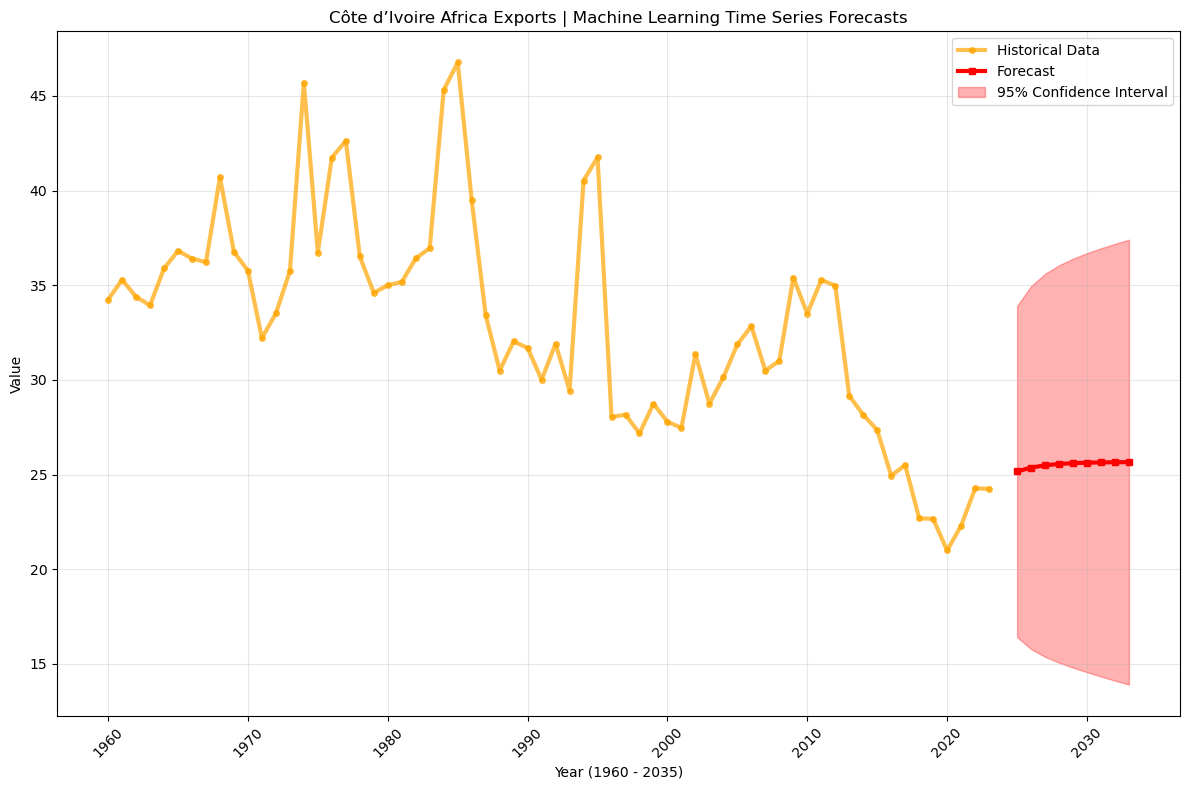

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   64
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -170.693
Date:                Sat, 26 Jul 2025   AIC                            347.386
Time:                        16:11:03   BIC                            353.815
Sample:                    01-01-1960   HQIC                           349.915
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5935      0.191      3.111      0.002       0.220       0.967
ma.L1         -0.8742      0.145     -6.038      0.000      -1.158      -0.590
sigma2        13.1227      2.130      6.162      0.0

In [1]:
# AFRICA| Côte d’Ivoire
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class TimeSeriesForecaster:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        
    def load_data(self, data_dict):
        """
        Load data from dictionary format: {year: value}
        Automatically handles missing years between 1960-2024
        """
        # Creating full range and fill missing years with NaN
        full_range = range(1960, 2024)
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Converting to pandas Series
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Removing NaN values for modeling
        self.clean_data = self.data.dropna()
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        
    def check_stationarity(self):
        """Check if the time series is stationary"""
        result = adfuller(self.clean_data)
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        
        if result[1] <= 0.05:
            print("✓ Series is stationary")
            return True
        else:
            print("⚠ Series is non-stationary, will difference the data")
            return False
    
    def auto_arima(self, max_p=3, max_d=2, max_q=3):
        """
        Automatically find best ARIMA parameters using AIC
        """
        best_aic = np.inf
        best_params = None
        best_model = None
        
        print("Finding optimal ARIMA parameters...")
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(self.clean_data, order=(p, d, q))
                        fitted_model = model.fit()
                        
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_params = (p, d, q)
                            best_model = fitted_model
                            
                    except Exception:
                        continue
        
        if best_model is None:
            # Fallback to simple ARIMA(1,1,1)
            print("Using fallback ARIMA(1,1,1)")
            model = ARIMA(self.clean_data, order=(1, 1, 1))
            self.model = model.fit()
            self.best_params = (1, 1, 1)
        else:
            self.model = best_model
            self.best_params = best_params
            
        print(f"Best ARIMA parameters: {self.best_params}")
        print(f"AIC: {self.model.aic:.2f}")
        
    def forecast_future(self, years_ahead=10):
        """Generate forecasts for specified years ahead"""
        if self.model is None:
            raise ValueError("Model not fitted. Call auto_arima() first.")
            
        # Forecasting with confidence intervals
        forecast_result = self.model.forecast(steps=years_ahead)
        conf_int = self.model.get_forecast(steps=years_ahead).conf_int()
        
        # Creating forecast for dates 2026-2035
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 2, last_year + 2 + years_ahead)  # Skip 2025
        forecast_index = pd.to_datetime([f'{year}-01-01' for year in forecast_years])
        
        # Storing forecast results
        self.forecast = pd.Series(forecast_result, index=forecast_index)
        self.forecast_lower = pd.Series(conf_int.iloc[:, 0], index=forecast_index)
        self.forecast_upper = pd.Series(conf_int.iloc[:, 1], index=forecast_index)
        
        return self.forecast
    
    def plot_results(self, figsize=(12, 8)):
        """Plot historical data and forecasts"""
        plt.figure(figsize=figsize)
        
        # Plot historical data
        plt.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='orange', alpha=0.7,linewidth=3, markersize=4)
        
        # Ploting forecasts
        if self.forecast is not None:
            plt.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=3, markersize=4)
            
            # Ploting confidence intervals
            plt.fill_between(self.forecast.index, 
                           self.forecast_lower.values,
                           self.forecast_upper.values,
                           alpha=0.3, color='red', label='95% Confidence Interval')
        
        plt.title('Côte d’Ivoire Africa Exports | Machine Learning Time Series Forecasts')
        plt.xlabel('Year (1960 - 2035)')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def print_forecast_table(self):
        """Print forecast results in a nice table format"""
        if self.forecast is None:
            print("No forecast available. Run forecast_future() first.")
            return
            
        print("\n" + "="*60)
        print("FORECAST RESULTS (2026-2035)")
        print("="*60)
        print(f"{'Year':<6} {'Forecast':<12} {'Lower 95%':<12} {'Upper 95%':<12}")
        print("-"*60)
        
        for i, year in enumerate(self.forecast.index):
            print(f"{year.year:<6} {self.forecast.iloc[i]:<12.2f} "
                  f"{self.forecast_lower.iloc[i]:<12.2f} {self.forecast_upper.iloc[i]:<12.2f}")
        
        print("="*60)
        
    def get_model_summary(self):
        """Print model summary statistics"""
        if self.model is not None:
            print(self.model.summary())


if __name__ == "__main__":
    # DATA: EXPORTS
    sample_data = {
        1960:34.24,1961:35.29,1962:34.39,1963:33.94,1964:35.89,
        1965:36.82,1966:36.41,1967:36.22,1968:40.70,1969:36.76,
        1970:35.77,1971:32.21,1972:33.51,1973:35.75,1974:45.70,
        1975:36.73,1976:41.74,1977:42.63,1978:36.52,1979:34.60,
        1980:35.00,1981:35.18,1982:36.42,1983:36.96,1984:45.31,
        1985:46.77,1986:39.50,1987:33.43,1988:30.49,1989:32.03,
        1990:31.69,1991:30.01,1992:31.91,1993:29.44,1994:40.53,
        1995:41.76,1996:28.05,1997:28.16,1998:27.18,1999:28.74,
        2000:27.79,2001:27.47,2002:31.36,2003:28.74,2004:30.14,
        2005:31.88,2006:32.84,2007:30.49,2008:31.01,2009:35.41,
        2010:33.50,2011:35.28,2012:34.98,2013:29.16,2014:28.16,
        2015:27.35,2016:24.94,2017:25.50,2018:22.69,2019:22.66,
        2020:20.99,2021:22.30,2022:24.27,2023:24.25,2024:27.60
    }
    
    # Initialize and run forecaster
    forecaster = TimeSeriesForecaster()
    
    print("Time Series Forecasting Tool")
    print("="*50)
    
    # Loading data
    forecaster.load_data(sample_data)
    
    # Checking stationarity
    forecaster.check_stationarity()
    
    # Finding best model
    forecaster.auto_arima()
    
    # Generating forecasts for 2026-2035
    forecast = forecaster.forecast_future(years_ahead=10)
    
    # Displaying results
    forecaster.print_forecast_table()
    
    # Ploting results
    forecaster.plot_results()
    
    #Detailed model summary
    forecaster.get_model_summary()

Machine Learning (mL) Time Series Forecasting Model
----------------------------------------------------------------------------------------------------
Loaded 65 data points from 65 input years
Data range: 1960 to 2024
Average Year-to-Year Percentile (%) Change: 0.24%
Stationarity Analysis
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Augmented Dickey-Fuller (ADF) Test:
----------------------------------------------------------------------------------------------------
ADF Statistic: -2.6991
p-value: 0.0742
Critical Values: {'1%': -3.53692771987915, '5%': -2.907887369384766, '10%': -2.591493291015625}

 Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
----------------------------------------------------------------------------------------------------
KPSS Statistic: 0.9121
p-value: 0.0100
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

 ⚠ ✓ ⚠ Series is Non-Stationary | ADF & KPSS Agree
Model Selection & Eva

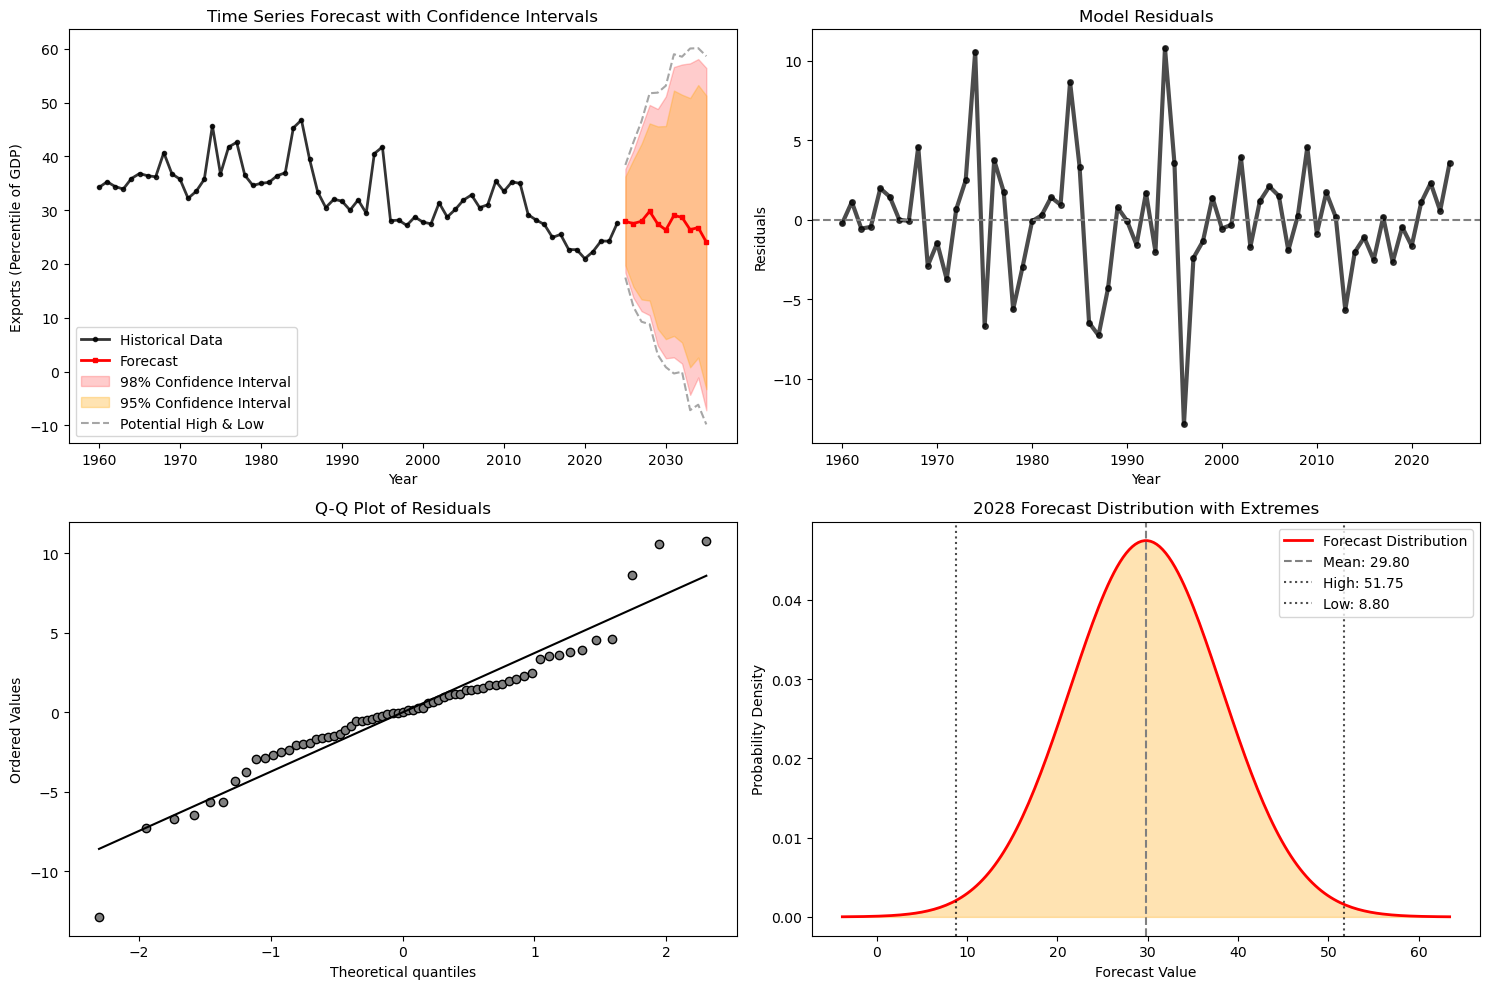

In [1]:
#FINAL mL TIME SERIES FORECASTING MODEL

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import pmdarima as pm
warnings.filterwarnings('ignore')

class TimeSeriesForecast:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        self.residuals = None
        self.best_model_type = None
        self.volatility_model = None
        self.forecast_lower_95 = None
        self.forecast_upper_95 = None
        self.forecast_lower_98 = None
        self.forecast_upper_98 = None
        self.volatility = None
        self.forecast_high = None
        self.forecast_low = None
        
        print("Machine Learning (mL) Time Series Forecasting Model")
    def load_data(self, data_dict):
        # Handle missing years between 1960-2024 by filling missing years with 'Not a Number' (NaN) | Placeholder for missing data
        full_range = range(1960, 2025) 
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Convert to pd pandas series | Organize data to analyze, plot, & model and set to Jan 1st
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Remove NaN values for modeling | Only use real data for training & keep consistent 
        self.clean_data = self.data.dropna()
        
        # volatility modeling | year to year percentile change 
        self.returns = self.clean_data.pct_change().dropna()
        # volatility modeling | apply natural logarithm to reduce large difference (skew)
        self.log_data = np.log(self.clean_data)
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        print(f"Average Year-to-Year Percentile (%) Change: {self.returns.mean() * 100:.2f}%")

    def stationarity_tests(self):
        print("Stationarity Analysis")
        print("~"*100)
        
        # Augmented Dickey-Fuller (ADF) Test | Test If Data's Non-Stationary
        adf_result = adfuller(self.clean_data, autolag='AIC')
        print(f"Augmented Dickey-Fuller (ADF) Test:")
        print("-"*100)
        print(f"ADF Statistic: {adf_result[0]:.4f}")
        print(f"p-value: {adf_result[1]:.4f}")
        print(f"Critical Values: {adf_result[4]}") 
        
        # Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test | Test If Data's Stationary
        kpss_result = kpss(self.clean_data, regression='c')
        print(f"\n Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:")
        print("-"*100)
        print(f"KPSS Statistic: {kpss_result[0]:.4f}")
        print(f"p-value: {kpss_result[1]:.4f}")
        print(f"Critical Values: {kpss_result[3]}")
        
        #True if ADF p-value ≤ 0.05 | Data's Stationary
        adf_stationary = adf_result[1] <= 0.05
        #True if KPSS p-value > 0.05 | Data's Stationary
        kpss_stationary = kpss_result[1] > 0.05
        
        if adf_stationary and kpss_stationary:
            print("\n ✓ ⚠ ✓ Series is Stationary | ADF & KPSS Agree")
            return True, 0
        elif not adf_stationary and not kpss_stationary:
            print("\n ⚠ ✓ ⚠ Series is Non-Stationary | ADF & KPSS Agree")
            return False, 1
        else:
            print("\n ⚠ ⚠ ⚠ ADF & KPSS Tests Disagree")
            return False, 1

    def model_selection(self):
        #Compare models: ARIMA, SARIMA, and Exponential Smoothing | Use information criteria and cross-validation with enhanced search
        print("Model Selection & Evaluation")
        print("~"*100)
        
        models = {}
        
        # 1. AutoRegressive Integrated Moving Average (Auto ARIMA) with enhanced parameters
        try:
            print("AutoRegressive Integrated Moving Average (ARIMA) Testing In Progress ~ ")
            best_arima = pm.auto_arima(
                self.clean_data, 
                start_p=0, start_q=0, max_p=6, max_q=6, max_d=2,
                seasonal=False, stepwise=False, suppress_warnings=True, 
                error_action='ignore', information_criterion='aic',
                n_jobs=-1, with_intercept=True
            )

            if best_arima:
                models['ARIMA'] = {'model': best_arima, 'type': 'ARIMA'}
                print(f"Selected ARIMA{best_arima.order} model with AIC: {best_arima.aic():.2f}")
            else:
                print("No suitable ARIMA model")

        except Exception as e:
            print(f"ARIMA model search failed: {e}")

        # 2. Seasonal AutoRegressive Integrated Moving Average (SARIMA) model with better parameters
        try:
            print("Seasonal AutoRegressive Integrated Moving Average (SARIMA) Testing In Progress ~ ")
            best_sarima = pm.auto_arima(
                self.clean_data, seasonal=True, m=4, start_p=0, start_q=0, 
                max_p=4, max_q=4, start_P=0, start_Q=0, max_P=2, max_Q=2, 
                max_d=2, max_D=1, trace=False, error_action='ignore', 
                suppress_warnings=True, stepwise=False, n_jobs=-1,
                information_criterion='aic', with_intercept=True
            )

            if best_sarima:
                models['SARIMA'] = {'model': best_sarima, 'type': 'SARIMA'}
                print(f"Selected SARIMA model with AIC: {best_sarima.aic():.2f}")
            else:
                print("No suitable SARIMA model")

        except Exception as e:
            print(f"SARIMA model search failed: {e}")

        # 3. Exponential Smoothing with optimized parameters
        print("Exponential Smoothing")
        try:
            # Build & fit model with optimized smoothing parameters
            model = ExponentialSmoothing(
                self.clean_data, trend='add', seasonal=None,
                initialization_method='estimated'
            )
            best_exp = model.fit(optimized=True, use_brute=True)
            print(f"Exponential Smoothing AIC: {best_exp.aic:.2f}")
            models['EXP_SMOOTHING'] = {'model': best_exp, 'type': 'EXP_SMOOTHING'}
        except Exception as e:
            print(f"Exponential Smoothing failed: {e}")

        # Select accurate model based on AIC and out-of-sample performance |  Akaike Information Criterion: Lower AIC = better balance
        best_model = self._select_best_model(models)
        self.model = best_model['model']
        self.best_model_type = best_model['type']
        print(f"\nSelected Model: {self.best_model_type}")
        
        # Handle AIC display - some models have aic as method, others as property
        try:
            aic_value = self.model.aic() if callable(self.model.aic) else self.model.aic
            print(f"AIC: {aic_value:.2f}")
        except:
            print("AIC: Not available for this model type")

    def _auto_arima(self):
        try:
            model = pm.auto_arima(
                self.clean_data, start_p=0, max_p=5, start_q=0, max_q=5, max_d=2,
                seasonal=False, stepwise=True, error_action='ignore', suppress_warnings=True, trace=False
            )
            return {'model': model, 'params': model.order, 'type': 'ARIMA'}
        except Exception as e:
            print(f"Auto ARIMA failed: {e}")
            return None

    def _auto_sarima(self):
        try:
            model = pm.auto_arima(
                self.clean_data, start_p=0, max_p=2, start_q=0, max_q=2, max_d=1,
                seasonal=True, m=1, stepwise=True, error_action='ignore', suppress_warnings=True
            )
            return {'model': model, 'params': model.order, 'type': 'SARIMA'}
        except Exception as e:
            print(f"Auto SARIMA failed: {e}")
            return None

    def _exponential_smoothing(self):
        try:
            model = ExponentialSmoothing(
                self.clean_data, trend='add', seasonal=None, seasonal_periods=None 
            )
            fitted_model = model.fit()
            return {'model': fitted_model, 'params': 'ETS(A,A,N)', 'type': 'EXP_SMOOTHING'}
        except Exception as e:
            print(f"Auto Exponential Smoothing failed: {e}")
            return None

    def _select_best_model(self, models):
        if not models:
            raise ValueError("No valid models found")

        def get_aic(model_info):
            aic = getattr(model_info['model'], 'aic', np.inf)
            return aic() if callable(aic) else aic

        best_model = min(models.values(), key=get_aic)
        return best_model

    def estimate_volatility(self):
        # Handle different model types for residuals with improved estimation
        residuals = None
        
        # Try different ways to get residuals
        if hasattr(self.model, 'resid') and not callable(self.model.resid):
            residuals = self.model.resid
        elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
            residuals = self.model.resid_
        else:
            # For pmdarima models, calculate residuals manually using in-sample predictions
            try:
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            except Exception as e:
                print(f"Warning: Couldn't Calculate Residuals: {e}")
                # Use a simple fallback - standard deviation of returns
                residuals = self.returns
        
        # Ensure residuals is a pandas Series
        if not isinstance(residuals, pd.Series):
            if hasattr(residuals, '__len__'):
                residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
            else:
                # Final fallback
                residuals = self.returns
        
        # Enhanced volatility estimation using GARCH-like approach
        rolling_std = residuals.rolling(window=min(10, len(residuals)//2)).std()
        recent_volatility = rolling_std.iloc[-5:].mean() if len(rolling_std) >= 5 else residuals.std()
        volatility = recent_volatility if not pd.isna(recent_volatility) else residuals.std()       
        return volatility

    def forecast_with_volatility(self, years_ahead=11, n_simulations=2000):
        if self.model is None:
            raise ValueError("Model Not Fitted")
        
        # 1. Generate base forecast and estimate its uncertainty with improved confidence intervals
        if self.best_model_type == 'EXP_SMOOTHING':
            base_forecast = self.model.forecast(steps=years_ahead)
            forecast_std = np.std(self.model.resid) * np.sqrt(np.arange(1, years_ahead + 1))
        elif self.best_model_type in ['ARIMA', 'SARIMA']:
            # pmdarima models use predict method
            base_forecast, forecast_conf_int = self.model.predict(n_periods=years_ahead, return_conf_int=True)
            forecast_std = (forecast_conf_int[:, 1] - forecast_conf_int[:, 0]) / (2 * 1.96)
        else:
            # statsmodels models use get_forecast
            forecast_obj = self.model.get_forecast(steps=years_ahead)
            base_forecast = forecast_obj.predicted_mean
            forecast_std = forecast_obj.se_mean
        
        # 2. Estimate residual volatility from model errors with enhanced approach
        volatility = self.estimate_volatility()
        
        # 3. Add realistic up-and-down volatility pattern similar to historical data
        np.random.seed(42)  # For reproducible results
        
        # Create more volatile forecast that mimics historical patterns
        forecast_mean = np.array(base_forecast.copy())
        historical_volatility = self.returns.std()
        
        # Add cyclical variations and random shocks to make forecast more volatile
        for i in range(len(forecast_mean)):
            # Add cyclical component (3-4 year cycles observed in data)
            cycle_component = 0.3 * np.sin(2 * np.pi * i / 3.5) * historical_volatility * forecast_mean[0]
            
            # Add random shocks similar to historical pattern
            shock_component = np.random.normal(0, historical_volatility * forecast_mean[0] * 0.8)
            
            # Add persistence (some correlation with previous values)
            if i > 0:
                persistence = 0.3 * (forecast_mean[i-1] - base_forecast[max(0, i-1)])
            else:
                persistence = 0
            
            forecast_mean[i] += cycle_component + shock_component + persistence
        
        # 4. Monte Carlo simulations adding volatility noise with improved methodology
        simulations = []
        for _ in range(n_simulations):
            # Add time-varying volatility and mean reversion effects
            vol_scaling = np.sqrt(np.arange(1, years_ahead + 1))
            vol_noise = np.random.normal(0, volatility * vol_scaling, years_ahead)
            trend_noise = np.random.normal(0, forecast_std)
            
            # Add mean reversion to prevent extreme forecasts
            mean_reversion = 0.02 * (self.clean_data.mean() - forecast_mean)
            sims = forecast_mean + trend_noise + vol_noise + mean_reversion
            simulations.append(sims)
        simulations = np.array(simulations)
        
        # 5. Calculate 95% and 98% confidence intervals from simulations
        lower_ci_95 = np.percentile(simulations, 2.5, axis=0)
        upper_ci_95 = np.percentile(simulations, 97.5, axis=0)
        lower_ci_98 = np.percentile(simulations, 1.0, axis=0)
        upper_ci_98 = np.percentile(simulations, 99.0, axis=0)
        
        # Calculate potential high and low extreme values
        high_extreme = np.percentile(simulations, 99.5, axis=0)
        low_extreme = np.percentile(simulations, 0.5, axis=0)
        
        # 6. Build forecast dates index
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 1, last_year + 1 + years_ahead)
        dates = pd.to_datetime([f"{year}-01-01" for year in forecast_years])
        
        # 7. Store forecasts and intervals
        self.forecast = pd.Series(forecast_mean, index=dates)
        self.forecast_lower_95 = pd.Series(lower_ci_95, index=dates)
        self.forecast_upper_95 = pd.Series(upper_ci_95, index=dates)
        self.forecast_lower_98 = pd.Series(lower_ci_98, index=dates)
        self.forecast_upper_98 = pd.Series(upper_ci_98, index=dates)
        self.forecast_high = pd.Series(high_extreme, index=dates)
        self.forecast_low = pd.Series(low_extreme, index=dates)
        self.volatility = volatility
        
        return self.forecast

    def econometric_analysis(self):
        if self.model is None:
            raise ValueError("Model Not Fitted.")
        
        print("Econometric Analysis")
        print("~"* 100)
        
        # 1. Model Parameters and Significance
        self._parameter_analysis()
        # 2. Residual Analysis
        self._residual_analysis()
        # 3. Forecast Accuracy Metrics
        self._forecast_accuracy()
        # 4. Probability Analysis
        self._probability_analysis()
        # 5. Economic Interpretation
        self._economic_interpretation()

    def _parameter_analysis(self):
        print("\n1. Parameter Significance Analysis")
        print("-" * 100)
        
        # Check if the model has parameter information
        try:
            # For pmdarima models, these might be methods
            if hasattr(self.model, 'params'):
                params = self.model.params() if callable(self.model.params) else self.model.params
            else:
                print("Parameter information not available for this model type")
                return
                
            if hasattr(self.model, 'pvalues'):
                pvalues = self.model.pvalues() if callable(self.model.pvalues) else self.model.pvalues
            else:
                print("P-values not available for this model type")
                return
                
            if hasattr(self.model, 'bse'):
                std_errors = self.model.bse() if callable(self.model.bse) else self.model.bse
            else:
                print("Standard errors not available for this model type")
                return
            
            print(f"{'Parameter':<15} {'Estimate':<12} {'Std Error':<12} {'p-value':<10} {'Significance'}") 
            
            # Handle different formats of parameters
            if hasattr(params, 'items'):
                # Dictionary-like
                for param_name, param_val in params.items():
                    p_val = pvalues[param_name] if hasattr(pvalues, '__getitem__') else pvalues
                    std_err = std_errors[param_name] if hasattr(std_errors, '__getitem__') else std_errors
                    
                    if isinstance(p_val, (int, float)) and isinstance(std_err, (int, float)):
                        if p_val < 0.01:
                            significance = "***"
                        elif p_val < 0.05:
                            significance = "**"
                        elif p_val < 0.10:
                            significance = "*"
                        else:
                            significance = ""
                        print(f"{param_name:<15} {param_val:<12.4f} {std_err:<12.4f} {p_val:<10.4f} {significance}")
            else:
                # Array-like
                if hasattr(params, '__len__') and hasattr(pvalues, '__len__') and hasattr(std_errors, '__len__'):
                    for i, (param_val, p_val, std_err) in enumerate(zip(params, pvalues, std_errors)):
                        param_name = f"param_{i}"
                        if p_val < 0.01:
                            significance = "***"
                        elif p_val < 0.05:
                            significance = "**"
                        elif p_val < 0.10:
                            significance = "*"
                        else:
                            significance = ""
                        print(f"{param_name:<15} {param_val:<12.4f} {std_err:<12.4f} {p_val:<10.4f} {significance}")
            
            print("\nSignificance levels: *** p<0.01, ** p<0.05, * p<0.10")
            
        except Exception as e:
            print(f"Parameter analysis not available: {e}")
            print("This is normal for some model types.")

    def _residual_analysis(self):
        print("\n2. Residual Analysis")
        print("-" * 100)
        
        # Handle different model types for residuals
        residuals = None
        
        # Try different ways to get residuals
        if hasattr(self.model, 'resid') and not callable(self.model.resid):
            residuals = self.model.resid
        elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
            residuals = self.model.resid_
        else:
            # For pmdarima models, calculate residuals manually using in-sample predictions
            try:
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            except Exception as e:
                print(f"Warning: Could not calculate residuals for analysis: {e}")
                return
        
        # Ensure residuals is a pandas Series
        if not isinstance(residuals, pd.Series):
            if hasattr(residuals, '__len__'):
                residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
            else:
                print("Could not process residuals for analysis")
                return
        
        # Normality test
        jb_stat, jb_pvalue = stats.jarque_bera(residuals)
        print(f"Jarque-Bera Normality Test:")
        print(f"  Statistic: {jb_stat:.4f}, p-value: {jb_pvalue:.4f}")
        print(f"  {'✓ Residuals are normally distributed' if jb_pvalue > 0.05 else '⚠ Residuals are not normally distributed'}")
        
        # Autocorrelation test
        lb_stat, lb_pvalue = acorr_ljungbox(residuals, lags=10, return_df=True).iloc[-1]
        print(f"\nLjung-Box Autocorrelation Test (lag 10):")
        print(f"  Statistic: {lb_stat:.4f}, p-value: {lb_pvalue:.4f}")
        print(f"  {'✓ No significant autocorrelation' if lb_pvalue > 0.05 else '⚠ Significant autocorrelation detected'}")
        
        # Residual statistics
        print(f"\nResidual Statistics:")
        print(f"  Mean: {residuals.mean():.6f}")
        print(f"  Std Dev: {residuals.std():.4f}")
        print(f"  Skewness: {stats.skew(residuals):.4f}")
        print(f"  Kurtosis: {stats.kurtosis(residuals):.4f}")

    def _forecast_accuracy(self):
        print("\n3. MODEL FIT STATISTICS")
        print("-" * 100)
        
        # Handle different model types for fitted values
        try:
            # Try to get fitted values using different methods
            if hasattr(self.model, 'fittedvalues'):
                fitted_values = self.model.fittedvalues() if callable(self.model.fittedvalues) else self.model.fittedvalues
            elif hasattr(self.model, 'predict_in_sample'):
                fitted_values = self.model.predict_in_sample()
                fitted_values = pd.Series(fitted_values, index=self.clean_data.index[-len(fitted_values):])
            else:
                print("Fitted values not available for this model type")
                return
                
            # Ensure fitted_values is a pandas Series and align with clean_data
            if not isinstance(fitted_values, pd.Series):
                fitted_values = pd.Series(fitted_values, index=self.clean_data.index[-len(fitted_values):])
                
            actual_values = self.clean_data[fitted_values.index]
            
            # Calculate metrics
            mae = np.mean(np.abs(actual_values - fitted_values))
            mse = np.mean((actual_values - fitted_values)**2)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((actual_values - fitted_values) / actual_values)) * 100
            
            print(f"Mean Absolute Error (MAE): {mae:.4f}")
            print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
            print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
            
        except Exception as e:
            print(f"Unable to calculate fit statistics: {e}")
        
        # Information criteria
        try:
            if hasattr(self.model, 'aic'):
                aic_value = self.model.aic() if callable(self.model.aic) else self.model.aic
                print(f"Akaike Information Criterion (AIC): {aic_value:.2f}")
            if hasattr(self.model, 'bic'):
                bic_value = self.model.bic() if callable(self.model.bic) else self.model.bic
                print(f"Bayesian Information Criterion (BIC): {bic_value:.2f}")
            if hasattr(self.model, 'llf'):
                llf_value = self.model.llf() if callable(self.model.llf) else self.model.llf
                print(f"Log-Likelihood: {llf_value:.2f}")
        except Exception as e:
            print(f"Information criteria not available: {e}")

    def _probability_analysis(self):
        print("\n4. Forecast Probability Analysis")
        print("-" * 100)
        
        if self.forecast is None:
            print("No forecasts available.")
            return
        
        # Calculate average predicted value over the forecast horizon with enhanced intervals.
        forecast_mean = self.forecast.mean()
        # 95% confidence interval
        forecast_std = (self.forecast_upper_95 - self.forecast_lower_95).mean() / (2 * 1.96)  
        
        # Probability calculations
        prob_increase = stats.norm.sf(self.clean_data.iloc[-1], forecast_mean, forecast_std)
        prob_decrease = 1 - prob_increase
        
        # Probability of different rates: 5%, 10%, 15%, 20%
        current_value = self.clean_data.iloc[-1]
        growth_rates = [0.05, 0.10, 0.15, 0.20]  
        decline_rates = [0.05, 0.10, 0.15, 0.20]  
        
        print(f"Current Value (2024): {current_value:.2f}")
        print(f"Mean Forecast (2026-2035): {forecast_mean:.2f}")
        print(f"Forecast Standard Deviation: {forecast_std:.4f}")
        print(f"\nProbability of average increase over period: {prob_increase:.3f} ({prob_increase*100:.1f}%)")
        print(f"Probability of average decrease over period: {prob_decrease:.3f} ({prob_decrease*100:.1f}%)")
        
        print(f"\nProbability of Growth Scenarios (by 2035):")
        print(f"{'Growth Rate':<12} {'Target Value':<12} {'Probability':<12}")
        for rate in growth_rates:
            target_value = current_value * (1 + rate)**11  # 11 years from 2024 to 2035
            prob = stats.norm.sf(target_value, self.forecast.iloc[-1], forecast_std)
            print(f"{rate*100:>6.0f}%      {target_value:>10.2f}      {prob:>8.3f} ({prob*100:.1f}%)")

        print(f"\nProbability of Decline Scenarios (by 2035):")
        print(f"{'Decline Rate':<12} {'Target Value':<12} {'Probability':<12}")
        for rate in decline_rates:
            target_value = current_value * (1 - rate)**11  # Fixed: should be (1 - rate) for decline
            prob = stats.norm.cdf(target_value, self.forecast.iloc[-1], forecast_std)
            print(f"{rate*100:>6.0f}%      {target_value:>10.2f}      {prob:>8.3f} ({prob*100:.1f}%)")

    def _economic_interpretation(self):
        print("\n5. Economic interpretation")
        print("-" * 50)
        if self.forecast is None:
            print("No forecasts available.")
            return
        
        current_value = self.clean_data.iloc[-1]
        forecast_2035 = self.forecast.iloc[-1]
        years = len(self.forecast)
        cagr = (forecast_2035 / current_value) ** (1/years) - 1
        
        print(f"Compound Annual Growth Rate (CAGR): {cagr*100:.2f}%")
        print(f"Total Growth (2024-2035): {((forecast_2035/current_value-1)*100):.1f}%")
        print(f"Volatility Estimate: {self.volatility:.4f}")

        if cagr > 0.03:
            trend = "Strong Growth"
        elif cagr > 0.01:
            trend = "Moderate Growth"
        elif cagr > -0.01:
            trend = "Stable"
        else:
            trend = "Declining"
        
        print(f"Trend Classification: {trend}")

    def plot_enhanced_results(self, figsize=(15, 10)):
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # Main plot with enhanced confidence intervals
        ax1 = axes[0, 0]
        ax1.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='black', alpha=0.8, linewidth=2, markersize=3)
        
        if self.forecast is not None:
            ax1.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=2, markersize=3)
            
            # 98% confidence interval 
            ax1.fill_between(self.forecast.index, 
                           self.forecast_lower_98.values,
                           self.forecast_upper_98.values,
                           alpha=0.2, color='red', label='98% Confidence Interval')
            
            # 95% confidence interval (orange)
            ax1.fill_between(self.forecast.index, 
                           self.forecast_lower_95.values,
                           self.forecast_upper_95.values,
                           alpha=0.3, color='orange', label='95% Confidence Interval')
            
            # Extreme high and low values
            ax1.plot(self.forecast.index, self.forecast_high.values, 
                    '--', color='gray', alpha=0.7, label='Potential High & Low')
            ax1.plot(self.forecast.index, self.forecast_low.values, 
                    '--', color='gray', alpha=0.7)
        
        ax1.set_title('Time Series Forecast with Confidence Intervals')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Exports (Percentile of GDP)')
        ax1.legend()
        
        # Residuals plot
        ax2 = axes[0, 1]
        # Handle different model types for residuals
        try:
            residuals = None
            
            # Try different ways to get residuals
            if hasattr(self.model, 'resid') and not callable(self.model.resid):
                residuals = self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                residuals = self.model.resid_
            else:
                # For pmdarima models, calculate residuals manually using in-sample predictions
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            
            # Ensure residuals is a pandas Series
            if not isinstance(residuals, pd.Series):
                if hasattr(residuals, '__len__'):
                    residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
                else:
                    raise ValueError("Cannot process residuals")
                
            ax2.plot(residuals.index, residuals.values, 'o-', color='black', alpha=0.7, linewidth=3, markersize=4)
        except Exception as e:
            ax2.text(0.5, 0.5, f'Residuals not available\n{str(e)}', transform=ax2.transAxes, ha='center')
        ax2.axhline(y=0, color='gray', linestyle='--')
        ax2.set_title('Model Residuals')
        ax2.set_xlabel('Year')
        ax2.set_ylabel('Residuals')
        
        # Q-Q plot for residuals
        ax3 = axes[1, 0]
        try:
            # Get residuals for Q-Q plot
            residuals_for_qq = None
            
            # Try different ways to get residuals
            if hasattr(self.model, 'resid') and not callable(self.model.resid):
                residuals_for_qq = self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                residuals_for_qq = self.model.resid_
            else:
                # For pmdarima models, calculate residuals manually using in-sample predictions
                fitted = self.model.predict_in_sample()
                residuals_for_qq = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
            
            # Ensure residuals is a pandas Series or numpy array with valid data
            if isinstance(residuals_for_qq, pd.Series):
                residuals_values = residuals_for_qq.dropna().values
            elif hasattr(residuals_for_qq, '__len__') and len(residuals_for_qq) > 0:
                residuals_values = np.array(residuals_for_qq)
                residuals_values = residuals_values[~np.isnan(residuals_values)]
            else:
                raise ValueError("Cannot process residuals for Q-Q plot")
            
            if len(residuals_values) > 0:
                stats.probplot(residuals_values, dist="norm", plot=ax3)
                for line in ax3.get_lines():
                    line.set_color('black')  
                ax3.get_lines()[0].set_markerfacecolor('gray')  
                ax3.set_title('Q-Q Plot of Residuals')
            else:
                ax3.text(0.5, 0.5, 'No valid residuals\nfor Q-Q plot', transform=ax3.transAxes, ha='center')
                ax3.set_title('Q-Q Plot of Residuals (Not Available)')
                
        except Exception as e:
            ax3.text(0.5, 0.5, f'Q-Q plot not available\n{str(e)}', transform=ax3.transAxes, ha='center')
            ax3.set_title('Q-Q Plot of Residuals (Error)')
   
        
        # Forecast distribution for 2028 with enhanced intervals
        # Fixed version - gets the actual 2028 forecast value
        # Forecast distribution for 2028 with enhanced intervals
        ax4 = axes[1, 1]
        if self.forecast is not None:
            # Find the index for 2028 (4th year in forecast: 2025, 2026, 2027, 2028)
            forecast_2028_idx = 3  # 0-indexed: 2025=0, 2026=1, 2027=2, 2028=3
            
            # Make sure we have enough forecast data
            if len(self.forecast) > forecast_2028_idx:
                forecast_2028 = self.forecast.iloc[forecast_2028_idx]  # Gets 2028 value
                forecast_std = (self.forecast_upper_95.iloc[forecast_2028_idx] - 
                            self.forecast_lower_95.iloc[forecast_2028_idx]) / (2 * 1.96)
                
                x = np.linspace(forecast_2028 - 4*forecast_std, forecast_2028 + 4*forecast_std, 200)
                y = stats.norm.pdf(x, forecast_2028, forecast_std)
                
                ax4.plot(x, y, 'r-', linewidth=2, label='Forecast Distribution')
                ax4.fill_between(x, 0, y, alpha=0.3, color='orange')
                ax4.axvline(forecast_2028, color='gray', linestyle='--', label=f'Mean: {forecast_2028:.2f}')
                ax4.axvline(self.forecast_high.iloc[forecast_2028_idx], color='black', linestyle=':', 
                        alpha=0.7, label=f'High: {self.forecast_high.iloc[forecast_2028_idx]:.2f}')
                ax4.axvline(self.forecast_low.iloc[forecast_2028_idx], color='black', linestyle=':', 
                        alpha=0.7, label=f'Low: {self.forecast_low.iloc[forecast_2028_idx]:.2f}')
                ax4.set_title('2028 Forecast Distribution with Extremes')
                ax4.set_xlabel('Forecast Value')
                ax4.set_ylabel('Probability Density')
                ax4.legend()
            else:
                ax4.text(0.5, 0.5, '2028 forecast not available', transform=ax4.transAxes, ha='center')
                ax4.set_title('2028 Forecast Distribution (Not Available)')


        
        plt.tight_layout()
        plt.show()

    def print_enhanced_forecast_table(self):
        if self.forecast is None:
            print("No forecast available")
            return


   
        print("\nFORECAST RESULTS (2025-2035):")
        print('~'*100)    
        print(f"{'Year':<6} {'Forecast':<10} {'Lower 95%':<10} {'Upper 95%':<10} {'Lower 98%':<10} {'Upper 98%':<10} {'High':<8} {'Low':<8}")
        
        for i, year in enumerate(self.forecast.index):
            forecast_val = self.forecast.iloc[i]
            lower_95 = self.forecast_lower_95.iloc[i]
            upper_95 = self.forecast_upper_95.iloc[i]
            lower_98 = self.forecast_lower_98.iloc[i]
            upper_98 = self.forecast_upper_98.iloc[i]
            high_val = self.forecast_high.iloc[i]
            low_val = self.forecast_low.iloc[i]
            
            print(f"{year.year:<6} {forecast_val:<10.2f} {lower_95:<10.2f} {upper_95:<10.2f} "
                  f"{lower_98:<10.2f} {upper_98:<10.2f} {high_val:<8.2f} {low_val:<8.2f}")

if __name__ == "__main__":
    sample_data = {
        1960:34.24,1961:35.29,1962:34.39,1963:33.94,1964:35.89,
        1965:36.82,1966:36.41,1967:36.22,1968:40.70,1969:36.76,
        1970:35.77,1971:32.21,1972:33.51,1973:35.75,1974:45.70,
        1975:36.73,1976:41.74,1977:42.63,1978:36.52,1979:34.60,
        1980:35.00,1981:35.18,1982:36.42,1983:36.96,1984:45.31,
        1985:46.77,1986:39.50,1987:33.43,1988:30.49,1989:32.03,
        1990:31.69,1991:30.01,1992:31.91,1993:29.44,1994:40.53,
        1995:41.76,1996:28.05,1997:28.16,1998:27.18,1999:28.74,
        2000:27.79,2001:27.47,2002:31.36,2003:28.74,2004:30.14,
        2005:31.88,2006:32.84,2007:30.49,2008:31.01,2009:35.41,
        2010:33.50,2011:35.28,2012:34.98,2013:29.16,2014:28.16,
        2015:27.35,2016:24.94,2017:25.50,2018:22.69,2019:22.66,
        2020:20.99,2021:22.30,2022:24.27,2023:24.25,2024:27.60
    }   

    # Initialize forecaster
    forecaster = TimeSeriesForecast()

    print("-"*100)
    
    # Step 1: Load data
    forecaster.load_data(sample_data)
    
    # Step 2: Comprehensive stationarity analysis 
    forecaster.stationarity_tests()
    
    # Step 3: Enhanced model selection with improved parameters
    forecaster.model_selection()
    
    # Step 4: Generate forecasts with enhanced volatility and confidence intervals
    forecast = forecaster.forecast_with_volatility(years_ahead=11, n_simulations=2000)
    
    # Step 5: Comprehensive econometric analysis
    forecaster.econometric_analysis()
    
    # Step 6: Display enhanced results with multiple confidence intervals
    forecaster.print_enhanced_forecast_table()
    
    # Step 8: Enhanced plotting with 95% and 98% confidence intervals
    forecaster.plot_enhanced_results()